# Basketball Analysis
#### Created by Liz Khan
<img src="basketball.png">

#### Purpose:

I want to see how accurate the AP 25 Preseason Rankings for Men’s basketball are compared to how well teams perform in the Regular Season and where they end up in the NCAA tournament. To get started, I am utilizing the NCAA Men’s Basketball data accessible through Google Big Query as a public dataset.


In [1]:
#Import libaries for Google BigQuery
from google.cloud import bigquery
import pandas as pd
import math
import numpy as np

#Measure Programs execution time
import time

#start script
script_start = time.time()


#Import seaborn and matplot lib

import seaborn as sn
import matplotlib.pyplot as plt


In [2]:
# Read Local AP Preasons Rankings CSV

AP_Rank = pd.read_csv(r'C:\Users\Liz\Documents\AP_Mens_NCAA_Preseason_Ranks.csv')
Coaches_Rank = pd.read_csv(r'C:\Users\Liz\Documents\Coaches Poll Post Season Rank.csv')

In [3]:
#Connect to Google Big Query to Pull Down NCAA Mens Tournament Data
client = bigquery.Client()

#Pull Down Game Level Winning and Losing Teams 
query1 = """
select distinct hist.season,hist.tournament_type, hist.game_id, hist.scheduled_date, case when hist.win=True then name.school_ncaa else name2.school_ncaa end as WTeamName,  case when hist.win=True then hist.team_id else hist.opp_id end as WTeamID,case when hist.win=False then name.school_ncaa else name2.school_ncaa end as LTeamName, case when hist.win=False then hist.team_id else hist.opp_id end as LTeamID 
from `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` hist
left join `bigquery-public-data.ncaa_basketball.mbb_teams` name on hist.team_id=name.id 
left join `bigquery-public-data.ncaa_basketball.mbb_teams` name2 on hist.opp_id=name2.id
order by hist.scheduled_date asc
"""
query2 = """
select season, round, game_date,win_school_ncaa as WTeamName, win_team_id as WTeamID, lose_school_ncaa as LTeamName, lose_team_id as LTeamID
from `bigquery-public-data.ncaa_basketball.mbb_historical_tournament_games`
where season between 2013 and 2018
order by season, game_date asc
"""

query3 = """
select team_id as TeamID, season, wins,losses, wins-losses as net_wins, rank() over(partition by season order by season, wins desc) as regular_season_rank
from `bigquery-public-data.ncaa_basketball.mbb_historical_teams_seasons`
where season between 2013 and 2018
order by season, wins desc
"""

#Pull down as dataframe in memory
ncaa_games = client.query(query1).to_dataframe()
print(ncaa_games.head())

ncaa_tourney = client.query(query2).to_dataframe()
print(ncaa_tourney.head())

reg_season_all = client.query(query3).to_dataframe()
print(reg_season_all.head())






   season tournament_type                               game_id  \
0    2013            None  60ed7cb9-40de-4167-ae67-c68eb756d641   
1    2013            None  2803840c-a776-4346-828d-1a4c0ee8d4cd   
2    2013            None  df6348de-ac47-4598-a5d0-9f6aac7b099b   
3    2013            None  c58408d2-2e3d-428a-91d6-7579705e1502   
4    2013            None  3224b157-68a1-4f02-bdc7-ddafbdd9ded8   

  scheduled_date      WTeamName                               WTeamID  \
0     2013-11-08            VMI  227d3567-d57b-417e-afc4-735e4cb308a1   
1     2013-11-08    Eastern Ky.  e48e3dd5-721c-4d96-8ff4-790fe2597bfd   
2     2013-11-08          UConn  efba5350-79bc-47aa-a189-db177b95b491   
3     2013-11-08  Eastern Mich.  2ed86226-3fff-4083-90fa-6b02307e6f73   
4     2013-11-08  Central Mich.  472c22e0-843d-472c-a871-f1593fb0725d   

     LTeamName                               LTeamID  
0  The Citadel  412e7f0d-fb93-4e6e-be1f-9a4c7490d121  
1          FIU  a8ac24ca-3b7a-4610-ad99-04266158

In [4]:
# Separate out winning and losing teams to later combine in a single dataset and rename Team column to TeamID

wins_ncaa_tourney = ncaa_tourney[['season','round','WTeamID']].copy()

wins_ncaa_tourney.rename(columns={'WTeamID':'TeamID'},inplace=True)

losses_ncaa_tourney = ncaa_tourney[['season','round','LTeamID']].copy()

losses_ncaa_tourney.rename(columns={'LTeamID':'TeamID'},inplace=True)

In [5]:
# Combine winning and losing teams into a single dataset to figure out how far each team advanced in the NCAA tournament (i.e. the lowest round)
ncaa_tourney_summary = wins_ncaa_tourney.append(losses_ncaa_tourney)
ncaa_tourney_summary = ncaa_tourney_summary.groupby(by=['season','TeamID'])['round'].min().reset_index()

In [6]:
#Create a list of all teams for all years 

ncaa_1 =ncaa_games[['season','WTeamID']].copy()
ncaa_2 =ncaa_games[['season','LTeamID']].copy()
ncaa_1.rename(columns={'WTeamID':'TeamID'},inplace=True)
ncaa_2.rename(columns={'LTeamID':'TeamID'},inplace=True)

team_rank = ncaa_1.append(ncaa_2).drop_duplicates()

#set base score for Elo ranking at 1200

team_rank = team_rank.reset_index()
team_rank['index1'] = team_rank.index
team_rank['score'] = 1200

In [7]:
ncaa_games = ncaa_games[(ncaa_games.tournament_type.isnull())|(ncaa_games.tournament_type.isin(['Patriot League','Horizon League','Big South','Atlantic Sun','Metro Atlantic','Ohio Valley','Missouri Valley','West Coast','America East','Colonial Athletic','Summit League','Mid','Conference USA','Southwestern Athletic','Pac','Atlantic Coast','Big 12','American Athletic','Big East','Mountain West','Southland','Atlantic 10','Big Ten','Big Sky','Sun Belt','Big West','Western Athletic','MAAC','MEAC','ACC','SWAC','SEC','Temple Bracket','Southwest Athletic']))].reset_index()

In [8]:
#Define Elo Function to update scores after a win/ loss

def Probability(rating1, rating2): 
  
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400)) 


def EloRwting_Win(Rw, Rl, K): 
   
    # Probability of Losing Team
    Pl = Probability(Rw, Rl) 
  
    # Probability of Winning Team 
    Pw = Probability(Rl, Rw) 
  
    #Winning Team Id is winner
    Win = Rw + K * (1 - Pw) 
    Loss = Rl + K * (0 - Pl) 
    
    Win = round(Win, 6)
    Loss = round(Loss, 6)
    print('Winning Team is now: '+str(round(Win, 6)), 'Losing Team is now: '+str(round(Loss, 6)))
    return Win

def EloRwting_Loss(Rw, Rl, K): 
   
    # Probability of Losing Team
    Pl = Probability(Rw, Rl) 
  
    # Probability of Winning Team 
    Pw = Probability(Rl, Rw) 
  
    #Winning Team Id is winner
    Win = Rw + K * (1 - Pw) 
    Loss = Rl + K * (0 - Pl) 
    
    Win = round(Win, 6)
    Loss = round(Loss, 6)
    print('Winning Team is now: '+str(round(Win, 6)), 'Losing Team is now: '+str(round(Loss, 6)))
    return Loss

In [9]:
# ncaa_games_season = {}
# team_rank_season = {}
# for year in range(2013,2018):
#     ncaa_games_season[year] = ncaa_games[ncaa_games['season']==year]
#     team_rank_season[year] = team_rank[team_rank['season']==year]
    

In [10]:
elo_start = time.time()

for team in range(len(ncaa_games)):
    Rw = team_rank[['index1','score']][(team_rank['TeamID']==ncaa_games['WTeamID'][team])&(team_rank['season']==ncaa_games['season'][team])].values[0]
    Rl = team_rank[['index1','score']][(team_rank['TeamID']==ncaa_games['LTeamID'][team])&(team_rank['season']==ncaa_games['season'][team])].values[0]
    team_rank.loc[Rw[0],'score'] =  EloRwting_Win(Rw[1], Rl[1], K=20)
    team_rank.loc[Rl[0],'score'] = EloRwting_Loss(Rw[1], Rl[1], K=20)
    
    elo_end = time.time()
print('ELO Calculation Time in Minutes:'+str((elo_end - elo_start)/60))

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1219.153755 Losing Team is now: 1180.846245
Winning Team is now: 1219.153755 Losing Team is now: 1180.846245
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Lo

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1181.667778 Losing Team is now: 1189.162392
Winning Team is now: 1181.667778 Losing Team is now: 1189.162392
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now:

Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.720538 Losing Team is now: 1199.991718
Winning Team is now: 1219.720538 Losing Team is now: 1199.991718
Winning Team is now: 1190.8545 Losing Team is now: 1189.433244
Winning Team is now: 1190.8545 Losing Team is now: 1189.433244
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1220.287744 Losing Team is now: 1209.712256
Winning Team is now: 1220.287744 Losing Team is now: 1209.712256
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.424

Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1218.820542 Losing Team is now: 1170.070884
Winning Team is now: 1218.820542 Losing Team is now: 1170.070884
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1229.712256 Losing Team is now: 1200.287744
Winning Team is now: 1229.712256 Losing Team is now: 1200.287744
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team 

Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1190.8545 Losing Team is now: 1189.433244
Winning Team is now: 1190.8545 Losing Team is now: 1189.433244
Winning Team is now: 1210.558514 Losing Team is now: 1208.866475
Winning Team is now: 1210.558514 Losing Team is now: 1208.866475
Winning Team is now: 1229.433244 Losing Team is now: 1190.8545
Winning Team is now: 1229.433244 Losing Team is now: 1190.8545
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.558461 Losing Team is now: 1190.01655
Winning Team is now: 1210.558461 Losing Team is now: 1190.01655
Winning Team is now: 1228.580089 Losing Team is now: 1180.8449
Winning Team is now: 1228.580089 Losing Team is now: 1180.8449
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.2

Winning Team is now: 1238.579007 Losing Team is now: 1199.736774
Winning Team is now: 1238.579007 Losing Team is now: 1199.736774
Winning Team is now: 1228.870103 Losing Team is now: 1171.704908
Winning Team is now: 1228.870103 Losing Team is now: 1171.704908
Winning Team is now: 1229.39998 Losing Team is now: 1199.171423
Winning Team is now: 1229.39998 Losing Team is now: 1199.171423
Winning Team is now: 1209.458089 Losing Team is now: 1190.541911
Winning Team is now: 1209.458089 Losing Team is now: 1190.541911
Winning Team is now: 1190.838431 Losing Team is now: 1179.728563
Winning Team is now: 1190.838431 Losing Team is now: 1179.728563
Winning Team is now: 1209.983506 Losing Team is now: 1170.591505
Winning Team is now: 1209.983506 Losing Team is now: 1170.591505
Winning Team is now: 1229.679942 Losing Team is now: 1190.024509
Winning Team is now: 1229.679942 Losing Team is now: 1190.024509
Winning Team is now: 1210.262791 Losing Team is now: 1208.308612
Winning Team is now: 1210.2

Winning Team is now: 1236.953619 Losing Team is now: 1171.940615
Winning Team is now: 1220.558937 Losing Team is now: 1209.441063
Winning Team is now: 1220.558937 Losing Team is now: 1209.441063
Winning Team is now: 1239.145263 Losing Team is now: 1209.71297
Winning Team is now: 1239.145263 Losing Team is now: 1209.71297
Winning Team is now: 1191.397187 Losing Team is now: 1189.449275
Winning Team is now: 1191.397187 Losing Team is now: 1189.449275
Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1210.016074 Losing Team is now: 1190.000476
Winning Team is now: 1210.016074 Losing Team is now: 1190.000476
Winning Team is now: 1219.1551 Losing Team is now: 1171.419911
Winning Team is now: 1219.1551 Losing Team is now: 1171.419911
Winning Team is now: 1191.141781 Losing Team is now: 1189.720974
Winning Team is now: 1191.141781 Losing Team is now: 1189.720974
Winning Team is now: 1219.94398

Winning Team is now: 1237.49669 Losing Team is now: 1181.122606
Winning Team is now: 1237.49669 Losing Team is now: 1181.122606
Winning Team is now: 1210.534632 Losing Team is now: 1189.760419
Winning Team is now: 1210.534632 Losing Team is now: 1189.760419
Winning Team is now: 1210.559181 Losing Team is now: 1199.4493
Winning Team is now: 1210.559181 Losing Team is now: 1199.4493
Winning Team is now: 1209.951546 Losing Team is now: 1188.635502
Winning Team is now: 1209.951546 Losing Team is now: 1188.635502
Winning Team is now: 1238.819324 Losing Team is now: 1190.285826
Winning Team is now: 1238.819324 Losing Team is now: 1190.285826
Winning Team is now: 1220.567436 Losing Team is now: 1200.574787
Winning Team is now: 1220.567436 Losing Team is now: 1200.574787
Winning Team is now: 1221.069669 Losing Team is now: 1209.184997
Winning Team is now: 1221.069669 Losing Team is now: 1209.184997
Winning Team is now: 1181.420375 Losing Team is now: 1189.155113
Winning Team is now: 1181.42037

Winning Team is now: 1229.432551 Losing Team is now: 1200.271464
Winning Team is now: 1201.396686 Losing Team is now: 1189.745095
Winning Team is now: 1201.396686 Losing Team is now: 1189.745095
Winning Team is now: 1239.1455 Losing Team is now: 1200.566756
Winning Team is now: 1239.1455 Losing Team is now: 1200.566756
Winning Team is now: 1200.001502 Losing Team is now: 1170.626188
Winning Team is now: 1200.001502 Losing Team is now: 1170.626188
Winning Team is now: 1182.261048 Losing Team is now: 1217.475964
Winning Team is now: 1182.261048 Losing Team is now: 1217.475964
Winning Team is now: 1238.598229 Losing Team is now: 1181.418091
Winning Team is now: 1238.598229 Losing Team is now: 1181.418091
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1220.502222 Losing Team is now: 1217.50487
Winning Team is now: 1220.502222 Losing Team is now: 1217.50487
Winning Team is now: 1220.00732

Winning Team is now: 1200.551647 Losing Team is now: 1198.633996
Winning Team is now: 1201.125081 Losing Team is now: 1190.295035
Winning Team is now: 1201.125081 Losing Team is now: 1190.295035
Winning Team is now: 1200.016313 Losing Team is now: 1189.704219
Winning Team is now: 1200.016313 Losing Team is now: 1189.704219
Winning Team is now: 1229.953284 Losing Team is now: 1190.096279
Winning Team is now: 1229.953284 Losing Team is now: 1190.096279
Winning Team is now: 1209.736784 Losing Team is now: 1180.567694
Winning Team is now: 1209.736784 Losing Team is now: 1180.567694
Winning Team is now: 1236.191338 Losing Team is now: 1190.774587
Winning Team is now: 1236.191338 Losing Team is now: 1190.774587
Winning Team is now: 1238.788442 Losing Team is now: 1189.251584
Winning Team is now: 1238.788442 Losing Team is now: 1189.251584
Winning Team is now: 1209.169806 Losing Team is now: 1171.117488
Winning Team is now: 1209.169806 Losing Team is now: 1171.117488
Winning Team is now: 1237

Winning Team is now: 1228.94136 Losing Team is now: 1219.672395
Winning Team is now: 1198.971369 Losing Team is now: 1153.58262
Winning Team is now: 1198.971369 Losing Team is now: 1153.58262
Winning Team is now: 1210.34108 Losing Team is now: 1200.979549
Winning Team is now: 1210.34108 Losing Team is now: 1200.979549
Winning Team is now: 1200.591755 Losing Team is now: 1181.395368
Winning Team is now: 1200.591755 Losing Team is now: 1181.395368
Winning Team is now: 1202.180382 Losing Team is now: 1226.417901
Winning Team is now: 1202.180382 Losing Team is now: 1226.417901
Winning Team is now: 1164.148694 Losing Team is now: 1188.649727
Winning Team is now: 1164.148694 Losing Team is now: 1188.649727
Winning Team is now: 1200.582304 Losing Team is now: 1189.991275
Winning Team is now: 1200.582304 Losing Team is now: 1189.991275
Winning Team is now: 1228.844514 Losing Team is now: 1180.339797
Winning Team is now: 1228.844514 Losing Team is now: 1180.339797
Winning Team is now: 1238.0394

Winning Team is now: 1201.554782 Losing Team is now: 1160.939112
Winning Team is now: 1209.195255 Losing Team is now: 1162.784452
Winning Team is now: 1209.195255 Losing Team is now: 1162.784452
Winning Team is now: 1227.831084 Losing Team is now: 1200.232034
Winning Team is now: 1227.831084 Losing Team is now: 1200.232034
Winning Team is now: 1210.009194 Losing Team is now: 1199.448419
Winning Team is now: 1210.009194 Losing Team is now: 1199.448419
Winning Team is now: 1172.52348 Losing Team is now: 1198.61054
Winning Team is now: 1172.52348 Losing Team is now: 1198.61054
Winning Team is now: 1181.968309 Losing Team is now: 1153.014031
Winning Team is now: 1181.968309 Losing Team is now: 1153.014031
Winning Team is now: 1219.983258 Losing Team is now: 1190.295768
Winning Team is now: 1219.983258 Losing Team is now: 1190.295768
Winning Team is now: 1221.364101 Losing Team is now: 1200.582336
Winning Team is now: 1221.364101 Losing Team is now: 1200.582336
Winning Team is now: 1220.447

Winning Team is now: 1228.919972 Losing Team is now: 1190.785274
Winning Team is now: 1199.80133 Losing Team is now: 1200.244992
Winning Team is now: 1199.80133 Losing Team is now: 1200.244992
Winning Team is now: 1190.336106 Losing Team is now: 1162.457391
Winning Team is now: 1190.336106 Losing Team is now: 1162.457391
Winning Team is now: 1210.598437 Losing Team is now: 1191.635778
Winning Team is now: 1210.598437 Losing Team is now: 1191.635778
Winning Team is now: 1211.378386 Losing Team is now: 1217.50359
Winning Team is now: 1211.378386 Losing Team is now: 1217.50359
Winning Team is now: 1228.931226 Losing Team is now: 1200.830139
Winning Team is now: 1228.931226 Losing Team is now: 1200.830139
Winning Team is now: 1238.35263 Losing Team is now: 1163.337298
Winning Team is now: 1238.35263 Losing Team is now: 1163.337298
Winning Team is now: 1181.38908 Losing Team is now: 1160.648796
Winning Team is now: 1181.38908 Losing Team is now: 1160.648796
Winning Team is now: 1218.070721 

Winning Team is now: 1211.820683 Losing Team is now: 1218.331119
Winning Team is now: 1218.860826 Losing Team is now: 1152.06765
Winning Team is now: 1218.860826 Losing Team is now: 1152.06765
Winning Team is now: 1209.939562 Losing Team is now: 1189.501477
Winning Team is now: 1209.939562 Losing Team is now: 1189.501477
Winning Team is now: 1155.215514 Losing Team is now: 1135.635967
Winning Team is now: 1155.215514 Losing Team is now: 1135.635967
Winning Team is now: 1255.615675 Losing Team is now: 1199.7407
Winning Team is now: 1255.615675 Losing Team is now: 1199.7407
Winning Team is now: 1248.836194 Losing Team is now: 1236.960346
Winning Team is now: 1248.836194 Losing Team is now: 1236.960346
Winning Team is now: 1249.641682 Losing Team is now: 1227.842011
Winning Team is now: 1249.641682 Losing Team is now: 1227.842011
Winning Team is now: 1192.185683 Losing Team is now: 1154.16795
Winning Team is now: 1192.185683 Losing Team is now: 1154.16795
Winning Team is now: 1219.202929 

Winning Team is now: 1245.618529 Losing Team is now: 1145.96468
Winning Team is now: 1210.784833 Losing Team is now: 1190.054797
Winning Team is now: 1210.784833 Losing Team is now: 1190.054797
Winning Team is now: 1207.816388 Losing Team is now: 1128.352402
Winning Team is now: 1207.816388 Losing Team is now: 1128.352402
Winning Team is now: 1227.373768 Losing Team is now: 1173.013614
Winning Team is now: 1227.373768 Losing Team is now: 1173.013614
Winning Team is now: 1191.597548 Losing Team is now: 1161.929291
Winning Team is now: 1191.597548 Losing Team is now: 1161.929291
Winning Team is now: 1172.569142 Losing Team is now: 1208.774789
Winning Team is now: 1172.569142 Losing Team is now: 1208.774789
Winning Team is now: 1229.130094 Losing Team is now: 1215.951248
Winning Team is now: 1229.130094 Losing Team is now: 1215.951248
Winning Team is now: 1210.567249 Losing Team is now: 1182.434021
Winning Team is now: 1210.567249 Losing Team is now: 1182.434021
Winning Team is now: 1185.

Winning Team is now: 1209.762059 Losing Team is now: 1153.062079
Winning Team is now: 1216.741262 Losing Team is now: 1152.031341
Winning Team is now: 1216.741262 Losing Team is now: 1152.031341
Winning Team is now: 1211.385672 Losing Team is now: 1218.558257
Winning Team is now: 1211.385672 Losing Team is now: 1218.558257
Winning Team is now: 1238.386534 Losing Team is now: 1210.682611
Winning Team is now: 1238.386534 Losing Team is now: 1210.682611
Winning Team is now: 1200.590426 Losing Team is now: 1190.526778
Winning Team is now: 1200.590426 Losing Team is now: 1190.526778
Winning Team is now: 1199.494547 Losing Team is now: 1179.705804
Winning Team is now: 1199.494547 Losing Team is now: 1179.705804
Winning Team is now: 1238.599921 Losing Team is now: 1190.845484
Winning Team is now: 1238.599921 Losing Team is now: 1190.845484
Winning Team is now: 1219.74155 Losing Team is now: 1208.891728
Winning Team is now: 1219.74155 Losing Team is now: 1208.891728
Winning Team is now: 1175.4

Winning Team is now: 1182.490232 Losing Team is now: 1171.353089
Winning Team is now: 1231.013066 Losing Team is now: 1199.513903
Winning Team is now: 1231.013066 Losing Team is now: 1199.513903
Winning Team is now: 1255.911092 Losing Team is now: 1209.028302
Winning Team is now: 1255.911092 Losing Team is now: 1209.028302
Winning Team is now: 1221.31529 Losing Team is now: 1201.024428
Winning Team is now: 1221.31529 Losing Team is now: 1201.024428
Winning Team is now: 1266.95012 Losing Team is now: 1238.10924
Winning Team is now: 1266.95012 Losing Team is now: 1238.10924
Winning Team is now: 1210.421494 Losing Team is now: 1170.455667
Winning Team is now: 1210.421494 Losing Team is now: 1170.455667
Winning Team is now: 1228.643977 Losing Team is now: 1190.823161
Winning Team is now: 1228.643977 Losing Team is now: 1190.823161
Winning Team is now: 1227.242297 Losing Team is now: 1172.427931
Winning Team is now: 1227.242297 Losing Team is now: 1172.427931
Winning Team is now: 1203.42546

Winning Team is now: 1256.917732 Losing Team is now: 1219.463742
Winning Team is now: 1238.788601 Losing Team is now: 1235.312584
Winning Team is now: 1238.788601 Losing Team is now: 1235.312584
Winning Team is now: 1173.36698 Losing Team is now: 1119.386252
Winning Team is now: 1173.36698 Losing Team is now: 1119.386252
Winning Team is now: 1236.219935 Losing Team is now: 1162.979453
Winning Team is now: 1236.219935 Losing Team is now: 1162.979453
Winning Team is now: 1230.238358 Losing Team is now: 1235.18811
Winning Team is now: 1230.238358 Losing Team is now: 1235.18811
Winning Team is now: 1228.651073 Losing Team is now: 1181.909877
Winning Team is now: 1228.651073 Losing Team is now: 1181.909877
Winning Team is now: 1182.173922 Losing Team is now: 1169.806868
Winning Team is now: 1182.173922 Losing Team is now: 1169.806868
Winning Team is now: 1191.687768 Losing Team is now: 1189.45786
Winning Team is now: 1191.687768 Losing Team is now: 1189.45786
Winning Team is now: 1228.05498

Winning Team is now: 1203.063357 Losing Team is now: 1216.815076
Winning Team is now: 1183.796516 Losing Team is now: 1189.225055
Winning Team is now: 1183.796516 Losing Team is now: 1189.225055
Winning Team is now: 1216.830788 Losing Team is now: 1146.161308
Winning Team is now: 1216.830788 Losing Team is now: 1146.161308
Winning Team is now: 1236.311758 Losing Team is now: 1181.398116
Winning Team is now: 1236.311758 Losing Team is now: 1181.398116
Winning Team is now: 1192.248417 Losing Team is now: 1207.674
Winning Team is now: 1192.248417 Losing Team is now: 1207.674
Winning Team is now: 1236.248852 Losing Team is now: 1165.860042
Winning Team is now: 1236.248852 Losing Team is now: 1165.860042
Winning Team is now: 1218.553951 Losing Team is now: 1191.568697
Winning Team is now: 1218.553951 Losing Team is now: 1191.568697
Winning Team is now: 1222.374315 Losing Team is now: 1234.858561
Winning Team is now: 1222.374315 Losing Team is now: 1234.858561
Winning Team is now: 1240.17174

Winning Team is now: 1238.24108 Losing Team is now: 1174.027551
Winning Team is now: 1240.687247 Losing Team is now: 1258.095385
Winning Team is now: 1240.687247 Losing Team is now: 1258.095385
Winning Team is now: 1225.006172 Losing Team is now: 1144.543846
Winning Team is now: 1225.006172 Losing Team is now: 1144.543846
Winning Team is now: 1173.642973 Losing Team is now: 1188.926821
Winning Team is now: 1173.642973 Losing Team is now: 1188.926821
Winning Team is now: 1181.688676 Losing Team is now: 1179.511064
Winning Team is now: 1181.688676 Losing Team is now: 1179.511064
Winning Team is now: 1255.685692 Losing Team is now: 1211.149145
Winning Team is now: 1255.685692 Losing Team is now: 1211.149145
Winning Team is now: 1210.856146 Losing Team is now: 1190.025372
Winning Team is now: 1210.856146 Losing Team is now: 1190.025372
Winning Team is now: 1246.944419 Losing Team is now: 1165.817765
Winning Team is now: 1246.944419 Losing Team is now: 1165.817765
Winning Team is now: 1238.

Winning Team is now: 1228.443048 Losing Team is now: 1254.976587
Winning Team is now: 1193.539426 Losing Team is now: 1189.512584
Winning Team is now: 1193.539426 Losing Team is now: 1189.512584
Winning Team is now: 1221.362044 Losing Team is now: 1189.623189
Winning Team is now: 1221.362044 Losing Team is now: 1189.623189
Winning Team is now: 1175.134322 Losing Team is now: 1186.734744
Winning Team is now: 1175.134322 Losing Team is now: 1186.734744
Winning Team is now: 1211.307332 Losing Team is now: 1200.573242
Winning Team is now: 1211.307332 Losing Team is now: 1200.573242
Winning Team is now: 1263.639083 Losing Team is now: 1166.05761
Winning Team is now: 1263.639083 Losing Team is now: 1166.05761
Winning Team is now: 1163.2987 Losing Team is now: 1157.359865
Winning Team is now: 1163.2987 Losing Team is now: 1157.359865
Winning Team is now: 1243.995717 Losing Team is now: 1184.754499
Winning Team is now: 1243.995717 Losing Team is now: 1184.754499
Winning Team is now: 1174.30297

Winning Team is now: 1220.001929 Losing Team is now: 1173.465928
Winning Team is now: 1157.234728 Losing Team is now: 1163.373658
Winning Team is now: 1157.234728 Losing Team is now: 1163.373658
Winning Team is now: 1207.46107 Losing Team is now: 1154.087213
Winning Team is now: 1207.46107 Losing Team is now: 1154.087213
Winning Team is now: 1255.847136 Losing Team is now: 1161.5381
Winning Team is now: 1255.847136 Losing Team is now: 1161.5381
Winning Team is now: 1192.784829 Losing Team is now: 1192.814562
Winning Team is now: 1192.784829 Losing Team is now: 1192.814562
Winning Team is now: 1285.018548 Losing Team is now: 1247.750951
Winning Team is now: 1285.018548 Losing Team is now: 1247.750951
Winning Team is now: 1191.160102 Losing Team is now: 1181.220157
Winning Team is now: 1191.160102 Losing Team is now: 1181.220157
Winning Team is now: 1190.497384 Losing Team is now: 1189.422696
Winning Team is now: 1190.497384 Losing Team is now: 1189.422696
Winning Team is now: 1200.00315

Winning Team is now: 1283.832829 Losing Team is now: 1223.914252
Winning Team is now: 1266.49235 Losing Team is now: 1193.51873
Winning Team is now: 1266.49235 Losing Team is now: 1193.51873
Winning Team is now: 1276.378625 Losing Team is now: 1239.049679
Winning Team is now: 1276.378625 Losing Team is now: 1239.049679
Winning Team is now: 1199.473435 Losing Team is now: 1155.929115
Winning Team is now: 1199.473435 Losing Team is now: 1155.929115
Winning Team is now: 1284.410734 Losing Team is now: 1200.044685
Winning Team is now: 1284.410734 Losing Team is now: 1200.044685
Winning Team is now: 1253.196928 Losing Team is now: 1172.965168
Winning Team is now: 1253.196928 Losing Team is now: 1172.965168
Winning Team is now: 1252.879719 Losing Team is now: 1203.142792
Winning Team is now: 1252.879719 Losing Team is now: 1203.142792
Winning Team is now: 1241.161314 Losing Team is now: 1242.297513
Winning Team is now: 1241.161314 Losing Team is now: 1242.297513
Winning Team is now: 1212.657

Winning Team is now: 1282.817373 Losing Team is now: 1211.807819
Winning Team is now: 1205.149926 Losing Team is now: 1205.317848
Winning Team is now: 1205.149926 Losing Team is now: 1205.317848
Winning Team is now: 1254.908314 Losing Team is now: 1210.73866
Winning Team is now: 1254.908314 Losing Team is now: 1210.73866
Winning Team is now: 1211.843403 Losing Team is now: 1199.046571
Winning Team is now: 1211.843403 Losing Team is now: 1199.046571
Winning Team is now: 1194.706974 Losing Team is now: 1170.689907
Winning Team is now: 1194.706974 Losing Team is now: 1170.689907
Winning Team is now: 1213.79385 Losing Team is now: 1246.05983
Winning Team is now: 1213.79385 Losing Team is now: 1246.05983
Winning Team is now: 1248.440416 Losing Team is now: 1191.690622
Winning Team is now: 1248.440416 Losing Team is now: 1191.690622
Winning Team is now: 1193.522013 Losing Team is now: 1161.462934
Winning Team is now: 1193.522013 Losing Team is now: 1161.462934
Winning Team is now: 1212.05302

Winning Team is now: 1197.42036 Losing Team is now: 1189.627376
Winning Team is now: 1183.496711 Losing Team is now: 1196.603035
Winning Team is now: 1183.496711 Losing Team is now: 1196.603035
Winning Team is now: 1224.388052 Losing Team is now: 1181.197754
Winning Team is now: 1224.388052 Losing Team is now: 1181.197754
Winning Team is now: 1236.451403 Losing Team is now: 1197.395912
Winning Team is now: 1236.451403 Losing Team is now: 1197.395912
Winning Team is now: 1219.20842 Losing Team is now: 1199.448444
Winning Team is now: 1219.20842 Losing Team is now: 1199.448444
Winning Team is now: 1261.252621 Losing Team is now: 1176.718016
Winning Team is now: 1261.252621 Losing Team is now: 1176.718016
Winning Team is now: 1236.634585 Losing Team is now: 1197.720027
Winning Team is now: 1236.634585 Losing Team is now: 1197.720027
Winning Team is now: 1179.091731 Losing Team is now: 1182.816214
Winning Team is now: 1179.091731 Losing Team is now: 1182.816214
Winning Team is now: 1200.22

Winning Team is now: 1221.662717 Losing Team is now: 1209.459032
Winning Team is now: 1279.43559 Losing Team is now: 1225.2271
Winning Team is now: 1279.43559 Losing Team is now: 1225.2271
Winning Team is now: 1285.922853 Losing Team is now: 1185.841317
Winning Team is now: 1285.922853 Losing Team is now: 1185.841317
Winning Team is now: 1276.1247 Losing Team is now: 1244.080758
Winning Team is now: 1276.1247 Losing Team is now: 1244.080758
Winning Team is now: 1221.117702 Losing Team is now: 1213.53521
Winning Team is now: 1221.117702 Losing Team is now: 1213.53521
Winning Team is now: 1257.587344 Losing Team is now: 1174.711829
Winning Team is now: 1257.587344 Losing Team is now: 1174.711829
Winning Team is now: 1292.035166 Losing Team is now: 1212.487139
Winning Team is now: 1292.035166 Losing Team is now: 1212.487139
Winning Team is now: 1234.305186 Losing Team is now: 1173.247929
Winning Team is now: 1234.305186 Losing Team is now: 1173.247929
Winning Team is now: 1226.563492 Losi

Winning Team is now: 1236.881508 Losing Team is now: 1182.983909
Winning Team is now: 1192.720966 Losing Team is now: 1147.266057
Winning Team is now: 1192.720966 Losing Team is now: 1147.266057
Winning Team is now: 1285.133067 Losing Team is now: 1262.087517
Winning Team is now: 1285.133067 Losing Team is now: 1262.087517
Winning Team is now: 1238.243258 Losing Team is now: 1211.670254
Winning Team is now: 1238.243258 Losing Team is now: 1211.670254
Winning Team is now: 1228.48602 Losing Team is now: 1228.369273
Winning Team is now: 1228.48602 Losing Team is now: 1228.369273
Winning Team is now: 1157.363566 Losing Team is now: 1170.603421
Winning Team is now: 1157.363566 Losing Team is now: 1170.603421
Winning Team is now: 1166.647777 Losing Team is now: 1179.302
Winning Team is now: 1166.647777 Losing Team is now: 1179.302
Winning Team is now: 1211.934918 Losing Team is now: 1208.425266
Winning Team is now: 1211.934918 Losing Team is now: 1208.425266
Winning Team is now: 1270.228856 

Winning Team is now: 1197.358415 Losing Team is now: 1189.625543
Winning Team is now: 1210.351957 Losing Team is now: 1194.070083
Winning Team is now: 1210.351957 Losing Team is now: 1194.070083
Winning Team is now: 1200.986734 Losing Team is now: 1224.034643
Winning Team is now: 1200.986734 Losing Team is now: 1224.034643
Winning Team is now: 1158.431409 Losing Team is now: 1201.881364
Winning Team is now: 1158.431409 Losing Team is now: 1201.881364
Winning Team is now: 1174.72298 Losing Team is now: 1178.973082
Winning Team is now: 1174.72298 Losing Team is now: 1178.973082
Winning Team is now: 1218.627613 Losing Team is now: 1193.183331
Winning Team is now: 1218.627613 Losing Team is now: 1193.183331
Winning Team is now: 1176.942824 Losing Team is now: 1148.239144
Winning Team is now: 1176.942824 Losing Team is now: 1148.239144
Winning Team is now: 1269.339618 Losing Team is now: 1191.740126
Winning Team is now: 1269.339618 Losing Team is now: 1191.740126
Winning Team is now: 1227.0

Winning Team is now: 1257.61584 Losing Team is now: 1221.122147
Winning Team is now: 1192.063464 Losing Team is now: 1171.511562
Winning Team is now: 1192.063464 Losing Team is now: 1171.511562
Winning Team is now: 1185.081483 Losing Team is now: 1144.272122
Winning Team is now: 1185.081483 Losing Team is now: 1144.272122
Winning Team is now: 1195.853322 Losing Team is now: 1149.40042
Winning Team is now: 1195.853322 Losing Team is now: 1149.40042
Winning Team is now: 1182.998847 Losing Team is now: 1161.725299
Winning Team is now: 1182.998847 Losing Team is now: 1161.725299
Winning Team is now: 1299.026029 Losing Team is now: 1194.627484
Winning Team is now: 1299.026029 Losing Team is now: 1194.627484
Winning Team is now: 1237.70611 Losing Team is now: 1195.957943
Winning Team is now: 1237.70611 Losing Team is now: 1195.957943
Winning Team is now: 1250.732138 Losing Team is now: 1226.347939
Winning Team is now: 1250.732138 Losing Team is now: 1226.347939
Winning Team is now: 1199.2526

Winning Team is now: 1211.219947 Losing Team is now: 1176.943185
Winning Team is now: 1179.411494 Losing Team is now: 1234.600938
Winning Team is now: 1179.411494 Losing Team is now: 1234.600938
Winning Team is now: 1256.406014 Losing Team is now: 1168.97198
Winning Team is now: 1256.406014 Losing Team is now: 1168.97198
Winning Team is now: 1268.302826 Losing Team is now: 1208.898608
Winning Team is now: 1268.302826 Losing Team is now: 1208.898608
Winning Team is now: 1283.396647 Losing Team is now: 1173.35075
Winning Team is now: 1283.396647 Losing Team is now: 1173.35075
Winning Team is now: 1187.808005 Losing Team is now: 1162.550047
Winning Team is now: 1187.808005 Losing Team is now: 1162.550047
Winning Team is now: 1247.526497 Losing Team is now: 1231.89232
Winning Team is now: 1247.526497 Losing Team is now: 1231.89232
Winning Team is now: 1237.602238 Losing Team is now: 1166.277002
Winning Team is now: 1237.602238 Losing Team is now: 1166.277002
Winning Team is now: 1219.48926

Winning Team is now: 1181.204666 Losing Team is now: 1169.812067
Winning Team is now: 1158.942482 Losing Team is now: 1188.49867
Winning Team is now: 1158.942482 Losing Team is now: 1188.49867
Winning Team is now: 1155.025549 Losing Team is now: 1197.526095
Winning Team is now: 1155.025549 Losing Team is now: 1197.526095
Winning Team is now: 1184.169822 Losing Team is now: 1181.261394
Winning Team is now: 1184.169822 Losing Team is now: 1181.261394
Winning Team is now: 1221.221441 Losing Team is now: 1217.422222
Winning Team is now: 1221.221441 Losing Team is now: 1217.422222
Winning Team is now: 1219.606182 Losing Team is now: 1178.817412
Winning Team is now: 1219.606182 Losing Team is now: 1178.817412
Winning Team is now: 1202.750853 Losing Team is now: 1157.244501
Winning Team is now: 1202.750853 Losing Team is now: 1157.244501
Winning Team is now: 1206.198532 Losing Team is now: 1143.924143
Winning Team is now: 1206.198532 Losing Team is now: 1143.924143
Winning Team is now: 1174.6

Winning Team is now: 1247.655337 Losing Team is now: 1180.401963
Winning Team is now: 1233.716801 Losing Team is now: 1198.878116
Winning Team is now: 1233.716801 Losing Team is now: 1198.878116
Winning Team is now: 1203.642387 Losing Team is now: 1156.408003
Winning Team is now: 1203.642387 Losing Team is now: 1156.408003
Winning Team is now: 1245.704836 Losing Team is now: 1234.220539
Winning Team is now: 1245.704836 Losing Team is now: 1234.220539
Winning Team is now: 1281.168409 Losing Team is now: 1153.488617
Winning Team is now: 1281.168409 Losing Team is now: 1153.488617
Winning Team is now: 1265.070377 Losing Team is now: 1201.057946
Winning Team is now: 1265.070377 Losing Team is now: 1201.057946
Winning Team is now: 1203.062457 Losing Team is now: 1179.1044
Winning Team is now: 1203.062457 Losing Team is now: 1179.1044
Winning Team is now: 1280.489325 Losing Team is now: 1210.595288
Winning Team is now: 1280.489325 Losing Team is now: 1210.595288
Winning Team is now: 1263.193

Winning Team is now: 1230.352346 Losing Team is now: 1189.145607
Winning Team is now: 1210.229709 Losing Team is now: 1138.822517
Winning Team is now: 1210.229709 Losing Team is now: 1138.822517
Winning Team is now: 1238.210851 Losing Team is now: 1225.744799
Winning Team is now: 1238.210851 Losing Team is now: 1225.744799
Winning Team is now: 1141.279574 Losing Team is now: 1110.652534
Winning Team is now: 1141.279574 Losing Team is now: 1110.652534
Winning Team is now: 1230.457106 Losing Team is now: 1199.692665
Winning Team is now: 1230.457106 Losing Team is now: 1199.692665
Winning Team is now: 1234.9863 Losing Team is now: 1190.099645
Winning Team is now: 1234.9863 Losing Team is now: 1190.099645
Winning Team is now: 1262.431994 Losing Team is now: 1235.219187
Winning Team is now: 1262.431994 Losing Team is now: 1235.219187
Winning Team is now: 1213.241497 Losing Team is now: 1190.09606
Winning Team is now: 1213.241497 Losing Team is now: 1190.09606
Winning Team is now: 1307.76221

Winning Team is now: 1191.544668 Losing Team is now: 1182.6821
Winning Team is now: 1254.381811 Losing Team is now: 1191.307516
Winning Team is now: 1254.381811 Losing Team is now: 1191.307516
Winning Team is now: 1201.038558 Losing Team is now: 1189.734489
Winning Team is now: 1201.038558 Losing Team is now: 1189.734489
Winning Team is now: 1288.182635 Losing Team is now: 1191.184806
Winning Team is now: 1288.182635 Losing Team is now: 1191.184806
Winning Team is now: 1264.728157 Losing Team is now: 1171.606159
Winning Team is now: 1264.728157 Losing Team is now: 1171.606159
Winning Team is now: 1224.646704 Losing Team is now: 1158.997964
Winning Team is now: 1224.646704 Losing Team is now: 1158.997964
Winning Team is now: 1287.529726 Losing Team is now: 1186.414946
Winning Team is now: 1287.529726 Losing Team is now: 1186.414946
Winning Team is now: 1264.450038 Losing Team is now: 1261.021428
Winning Team is now: 1264.450038 Losing Team is now: 1261.021428
Winning Team is now: 1198.3

Winning Team is now: 1226.996994 Losing Team is now: 1227.777046
Winning Team is now: 1191.084446 Losing Team is now: 1165.289889
Winning Team is now: 1191.084446 Losing Team is now: 1165.289889
Winning Team is now: 1278.697689 Losing Team is now: 1202.627364
Winning Team is now: 1278.697689 Losing Team is now: 1202.627364
Winning Team is now: 1246.909607 Losing Team is now: 1224.388213
Winning Team is now: 1246.909607 Losing Team is now: 1224.388213
Winning Team is now: 1217.225452 Losing Team is now: 1153.274072
Winning Team is now: 1217.225452 Losing Team is now: 1153.274072
Winning Team is now: 1186.776851 Losing Team is now: 1202.086298
Winning Team is now: 1186.776851 Losing Team is now: 1202.086298
Winning Team is now: 1221.155671 Losing Team is now: 1231.567395
Winning Team is now: 1221.155671 Losing Team is now: 1231.567395
Winning Team is now: 1144.162699 Losing Team is now: 1220.352706
Winning Team is now: 1144.162699 Losing Team is now: 1220.352706
Winning Team is now: 1168

Winning Team is now: 1228.60162 Losing Team is now: 1136.413123
Winning Team is now: 1160.753638 Losing Team is now: 1188.551142
Winning Team is now: 1160.753638 Losing Team is now: 1188.551142
Winning Team is now: 1186.344224 Losing Team is now: 1139.126584
Winning Team is now: 1186.344224 Losing Team is now: 1139.126584
Winning Team is now: 1225.73061 Losing Team is now: 1152.873959
Winning Team is now: 1225.73061 Losing Team is now: 1152.873959
Winning Team is now: 1209.474114 Losing Team is now: 1210.226431
Winning Team is now: 1209.474114 Losing Team is now: 1210.226431
Winning Team is now: 1255.892067 Losing Team is now: 1164.438247
Winning Team is now: 1255.892067 Losing Team is now: 1164.438247
Winning Team is now: 1200.308165 Losing Team is now: 1136.253317
Winning Team is now: 1200.308165 Losing Team is now: 1136.253317
Winning Team is now: 1261.684959 Losing Team is now: 1290.587738
Winning Team is now: 1261.684959 Losing Team is now: 1290.587738
Winning Team is now: 1222.82

Winning Team is now: 1290.091176 Losing Team is now: 1262.174917
Winning Team is now: 1260.601045 Losing Team is now: 1173.7005
Winning Team is now: 1260.601045 Losing Team is now: 1173.7005
Winning Team is now: 1208.057221 Losing Team is now: 1168.831357
Winning Team is now: 1208.057221 Losing Team is now: 1168.831357
Winning Team is now: 1279.010941 Losing Team is now: 1220.168846
Winning Team is now: 1279.010941 Losing Team is now: 1220.168846
Winning Team is now: 1233.257985 Losing Team is now: 1276.282639
Winning Team is now: 1233.257985 Losing Team is now: 1276.282639
Winning Team is now: 1173.628794 Losing Team is now: 1127.06277
Winning Team is now: 1173.628794 Losing Team is now: 1127.06277
Winning Team is now: 1268.534713 Losing Team is now: 1164.090907
Winning Team is now: 1268.534713 Losing Team is now: 1164.090907
Winning Team is now: 1236.687095 Losing Team is now: 1183.403926
Winning Team is now: 1236.687095 Losing Team is now: 1183.403926
Winning Team is now: 1184.43015

Winning Team is now: 1158.386105 Losing Team is now: 1179.052505
Winning Team is now: 1316.978778 Losing Team is now: 1276.967732
Winning Team is now: 1316.978778 Losing Team is now: 1276.967732
Winning Team is now: 1319.681866 Losing Team is now: 1151.001504
Winning Team is now: 1319.681866 Losing Team is now: 1151.001504
Winning Team is now: 1242.085471 Losing Team is now: 1165.721007
Winning Team is now: 1242.085471 Losing Team is now: 1165.721007
Winning Team is now: 1195.07129 Losing Team is now: 1181.003651
Winning Team is now: 1195.07129 Losing Team is now: 1181.003651
Winning Team is now: 1291.502972 Losing Team is now: 1226.352964
Winning Team is now: 1291.502972 Losing Team is now: 1226.352964
Winning Team is now: 1197.085981 Losing Team is now: 1176.821237
Winning Team is now: 1197.085981 Losing Team is now: 1176.821237
Winning Team is now: 1216.838408 Losing Team is now: 1160.884973
Winning Team is now: 1216.838408 Losing Team is now: 1160.884973
Winning Team is now: 1159.7

Winning Team is now: 1243.192171 Losing Team is now: 1221.037157
Winning Team is now: 1205.200737 Losing Team is now: 1170.125511
Winning Team is now: 1205.200737 Losing Team is now: 1170.125511
Winning Team is now: 1209.254783 Losing Team is now: 1192.91387
Winning Team is now: 1209.254783 Losing Team is now: 1192.91387
Winning Team is now: 1193.047398 Losing Team is now: 1180.028297
Winning Team is now: 1193.047398 Losing Team is now: 1180.028297
Winning Team is now: 1155.505426 Losing Team is now: 1168.981393
Winning Team is now: 1155.505426 Losing Team is now: 1168.981393
Winning Team is now: 1205.806491 Losing Team is now: 1089.371811
Winning Team is now: 1205.806491 Losing Team is now: 1089.371811
Winning Team is now: 1164.594491 Losing Team is now: 1201.531384
Winning Team is now: 1164.594491 Losing Team is now: 1201.531384
Winning Team is now: 1325.442493 Losing Team is now: 1222.37665
Winning Team is now: 1325.442493 Losing Team is now: 1222.37665
Winning Team is now: 1283.176

Winning Team is now: 1219.998448 Losing Team is now: 1142.73179
Winning Team is now: 1326.784861 Losing Team is now: 1208.959937
Winning Team is now: 1326.784861 Losing Team is now: 1208.959937
Winning Team is now: 1186.635776 Losing Team is now: 1265.837431
Winning Team is now: 1186.635776 Losing Team is now: 1265.837431
Winning Team is now: 1181.75373 Losing Team is now: 1163.573227
Winning Team is now: 1181.75373 Losing Team is now: 1163.573227
Winning Team is now: 1188.167898 Losing Team is now: 1188.512715
Winning Team is now: 1188.167898 Losing Team is now: 1188.512715
Winning Team is now: 1194.794256 Losing Team is now: 1186.721878
Winning Team is now: 1194.794256 Losing Team is now: 1186.721878
Winning Team is now: 1215.997434 Losing Team is now: 1127.514031
Winning Team is now: 1215.997434 Losing Team is now: 1127.514031
Winning Team is now: 1230.859744 Losing Team is now: 1210.213762
Winning Team is now: 1230.859744 Losing Team is now: 1210.213762
Winning Team is now: 1279.27

Winning Team is now: 1190.664732 Losing Team is now: 1170.047158
Winning Team is now: 1313.013888 Losing Team is now: 1238.393783
Winning Team is now: 1313.013888 Losing Team is now: 1238.393783
Winning Team is now: 1184.866607 Losing Team is now: 1122.446678
Winning Team is now: 1184.866607 Losing Team is now: 1122.446678
Winning Team is now: 1192.868923 Losing Team is now: 1209.546147
Winning Team is now: 1192.868923 Losing Team is now: 1209.546147
Winning Team is now: 1224.148733 Losing Team is now: 1187.793628
Winning Team is now: 1224.148733 Losing Team is now: 1187.793628
Winning Team is now: 1183.146057 Losing Team is now: 1162.477881
Winning Team is now: 1183.146057 Losing Team is now: 1162.477881
Winning Team is now: 1262.444087 Losing Team is now: 1215.491677
Winning Team is now: 1262.444087 Losing Team is now: 1215.491677
Winning Team is now: 1250.378371 Losing Team is now: 1208.760064
Winning Team is now: 1250.378371 Losing Team is now: 1208.760064
Winning Team is now: 1201

Winning Team is now: 1275.436005 Losing Team is now: 1223.023092
Winning Team is now: 1243.328968 Losing Team is now: 1273.986982
Winning Team is now: 1243.328968 Losing Team is now: 1273.986982
Winning Team is now: 1199.974054 Losing Team is now: 1172.254288
Winning Team is now: 1199.974054 Losing Team is now: 1172.254288
Winning Team is now: 1243.49531 Losing Team is now: 1167.081182
Winning Team is now: 1243.49531 Losing Team is now: 1167.081182
Winning Team is now: 1201.690014 Losing Team is now: 1190.516819
Winning Team is now: 1201.690014 Losing Team is now: 1190.516819
Winning Team is now: 1203.587941 Losing Team is now: 1220.584665
Winning Team is now: 1203.587941 Losing Team is now: 1220.584665
Winning Team is now: 1257.271591 Losing Team is now: 1231.043542
Winning Team is now: 1257.271591 Losing Team is now: 1231.043542
Winning Team is now: 1153.988765 Losing Team is now: 1175.378801
Winning Team is now: 1153.988765 Losing Team is now: 1175.378801
Winning Team is now: 1147.3

Winning Team is now: 1169.331392 Losing Team is now: 1118.901678
Winning Team is now: 1212.459161 Losing Team is now: 1167.267513
Winning Team is now: 1212.459161 Losing Team is now: 1167.267513
Winning Team is now: 1181.028117 Losing Team is now: 1176.953211
Winning Team is now: 1181.028117 Losing Team is now: 1176.953211
Winning Team is now: 1243.477135 Losing Team is now: 1234.59793
Winning Team is now: 1243.477135 Losing Team is now: 1234.59793
Winning Team is now: 1229.89798 Losing Team is now: 1221.174324
Winning Team is now: 1229.89798 Losing Team is now: 1221.174324
Winning Team is now: 1257.210181 Losing Team is now: 1245.755287
Winning Team is now: 1257.210181 Losing Team is now: 1245.755287
Winning Team is now: 1179.148414 Losing Team is now: 1230.159456
Winning Team is now: 1179.148414 Losing Team is now: 1230.159456
Winning Team is now: 1268.759919 Losing Team is now: 1210.575547
Winning Team is now: 1268.759919 Losing Team is now: 1210.575547
Winning Team is now: 1178.507

Winning Team is now: 1122.629819 Losing Team is now: 1138.848753
Winning Team is now: 1312.684027 Losing Team is now: 1270.250771
Winning Team is now: 1312.684027 Losing Team is now: 1270.250771
Winning Team is now: 1288.653479 Losing Team is now: 1315.239061
Winning Team is now: 1288.653479 Losing Team is now: 1315.239061
Winning Team is now: 1178.538858 Losing Team is now: 1206.631706
Winning Team is now: 1178.538858 Losing Team is now: 1206.631706
Winning Team is now: 1151.318198 Losing Team is now: 1206.51094
Winning Team is now: 1151.318198 Losing Team is now: 1206.51094
Winning Team is now: 1198.857612 Losing Team is now: 1091.290062
Winning Team is now: 1198.857612 Losing Team is now: 1091.290062
Winning Team is now: 1155.088174 Losing Team is now: 1157.875958
Winning Team is now: 1155.088174 Losing Team is now: 1157.875958
Winning Team is now: 1340.24367 Losing Team is now: 1237.151546
Winning Team is now: 1340.24367 Losing Team is now: 1237.151546
Winning Team is now: 1287.277

Winning Team is now: 1342.080089 Losing Team is now: 1265.00995
Winning Team is now: 1288.837083 Losing Team is now: 1245.534809
Winning Team is now: 1288.837083 Losing Team is now: 1245.534809
Winning Team is now: 1154.195173 Losing Team is now: 1173.66727
Winning Team is now: 1154.195173 Losing Team is now: 1173.66727
Winning Team is now: 1240.021226 Losing Team is now: 1186.422438
Winning Team is now: 1240.021226 Losing Team is now: 1186.422438
Winning Team is now: 1221.468877 Losing Team is now: 1254.744552
Winning Team is now: 1221.468877 Losing Team is now: 1254.744552
Winning Team is now: 1200.236877 Losing Team is now: 1171.068053
Winning Team is now: 1200.236877 Losing Team is now: 1171.068053
Winning Team is now: 1171.763756 Losing Team is now: 1128.338444
Winning Team is now: 1171.763756 Losing Team is now: 1128.338444
Winning Team is now: 1159.790571 Losing Team is now: 1084.832345
Winning Team is now: 1159.790571 Losing Team is now: 1084.832345
Winning Team is now: 1282.68

Winning Team is now: 1221.900738 Losing Team is now: 1166.456809
Winning Team is now: 1231.613848 Losing Team is now: 1216.354786
Winning Team is now: 1231.613848 Losing Team is now: 1216.354786
Winning Team is now: 1343.783939 Losing Team is now: 1218.897972
Winning Team is now: 1343.783939 Losing Team is now: 1218.897972
Winning Team is now: 1286.148021 Losing Team is now: 1273.662968
Winning Team is now: 1286.148021 Losing Team is now: 1273.662968
Winning Team is now: 1200.896683 Losing Team is now: 1276.296759
Winning Team is now: 1200.896683 Losing Team is now: 1276.296759
Winning Team is now: 1209.046851 Losing Team is now: 1261.802926
Winning Team is now: 1209.046851 Losing Team is now: 1261.802926
Winning Team is now: 1266.66913 Losing Team is now: 1228.934834
Winning Team is now: 1266.66913 Losing Team is now: 1228.934834
Winning Team is now: 1224.429547 Losing Team is now: 1144.620071
Winning Team is now: 1224.429547 Losing Team is now: 1144.620071
Winning Team is now: 1200.5

Winning Team is now: 1253.844134 Losing Team is now: 1200.074332
Winning Team is now: 1320.863659 Losing Team is now: 1240.545502
Winning Team is now: 1320.863659 Losing Team is now: 1240.545502
Winning Team is now: 1207.078227 Losing Team is now: 1176.251895
Winning Team is now: 1207.078227 Losing Team is now: 1176.251895
Winning Team is now: 1209.500975 Losing Team is now: 1245.734303
Winning Team is now: 1209.500975 Losing Team is now: 1245.734303
Winning Team is now: 1314.203101 Losing Team is now: 1218.024874
Winning Team is now: 1314.203101 Losing Team is now: 1218.024874
Winning Team is now: 1257.22868 Losing Team is now: 1207.267123
Winning Team is now: 1257.22868 Losing Team is now: 1207.267123
Winning Team is now: 1239.176819 Losing Team is now: 1227.101898
Winning Team is now: 1239.176819 Losing Team is now: 1227.101898
Winning Team is now: 1217.896496 Losing Team is now: 1239.546803
Winning Team is now: 1217.896496 Losing Team is now: 1239.546803
Winning Team is now: 1270.1

Winning Team is now: 1234.301556 Losing Team is now: 1142.354561
Winning Team is now: 1213.150015 Losing Team is now: 1115.930724
Winning Team is now: 1213.150015 Losing Team is now: 1115.930724
Winning Team is now: 1181.866995 Losing Team is now: 1096.88987
Winning Team is now: 1181.866995 Losing Team is now: 1096.88987
Winning Team is now: 1227.468155 Losing Team is now: 1131.136241
Winning Team is now: 1227.468155 Losing Team is now: 1131.136241
Winning Team is now: 1188.154492 Losing Team is now: 1197.420623
Winning Team is now: 1188.154492 Losing Team is now: 1197.420623
Winning Team is now: 1302.693432 Losing Team is now: 1226.50092
Winning Team is now: 1302.693432 Losing Team is now: 1226.50092
Winning Team is now: 1122.931914 Losing Team is now: 1154.358386
Winning Team is now: 1122.931914 Losing Team is now: 1154.358386
Winning Team is now: 1193.389907 Losing Team is now: 1183.060516
Winning Team is now: 1193.389907 Losing Team is now: 1183.060516
Winning Team is now: 1169.852

Winning Team is now: 1135.122802 Losing Team is now: 1188.114499
Winning Team is now: 1227.197256 Losing Team is now: 1150.594701
Winning Team is now: 1227.197256 Losing Team is now: 1150.594701
Winning Team is now: 1203.511339 Losing Team is now: 1187.487655
Winning Team is now: 1203.511339 Losing Team is now: 1187.487655
Winning Team is now: 1229.043137 Losing Team is now: 1258.157097
Winning Team is now: 1229.043137 Losing Team is now: 1258.157097
Winning Team is now: 1107.221638 Losing Team is now: 1092.762284
Winning Team is now: 1107.221638 Losing Team is now: 1092.762284
Winning Team is now: 1193.545442 Losing Team is now: 1070.254618
Winning Team is now: 1193.545442 Losing Team is now: 1070.254618
Winning Team is now: 1281.31844 Losing Team is now: 1285.733396
Winning Team is now: 1281.31844 Losing Team is now: 1285.733396
Winning Team is now: 1217.040628 Losing Team is now: 1183.810839
Winning Team is now: 1217.040628 Losing Team is now: 1183.810839
Winning Team is now: 1202.6

Winning Team is now: 1218.384094 Losing Team is now: 1241.403398
Winning Team is now: 1202.510462 Losing Team is now: 1272.639924
Winning Team is now: 1202.510462 Losing Team is now: 1272.639924
Winning Team is now: 1280.54968 Losing Team is now: 1213.210483
Winning Team is now: 1280.54968 Losing Team is now: 1213.210483
Winning Team is now: 1206.310688 Losing Team is now: 1252.434043
Winning Team is now: 1206.310688 Losing Team is now: 1252.434043
Winning Team is now: 1184.255174 Losing Team is now: 1191.002223
Winning Team is now: 1184.255174 Losing Team is now: 1191.002223
Winning Team is now: 1221.127138 Losing Team is now: 1186.149887
Winning Team is now: 1221.127138 Losing Team is now: 1186.149887
Winning Team is now: 1248.631456 Losing Team is now: 1196.883378
Winning Team is now: 1248.631456 Losing Team is now: 1196.883378
Winning Team is now: 1288.439401 Losing Team is now: 1270.995452
Winning Team is now: 1288.439401 Losing Team is now: 1270.995452
Winning Team is now: 1246.5

Winning Team is now: 1240.504869 Losing Team is now: 1208.278984
Winning Team is now: 1305.372683 Losing Team is now: 1276.519485
Winning Team is now: 1305.372683 Losing Team is now: 1276.519485
Winning Team is now: 1213.245606 Losing Team is now: 1186.175861
Winning Team is now: 1213.245606 Losing Team is now: 1186.175861
Winning Team is now: 1263.611748 Losing Team is now: 1236.001143
Winning Team is now: 1263.611748 Losing Team is now: 1236.001143
Winning Team is now: 1266.203577 Losing Team is now: 1168.857221
Winning Team is now: 1266.203577 Losing Team is now: 1168.857221
Winning Team is now: 1174.55755 Losing Team is now: 1107.654527
Winning Team is now: 1174.55755 Losing Team is now: 1107.654527
Winning Team is now: 1233.291787 Losing Team is now: 1229.924542
Winning Team is now: 1233.291787 Losing Team is now: 1229.924542
Winning Team is now: 1200.158468 Losing Team is now: 1195.24999
Winning Team is now: 1200.158468 Losing Team is now: 1195.24999
Winning Team is now: 1194.795

Winning Team is now: 1237.835934 Losing Team is now: 1178.102248
Winning Team is now: 1252.433848 Losing Team is now: 1147.546057
Winning Team is now: 1252.433848 Losing Team is now: 1147.546057
Winning Team is now: 1260.695074 Losing Team is now: 1183.096313
Winning Team is now: 1260.695074 Losing Team is now: 1183.096313
Winning Team is now: 1272.486491 Losing Team is now: 1201.621962
Winning Team is now: 1272.486491 Losing Team is now: 1201.621962
Winning Team is now: 1166.789702 Losing Team is now: 1224.357658
Winning Team is now: 1166.789702 Losing Team is now: 1224.357658
Winning Team is now: 1272.235646 Losing Team is now: 1213.303675
Winning Team is now: 1272.235646 Losing Team is now: 1213.303675
Winning Team is now: 1221.375525 Losing Team is now: 1171.061489
Winning Team is now: 1221.375525 Losing Team is now: 1171.061489
Winning Team is now: 1209.996402 Losing Team is now: 1262.915404
Winning Team is now: 1209.996402 Losing Team is now: 1262.915404
Winning Team is now: 1180

Winning Team is now: 1180.093626 Losing Team is now: 1082.251836
Winning Team is now: 1242.740527 Losing Team is now: 1186.681411
Winning Team is now: 1242.740527 Losing Team is now: 1186.681411
Winning Team is now: 1247.010788 Losing Team is now: 1260.190103
Winning Team is now: 1247.010788 Losing Team is now: 1260.190103
Winning Team is now: 1197.849344 Losing Team is now: 1174.560694
Winning Team is now: 1197.849344 Losing Team is now: 1174.560694
Winning Team is now: 1288.911451 Losing Team is now: 1256.579995
Winning Team is now: 1288.911451 Losing Team is now: 1256.579995
Winning Team is now: 1263.036764 Losing Team is now: 1144.788595
Winning Team is now: 1263.036764 Losing Team is now: 1144.788595
Winning Team is now: 1228.707878 Losing Team is now: 1219.313665
Winning Team is now: 1228.707878 Losing Team is now: 1219.313665
Winning Team is now: 1201.62466 Losing Team is now: 1206.288882
Winning Team is now: 1201.62466 Losing Team is now: 1206.288882
Winning Team is now: 1194.5

Winning Team is now: 1292.225219 Losing Team is now: 1175.950117
Winning Team is now: 1205.921417 Losing Team is now: 1164.569986
Winning Team is now: 1205.921417 Losing Team is now: 1164.569986
Winning Team is now: 1158.404131 Losing Team is now: 1166.574025
Winning Team is now: 1158.404131 Losing Team is now: 1166.574025
Winning Team is now: 1301.077162 Losing Team is now: 1225.389738
Winning Team is now: 1301.077162 Losing Team is now: 1225.389738
Winning Team is now: 1179.336657 Losing Team is now: 1219.176254
Winning Team is now: 1179.336657 Losing Team is now: 1219.176254
Winning Team is now: 1272.228771 Losing Team is now: 1197.985908
Winning Team is now: 1272.228771 Losing Team is now: 1197.985908
Winning Team is now: 1177.807663 Losing Team is now: 1126.224362
Winning Team is now: 1177.807663 Losing Team is now: 1126.224362
Winning Team is now: 1279.284724 Losing Team is now: 1179.080298
Winning Team is now: 1279.284724 Losing Team is now: 1179.080298
Winning Team is now: 1307

Winning Team is now: 1272.147773 Losing Team is now: 1226.960215
Winning Team is now: 1284.806544 Losing Team is now: 1170.890072
Winning Team is now: 1284.806544 Losing Team is now: 1170.890072
Winning Team is now: 1134.602604 Losing Team is now: 1182.930148
Winning Team is now: 1134.602604 Losing Team is now: 1182.930148
Winning Team is now: 1069.628267 Losing Team is now: 1081.783584
Winning Team is now: 1069.628267 Losing Team is now: 1081.783584
Winning Team is now: 1252.503771 Losing Team is now: 1224.750005
Winning Team is now: 1252.503771 Losing Team is now: 1224.750005
Winning Team is now: 1331.025477 Losing Team is now: 1252.074018
Winning Team is now: 1331.025477 Losing Team is now: 1252.074018
Winning Team is now: 1241.354171 Losing Team is now: 1214.895114
Winning Team is now: 1241.354171 Losing Team is now: 1214.895114
Winning Team is now: 1293.595253 Losing Team is now: 1078.406671
Winning Team is now: 1293.595253 Losing Team is now: 1078.406671
Winning Team is now: 1234

Winning Team is now: 1144.629619 Losing Team is now: 1233.591227
Winning Team is now: 1368.608502 Losing Team is now: 1210.50523
Winning Team is now: 1368.608502 Losing Team is now: 1210.50523
Winning Team is now: 1254.985379 Losing Team is now: 1238.115206
Winning Team is now: 1254.985379 Losing Team is now: 1238.115206
Winning Team is now: 1318.033882 Losing Team is now: 1201.552534
Winning Team is now: 1318.033882 Losing Team is now: 1201.552534
Winning Team is now: 1263.117881 Losing Team is now: 1205.958547
Winning Team is now: 1263.117881 Losing Team is now: 1205.958547
Winning Team is now: 1187.889992 Losing Team is now: 1184.030007
Winning Team is now: 1187.889992 Losing Team is now: 1184.030007
Winning Team is now: 1248.124116 Losing Team is now: 1188.463338
Winning Team is now: 1248.124116 Losing Team is now: 1188.463338
Winning Team is now: 1232.425825 Losing Team is now: 1129.992246
Winning Team is now: 1232.425825 Losing Team is now: 1129.992246
Winning Team is now: 1278.4

Winning Team is now: 1293.994884 Losing Team is now: 1247.356087
Winning Team is now: 1305.654624 Losing Team is now: 1228.127515
Winning Team is now: 1305.654624 Losing Team is now: 1228.127515
Winning Team is now: 1344.758651 Losing Team is now: 1293.66056
Winning Team is now: 1344.758651 Losing Team is now: 1293.66056
Winning Team is now: 1236.799314 Losing Team is now: 1241.998674
Winning Team is now: 1236.799314 Losing Team is now: 1241.998674
Winning Team is now: 1172.846823 Losing Team is now: 1083.257754
Winning Team is now: 1172.846823 Losing Team is now: 1083.257754
Winning Team is now: 1264.873733 Losing Team is now: 1292.142476
Winning Team is now: 1264.873733 Losing Team is now: 1292.142476
Winning Team is now: 1328.616785 Losing Team is now: 1233.603577
Winning Team is now: 1328.616785 Losing Team is now: 1233.603577
Winning Team is now: 1285.067096 Losing Team is now: 1197.399608
Winning Team is now: 1285.067096 Losing Team is now: 1197.399608
Winning Team is now: 1211.7

Winning Team is now: 1150.096027 Losing Team is now: 1164.891668
Winning Team is now: 1233.776678 Losing Team is now: 1202.035345
Winning Team is now: 1233.776678 Losing Team is now: 1202.035345
Winning Team is now: 1368.872666 Losing Team is now: 1262.313528
Winning Team is now: 1368.872666 Losing Team is now: 1262.313528
Winning Team is now: 1166.339014 Losing Team is now: 1178.726537
Winning Team is now: 1166.339014 Losing Team is now: 1178.726537
Winning Team is now: 1222.84862 Losing Team is now: 1223.075544
Winning Team is now: 1222.84862 Losing Team is now: 1223.075544
Winning Team is now: 1284.352101 Losing Team is now: 1293.944357
Winning Team is now: 1284.352101 Losing Team is now: 1293.944357
Winning Team is now: 1260.841212 Losing Team is now: 1230.583716
Winning Team is now: 1260.841212 Losing Team is now: 1230.583716
Winning Team is now: 1205.023765 Losing Team is now: 1154.923286
Winning Team is now: 1205.023765 Losing Team is now: 1154.923286
Winning Team is now: 1313.5

Winning Team is now: 1229.392154 Losing Team is now: 1216.462651
Winning Team is now: 1222.11142 Losing Team is now: 1069.777211
Winning Team is now: 1222.11142 Losing Team is now: 1069.777211
Winning Team is now: 1220.230657 Losing Team is now: 1246.367663
Winning Team is now: 1220.230657 Losing Team is now: 1246.367663
Winning Team is now: 1238.049003 Losing Team is now: 1100.50394
Winning Team is now: 1238.049003 Losing Team is now: 1100.50394
Winning Team is now: 1305.163636 Losing Team is now: 1203.273306
Winning Team is now: 1305.163636 Losing Team is now: 1203.273306
Winning Team is now: 1282.646965 Losing Team is now: 1114.513902
Winning Team is now: 1282.646965 Losing Team is now: 1114.513902
Winning Team is now: 1256.481383 Losing Team is now: 1173.174663
Winning Team is now: 1256.481383 Losing Team is now: 1173.174663
Winning Team is now: 1291.938569 Losing Team is now: 1290.901262
Winning Team is now: 1291.938569 Losing Team is now: 1290.901262
Winning Team is now: 1300.105

Winning Team is now: 1130.115846 Losing Team is now: 1153.885191
Winning Team is now: 1223.972355 Losing Team is now: 1211.675635
Winning Team is now: 1223.972355 Losing Team is now: 1211.675635
Winning Team is now: 1219.993123 Losing Team is now: 1250.775661
Winning Team is now: 1219.993123 Losing Team is now: 1250.775661
Winning Team is now: 1266.545742 Losing Team is now: 1095.545256
Winning Team is now: 1266.545742 Losing Team is now: 1095.545256
Winning Team is now: 1188.025748 Losing Team is now: 1244.525365
Winning Team is now: 1188.025748 Losing Team is now: 1244.525365
Winning Team is now: 1290.376252 Losing Team is now: 1313.690282
Winning Team is now: 1290.376252 Losing Team is now: 1313.690282
Winning Team is now: 1093.667286 Losing Team is now: 1136.137407
Winning Team is now: 1093.667286 Losing Team is now: 1136.137407
Winning Team is now: 1190.391941 Losing Team is now: 1137.068125
Winning Team is now: 1190.391941 Losing Team is now: 1137.068125
Winning Team is now: 1285

Winning Team is now: 1294.498483 Losing Team is now: 1205.974556
Winning Team is now: 1317.208327 Losing Team is now: 1192.049975
Winning Team is now: 1317.208327 Losing Team is now: 1192.049975
Winning Team is now: 1165.227999 Losing Team is now: 1175.205644
Winning Team is now: 1165.227999 Losing Team is now: 1175.205644
Winning Team is now: 1119.364859 Losing Team is now: 1070.623014
Winning Team is now: 1119.364859 Losing Team is now: 1070.623014
Winning Team is now: 1250.447919 Losing Team is now: 1193.208553
Winning Team is now: 1250.447919 Losing Team is now: 1193.208553
Winning Team is now: 1209.997112 Losing Team is now: 1078.366134
Winning Team is now: 1209.997112 Losing Team is now: 1078.366134
Winning Team is now: 1243.842374 Losing Team is now: 1165.22829
Winning Team is now: 1243.842374 Losing Team is now: 1165.22829
Winning Team is now: 1238.079882 Losing Team is now: 1174.846982
Winning Team is now: 1238.079882 Losing Team is now: 1174.846982
Winning Team is now: 1224.0

Winning Team is now: 1206.469763 Losing Team is now: 1187.57146
Winning Team is now: 1292.905825 Losing Team is now: 1136.923042
Winning Team is now: 1292.905825 Losing Team is now: 1136.923042
Winning Team is now: 1174.466219 Losing Team is now: 1129.471458
Winning Team is now: 1174.466219 Losing Team is now: 1129.471458
Winning Team is now: 1112.783769 Losing Team is now: 1125.152263
Winning Team is now: 1112.783769 Losing Team is now: 1125.152263
Winning Team is now: 1150.164692 Losing Team is now: 1138.252855
Winning Team is now: 1150.164692 Losing Team is now: 1138.252855
Winning Team is now: 1223.338329 Losing Team is now: 1088.897333
Winning Team is now: 1223.338329 Losing Team is now: 1088.897333
Winning Team is now: 1314.277854 Losing Team is now: 1219.282623
Winning Team is now: 1314.277854 Losing Team is now: 1219.282623
Winning Team is now: 1267.26861 Losing Team is now: 1078.483841
Winning Team is now: 1267.26861 Losing Team is now: 1078.483841
Winning Team is now: 1323.89

Winning Team is now: 1319.543663 Losing Team is now: 1248.599001
Winning Team is now: 1241.07157 Losing Team is now: 1252.845879
Winning Team is now: 1241.07157 Losing Team is now: 1252.845879
Winning Team is now: 1323.953105 Losing Team is now: 1193.095792
Winning Team is now: 1323.953105 Losing Team is now: 1193.095792
Winning Team is now: 1242.350707 Losing Team is now: 1278.673882
Winning Team is now: 1242.350707 Losing Team is now: 1278.673882
Winning Team is now: 1344.298318 Losing Team is now: 1222.038973
Winning Team is now: 1344.298318 Losing Team is now: 1222.038973
Winning Team is now: 1248.096701 Losing Team is now: 1100.621713
Winning Team is now: 1248.096701 Losing Team is now: 1100.621713
Winning Team is now: 1246.438887 Losing Team is now: 1179.574842
Winning Team is now: 1246.438887 Losing Team is now: 1179.574842
Winning Team is now: 1259.756879 Losing Team is now: 1291.860494
Winning Team is now: 1259.756879 Losing Team is now: 1291.860494
Winning Team is now: 1181.7

Winning Team is now: 1166.467489 Losing Team is now: 1112.51994
Winning Team is now: 1276.600216 Losing Team is now: 1258.94189
Winning Team is now: 1276.600216 Losing Team is now: 1258.94189
Winning Team is now: 1293.840298 Losing Team is now: 1242.826076
Winning Team is now: 1293.840298 Losing Team is now: 1242.826076
Winning Team is now: 1274.83618 Losing Team is now: 1178.336208
Winning Team is now: 1274.83618 Losing Team is now: 1178.336208
Winning Team is now: 1199.256113 Losing Team is now: 1141.894024
Winning Team is now: 1199.256113 Losing Team is now: 1141.894024
Winning Team is now: 1157.18777 Losing Team is now: 1141.063922
Winning Team is now: 1157.18777 Losing Team is now: 1141.063922
Winning Team is now: 1191.965045 Losing Team is now: 1071.617444
Winning Team is now: 1191.965045 Losing Team is now: 1071.617444
Winning Team is now: 1274.764794 Losing Team is now: 1237.847833
Winning Team is now: 1274.764794 Losing Team is now: 1237.847833
Winning Team is now: 1150.011603

Winning Team is now: 1227.561127 Losing Team is now: 1188.402764
Winning Team is now: 1136.010149 Losing Team is now: 1144.173829
Winning Team is now: 1136.010149 Losing Team is now: 1144.173829
Winning Team is now: 1228.866582 Losing Team is now: 1224.906772
Winning Team is now: 1228.866582 Losing Team is now: 1224.906772
Winning Team is now: 1196.898698 Losing Team is now: 1064.903499
Winning Team is now: 1196.898698 Losing Team is now: 1064.903499
Winning Team is now: 1150.628336 Losing Team is now: 1184.211488
Winning Team is now: 1150.628336 Losing Team is now: 1184.211488
Winning Team is now: 1236.541169 Losing Team is now: 1166.82941
Winning Team is now: 1236.541169 Losing Team is now: 1166.82941
Winning Team is now: 1185.020494 Losing Team is now: 1226.203172
Winning Team is now: 1185.020494 Losing Team is now: 1226.203172
Winning Team is now: 1283.585019 Losing Team is now: 1204.585277
Winning Team is now: 1283.585019 Losing Team is now: 1204.585277
Winning Team is now: 1225.5

Winning Team is now: 1308.353092 Losing Team is now: 1181.584523
Winning Team is now: 1237.753556 Losing Team is now: 1117.726031
Winning Team is now: 1237.753556 Losing Team is now: 1117.726031
Winning Team is now: 1317.65442 Losing Team is now: 1352.550643
Winning Team is now: 1317.65442 Losing Team is now: 1352.550643
Winning Team is now: 1305.214805 Losing Team is now: 1175.656657
Winning Team is now: 1305.214805 Losing Team is now: 1175.656657
Winning Team is now: 1233.886528 Losing Team is now: 1166.653566
Winning Team is now: 1233.886528 Losing Team is now: 1166.653566
Winning Team is now: 1391.093517 Losing Team is now: 1191.464545
Winning Team is now: 1391.093517 Losing Team is now: 1191.464545
Winning Team is now: 1314.936027 Losing Team is now: 1190.870248
Winning Team is now: 1314.936027 Losing Team is now: 1190.870248
Winning Team is now: 1315.294147 Losing Team is now: 1188.317687
Winning Team is now: 1315.294147 Losing Team is now: 1188.317687
Winning Team is now: 1311.9

Winning Team is now: 1375.428142 Losing Team is now: 1236.303614
Winning Team is now: 1301.610255 Losing Team is now: 1226.458695
Winning Team is now: 1301.610255 Losing Team is now: 1226.458695
Winning Team is now: 1238.75342 Losing Team is now: 1170.723596
Winning Team is now: 1238.75342 Losing Team is now: 1170.723596
Winning Team is now: 1214.722647 Losing Team is now: 1230.867625
Winning Team is now: 1214.722647 Losing Team is now: 1230.867625
Winning Team is now: 1256.585743 Losing Team is now: 1167.818261
Winning Team is now: 1256.585743 Losing Team is now: 1167.818261
Winning Team is now: 1151.702699 Losing Team is now: 1121.262421
Winning Team is now: 1151.702699 Losing Team is now: 1121.262421
Winning Team is now: 1289.145135 Losing Team is now: 1137.968181
Winning Team is now: 1289.145135 Losing Team is now: 1137.968181
Winning Team is now: 1179.314554 Losing Team is now: 1153.621541
Winning Team is now: 1179.314554 Losing Team is now: 1153.621541
Winning Team is now: 1261.9

Winning Team is now: 1168.934953 Losing Team is now: 1209.221875
Winning Team is now: 1100.115227 Losing Team is now: 1103.32923
Winning Team is now: 1100.115227 Losing Team is now: 1103.32923
Winning Team is now: 1301.511047 Losing Team is now: 1183.179002
Winning Team is now: 1301.511047 Losing Team is now: 1183.179002
Winning Team is now: 1261.855878 Losing Team is now: 1262.333203
Winning Team is now: 1261.855878 Losing Team is now: 1262.333203
Winning Team is now: 1141.195601 Losing Team is now: 1165.358363
Winning Team is now: 1141.195601 Losing Team is now: 1165.358363
Winning Team is now: 1318.239286 Losing Team is now: 1169.390504
Winning Team is now: 1318.239286 Losing Team is now: 1169.390504
Winning Team is now: 1272.720821 Losing Team is now: 1180.486604
Winning Team is now: 1272.720821 Losing Team is now: 1180.486604
Winning Team is now: 1212.161907 Losing Team is now: 1123.210748
Winning Team is now: 1212.161907 Losing Team is now: 1123.210748
Winning Team is now: 1398.3

Winning Team is now: 1222.713786 Losing Team is now: 1196.042232
Winning Team is now: 1185.718784 Losing Team is now: 1183.406614
Winning Team is now: 1185.718784 Losing Team is now: 1183.406614
Winning Team is now: 1352.567367 Losing Team is now: 1073.171297
Winning Team is now: 1352.567367 Losing Team is now: 1073.171297
Winning Team is now: 1236.180086 Losing Team is now: 1125.866616
Winning Team is now: 1236.180086 Losing Team is now: 1125.866616
Winning Team is now: 1228.461646 Losing Team is now: 1244.47324
Winning Team is now: 1228.461646 Losing Team is now: 1244.47324
Winning Team is now: 1203.888656 Losing Team is now: 1243.879528
Winning Team is now: 1203.888656 Losing Team is now: 1243.879528
Winning Team is now: 1318.159042 Losing Team is now: 1291.804305
Winning Team is now: 1318.159042 Losing Team is now: 1291.804305
Winning Team is now: 1334.38883 Losing Team is now: 1217.121091
Winning Team is now: 1334.38883 Losing Team is now: 1217.121091
Winning Team is now: 1205.412

Winning Team is now: 1358.461268 Losing Team is now: 1195.736683
Winning Team is now: 1184.67394 Losing Team is now: 1227.91631
Winning Team is now: 1184.67394 Losing Team is now: 1227.91631
Winning Team is now: 1251.369037 Losing Team is now: 1255.85017
Winning Team is now: 1251.369037 Losing Team is now: 1255.85017
Winning Team is now: 1279.658946 Losing Team is now: 1228.851263
Winning Team is now: 1279.658946 Losing Team is now: 1228.851263
Winning Team is now: 1308.065162 Losing Team is now: 1170.126801
Winning Team is now: 1308.065162 Losing Team is now: 1170.126801
Winning Team is now: 1280.850916 Losing Team is now: 1158.891796
Winning Team is now: 1280.850916 Losing Team is now: 1158.891796
Winning Team is now: 1310.120331 Losing Team is now: 1213.013058
Winning Team is now: 1310.120331 Losing Team is now: 1213.013058
Winning Team is now: 1139.235093 Losing Team is now: 1056.786567
Winning Team is now: 1139.235093 Losing Team is now: 1056.786567
Winning Team is now: 1169.79985

Winning Team is now: 1276.2765 Losing Team is now: 1280.370256
Winning Team is now: 1328.781199 Losing Team is now: 1303.975405
Winning Team is now: 1328.781199 Losing Team is now: 1303.975405
Winning Team is now: 1208.107435 Losing Team is now: 1066.709274
Winning Team is now: 1208.107435 Losing Team is now: 1066.709274
Winning Team is now: 1119.763683 Losing Team is now: 1125.1486
Winning Team is now: 1119.763683 Losing Team is now: 1125.1486
Winning Team is now: 1187.146311 Losing Team is now: 1134.387252
Winning Team is now: 1187.146311 Losing Team is now: 1134.387252
Winning Team is now: 1194.09884 Losing Team is now: 1130.793673
Winning Team is now: 1194.09884 Losing Team is now: 1130.793673
Winning Team is now: 1188.736519 Losing Team is now: 1078.119411
Winning Team is now: 1188.736519 Losing Team is now: 1078.119411
Winning Team is now: 1164.005231 Losing Team is now: 1037.042206
Winning Team is now: 1164.005231 Losing Team is now: 1037.042206
Winning Team is now: 1208.430397 

Winning Team is now: 1375.626792 Losing Team is now: 1317.302125
Winning Team is now: 1269.250283 Losing Team is now: 1149.43089
Winning Team is now: 1269.250283 Losing Team is now: 1149.43089
Winning Team is now: 1256.78877 Losing Team is now: 1168.831016
Winning Team is now: 1256.78877 Losing Team is now: 1168.831016
Winning Team is now: 1117.987116 Losing Team is now: 1167.525666
Winning Team is now: 1117.987116 Losing Team is now: 1167.525666
Winning Team is now: 1256.271439 Losing Team is now: 1284.89009
Winning Team is now: 1256.271439 Losing Team is now: 1284.89009
Winning Team is now: 1242.926376 Losing Team is now: 1189.384448
Winning Team is now: 1242.926376 Losing Team is now: 1189.384448
Winning Team is now: 1199.480159 Losing Team is now: 1159.20777
Winning Team is now: 1199.480159 Losing Team is now: 1159.20777
Winning Team is now: 1139.773874 Losing Team is now: 1139.946439
Winning Team is now: 1139.773874 Losing Team is now: 1139.946439
Winning Team is now: 1193.055806 

Winning Team is now: 1201.465504 Losing Team is now: 1128.920353
Winning Team is now: 1258.053435 Losing Team is now: 1190.62052
Winning Team is now: 1258.053435 Losing Team is now: 1190.62052
Winning Team is now: 1363.737267 Losing Team is now: 1174.896806
Winning Team is now: 1363.737267 Losing Team is now: 1174.896806
Winning Team is now: 1335.671311 Losing Team is now: 1271.013903
Winning Team is now: 1335.671311 Losing Team is now: 1271.013903
Winning Team is now: 1225.595391 Losing Team is now: 1240.425581
Winning Team is now: 1225.595391 Losing Team is now: 1240.425581
Winning Team is now: 1214.341148 Losing Team is now: 1116.063678
Winning Team is now: 1214.341148 Losing Team is now: 1116.063678
Winning Team is now: 1272.609469 Losing Team is now: 1153.163068
Winning Team is now: 1272.609469 Losing Team is now: 1153.163068
Winning Team is now: 1309.011872 Losing Team is now: 1304.45503
Winning Team is now: 1309.011872 Losing Team is now: 1304.45503
Winning Team is now: 1195.630

Winning Team is now: 1206.28855 Losing Team is now: 1233.637482
Winning Team is now: 1259.098112 Losing Team is now: 1160.953428
Winning Team is now: 1259.098112 Losing Team is now: 1160.953428
Winning Team is now: 1203.980153 Losing Team is now: 1119.926339
Winning Team is now: 1203.980153 Losing Team is now: 1119.926339
Winning Team is now: 1189.070164 Losing Team is now: 1031.013357
Winning Team is now: 1189.070164 Losing Team is now: 1031.013357
Winning Team is now: 1234.783803 Losing Team is now: 1150.393528
Winning Team is now: 1234.783803 Losing Team is now: 1150.393528
Winning Team is now: 1265.655918 Losing Team is now: 1297.533786
Winning Team is now: 1265.655918 Losing Team is now: 1297.533786
Winning Team is now: 1237.974755 Losing Team is now: 1193.072611
Winning Team is now: 1237.974755 Losing Team is now: 1193.072611
Winning Team is now: 1230.67032 Losing Team is now: 1167.997818
Winning Team is now: 1230.67032 Losing Team is now: 1167.997818
Winning Team is now: 1261.30

Winning Team is now: 1230.191653 Losing Team is now: 1224.351638
Winning Team is now: 1249.281315 Losing Team is now: 1301.975068
Winning Team is now: 1249.281315 Losing Team is now: 1301.975068
Winning Team is now: 1309.145399 Losing Team is now: 1130.460655
Winning Team is now: 1309.145399 Losing Team is now: 1130.460655
Winning Team is now: 1248.983867 Losing Team is now: 1178.882345
Winning Team is now: 1248.983867 Losing Team is now: 1178.882345
Winning Team is now: 1272.822189 Losing Team is now: 1086.303752
Winning Team is now: 1272.822189 Losing Team is now: 1086.303752
Winning Team is now: 1257.387201 Losing Team is now: 1149.814533
Winning Team is now: 1257.387201 Losing Team is now: 1149.814533
Winning Team is now: 1233.43768 Losing Team is now: 1134.346404
Winning Team is now: 1233.43768 Losing Team is now: 1134.346404
Winning Team is now: 1179.651036 Losing Team is now: 1179.118456
Winning Team is now: 1179.651036 Losing Team is now: 1179.118456
Winning Team is now: 1218.9

Winning Team is now: 1237.431971 Losing Team is now: 1189.77342
Winning Team is now: 1253.596774 Losing Team is now: 1151.841163
Winning Team is now: 1253.596774 Losing Team is now: 1151.841163
Winning Team is now: 1228.500085 Losing Team is now: 1182.57783
Winning Team is now: 1228.500085 Losing Team is now: 1182.57783
Winning Team is now: 1283.848646 Losing Team is now: 1077.07379
Winning Team is now: 1283.848646 Losing Team is now: 1077.07379
Winning Team is now: 1141.77643 Losing Team is now: 1134.511611
Winning Team is now: 1141.77643 Losing Team is now: 1134.511611
Winning Team is now: 1254.69092 Losing Team is now: 1232.517916
Winning Team is now: 1254.69092 Losing Team is now: 1232.517916
Winning Team is now: 1308.192245 Losing Team is now: 1256.976301
Winning Team is now: 1308.192245 Losing Team is now: 1256.976301
Winning Team is now: 1234.11279 Losing Team is now: 1191.669002
Winning Team is now: 1234.11279 Losing Team is now: 1191.669002
Winning Team is now: 1331.343001 Los

Winning Team is now: 1327.450851 Losing Team is now: 1245.466203
Winning Team is now: 1181.464096 Losing Team is now: 1280.166326
Winning Team is now: 1181.464096 Losing Team is now: 1280.166326
Winning Team is now: 1319.586602 Losing Team is now: 1133.33049
Winning Team is now: 1319.586602 Losing Team is now: 1133.33049
Winning Team is now: 1268.798538 Losing Team is now: 1262.200413
Winning Team is now: 1268.798538 Losing Team is now: 1262.200413
Winning Team is now: 1242.275041 Losing Team is now: 1176.075059
Winning Team is now: 1242.275041 Losing Team is now: 1176.075059
Winning Team is now: 1270.54908 Losing Team is now: 1225.856804
Winning Team is now: 1270.54908 Losing Team is now: 1225.856804
Winning Team is now: 1249.373127 Losing Team is now: 1128.256567
Winning Team is now: 1249.373127 Losing Team is now: 1128.256567
Winning Team is now: 1244.595576 Losing Team is now: 1295.486874
Winning Team is now: 1244.595576 Losing Team is now: 1295.486874
Winning Team is now: 1408.466

Winning Team is now: 1285.716129 Losing Team is now: 1191.659471
Winning Team is now: 1249.565306 Losing Team is now: 1173.168642
Winning Team is now: 1249.565306 Losing Team is now: 1173.168642
Winning Team is now: 1298.607602 Losing Team is now: 1157.567732
Winning Team is now: 1298.607602 Losing Team is now: 1157.567732
Winning Team is now: 1216.469607 Losing Team is now: 1187.254955
Winning Team is now: 1216.469607 Losing Team is now: 1187.254955
Winning Team is now: 1229.544349 Losing Team is now: 1265.61799
Winning Team is now: 1229.544349 Losing Team is now: 1265.61799
Winning Team is now: 1327.1333 Losing Team is now: 1170.159572
Winning Team is now: 1327.1333 Losing Team is now: 1170.159572
Winning Team is now: 1230.883586 Losing Team is now: 1289.618381
Winning Team is now: 1230.883586 Losing Team is now: 1289.618381
Winning Team is now: 1339.014165 Losing Team is now: 1237.813236
Winning Team is now: 1339.014165 Losing Team is now: 1237.813236
Winning Team is now: 1303.20654

Winning Team is now: 1279.086569 Losing Team is now: 1130.169753
Winning Team is now: 1211.829672 Losing Team is now: 1306.235472
Winning Team is now: 1211.829672 Losing Team is now: 1306.235472
Winning Team is now: 1271.159774 Losing Team is now: 1121.998553
Winning Team is now: 1271.159774 Losing Team is now: 1121.998553
Winning Team is now: 1184.865715 Losing Team is now: 1132.731679
Winning Team is now: 1184.865715 Losing Team is now: 1132.731679
Winning Team is now: 1223.621482 Losing Team is now: 1218.584896
Winning Team is now: 1223.621482 Losing Team is now: 1218.584896
Winning Team is now: 1049.572424 Losing Team is now: 1172.653478
Winning Team is now: 1049.572424 Losing Team is now: 1172.653478
Winning Team is now: 1326.629415 Losing Team is now: 1196.144345
Winning Team is now: 1326.629415 Losing Team is now: 1196.144345
Winning Team is now: 1256.526886 Losing Team is now: 1279.927996
Winning Team is now: 1256.526886 Losing Team is now: 1279.927996
Winning Team is now: 1157

Winning Team is now: 1376.843477 Losing Team is now: 1156.709887
Winning Team is now: 1173.899113 Losing Team is now: 1109.50119
Winning Team is now: 1173.899113 Losing Team is now: 1109.50119
Winning Team is now: 1247.245093 Losing Team is now: 1129.534996
Winning Team is now: 1247.245093 Losing Team is now: 1129.534996
Winning Team is now: 1233.770621 Losing Team is now: 1277.692058
Winning Team is now: 1233.770621 Losing Team is now: 1277.692058
Winning Team is now: 1321.348179 Losing Team is now: 1355.686817
Winning Team is now: 1321.348179 Losing Team is now: 1355.686817
Winning Team is now: 1334.639358 Losing Team is now: 1133.800553
Winning Team is now: 1334.639358 Losing Team is now: 1133.800553
Winning Team is now: 1296.063109 Losing Team is now: 1167.216894
Winning Team is now: 1296.063109 Losing Team is now: 1167.216894
Winning Team is now: 1338.25585 Losing Team is now: 1167.529789
Winning Team is now: 1338.25585 Losing Team is now: 1167.529789
Winning Team is now: 1284.381

Winning Team is now: 1221.350789 Losing Team is now: 1134.201692
Winning Team is now: 1181.448445 Losing Team is now: 1121.78695
Winning Team is now: 1181.448445 Losing Team is now: 1121.78695
Winning Team is now: 1203.87289 Losing Team is now: 1069.562384
Winning Team is now: 1203.87289 Losing Team is now: 1069.562384
Winning Team is now: 1367.671741 Losing Team is now: 1371.810325
Winning Team is now: 1367.671741 Losing Team is now: 1371.810325
Winning Team is now: 1331.923067 Losing Team is now: 1169.292765
Winning Team is now: 1331.923067 Losing Team is now: 1169.292765
Winning Team is now: 1239.489639 Losing Team is now: 1211.476222
Winning Team is now: 1239.489639 Losing Team is now: 1211.476222
Winning Team is now: 1293.770996 Losing Team is now: 1139.298914
Winning Team is now: 1293.770996 Losing Team is now: 1139.298914
Winning Team is now: 1215.48321 Losing Team is now: 1086.785935
Winning Team is now: 1215.48321 Losing Team is now: 1086.785935
Winning Team is now: 1245.01234

Winning Team is now: 1219.486946 Losing Team is now: 1121.237626
Winning Team is now: 1259.447543 Losing Team is now: 1150.68615
Winning Team is now: 1259.447543 Losing Team is now: 1150.68615
Winning Team is now: 1207.87857 Losing Team is now: 1235.676627
Winning Team is now: 1207.87857 Losing Team is now: 1235.676627
Winning Team is now: 1262.932456 Losing Team is now: 1119.400044
Winning Team is now: 1262.932456 Losing Team is now: 1119.400044
Winning Team is now: 1184.175664 Losing Team is now: 1061.322905
Winning Team is now: 1184.175664 Losing Team is now: 1061.322905
Winning Team is now: 1331.380352 Losing Team is now: 1242.503141
Winning Team is now: 1331.380352 Losing Team is now: 1242.503141
Winning Team is now: 1160.273091 Losing Team is now: 1194.24042
Winning Team is now: 1160.273091 Losing Team is now: 1194.24042
Winning Team is now: 1302.724009 Losing Team is now: 1159.528941
Winning Team is now: 1302.724009 Losing Team is now: 1159.528941
Winning Team is now: 1220.93672

Winning Team is now: 1286.331358 Losing Team is now: 1316.089209
Winning Team is now: 1233.09635 Losing Team is now: 1071.002431
Winning Team is now: 1233.09635 Losing Team is now: 1071.002431
Winning Team is now: 1244.773862 Losing Team is now: 1194.786023
Winning Team is now: 1244.773862 Losing Team is now: 1194.786023
Winning Team is now: 1248.001266 Losing Team is now: 1078.882898
Winning Team is now: 1248.001266 Losing Team is now: 1078.882898
Winning Team is now: 1238.395693 Losing Team is now: 1122.381515
Winning Team is now: 1238.395693 Losing Team is now: 1122.381515
Winning Team is now: 1183.952407 Losing Team is now: 1170.630342
Winning Team is now: 1183.952407 Losing Team is now: 1170.630342
Winning Team is now: 1259.618572 Losing Team is now: 1125.572832
Winning Team is now: 1259.618572 Losing Team is now: 1125.572832
Winning Team is now: 1193.935107 Losing Team is now: 1356.765746
Winning Team is now: 1193.935107 Losing Team is now: 1356.765746
Winning Team is now: 1279.9

Winning Team is now: 1030.499105 Losing Team is now: 1207.458645
Winning Team is now: 1187.097447 Losing Team is now: 1070.018243
Winning Team is now: 1187.097447 Losing Team is now: 1070.018243
Winning Team is now: 1335.57338 Losing Team is now: 1096.658971
Winning Team is now: 1335.57338 Losing Team is now: 1096.658971
Winning Team is now: 1196.816577 Losing Team is now: 1176.634146
Winning Team is now: 1196.816577 Losing Team is now: 1176.634146
Winning Team is now: 1061.526974 Losing Team is now: 1174.396942
Winning Team is now: 1061.526974 Losing Team is now: 1174.396942
Winning Team is now: 1351.526556 Losing Team is now: 1308.359813
Winning Team is now: 1351.526556 Losing Team is now: 1308.359813
Winning Team is now: 1268.952114 Losing Team is now: 1253.23062
Winning Team is now: 1268.952114 Losing Team is now: 1253.23062
Winning Team is now: 1245.738813 Losing Team is now: 1096.237979
Winning Team is now: 1245.738813 Losing Team is now: 1096.237979
Winning Team is now: 1204.856

Winning Team is now: 1191.655282 Losing Team is now: 1197.372178
Winning Team is now: 1283.558265 Losing Team is now: 1119.065299
Winning Team is now: 1283.558265 Losing Team is now: 1119.065299
Winning Team is now: 1202.011244 Losing Team is now: 1118.173642
Winning Team is now: 1202.011244 Losing Team is now: 1118.173642
Winning Team is now: 1191.05942 Losing Team is now: 1289.079509
Winning Team is now: 1191.05942 Losing Team is now: 1289.079509
Winning Team is now: 1296.43508 Losing Team is now: 1279.831421
Winning Team is now: 1296.43508 Losing Team is now: 1279.831421
Winning Team is now: 1310.559755 Losing Team is now: 1156.632121
Winning Team is now: 1310.559755 Losing Team is now: 1156.632121
Winning Team is now: 1312.17531 Losing Team is now: 1236.789792
Winning Team is now: 1312.17531 Losing Team is now: 1236.789792
Winning Team is now: 1258.152989 Losing Team is now: 1120.311756
Winning Team is now: 1258.152989 Losing Team is now: 1120.311756
Winning Team is now: 1237.79534

Winning Team is now: 1198.748823 Losing Team is now: 1299.680536
Winning Team is now: 1195.715724 Losing Team is now: 1222.356328
Winning Team is now: 1195.715724 Losing Team is now: 1222.356328
Winning Team is now: 1289.586789 Losing Team is now: 1139.543236
Winning Team is now: 1289.586789 Losing Team is now: 1139.543236
Winning Team is now: 1345.279781 Losing Team is now: 1234.003216
Winning Team is now: 1345.279781 Losing Team is now: 1234.003216
Winning Team is now: 1162.398487 Losing Team is now: 1160.808903
Winning Team is now: 1162.398487 Losing Team is now: 1160.808903
Winning Team is now: 1198.205058 Losing Team is now: 1072.011004
Winning Team is now: 1198.205058 Losing Team is now: 1072.011004
Winning Team is now: 1273.822224 Losing Team is now: 1166.985073
Winning Team is now: 1273.822224 Losing Team is now: 1166.985073
Winning Team is now: 1290.216821 Losing Team is now: 1241.302123
Winning Team is now: 1290.216821 Losing Team is now: 1241.302123
Winning Team is now: 1233

Winning Team is now: 1307.179009 Losing Team is now: 1149.771908
Winning Team is now: 1260.956467 Losing Team is now: 1149.454441
Winning Team is now: 1260.956467 Losing Team is now: 1149.454441
Winning Team is now: 1181.89862 Losing Team is now: 1144.268148
Winning Team is now: 1181.89862 Losing Team is now: 1144.268148
Winning Team is now: 1308.631361 Losing Team is now: 1305.327263
Winning Team is now: 1308.631361 Losing Team is now: 1305.327263
Winning Team is now: 1242.023141 Losing Team is now: 1353.860293
Winning Team is now: 1242.023141 Losing Team is now: 1353.860293
Winning Team is now: 1291.685383 Losing Team is now: 1066.601207
Winning Team is now: 1291.685383 Losing Team is now: 1066.601207
Winning Team is now: 1303.328135 Losing Team is now: 1254.040082
Winning Team is now: 1303.328135 Losing Team is now: 1254.040082
Winning Team is now: 1263.019458 Losing Team is now: 1236.104184
Winning Team is now: 1263.019458 Losing Team is now: 1236.104184
Winning Team is now: 1271.1

Winning Team is now: 1282.261858 Losing Team is now: 1135.148966
Winning Team is now: 1221.729616 Losing Team is now: 1204.198284
Winning Team is now: 1221.729616 Losing Team is now: 1204.198284
Winning Team is now: 1215.889851 Losing Team is now: 1146.798518
Winning Team is now: 1215.889851 Losing Team is now: 1146.798518
Winning Team is now: 1283.526205 Losing Team is now: 1212.613784
Winning Team is now: 1283.526205 Losing Team is now: 1212.613784
Winning Team is now: 1204.99573 Losing Team is now: 1140.795698
Winning Team is now: 1204.99573 Losing Team is now: 1140.795698
Winning Team is now: 1222.391132 Losing Team is now: 1198.381473
Winning Team is now: 1222.391132 Losing Team is now: 1198.381473
Winning Team is now: 1315.578635 Losing Team is now: 1130.296881
Winning Team is now: 1315.578635 Losing Team is now: 1130.296881
Winning Team is now: 1313.621825 Losing Team is now: 1211.004433
Winning Team is now: 1313.621825 Losing Team is now: 1211.004433
Winning Team is now: 1275.5

Winning Team is now: 1188.064337 Losing Team is now: 1248.549529
Winning Team is now: 1352.428393 Losing Team is now: 1214.364373
Winning Team is now: 1352.428393 Losing Team is now: 1214.364373
Winning Team is now: 1283.22027 Losing Team is now: 1232.245133
Winning Team is now: 1283.22027 Losing Team is now: 1232.245133
Winning Team is now: 1266.74107 Losing Team is now: 1271.625502
Winning Team is now: 1266.74107 Losing Team is now: 1271.625502
Winning Team is now: 1282.17008 Losing Team is now: 1207.541995
Winning Team is now: 1282.17008 Losing Team is now: 1207.541995
Winning Team is now: 1272.438328 Losing Team is now: 1201.222568
Winning Team is now: 1272.438328 Losing Team is now: 1201.222568
Winning Team is now: 1244.908592 Losing Team is now: 1185.561013
Winning Team is now: 1244.908592 Losing Team is now: 1185.561013
Winning Team is now: 1306.619294 Losing Team is now: 1267.533122
Winning Team is now: 1306.619294 Losing Team is now: 1267.533122
Winning Team is now: 1352.91227

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Te

Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1200.0 Losing Team is now: 1180.0


Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1218.867369 Losing Team is now: 1171.132631
Winning Team is now: 1218.867369 Losing Team is now: 1171.132631
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1219.991725 Losing Team is now: 1190.296019
Winning Team is now: 1219.991725 Losing Team is now: 1190.296019


Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.846217 Losing Team is now: 1199.728794
Winning Team is now: 1210.846217 Losing Team is now: 1199.728794
Winning Team is now: 1229.712256 Losing Team is now: 1200.287744
Winning Team is now: 1229.712256 Losing Team is now: 1200.287744
Winning Team is now: 1210.558461 Losing Team is now: 1190.01655
Winning Team is now: 1210.558461 Losing Team is now: 1190.01655
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1190.854263 Losing Team is now: 1189.425199
Winning Team is now: 1190.854263 Losing Team is

Winning Team is now: 1229.130699 Losing Team is now: 1180.590275
Winning Team is now: 1229.416742 Losing Team is now: 1190.295759
Winning Team is now: 1229.416742 Losing Team is now: 1190.295759
Winning Team is now: 1229.145507 Losing Team is now: 1199.991738
Winning Team is now: 1229.145507 Losing Team is now: 1199.991738
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1229.433244 Losing Team is now: 1190.8545
Winning Team is now: 1229.433244 Losing Team is now: 1190.8545
Winning Team is now: 1228.586954 Losing Team is now: 1161.988057
Winning Team is now: 1228.586954 Losing Team is now: 1161.988057
Winning Team is now: 1228.874731 Losing Team is now: 1190.838002
Winning Team is now: 1228.874731 Losing Team is now: 1190.838002
Winning Team is now: 1229.153544 Losing Team is now: 1190.566994
Winning Team is now: 1229.153544 Losing Team is now: 1190.566994
Winning Team is now: 1190.862

Winning Team is now: 1219.433481 Losing Team is now: 1180.862538
Winning Team is now: 1219.433481 Losing Team is now: 1180.862538
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1228.578851 Losing Team is now: 1161.708893
Winning Team is now: 1228.578851 Losing Team is now: 1161.708893
Winning Team is now: 1190.303093 Losing Team is now: 1161.397187
Winning Team is now: 1190.303093 Losing Team is now: 1161.397187
Winning Team is now: 1190.846217 Losing Team is now: 1179.728794
Winning Team is now: 1190.846217 Losing Team is now: 1179.728794
Winning Team is now: 1200.57525 Losing Team is now: 1181.124992
Winning Team is now: 1200.57525 Losing Team is now: 1181.124992
Winning Team is now: 1229.161589 Losing Team is now: 1209.417183
Winning Team is now: 1229.161589 Losing Team is now: 1209.417183
Winning Team is now: 1210.000006 Losing Team is now: 1199.15332
Winning Team is now: 1210.0000

Winning Team is now: 1201.117438 Losing Team is now: 1189.736825
Winning Team is now: 1229.416951 Losing Team is now: 1190.574774
Winning Team is now: 1229.416951 Losing Team is now: 1190.574774
Winning Team is now: 1220.288179 Losing Team is now: 1219.137272
Winning Team is now: 1220.288179 Losing Team is now: 1219.137272
Winning Team is now: 1239.123332 Losing Team is now: 1218.882098
Winning Team is now: 1239.123332 Losing Team is now: 1218.882098
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1200.846745 Losing Team is now: 1181.133038
Winning Team is now: 1200.846745 Losing Team is now: 1181.133038
Winning Team is now: 1230.000163 Losing Team is now: 1218.890553
Winning Team is now: 1230.000163 Losing Team is now: 1218.890553
Winning Team is now: 1219.162634 Losing Team is now: 1171.676009
Winning Team is now: 1219.162634 Losing Team is now: 1171.676009
Winning Team is now: 1219

Winning Team is now: 1237.768577 Losing Team is now: 1181.66511
Winning Team is now: 1228.838839 Losing Team is now: 1170.63428
Winning Team is now: 1228.838839 Losing Team is now: 1170.63428
Winning Team is now: 1209.433244 Losing Team is now: 1170.8545
Winning Team is now: 1209.433244 Losing Team is now: 1170.8545
Winning Team is now: 1210.566756 Losing Team is now: 1209.1455
Winning Team is now: 1210.566756 Losing Team is now: 1209.1455
Winning Team is now: 1247.522451 Losing Team is now: 1228.311157
Winning Team is now: 1247.522451 Losing Team is now: 1228.311157
Winning Team is now: 1219.424512 Losing Team is now: 1190.0
Winning Team is now: 1219.424512 Losing Team is now: 1190.0
Winning Team is now: 1229.1455 Losing Team is now: 1190.566756
Winning Team is now: 1229.1455 Losing Team is now: 1190.566756
Winning Team is now: 1219.983689 Losing Team is now: 1190.032604
Winning Team is now: 1219.983689 Losing Team is now: 1190.032604
Winning Team is now: 1199.745342 Losing Team is no

Winning Team is now: 1200.287665 Losing Team is now: 1161.978463
Winning Team is now: 1210.557855 Losing Team is now: 1218.300378
Winning Team is now: 1210.557855 Losing Team is now: 1218.300378
Winning Team is now: 1238.882313 Losing Team is now: 1219.400904
Winning Team is now: 1238.882313 Losing Team is now: 1219.400904
Winning Team is now: 1247.496847 Losing Team is now: 1219.385392
Winning Team is now: 1247.496847 Losing Team is now: 1219.385392
Winning Team is now: 1229.385554 Losing Team is now: 1190.597911
Winning Team is now: 1229.385554 Losing Team is now: 1190.597911
Winning Team is now: 1229.712732 Losing Team is now: 1218.881645
Winning Team is now: 1229.712732 Losing Team is now: 1218.881645
Winning Team is now: 1200.0397 Losing Team is now: 1180.535333
Winning Team is now: 1200.0397 Losing Team is now: 1180.535333
Winning Team is now: 1220.24001 Losing Team is now: 1217.52194
Winning Team is now: 1220.24001 Losing Team is now: 1217.52194
Winning Team is now: 1220.52615 L

Winning Team is now: 1217.801228 Losing Team is now: 1161.961747
Winning Team is now: 1228.897736 Losing Team is now: 1209.409773
Winning Team is now: 1228.897736 Losing Team is now: 1209.409773
Winning Team is now: 1220.245956 Losing Team is now: 1189.738011
Winning Team is now: 1220.245956 Losing Team is now: 1189.738011
Winning Team is now: 1254.759574 Losing Team is now: 1181.608312
Winning Team is now: 1254.759574 Losing Team is now: 1181.608312
Winning Team is now: 1190.583275 Losing Team is now: 1171.650765
Winning Team is now: 1190.583275 Losing Team is now: 1171.650765
Winning Team is now: 1247.547897 Losing Team is now: 1219.944886
Winning Team is now: 1247.547897 Losing Team is now: 1219.944886
Winning Team is now: 1246.693242 Losing Team is now: 1173.027925
Winning Team is now: 1246.693242 Losing Team is now: 1173.027925
Winning Team is now: 1209.472875 Losing Team is now: 1163.27354
Winning Team is now: 1209.472875 Losing Team is now: 1163.27354
Winning Team is now: 1192.2

Winning Team is now: 1231.845355 Losing Team is now: 1236.787708
Winning Team is now: 1239.687184 Losing Team is now: 1209.435572
Winning Team is now: 1239.687184 Losing Team is now: 1209.435572
Winning Team is now: 1173.601449 Losing Team is now: 1207.786002
Winning Team is now: 1173.601449 Losing Team is now: 1207.786002
Winning Team is now: 1246.662513 Losing Team is now: 1181.140967
Winning Team is now: 1246.662513 Losing Team is now: 1181.140967
Winning Team is now: 1201.68028 Losing Team is now: 1217.754118
Winning Team is now: 1201.68028 Losing Team is now: 1217.754118
Winning Team is now: 1220.837355 Losing Team is now: 1209.991706
Winning Team is now: 1220.837355 Losing Team is now: 1209.991706
Winning Team is now: 1258.346224 Losing Team is now: 1238.052381
Winning Team is now: 1258.346224 Losing Team is now: 1238.052381
Winning Team is now: 1210.27188 Losing Team is now: 1190.008057
Winning Team is now: 1210.27188 Losing Team is now: 1190.008057
Winning Team is now: 1182.448

Winning Team is now: 1229.674674 Losing Team is now: 1217.310722
Winning Team is now: 1236.245008 Losing Team is now: 1173.822311
Winning Team is now: 1236.245008 Losing Team is now: 1173.822311
Winning Team is now: 1238.928251 Losing Team is now: 1219.44208
Winning Team is now: 1238.928251 Losing Team is now: 1219.44208
Winning Team is now: 1209.19413 Losing Team is now: 1180.30404
Winning Team is now: 1209.19413 Losing Team is now: 1180.30404
Winning Team is now: 1202.936189 Losing Team is now: 1206.794659
Winning Team is now: 1202.936189 Losing Team is now: 1206.794659
Winning Team is now: 1219.721212 Losing Team is now: 1200.471657
Winning Team is now: 1219.721212 Losing Team is now: 1200.471657
Winning Team is now: 1246.918495 Losing Team is now: 1171.437799
Winning Team is now: 1246.918495 Losing Team is now: 1171.437799
Winning Team is now: 1218.588658 Losing Team is now: 1198.613763
Winning Team is now: 1218.588658 Losing Team is now: 1198.613763
Winning Team is now: 1199.26318

Winning Team is now: 1230.758963 Losing Team is now: 1235.926226
Winning Team is now: 1237.472943 Losing Team is now: 1172.45018
Winning Team is now: 1237.472943 Losing Team is now: 1172.45018
Winning Team is now: 1209.737521 Losing Team is now: 1226.698955
Winning Team is now: 1209.737521 Losing Team is now: 1226.698955
Winning Team is now: 1257.751928 Losing Team is now: 1219.418866
Winning Team is now: 1257.751928 Losing Team is now: 1219.418866
Winning Team is now: 1228.644992 Losing Team is now: 1172.788942
Winning Team is now: 1228.644992 Losing Team is now: 1172.788942
Winning Team is now: 1228.906803 Losing Team is now: 1209.402328
Winning Team is now: 1228.906803 Losing Team is now: 1209.402328
Winning Team is now: 1201.654976 Losing Team is now: 1172.474198
Winning Team is now: 1201.654976 Losing Team is now: 1172.474198
Winning Team is now: 1191.157112 Losing Team is now: 1170.584706
Winning Team is now: 1191.157112 Losing Team is now: 1170.584706
Winning Team is now: 1239.6

Winning Team is now: 1256.665267 Losing Team is now: 1236.421855
Winning Team is now: 1200.316809 Losing Team is now: 1189.713117
Winning Team is now: 1200.316809 Losing Team is now: 1189.713117
Winning Team is now: 1190.574457 Losing Team is now: 1152.263924
Winning Team is now: 1190.574457 Losing Team is now: 1152.263924
Winning Team is now: 1265.839863 Losing Team is now: 1201.623616
Winning Team is now: 1265.839863 Losing Team is now: 1201.623616
Winning Team is now: 1184.359802 Losing Team is now: 1189.241647
Winning Team is now: 1184.359802 Losing Team is now: 1189.241647
Winning Team is now: 1219.41622 Losing Team is now: 1180.83816
Winning Team is now: 1219.41622 Losing Team is now: 1180.83816
Winning Team is now: 1208.813116 Losing Team is now: 1174.065825
Winning Team is now: 1208.813116 Losing Team is now: 1174.065825
Winning Team is now: 1200.32599 Losing Team is now: 1171.150013
Winning Team is now: 1200.32599 Losing Team is now: 1171.150013
Winning Team is now: 1218.89013

Winning Team is now: 1257.234476 Losing Team is now: 1210.775256
Winning Team is now: 1248.282223 Losing Team is now: 1208.902651
Winning Team is now: 1248.282223 Losing Team is now: 1208.902651
Winning Team is now: 1265.326166 Losing Team is now: 1181.980801
Winning Team is now: 1265.326166 Losing Team is now: 1181.980801
Winning Team is now: 1220.696982 Losing Team is now: 1180.604354
Winning Team is now: 1220.696982 Losing Team is now: 1180.604354
Winning Team is now: 1219.65288 Losing Team is now: 1191.368088
Winning Team is now: 1219.65288 Losing Team is now: 1191.368088
Winning Team is now: 1225.898454 Losing Team is now: 1209.530006
Winning Team is now: 1225.898454 Losing Team is now: 1209.530006
Winning Team is now: 1200.559407 Losing Team is now: 1189.7203
Winning Team is now: 1200.559407 Losing Team is now: 1189.7203
Winning Team is now: 1216.58514 Losing Team is now: 1127.337657
Winning Team is now: 1216.58514 Losing Team is now: 1127.337657
Winning Team is now: 1218.344631 

Winning Team is now: 1193.495806 Losing Team is now: 1189.511295
Winning Team is now: 1218.327119 Losing Team is now: 1199.703385
Winning Team is now: 1218.327119 Losing Team is now: 1199.703385
Winning Team is now: 1208.973465 Losing Team is now: 1153.363892
Winning Team is now: 1208.973465 Losing Team is now: 1153.363892
Winning Team is now: 1210.560656 Losing Team is now: 1191.09782
Winning Team is now: 1210.560656 Losing Team is now: 1191.09782
Winning Team is now: 1265.56967 Losing Team is now: 1190.514566
Winning Team is now: 1265.56967 Losing Team is now: 1190.514566
Winning Team is now: 1238.084284 Losing Team is now: 1200.280682
Winning Team is now: 1238.084284 Losing Team is now: 1200.280682
Winning Team is now: 1192.508064 Losing Team is now: 1189.789546
Winning Team is now: 1192.508064 Losing Team is now: 1189.789546
Winning Team is now: 1210.47426 Losing Team is now: 1207.815547
Winning Team is now: 1210.47426 Losing Team is now: 1207.815547
Winning Team is now: 1227.82158

Winning Team is now: 1253.561255 Losing Team is now: 1165.620478
Winning Team is now: 1248.46363 Losing Team is now: 1172.529025
Winning Team is now: 1248.46363 Losing Team is now: 1172.529025
Winning Team is now: 1228.566601 Losing Team is now: 1181.424885
Winning Team is now: 1228.566601 Losing Team is now: 1181.424885
Winning Team is now: 1211.303324 Losing Team is now: 1172.00048
Winning Team is now: 1211.303324 Losing Team is now: 1172.00048
Winning Team is now: 1199.551084 Losing Team is now: 1190.241083
Winning Team is now: 1199.551084 Losing Team is now: 1190.241083
Winning Team is now: 1210.796714 Losing Team is now: 1180.013581
Winning Team is now: 1210.796714 Losing Team is now: 1180.013581
Winning Team is now: 1247.78033 Losing Team is now: 1190.016745
Winning Team is now: 1247.78033 Losing Team is now: 1190.016745
Winning Team is now: 1266.163498 Losing Team is now: 1219.936258
Winning Team is now: 1266.163498 Losing Team is now: 1219.936258
Winning Team is now: 1235.37843

Winning Team is now: 1218.113375 Losing Team is now: 1136.034737
Winning Team is now: 1247.23328 Losing Team is now: 1200.349107
Winning Team is now: 1247.23328 Losing Team is now: 1200.349107
Winning Team is now: 1246.661737 Losing Team is now: 1191.082101
Winning Team is now: 1246.661737 Losing Team is now: 1191.082101
Winning Team is now: 1254.150945 Losing Team is now: 1227.599811
Winning Team is now: 1254.150945 Losing Team is now: 1227.599811
Winning Team is now: 1212.612431 Losing Team is now: 1190.913633
Winning Team is now: 1212.612431 Losing Team is now: 1190.913633
Winning Team is now: 1239.03539 Losing Team is now: 1230.578941
Winning Team is now: 1239.03539 Losing Team is now: 1230.578941
Winning Team is now: 1209.535319 Losing Team is now: 1174.308379
Winning Team is now: 1209.535319 Losing Team is now: 1174.308379
Winning Team is now: 1243.235639 Losing Team is now: 1142.610629
Winning Team is now: 1243.235639 Losing Team is now: 1142.610629
Winning Team is now: 1240.214

Winning Team is now: 1263.735687 Losing Team is now: 1189.946877
Winning Team is now: 1264.148482 Losing Team is now: 1179.131125
Winning Team is now: 1264.148482 Losing Team is now: 1179.131125
Winning Team is now: 1200.818042 Losing Team is now: 1190.758171
Winning Team is now: 1200.818042 Losing Team is now: 1190.758171
Winning Team is now: 1194.811544 Losing Team is now: 1173.124702
Winning Team is now: 1194.811544 Losing Team is now: 1173.124702
Winning Team is now: 1174.35809 Losing Team is now: 1188.947767
Winning Team is now: 1174.35809 Losing Team is now: 1188.947767
Winning Team is now: 1184.975178 Losing Team is now: 1235.662772
Winning Team is now: 1184.975178 Losing Team is now: 1235.662772
Winning Team is now: 1222.798398 Losing Team is now: 1252.539266
Winning Team is now: 1222.798398 Losing Team is now: 1252.539266
Winning Team is now: 1199.37014 Losing Team is now: 1145.32439
Winning Team is now: 1199.37014 Losing Team is now: 1145.32439
Winning Team is now: 1218.66802

Winning Team is now: 1272.802743 Losing Team is now: 1166.106012
Winning Team is now: 1237.0829 Losing Team is now: 1195.222955
Winning Team is now: 1237.0829 Losing Team is now: 1195.222955
Winning Team is now: 1221.174739 Losing Team is now: 1199.522002
Winning Team is now: 1221.174739 Losing Team is now: 1199.522002
Winning Team is now: 1225.954773 Losing Team is now: 1163.420462
Winning Team is now: 1225.954773 Losing Team is now: 1163.420462
Winning Team is now: 1211.900139 Losing Team is now: 1174.345382
Winning Team is now: 1211.900139 Losing Team is now: 1174.345382
Winning Team is now: 1255.764013 Losing Team is now: 1189.083093
Winning Team is now: 1255.764013 Losing Team is now: 1189.083093
Winning Team is now: 1193.624741 Losing Team is now: 1208.864411
Winning Team is now: 1193.624741 Losing Team is now: 1208.864411
Winning Team is now: 1228.152848 Losing Team is now: 1235.622184
Winning Team is now: 1228.152848 Losing Team is now: 1235.622184
Winning Team is now: 1261.038

Winning Team is now: 1264.85979 Losing Team is now: 1166.556715
Winning Team is now: 1190.978621 Losing Team is now: 1137.67055
Winning Team is now: 1190.978621 Losing Team is now: 1137.67055
Winning Team is now: 1182.719274 Losing Team is now: 1161.723024
Winning Team is now: 1182.719274 Losing Team is now: 1161.723024
Winning Team is now: 1204.119975 Losing Team is now: 1245.530566
Winning Team is now: 1204.119975 Losing Team is now: 1245.530566
Winning Team is now: 1183.250807 Losing Team is now: 1162.406221
Winning Team is now: 1183.250807 Losing Team is now: 1162.406221
Winning Team is now: 1194.477675 Losing Team is now: 1224.422514
Winning Team is now: 1194.477675 Losing Team is now: 1224.422514
Winning Team is now: 1247.294722 Losing Team is now: 1216.290705
Winning Team is now: 1247.294722 Losing Team is now: 1216.290705
Winning Team is now: 1232.505306 Losing Team is now: 1202.905523
Winning Team is now: 1232.505306 Losing Team is now: 1202.905523
Winning Team is now: 1172.49

Winning Team is now: 1183.317729 Losing Team is now: 1190.275668
Winning Team is now: 1264.174006 Losing Team is now: 1250.835085
Winning Team is now: 1264.174006 Losing Team is now: 1250.835085
Winning Team is now: 1210.673401 Losing Team is now: 1212.758422
Winning Team is now: 1210.673401 Losing Team is now: 1212.758422
Winning Team is now: 1283.417412 Losing Team is now: 1219.636001
Winning Team is now: 1283.417412 Losing Team is now: 1219.636001
Winning Team is now: 1256.508595 Losing Team is now: 1184.992397
Winning Team is now: 1256.508595 Losing Team is now: 1184.992397
Winning Team is now: 1247.51589 Losing Team is now: 1166.040165
Winning Team is now: 1247.51589 Losing Team is now: 1166.040165
Winning Team is now: 1255.853924 Losing Team is now: 1181.92841
Winning Team is now: 1255.853924 Losing Team is now: 1181.92841
Winning Team is now: 1184.968035 Losing Team is now: 1164.616714
Winning Team is now: 1184.968035 Losing Team is now: 1164.616714
Winning Team is now: 1228.542

Winning Team is now: 1247.243236 Losing Team is now: 1247.080727
Winning Team is now: 1269.312071 Losing Team is now: 1249.09736
Winning Team is now: 1269.312071 Losing Team is now: 1249.09736
Winning Team is now: 1247.124982 Losing Team is now: 1241.636948
Winning Team is now: 1247.124982 Losing Team is now: 1241.636948
Winning Team is now: 1231.218487 Losing Team is now: 1190.674368
Winning Team is now: 1231.218487 Losing Team is now: 1190.674368
Winning Team is now: 1176.542417 Losing Team is now: 1189.011806
Winning Team is now: 1176.542417 Losing Team is now: 1189.011806
Winning Team is now: 1205.315111 Losing Team is now: 1188.332703
Winning Team is now: 1205.315111 Losing Team is now: 1188.332703
Winning Team is now: 1190.63808 Losing Team is now: 1127.302755
Winning Team is now: 1190.63808 Losing Team is now: 1127.302755
Winning Team is now: 1226.364407 Losing Team is now: 1138.757595
Winning Team is now: 1226.364407 Losing Team is now: 1138.757595
Winning Team is now: 1190.992

Winning Team is now: 1271.384452 Losing Team is now: 1157.406268
Winning Team is now: 1231.206083 Losing Team is now: 1182.718241
Winning Team is now: 1231.206083 Losing Team is now: 1182.718241
Winning Team is now: 1281.569391 Losing Team is now: 1229.393264
Winning Team is now: 1281.569391 Losing Team is now: 1229.393264
Winning Team is now: 1235.749175 Losing Team is now: 1138.708887
Winning Team is now: 1235.749175 Losing Team is now: 1138.708887
Winning Team is now: 1256.385706 Losing Team is now: 1254.36156
Winning Team is now: 1256.385706 Losing Team is now: 1254.36156
Winning Team is now: 1177.053321 Losing Team is now: 1190.348838
Winning Team is now: 1177.053321 Losing Team is now: 1190.348838
Winning Team is now: 1218.280248 Losing Team is now: 1159.592556
Winning Team is now: 1218.280248 Losing Team is now: 1159.592556
Winning Team is now: 1211.397142 Losing Team is now: 1181.926635
Winning Team is now: 1211.397142 Losing Team is now: 1181.926635
Winning Team is now: 1265.5

Winning Team is now: 1201.749667 Losing Team is now: 1189.755549
Winning Team is now: 1214.73089 Losing Team is now: 1180.157035
Winning Team is now: 1214.73089 Losing Team is now: 1180.157035
Winning Team is now: 1219.978199 Losing Team is now: 1161.481801
Winning Team is now: 1219.978199 Losing Team is now: 1161.481801
Winning Team is now: 1158.231729 Losing Team is now: 1159.413079
Winning Team is now: 1158.231729 Losing Team is now: 1159.413079
Winning Team is now: 1228.193011 Losing Team is now: 1150.089454
Winning Team is now: 1228.193011 Losing Team is now: 1150.089454
Winning Team is now: 1236.188032 Losing Team is now: 1156.792779
Winning Team is now: 1236.188032 Losing Team is now: 1156.792779
Winning Team is now: 1217.952763 Losing Team is now: 1197.680059
Winning Team is now: 1217.952763 Losing Team is now: 1197.680059
Winning Team is now: 1272.925259 Losing Team is now: 1183.091676
Winning Team is now: 1272.925259 Losing Team is now: 1183.091676
Winning Team is now: 1213.1

Winning Team is now: 1242.750595 Losing Team is now: 1188.450812
Winning Team is now: 1220.818833 Losing Team is now: 1190.320506
Winning Team is now: 1220.818833 Losing Team is now: 1190.320506
Winning Team is now: 1218.137328 Losing Team is now: 1166.297843
Winning Team is now: 1218.137328 Losing Team is now: 1166.297843
Winning Team is now: 1176.784648 Losing Team is now: 1179.041889
Winning Team is now: 1176.784648 Losing Team is now: 1179.041889
Winning Team is now: 1265.253315 Losing Team is now: 1208.005318
Winning Team is now: 1265.253315 Losing Team is now: 1208.005318
Winning Team is now: 1165.257611 Losing Team is now: 1151.35936
Winning Team is now: 1165.257611 Losing Team is now: 1151.35936
Winning Team is now: 1151.533525 Losing Team is now: 1225.025879
Winning Team is now: 1151.533525 Losing Team is now: 1225.025879
Winning Team is now: 1236.194148 Losing Team is now: 1120.323976
Winning Team is now: 1236.194148 Losing Team is now: 1120.323976
Winning Team is now: 1191.5

Winning Team is now: 1259.410926 Losing Team is now: 1158.224416
Winning Team is now: 1245.540635 Losing Team is now: 1224.719124
Winning Team is now: 1245.540635 Losing Team is now: 1224.719124
Winning Team is now: 1262.270628 Losing Team is now: 1243.010487
Winning Team is now: 1262.270628 Losing Team is now: 1243.010487
Winning Team is now: 1220.204111 Losing Team is now: 1259.80137
Winning Team is now: 1220.204111 Losing Team is now: 1259.80137
Winning Team is now: 1221.526658 Losing Team is now: 1215.331702
Winning Team is now: 1221.526658 Losing Team is now: 1215.331702
Winning Team is now: 1227.033913 Losing Team is now: 1216.021973
Winning Team is now: 1227.033913 Losing Team is now: 1216.021973
Winning Team is now: 1162.750275 Losing Team is now: 1188.609085
Winning Team is now: 1162.750275 Losing Team is now: 1188.609085
Winning Team is now: 1272.309515 Losing Team is now: 1142.764088
Winning Team is now: 1272.309515 Losing Team is now: 1142.764088
Winning Team is now: 1193.7

Winning Team is now: 1242.821432 Losing Team is now: 1105.84461
Winning Team is now: 1202.219715 Losing Team is now: 1170.641424
Winning Team is now: 1202.219715 Losing Team is now: 1170.641424
Winning Team is now: 1238.400139 Losing Team is now: 1190.839606
Winning Team is now: 1238.400139 Losing Team is now: 1190.839606
Winning Team is now: 1204.141011 Losing Team is now: 1195.667799
Winning Team is now: 1204.141011 Losing Team is now: 1195.667799
Winning Team is now: 1247.292653 Losing Team is now: 1170.460934
Winning Team is now: 1247.292653 Losing Team is now: 1170.460934
Winning Team is now: 1184.851197 Losing Team is now: 1242.195992
Winning Team is now: 1184.851197 Losing Team is now: 1242.195992
Winning Team is now: 1168.14421 Losing Team is now: 1172.353734
Winning Team is now: 1168.14421 Losing Team is now: 1172.353734
Winning Team is now: 1246.995845 Losing Team is now: 1182.295836
Winning Team is now: 1246.995845 Losing Team is now: 1182.295836
Winning Team is now: 1292.31

Winning Team is now: 1242.923598 Losing Team is now: 1159.315873
Winning Team is now: 1292.421827 Losing Team is now: 1241.285373
Winning Team is now: 1292.421827 Losing Team is now: 1241.285373
Winning Team is now: 1241.853862 Losing Team is now: 1190.941122
Winning Team is now: 1241.853862 Losing Team is now: 1190.941122
Winning Team is now: 1262.421585 Losing Team is now: 1183.50604
Winning Team is now: 1262.421585 Losing Team is now: 1183.50604
Winning Team is now: 1288.191294 Losing Team is now: 1203.891953
Winning Team is now: 1288.191294 Losing Team is now: 1203.891953
Winning Team is now: 1232.476907 Losing Team is now: 1260.091605
Winning Team is now: 1232.476907 Losing Team is now: 1260.091605
Winning Team is now: 1220.229449 Losing Team is now: 1161.809117
Winning Team is now: 1220.229449 Losing Team is now: 1161.809117
Winning Team is now: 1183.701969 Losing Team is now: 1146.924423
Winning Team is now: 1183.701969 Losing Team is now: 1146.924423
Winning Team is now: 1280.7

Winning Team is now: 1232.754666 Losing Team is now: 1207.243287
Winning Team is now: 1253.521681 Losing Team is now: 1219.494542
Winning Team is now: 1253.521681 Losing Team is now: 1219.494542
Winning Team is now: 1154.396727 Losing Team is now: 1188.367361
Winning Team is now: 1154.396727 Losing Team is now: 1188.367361
Winning Team is now: 1229.513629 Losing Team is now: 1161.904176
Winning Team is now: 1229.513629 Losing Team is now: 1161.904176
Winning Team is now: 1269.836246 Losing Team is now: 1151.145501
Winning Team is now: 1269.836246 Losing Team is now: 1151.145501
Winning Team is now: 1224.020106 Losing Team is now: 1137.519769
Winning Team is now: 1224.020106 Losing Team is now: 1137.519769
Winning Team is now: 1261.775966 Losing Team is now: 1227.26987
Winning Team is now: 1261.775966 Losing Team is now: 1227.26987
Winning Team is now: 1263.838882 Losing Team is now: 1175.319213
Winning Team is now: 1263.838882 Losing Team is now: 1175.319213
Winning Team is now: 1269.7

Winning Team is now: 1224.848557 Losing Team is now: 1250.173094
Winning Team is now: 1249.642985 Losing Team is now: 1183.037722
Winning Team is now: 1249.642985 Losing Team is now: 1183.037722
Winning Team is now: 1178.722769 Losing Team is now: 1177.689322
Winning Team is now: 1178.722769 Losing Team is now: 1177.689322
Winning Team is now: 1278.372703 Losing Team is now: 1144.392873
Winning Team is now: 1278.372703 Losing Team is now: 1144.392873
Winning Team is now: 1223.887361 Losing Team is now: 1197.581197
Winning Team is now: 1223.887361 Losing Team is now: 1197.581197
Winning Team is now: 1303.521986 Losing Team is now: 1152.474166
Winning Team is now: 1303.521986 Losing Team is now: 1152.474166
Winning Team is now: 1272.863299 Losing Team is now: 1204.584529
Winning Team is now: 1272.863299 Losing Team is now: 1204.584529
Winning Team is now: 1216.097892 Losing Team is now: 1117.485417
Winning Team is now: 1216.097892 Losing Team is now: 1117.485417
Winning Team is now: 1167

Winning Team is now: 1171.824066 Losing Team is now: 1172.464633
Winning Team is now: 1165.801677 Losing Team is now: 1188.697826
Winning Team is now: 1165.801677 Losing Team is now: 1188.697826
Winning Team is now: 1197.931008 Losing Team is now: 1180.000995
Winning Team is now: 1197.931008 Losing Team is now: 1180.000995
Winning Team is now: 1232.50656 Losing Team is now: 1180.002534
Winning Team is now: 1232.50656 Losing Team is now: 1180.002534
Winning Team is now: 1213.487389 Losing Team is now: 1180.415544
Winning Team is now: 1213.487389 Losing Team is now: 1180.415544
Winning Team is now: 1203.248633 Losing Team is now: 1257.541335
Winning Team is now: 1203.248633 Losing Team is now: 1257.541335
Winning Team is now: 1157.222246 Losing Team is now: 1216.772065
Winning Team is now: 1157.222246 Losing Team is now: 1216.772065
Winning Team is now: 1186.662244 Losing Team is now: 1193.208675
Winning Team is now: 1186.662244 Losing Team is now: 1193.208675
Winning Team is now: 1257.4

Winning Team is now: 1145.614266 Losing Team is now: 1256.786241
Winning Team is now: 1276.245772 Losing Team is now: 1157.389266
Winning Team is now: 1276.245772 Losing Team is now: 1157.389266
Winning Team is now: 1226.821291 Losing Team is now: 1195.081058
Winning Team is now: 1226.821291 Losing Team is now: 1195.081058
Winning Team is now: 1225.201008 Losing Team is now: 1198.572242
Winning Team is now: 1225.201008 Losing Team is now: 1198.572242
Winning Team is now: 1220.135942 Losing Team is now: 1173.268659
Winning Team is now: 1220.135942 Losing Team is now: 1173.268659
Winning Team is now: 1242.094304 Losing Team is now: 1153.820921
Winning Team is now: 1242.094304 Losing Team is now: 1153.820921
Winning Team is now: 1255.781647 Losing Team is now: 1198.880924
Winning Team is now: 1255.781647 Losing Team is now: 1198.880924
Winning Team is now: 1266.669493 Losing Team is now: 1250.669096
Winning Team is now: 1266.669493 Losing Team is now: 1250.669096
Winning Team is now: 1190

Winning Team is now: 1197.895848 Losing Team is now: 1144.090968
Winning Team is now: 1179.168815 Losing Team is now: 1169.679807
Winning Team is now: 1179.168815 Losing Team is now: 1169.679807
Winning Team is now: 1206.193314 Losing Team is now: 1175.7463
Winning Team is now: 1206.193314 Losing Team is now: 1175.7463
Winning Team is now: 1237.044598 Losing Team is now: 1266.656849
Winning Team is now: 1237.044598 Losing Team is now: 1266.656849
Winning Team is now: 1235.341427 Losing Team is now: 1196.254858
Winning Team is now: 1235.341427 Losing Team is now: 1196.254858
Winning Team is now: 1189.94215 Losing Team is now: 1168.015316
Winning Team is now: 1189.94215 Losing Team is now: 1168.015316
Winning Team is now: 1260.534767 Losing Team is now: 1198.264255
Winning Team is now: 1260.534767 Losing Team is now: 1198.264255
Winning Team is now: 1182.929132 Losing Team is now: 1234.452155
Winning Team is now: 1182.929132 Losing Team is now: 1234.452155
Winning Team is now: 1217.92602

Winning Team is now: 1265.609262 Losing Team is now: 1228.525011
Winning Team is now: 1215.199807 Losing Team is now: 1246.002857
Winning Team is now: 1215.199807 Losing Team is now: 1246.002857
Winning Team is now: 1250.766054 Losing Team is now: 1207.481902
Winning Team is now: 1250.766054 Losing Team is now: 1207.481902
Winning Team is now: 1303.026637 Losing Team is now: 1206.700154
Winning Team is now: 1303.026637 Losing Team is now: 1206.700154
Winning Team is now: 1277.185924 Losing Team is now: 1279.530974
Winning Team is now: 1277.185924 Losing Team is now: 1279.530974
Winning Team is now: 1234.816452 Losing Team is now: 1213.7652
Winning Team is now: 1234.816452 Losing Team is now: 1213.7652
Winning Team is now: 1269.520911 Losing Team is now: 1186.347992
Winning Team is now: 1269.520911 Losing Team is now: 1186.347992
Winning Team is now: 1170.426543 Losing Team is now: 1169.435635
Winning Team is now: 1170.426543 Losing Team is now: 1169.435635
Winning Team is now: 1177.558

Winning Team is now: 1264.511082 Losing Team is now: 1179.582061
Winning Team is now: 1246.766308 Losing Team is now: 1217.651592
Winning Team is now: 1246.766308 Losing Team is now: 1217.651592
Winning Team is now: 1143.782194 Losing Team is now: 1106.799462
Winning Team is now: 1143.782194 Losing Team is now: 1106.799462
Winning Team is now: 1156.670771 Losing Team is now: 1105.142089
Winning Team is now: 1156.670771 Losing Team is now: 1105.142089
Winning Team is now: 1255.235479 Losing Team is now: 1197.837076
Winning Team is now: 1255.235479 Losing Team is now: 1197.837076
Winning Team is now: 1273.181127 Losing Team is now: 1239.786236
Winning Team is now: 1273.181127 Losing Team is now: 1239.786236
Winning Team is now: 1216.947818 Losing Team is now: 1128.390315
Winning Team is now: 1216.947818 Losing Team is now: 1128.390315
Winning Team is now: 1315.589027 Losing Team is now: 1257.805374
Winning Team is now: 1315.589027 Losing Team is now: 1257.805374
Winning Team is now: 1251

Winning Team is now: 1256.371641 Losing Team is now: 1217.414016
Winning Team is now: 1198.964073 Losing Team is now: 1115.181588
Winning Team is now: 1198.964073 Losing Team is now: 1115.181588
Winning Team is now: 1248.277758 Losing Team is now: 1168.35918
Winning Team is now: 1248.277758 Losing Team is now: 1168.35918
Winning Team is now: 1214.426428 Losing Team is now: 1177.807141
Winning Team is now: 1214.426428 Losing Team is now: 1177.807141
Winning Team is now: 1237.405045 Losing Team is now: 1180.569456
Winning Team is now: 1237.405045 Losing Team is now: 1180.569456
Winning Team is now: 1195.971716 Losing Team is now: 1163.644935
Winning Team is now: 1195.971716 Losing Team is now: 1163.644935
Winning Team is now: 1176.896908 Losing Team is now: 1167.659749
Winning Team is now: 1176.896908 Losing Team is now: 1167.659749
Winning Team is now: 1205.78858 Losing Team is now: 1179.551066
Winning Team is now: 1205.78858 Losing Team is now: 1179.551066
Winning Team is now: 1255.544

Winning Team is now: 1200.44239 Losing Team is now: 1097.171712
Winning Team is now: 1192.423861 Losing Team is now: 1115.567002
Winning Team is now: 1192.423861 Losing Team is now: 1115.567002
Winning Team is now: 1255.208531 Losing Team is now: 1160.881944
Winning Team is now: 1255.208531 Losing Team is now: 1160.881944
Winning Team is now: 1238.54171 Losing Team is now: 1129.298412
Winning Team is now: 1238.54171 Losing Team is now: 1129.298412
Winning Team is now: 1231.123539 Losing Team is now: 1145.512429
Winning Team is now: 1231.123539 Losing Team is now: 1145.512429
Winning Team is now: 1277.653324 Losing Team is now: 1184.777903
Winning Team is now: 1277.653324 Losing Team is now: 1184.777903
Winning Team is now: 1289.086541 Losing Team is now: 1221.004756
Winning Team is now: 1289.086541 Losing Team is now: 1221.004756
Winning Team is now: 1211.802654 Losing Team is now: 1161.353634
Winning Team is now: 1211.802654 Losing Team is now: 1161.353634
Winning Team is now: 1274.99

Winning Team is now: 1254.732725 Losing Team is now: 1112.536017
Winning Team is now: 1237.451908 Losing Team is now: 1176.084394
Winning Team is now: 1237.451908 Losing Team is now: 1176.084394
Winning Team is now: 1320.615804 Losing Team is now: 1266.04744
Winning Team is now: 1320.615804 Losing Team is now: 1266.04744
Winning Team is now: 1140.761434 Losing Team is now: 1169.033375
Winning Team is now: 1140.761434 Losing Team is now: 1169.033375
Winning Team is now: 1235.953849 Losing Team is now: 1236.464177
Winning Team is now: 1235.953849 Losing Team is now: 1236.464177
Winning Team is now: 1206.657512 Losing Team is now: 1196.359688
Winning Team is now: 1206.657512 Losing Team is now: 1196.359688
Winning Team is now: 1184.669158 Losing Team is now: 1189.250762
Winning Team is now: 1184.669158 Losing Team is now: 1189.250762
Winning Team is now: 1264.725621 Losing Team is now: 1218.360751
Winning Team is now: 1264.725621 Losing Team is now: 1218.360751
Winning Team is now: 1115.5

Winning Team is now: 1212.025675 Losing Team is now: 1285.552119
Winning Team is now: 1186.884804 Losing Team is now: 1204.278158
Winning Team is now: 1186.884804 Losing Team is now: 1204.278158
Winning Team is now: 1218.763223 Losing Team is now: 1185.286964
Winning Team is now: 1218.763223 Losing Team is now: 1185.286964
Winning Team is now: 1204.229625 Losing Team is now: 1261.780674
Winning Team is now: 1204.229625 Losing Team is now: 1261.780674
Winning Team is now: 1235.103419 Losing Team is now: 1256.011108
Winning Team is now: 1235.103419 Losing Team is now: 1256.011108
Winning Team is now: 1250.065551 Losing Team is now: 1199.119466
Winning Team is now: 1250.065551 Losing Team is now: 1199.119466
Winning Team is now: 1324.609936 Losing Team is now: 1204.302226
Winning Team is now: 1324.609936 Losing Team is now: 1204.302226
Winning Team is now: 1217.426043 Losing Team is now: 1209.814057
Winning Team is now: 1217.426043 Losing Team is now: 1209.814057
Winning Team is now: 1295

Winning Team is now: 1151.774622 Losing Team is now: 1165.071206
Winning Team is now: 1171.571071 Losing Team is now: 1179.668528
Winning Team is now: 1171.571071 Losing Team is now: 1179.668528
Winning Team is now: 1247.423479 Losing Team is now: 1226.492606
Winning Team is now: 1247.423479 Losing Team is now: 1226.492606
Winning Team is now: 1161.587821 Losing Team is now: 1181.219718
Winning Team is now: 1161.587821 Losing Team is now: 1181.219718
Winning Team is now: 1209.643091 Losing Team is now: 1170.047202
Winning Team is now: 1209.643091 Losing Team is now: 1170.047202
Winning Team is now: 1139.215738 Losing Team is now: 1187.674596
Winning Team is now: 1139.215738 Losing Team is now: 1187.674596
Winning Team is now: 1252.085604 Losing Team is now: 1211.107429
Winning Team is now: 1252.085604 Losing Team is now: 1211.107429
Winning Team is now: 1253.511219 Losing Team is now: 1187.747751
Winning Team is now: 1253.511219 Losing Team is now: 1187.747751
Winning Team is now: 1239

Winning Team is now: 1228.0143 Losing Team is now: 1233.281156
Winning Team is now: 1158.815327 Losing Team is now: 1144.641794
Winning Team is now: 1158.815327 Losing Team is now: 1144.641794
Winning Team is now: 1138.782446 Losing Team is now: 1105.979934
Winning Team is now: 1138.782446 Losing Team is now: 1105.979934
Winning Team is now: 1277.09231 Losing Team is now: 1275.005618
Winning Team is now: 1277.09231 Losing Team is now: 1275.005618
Winning Team is now: 1232.110145 Losing Team is now: 1252.95485
Winning Team is now: 1232.110145 Losing Team is now: 1252.95485
Winning Team is now: 1184.997597 Losing Team is now: 1090.734711
Winning Team is now: 1184.997597 Losing Team is now: 1090.734711
Winning Team is now: 1189.474645 Losing Team is now: 1151.432371
Winning Team is now: 1189.474645 Losing Team is now: 1151.432371
Winning Team is now: 1234.928407 Losing Team is now: 1178.306976
Winning Team is now: 1234.928407 Losing Team is now: 1178.306976
Winning Team is now: 1216.50879

Winning Team is now: 1196.483235 Losing Team is now: 1132.565024
Winning Team is now: 1211.069788 Losing Team is now: 1141.223347
Winning Team is now: 1211.069788 Losing Team is now: 1141.223347
Winning Team is now: 1231.229913 Losing Team is now: 1238.670901
Winning Team is now: 1231.229913 Losing Team is now: 1238.670901
Winning Team is now: 1177.929044 Losing Team is now: 1174.360578
Winning Team is now: 1177.929044 Losing Team is now: 1174.360578
Winning Team is now: 1198.263334 Losing Team is now: 1188.140705
Winning Team is now: 1198.263334 Losing Team is now: 1188.140705
Winning Team is now: 1303.712696 Losing Team is now: 1229.76581
Winning Team is now: 1303.712696 Losing Team is now: 1229.76581
Winning Team is now: 1268.547739 Losing Team is now: 1272.023217
Winning Team is now: 1268.547739 Losing Team is now: 1272.023217
Winning Team is now: 1251.802011 Losing Team is now: 1288.916837
Winning Team is now: 1251.802011 Losing Team is now: 1288.916837
Winning Team is now: 1200.0

Winning Team is now: 1265.945338 Losing Team is now: 1235.546783
Winning Team is now: 1273.91445 Losing Team is now: 1206.421102
Winning Team is now: 1273.91445 Losing Team is now: 1206.421102
Winning Team is now: 1280.759962 Losing Team is now: 1179.431155
Winning Team is now: 1280.759962 Losing Team is now: 1179.431155
Winning Team is now: 1204.67469 Losing Team is now: 1195.591811
Winning Team is now: 1204.67469 Losing Team is now: 1195.591811
Winning Team is now: 1197.508678 Losing Team is now: 1100.946556
Winning Team is now: 1197.508678 Losing Team is now: 1100.946556
Winning Team is now: 1193.556313 Losing Team is now: 1115.662035
Winning Team is now: 1193.556313 Losing Team is now: 1115.662035
Winning Team is now: 1271.196708 Losing Team is now: 1223.183616
Winning Team is now: 1271.196708 Losing Team is now: 1223.183616
Winning Team is now: 1276.976383 Losing Team is now: 1128.065379
Winning Team is now: 1276.976383 Losing Team is now: 1128.065379
Winning Team is now: 1270.131

Winning Team is now: 1189.327117 Losing Team is now: 1140.514304
Winning Team is now: 1258.545653 Losing Team is now: 1148.058708
Winning Team is now: 1258.545653 Losing Team is now: 1148.058708
Winning Team is now: 1234.117463 Losing Team is now: 1219.598436
Winning Team is now: 1234.117463 Losing Team is now: 1219.598436
Winning Team is now: 1202.880513 Losing Team is now: 1187.467716
Winning Team is now: 1202.880513 Losing Team is now: 1187.467716
Winning Team is now: 1256.097877 Losing Team is now: 1200.188873
Winning Team is now: 1256.097877 Losing Team is now: 1200.188873
Winning Team is now: 1312.355007 Losing Team is now: 1172.66186
Winning Team is now: 1312.355007 Losing Team is now: 1172.66186
Winning Team is now: 1278.616084 Losing Team is now: 1296.248124
Winning Team is now: 1278.616084 Losing Team is now: 1296.248124
Winning Team is now: 1163.490518 Losing Team is now: 1141.00269
Winning Team is now: 1163.490518 Losing Team is now: 1141.00269
Winning Team is now: 1242.983

Winning Team is now: 1311.791297 Losing Team is now: 1161.621774
Winning Team is now: 1214.348893 Losing Team is now: 1185.130093
Winning Team is now: 1214.348893 Losing Team is now: 1185.130093
Winning Team is now: 1176.733899 Losing Team is now: 1187.644367
Winning Team is now: 1176.733899 Losing Team is now: 1187.644367
Winning Team is now: 1213.91722 Losing Team is now: 1169.064446
Winning Team is now: 1213.91722 Losing Team is now: 1169.064446
Winning Team is now: 1185.295908 Losing Team is now: 1184.991082
Winning Team is now: 1185.295908 Losing Team is now: 1184.991082
Winning Team is now: 1209.514346 Losing Team is now: 1223.251106
Winning Team is now: 1209.514346 Losing Team is now: 1223.251106
Winning Team is now: 1262.152922 Losing Team is now: 1215.834992
Winning Team is now: 1262.152922 Losing Team is now: 1215.834992
Winning Team is now: 1219.365679 Losing Team is now: 1142.983766
Winning Team is now: 1219.365679 Losing Team is now: 1142.983766
Winning Team is now: 1240.6

Winning Team is now: 1224.186851 Losing Team is now: 1192.088788
Winning Team is now: 1263.829253 Losing Team is now: 1168.15087
Winning Team is now: 1263.829253 Losing Team is now: 1168.15087
Winning Team is now: 1213.171916 Losing Team is now: 1248.852224
Winning Team is now: 1213.171916 Losing Team is now: 1248.852224
Winning Team is now: 1245.916288 Losing Team is now: 1276.655307
Winning Team is now: 1245.916288 Losing Team is now: 1276.655307
Winning Team is now: 1210.070559 Losing Team is now: 1095.364125
Winning Team is now: 1210.070559 Losing Team is now: 1095.364125
Winning Team is now: 1158.426096 Losing Team is now: 1232.601908
Winning Team is now: 1158.426096 Losing Team is now: 1232.601908
Winning Team is now: 1206.217257 Losing Team is now: 1212.258175
Winning Team is now: 1206.217257 Losing Team is now: 1212.258175
Winning Team is now: 1278.748179 Losing Team is now: 1175.014812
Winning Team is now: 1278.748179 Losing Team is now: 1175.014812
Winning Team is now: 1350.4

Winning Team is now: 1141.5341 Losing Team is now: 1132.644586
Winning Team is now: 1219.185364 Losing Team is now: 1147.524062
Winning Team is now: 1219.185364 Losing Team is now: 1147.524062
Winning Team is now: 1205.902857 Losing Team is now: 1194.791823
Winning Team is now: 1205.902857 Losing Team is now: 1194.791823
Winning Team is now: 1270.905501 Losing Team is now: 1209.833576
Winning Team is now: 1270.905501 Losing Team is now: 1209.833576
Winning Team is now: 1240.187561 Losing Team is now: 1075.556299
Winning Team is now: 1240.187561 Losing Team is now: 1075.556299
Winning Team is now: 1160.714398 Losing Team is now: 1229.848188
Winning Team is now: 1160.714398 Losing Team is now: 1229.848188
Winning Team is now: 1264.879483 Losing Team is now: 1118.619638
Winning Team is now: 1264.879483 Losing Team is now: 1118.619638
Winning Team is now: 1190.752563 Losing Team is now: 1159.781197
Winning Team is now: 1190.752563 Losing Team is now: 1159.781197
Winning Team is now: 1272.1

Winning Team is now: 1223.084174 Losing Team is now: 1200.914704
Winning Team is now: 1154.614756 Losing Team is now: 1200.960897
Winning Team is now: 1154.614756 Losing Team is now: 1200.960897
Winning Team is now: 1240.587014 Losing Team is now: 1215.855959
Winning Team is now: 1240.587014 Losing Team is now: 1215.855959
Winning Team is now: 1301.945994 Losing Team is now: 1172.822498
Winning Team is now: 1301.945994 Losing Team is now: 1172.822498
Winning Team is now: 1200.150065 Losing Team is now: 1194.060203
Winning Team is now: 1200.150065 Losing Team is now: 1194.060203
Winning Team is now: 1234.135536 Losing Team is now: 1238.234629
Winning Team is now: 1234.135536 Losing Team is now: 1238.234629
Winning Team is now: 1196.42288 Losing Team is now: 1227.97473
Winning Team is now: 1196.42288 Losing Team is now: 1227.97473
Winning Team is now: 1180.334786 Losing Team is now: 1177.131855
Winning Team is now: 1180.334786 Losing Team is now: 1177.131855
Winning Team is now: 1205.540

Winning Team is now: 1195.107137 Losing Team is now: 1070.804559
Winning Team is now: 1241.649312 Losing Team is now: 1190.35726
Winning Team is now: 1241.649312 Losing Team is now: 1190.35726
Winning Team is now: 1113.047192 Losing Team is now: 1115.44407
Winning Team is now: 1113.047192 Losing Team is now: 1115.44407
Winning Team is now: 1261.338405 Losing Team is now: 1204.346021
Winning Team is now: 1261.338405 Losing Team is now: 1204.346021
Winning Team is now: 1215.795008 Losing Team is now: 1146.535524
Winning Team is now: 1215.795008 Losing Team is now: 1146.535524
Winning Team is now: 1217.803839 Losing Team is now: 1127.899881
Winning Team is now: 1217.803839 Losing Team is now: 1127.899881
Winning Team is now: 1286.577857 Losing Team is now: 1273.221388
Winning Team is now: 1286.577857 Losing Team is now: 1273.221388
Winning Team is now: 1238.699044 Losing Team is now: 1180.894822
Winning Team is now: 1238.699044 Losing Team is now: 1180.894822
Winning Team is now: 1299.232

Winning Team is now: 1252.736782 Losing Team is now: 1159.054821
Winning Team is now: 1259.947584 Losing Team is now: 1168.497063
Winning Team is now: 1259.947584 Losing Team is now: 1168.497063
Winning Team is now: 1267.180892 Losing Team is now: 1220.832877
Winning Team is now: 1267.180892 Losing Team is now: 1220.832877
Winning Team is now: 1272.282611 Losing Team is now: 1176.941746
Winning Team is now: 1272.282611 Losing Team is now: 1176.941746
Winning Team is now: 1265.517996 Losing Team is now: 1176.324258
Winning Team is now: 1265.517996 Losing Team is now: 1176.324258
Winning Team is now: 1179.151698 Losing Team is now: 1150.574751
Winning Team is now: 1179.151698 Losing Team is now: 1150.574751
Winning Team is now: 1136.311963 Losing Team is now: 1122.752768
Winning Team is now: 1136.311963 Losing Team is now: 1122.752768
Winning Team is now: 1271.224305 Losing Team is now: 1255.40263
Winning Team is now: 1271.224305 Losing Team is now: 1255.40263
Winning Team is now: 1261.6

Winning Team is now: 1272.238254 Losing Team is now: 1230.477191
Winning Team is now: 1204.273257 Losing Team is now: 1191.250536
Winning Team is now: 1204.273257 Losing Team is now: 1191.250536
Winning Team is now: 1224.837052 Losing Team is now: 1181.081418
Winning Team is now: 1224.837052 Losing Team is now: 1181.081418
Winning Team is now: 1232.155235 Losing Team is now: 1289.625687
Winning Team is now: 1232.155235 Losing Team is now: 1289.625687
Winning Team is now: 1254.454549 Losing Team is now: 1153.144956
Winning Team is now: 1254.454549 Losing Team is now: 1153.144956
Winning Team is now: 1185.898122 Losing Team is now: 1270.179573
Winning Team is now: 1185.898122 Losing Team is now: 1270.179573
Winning Team is now: 1278.390276 Losing Team is now: 1251.855042
Winning Team is now: 1278.390276 Losing Team is now: 1251.855042
Winning Team is now: 1242.27311 Losing Team is now: 1229.291462
Winning Team is now: 1242.27311 Losing Team is now: 1229.291462
Winning Team is now: 1220.7

Winning Team is now: 1251.165794 Losing Team is now: 1215.32057
Winning Team is now: 1196.742076 Losing Team is now: 1262.52255
Winning Team is now: 1196.742076 Losing Team is now: 1262.52255
Winning Team is now: 1312.077291 Losing Team is now: 1264.074401
Winning Team is now: 1312.077291 Losing Team is now: 1264.074401
Winning Team is now: 1252.481705 Losing Team is now: 1256.302404
Winning Team is now: 1252.481705 Losing Team is now: 1256.302404
Winning Team is now: 1154.030654 Losing Team is now: 1238.907581
Winning Team is now: 1154.030654 Losing Team is now: 1238.907581
Winning Team is now: 1225.159165 Losing Team is now: 1244.449219
Winning Team is now: 1225.159165 Losing Team is now: 1244.449219
Winning Team is now: 1207.156329 Losing Team is now: 1230.528703
Winning Team is now: 1207.156329 Losing Team is now: 1230.528703
Winning Team is now: 1180.536791 Losing Team is now: 1041.391695
Winning Team is now: 1180.536791 Losing Team is now: 1041.391695
Winning Team is now: 1275.97

Winning Team is now: 1263.605604 Losing Team is now: 1213.867742
Winning Team is now: 1212.42122 Losing Team is now: 1155.283901
Winning Team is now: 1212.42122 Losing Team is now: 1155.283901
Winning Team is now: 1165.563676 Losing Team is now: 1208.815739
Winning Team is now: 1165.563676 Losing Team is now: 1208.815739
Winning Team is now: 1244.52145 Losing Team is now: 1092.161975
Winning Team is now: 1244.52145 Losing Team is now: 1092.161975
Winning Team is now: 1161.193366 Losing Team is now: 1182.395396
Winning Team is now: 1161.193366 Losing Team is now: 1182.395396
Winning Team is now: 1182.899262 Losing Team is now: 1133.37521
Winning Team is now: 1182.899262 Losing Team is now: 1133.37521
Winning Team is now: 1215.934858 Losing Team is now: 1162.014046
Winning Team is now: 1215.934858 Losing Team is now: 1162.014046
Winning Team is now: 1300.439522 Losing Team is now: 1217.775072
Winning Team is now: 1300.439522 Losing Team is now: 1217.775072
Winning Team is now: 1208.71374

Winning Team is now: 1328.447303 Losing Team is now: 1170.899909
Winning Team is now: 1283.313094 Losing Team is now: 1183.174875
Winning Team is now: 1283.313094 Losing Team is now: 1183.174875
Winning Team is now: 1311.239236 Losing Team is now: 1147.615188
Winning Team is now: 1311.239236 Losing Team is now: 1147.615188
Winning Team is now: 1215.332709 Losing Team is now: 1146.933397
Winning Team is now: 1215.332709 Losing Team is now: 1146.933397
Winning Team is now: 1135.434672 Losing Team is now: 1121.18878
Winning Team is now: 1135.434672 Losing Team is now: 1121.18878
Winning Team is now: 1196.763498 Losing Team is now: 1222.808211
Winning Team is now: 1196.763498 Losing Team is now: 1222.808211
Winning Team is now: 1142.666293 Losing Team is now: 1099.41243
Winning Team is now: 1142.666293 Losing Team is now: 1099.41243
Winning Team is now: 1153.3362 Losing Team is now: 1229.519741
Winning Team is now: 1153.3362 Losing Team is now: 1229.519741
Winning Team is now: 1242.578696 

Winning Team is now: 1220.358235 Losing Team is now: 1268.238413
Winning Team is now: 1261.960027 Losing Team is now: 1201.174578
Winning Team is now: 1261.960027 Losing Team is now: 1201.174578
Winning Team is now: 1260.648403 Losing Team is now: 1187.851202
Winning Team is now: 1260.648403 Losing Team is now: 1187.851202
Winning Team is now: 1187.128842 Losing Team is now: 1144.714077
Winning Team is now: 1187.128842 Losing Team is now: 1144.714077
Winning Team is now: 1259.732157 Losing Team is now: 1206.225846
Winning Team is now: 1259.732157 Losing Team is now: 1206.225846
Winning Team is now: 1253.66969 Losing Team is now: 1205.708173
Winning Team is now: 1253.66969 Losing Team is now: 1205.708173
Winning Team is now: 1333.71495 Losing Team is now: 1170.705575
Winning Team is now: 1333.71495 Losing Team is now: 1170.705575
Winning Team is now: 1275.808908 Losing Team is now: 1162.604701
Winning Team is now: 1275.808908 Losing Team is now: 1162.604701
Winning Team is now: 1163.708

Winning Team is now: 1260.989603 Losing Team is now: 1235.219844
Winning Team is now: 1212.27162 Losing Team is now: 1229.602729
Winning Team is now: 1212.27162 Losing Team is now: 1229.602729
Winning Team is now: 1094.558328 Losing Team is now: 1172.615986
Winning Team is now: 1094.558328 Losing Team is now: 1172.615986
Winning Team is now: 1131.690338 Losing Team is now: 1135.801077
Winning Team is now: 1131.690338 Losing Team is now: 1135.801077
Winning Team is now: 1170.966874 Losing Team is now: 1118.403114
Winning Team is now: 1170.966874 Losing Team is now: 1118.403114
Winning Team is now: 1207.072412 Losing Team is now: 1112.532534
Winning Team is now: 1207.072412 Losing Team is now: 1112.532534
Winning Team is now: 1254.421314 Losing Team is now: 1171.106424
Winning Team is now: 1254.421314 Losing Team is now: 1171.106424
Winning Team is now: 1367.708511 Losing Team is now: 1164.404388
Winning Team is now: 1367.708511 Losing Team is now: 1164.404388
Winning Team is now: 1284.8

Winning Team is now: 1222.62516 Losing Team is now: 1180.770429
Winning Team is now: 1265.764355 Losing Team is now: 1204.041438
Winning Team is now: 1265.764355 Losing Team is now: 1204.041438
Winning Team is now: 1272.028127 Losing Team is now: 1254.257998
Winning Team is now: 1272.028127 Losing Team is now: 1254.257998
Winning Team is now: 1210.155033 Losing Team is now: 1132.231218
Winning Team is now: 1210.155033 Losing Team is now: 1132.231218
Winning Team is now: 1143.995234 Losing Team is now: 1076.513151
Winning Team is now: 1143.995234 Losing Team is now: 1076.513151
Winning Team is now: 1246.352076 Losing Team is now: 1196.902723
Winning Team is now: 1246.352076 Losing Team is now: 1196.902723
Winning Team is now: 1234.91642 Losing Team is now: 1174.990418
Winning Team is now: 1234.91642 Losing Team is now: 1174.990418
Winning Team is now: 1145.483662 Losing Team is now: 1169.72592
Winning Team is now: 1145.483662 Losing Team is now: 1169.72592
Winning Team is now: 1291.1156

Winning Team is now: 1207.143285 Losing Team is now: 1158.958519
Winning Team is now: 1350.835089 Losing Team is now: 1260.356325
Winning Team is now: 1350.835089 Losing Team is now: 1260.356325
Winning Team is now: 1162.507603 Losing Team is now: 1226.391557
Winning Team is now: 1162.507603 Losing Team is now: 1226.391557
Winning Team is now: 1284.613204 Losing Team is now: 1168.537515
Winning Team is now: 1284.613204 Losing Team is now: 1168.537515
Winning Team is now: 1270.251761 Losing Team is now: 1226.160155
Winning Team is now: 1270.251761 Losing Team is now: 1226.160155
Winning Team is now: 1191.108733 Losing Team is now: 1182.582106
Winning Team is now: 1191.108733 Losing Team is now: 1182.582106
Winning Team is now: 1202.22242 Losing Team is now: 1204.727014
Winning Team is now: 1202.22242 Losing Team is now: 1204.727014
Winning Team is now: 1139.891632 Losing Team is now: 1183.698642
Winning Team is now: 1139.891632 Losing Team is now: 1183.698642
Winning Team is now: 1335.1

Winning Team is now: 1189.958961 Losing Team is now: 1213.996973
Winning Team is now: 1374.500037 Losing Team is now: 1245.36286
Winning Team is now: 1374.500037 Losing Team is now: 1245.36286
Winning Team is now: 1292.106514 Losing Team is now: 1178.080959
Winning Team is now: 1292.106514 Losing Team is now: 1178.080959
Winning Team is now: 1243.95448 Losing Team is now: 1105.739253
Winning Team is now: 1243.95448 Losing Team is now: 1105.739253
Winning Team is now: 1269.940792 Losing Team is now: 1256.773283
Winning Team is now: 1269.940792 Losing Team is now: 1256.773283
Winning Team is now: 1214.198697 Losing Team is now: 1175.626527
Winning Team is now: 1214.198697 Losing Team is now: 1175.626527
Winning Team is now: 1265.457109 Losing Team is now: 1168.328709
Winning Team is now: 1265.457109 Losing Team is now: 1168.328709
Winning Team is now: 1231.070958 Losing Team is now: 1257.586328
Winning Team is now: 1231.070958 Losing Team is now: 1257.586328
Winning Team is now: 1233.384

Winning Team is now: 1353.359479 Losing Team is now: 1276.183441
Winning Team is now: 1288.683742 Losing Team is now: 1218.334562
Winning Team is now: 1288.683742 Losing Team is now: 1218.334562
Winning Team is now: 1212.94925 Losing Team is now: 1260.00988
Winning Team is now: 1212.94925 Losing Team is now: 1260.00988
Winning Team is now: 1194.397679 Losing Team is now: 1077.239991
Winning Team is now: 1194.397679 Losing Team is now: 1077.239991
Winning Team is now: 1263.015372 Losing Team is now: 1263.74653
Winning Team is now: 1263.015372 Losing Team is now: 1263.74653
Winning Team is now: 1257.537092 Losing Team is now: 1205.081142
Winning Team is now: 1257.537092 Losing Team is now: 1205.081142
Winning Team is now: 1273.162724 Losing Team is now: 1289.4775
Winning Team is now: 1273.162724 Losing Team is now: 1289.4775
Winning Team is now: 1252.875881 Losing Team is now: 1149.592746
Winning Team is now: 1252.875881 Losing Team is now: 1149.592746
Winning Team is now: 1322.349046 Lo

Winning Team is now: 1310.998966 Losing Team is now: 1229.188985
Winning Team is now: 1289.563027 Losing Team is now: 1176.486664
Winning Team is now: 1289.563027 Losing Team is now: 1176.486664
Winning Team is now: 1171.524101 Losing Team is now: 1193.453836
Winning Team is now: 1171.524101 Losing Team is now: 1193.453836
Winning Team is now: 1264.21068 Losing Team is now: 1147.969358
Winning Team is now: 1264.21068 Losing Team is now: 1147.969358
Winning Team is now: 1299.168585 Losing Team is now: 1239.618502
Winning Team is now: 1299.168585 Losing Team is now: 1239.618502
Winning Team is now: 1185.777985 Losing Team is now: 1098.325199
Winning Team is now: 1185.777985 Losing Team is now: 1098.325199
Winning Team is now: 1176.706535 Losing Team is now: 1135.487545
Winning Team is now: 1176.706535 Losing Team is now: 1135.487545
Winning Team is now: 1190.451179 Losing Team is now: 1159.994031
Winning Team is now: 1190.451179 Losing Team is now: 1159.994031
Winning Team is now: 1254.8

Winning Team is now: 1203.319866 Losing Team is now: 1203.580759
Winning Team is now: 1259.96851 Losing Team is now: 1145.340765
Winning Team is now: 1259.96851 Losing Team is now: 1145.340765
Winning Team is now: 1190.26213 Losing Team is now: 1206.713943
Winning Team is now: 1190.26213 Losing Team is now: 1206.713943
Winning Team is now: 1279.791672 Losing Team is now: 1196.660799
Winning Team is now: 1279.791672 Losing Team is now: 1196.660799
Winning Team is now: 1277.844559 Losing Team is now: 1238.45665
Winning Team is now: 1277.844559 Losing Team is now: 1238.45665
Winning Team is now: 1193.16741 Losing Team is now: 1226.687743
Winning Team is now: 1193.16741 Losing Team is now: 1226.687743
Winning Team is now: 1250.334262 Losing Team is now: 1126.045745
Winning Team is now: 1250.334262 Losing Team is now: 1126.045745
Winning Team is now: 1158.040952 Losing Team is now: 1218.753245
Winning Team is now: 1158.040952 Losing Team is now: 1218.753245
Winning Team is now: 1132.73984 L

Winning Team is now: 1286.673501 Losing Team is now: 1201.445359
Winning Team is now: 1269.990064 Losing Team is now: 1263.917085
Winning Team is now: 1269.990064 Losing Team is now: 1263.917085
Winning Team is now: 1193.754644 Losing Team is now: 1055.549552
Winning Team is now: 1193.754644 Losing Team is now: 1055.549552
Winning Team is now: 1182.217323 Losing Team is now: 1166.456598
Winning Team is now: 1182.217323 Losing Team is now: 1166.456598
Winning Team is now: 1257.103404 Losing Team is now: 1211.920145
Winning Team is now: 1257.103404 Losing Team is now: 1211.920145
Winning Team is now: 1287.686548 Losing Team is now: 1143.212008
Winning Team is now: 1287.686548 Losing Team is now: 1143.212008
Winning Team is now: 1230.392716 Losing Team is now: 1166.140308
Winning Team is now: 1230.392716 Losing Team is now: 1166.140308
Winning Team is now: 1232.88806 Losing Team is now: 1212.272025
Winning Team is now: 1232.88806 Losing Team is now: 1212.272025
Winning Team is now: 1273.4

Winning Team is now: 1249.735167 Losing Team is now: 1168.55237
Winning Team is now: 1249.558752 Losing Team is now: 1227.602303
Winning Team is now: 1249.558752 Losing Team is now: 1227.602303
Winning Team is now: 1191.117935 Losing Team is now: 1160.267966
Winning Team is now: 1191.117935 Losing Team is now: 1160.267966
Winning Team is now: 1329.557066 Losing Team is now: 1215.492299
Winning Team is now: 1329.557066 Losing Team is now: 1215.492299
Winning Team is now: 1174.156091 Losing Team is now: 1127.687668
Winning Team is now: 1174.156091 Losing Team is now: 1127.687668
Winning Team is now: 1270.499449 Losing Team is now: 1156.763235
Winning Team is now: 1270.499449 Losing Team is now: 1156.763235
Winning Team is now: 1237.659959 Losing Team is now: 1091.976253
Winning Team is now: 1237.659959 Losing Team is now: 1091.976253
Winning Team is now: 1213.281846 Losing Team is now: 1110.590292
Winning Team is now: 1213.281846 Losing Team is now: 1110.590292
Winning Team is now: 1296.

Winning Team is now: 1365.282223 Losing Team is now: 1223.985708
Winning Team is now: 1252.417917 Losing Team is now: 1196.148833
Winning Team is now: 1252.417917 Losing Team is now: 1196.148833
Winning Team is now: 1141.253272 Losing Team is now: 1054.98739
Winning Team is now: 1141.253272 Losing Team is now: 1054.98739
Winning Team is now: 1186.820208 Losing Team is now: 1138.260576
Winning Team is now: 1186.820208 Losing Team is now: 1138.260576
Winning Team is now: 1257.328281 Losing Team is now: 1147.152447
Winning Team is now: 1257.328281 Losing Team is now: 1147.152447
Winning Team is now: 1101.183354 Losing Team is now: 1135.348295
Winning Team is now: 1101.183354 Losing Team is now: 1135.348295
Winning Team is now: 1236.673463 Losing Team is now: 1135.90751
Winning Team is now: 1236.673463 Losing Team is now: 1135.90751
Winning Team is now: 1234.964622 Losing Team is now: 1194.706219
Winning Team is now: 1234.964622 Losing Team is now: 1194.706219
Winning Team is now: 1277.803

Winning Team is now: 1331.015915 Losing Team is now: 1264.188067
Winning Team is now: 1198.401463 Losing Team is now: 1281.429844
Winning Team is now: 1198.401463 Losing Team is now: 1281.429844
Winning Team is now: 1246.513848 Losing Team is now: 1188.810348
Winning Team is now: 1246.513848 Losing Team is now: 1188.810348
Winning Team is now: 1233.458563 Losing Team is now: 1107.040033
Winning Team is now: 1233.458563 Losing Team is now: 1107.040033
Winning Team is now: 1294.28694 Losing Team is now: 1156.640925
Winning Team is now: 1294.28694 Losing Team is now: 1156.640925
Winning Team is now: 1172.076029 Losing Team is now: 1115.421006
Winning Team is now: 1172.076029 Losing Team is now: 1115.421006
Winning Team is now: 1239.124051 Losing Team is now: 1197.37707
Winning Team is now: 1239.124051 Losing Team is now: 1197.37707
Winning Team is now: 1141.531229 Losing Team is now: 1211.31634
Winning Team is now: 1141.531229 Losing Team is now: 1211.31634
Winning Team is now: 1276.84068

Winning Team is now: 1174.160014 Losing Team is now: 1172.845032
Winning Team is now: 1163.627382 Losing Team is now: 1095.000178
Winning Team is now: 1163.627382 Losing Team is now: 1095.000178
Winning Team is now: 1291.69585 Losing Team is now: 1204.805506
Winning Team is now: 1291.69585 Losing Team is now: 1204.805506
Winning Team is now: 1279.685014 Losing Team is now: 1168.853488
Winning Team is now: 1279.685014 Losing Team is now: 1168.853488
Winning Team is now: 1256.490499 Losing Team is now: 1197.938753
Winning Team is now: 1256.490499 Losing Team is now: 1197.938753
Winning Team is now: 1232.092785 Losing Team is now: 1277.930034
Winning Team is now: 1232.092785 Losing Team is now: 1277.930034
Winning Team is now: 1246.635804 Losing Team is now: 1111.628589
Winning Team is now: 1246.635804 Losing Team is now: 1111.628589
Winning Team is now: 1204.408559 Losing Team is now: 1126.804061
Winning Team is now: 1204.408559 Losing Team is now: 1126.804061
Winning Team is now: 1118.8

Winning Team is now: 1285.536645 Losing Team is now: 1203.644627
Winning Team is now: 1238.855914 Losing Team is now: 1178.059357
Winning Team is now: 1238.855914 Losing Team is now: 1178.059357
Winning Team is now: 1244.853418 Losing Team is now: 1056.278786
Winning Team is now: 1244.853418 Losing Team is now: 1056.278786
Winning Team is now: 1288.077796 Losing Team is now: 1132.176654
Winning Team is now: 1288.077796 Losing Team is now: 1132.176654
Winning Team is now: 1204.40534 Losing Team is now: 1161.538258
Winning Team is now: 1204.40534 Losing Team is now: 1161.538258
Winning Team is now: 1202.878229 Losing Team is now: 1076.246737
Winning Team is now: 1202.878229 Losing Team is now: 1076.246737
Winning Team is now: 1152.87855 Losing Team is now: 1174.067785
Winning Team is now: 1152.87855 Losing Team is now: 1174.067785
Winning Team is now: 1159.808549 Losing Team is now: 1174.637852
Winning Team is now: 1159.808549 Losing Team is now: 1174.637852
Winning Team is now: 1399.918

Winning Team is now: 1180.317776 Losing Team is now: 1124.799413
Winning Team is now: 1247.306382 Losing Team is now: 1138.930454
Winning Team is now: 1247.306382 Losing Team is now: 1138.930454
Winning Team is now: 1195.899665 Losing Team is now: 1257.906863
Winning Team is now: 1195.899665 Losing Team is now: 1257.906863
Winning Team is now: 1252.156989 Losing Team is now: 1078.655292
Winning Team is now: 1252.156989 Losing Team is now: 1078.655292
Winning Team is now: 1344.547221 Losing Team is now: 1167.408435
Winning Team is now: 1344.547221 Losing Team is now: 1167.408435
Winning Team is now: 1237.176872 Losing Team is now: 1182.184815
Winning Team is now: 1237.176872 Losing Team is now: 1182.184815
Winning Team is now: 1127.478626 Losing Team is now: 1175.887755
Winning Team is now: 1127.478626 Losing Team is now: 1175.887755
Winning Team is now: 1209.839806 Losing Team is now: 1252.900416
Winning Team is now: 1209.839806 Losing Team is now: 1252.900416
Winning Team is now: 1178

Winning Team is now: 1171.740148 Losing Team is now: 1114.452789
Winning Team is now: 1192.93882 Losing Team is now: 1241.401261
Winning Team is now: 1192.93882 Losing Team is now: 1241.401261
Winning Team is now: 1273.989393 Losing Team is now: 1274.827963
Winning Team is now: 1273.989393 Losing Team is now: 1274.827963
Winning Team is now: 1235.137605 Losing Team is now: 1044.946118
Winning Team is now: 1235.137605 Losing Team is now: 1044.946118
Winning Team is now: 1372.299298 Losing Team is now: 1223.304342
Winning Team is now: 1372.299298 Losing Team is now: 1223.304342
Winning Team is now: 1230.374857 Losing Team is now: 1139.160213
Winning Team is now: 1230.374857 Losing Team is now: 1139.160213
Winning Team is now: 1241.18043 Losing Team is now: 1162.432872
Winning Team is now: 1241.18043 Losing Team is now: 1162.432872
Winning Team is now: 1135.862299 Losing Team is now: 1084.011045
Winning Team is now: 1135.862299 Losing Team is now: 1084.011045
Winning Team is now: 1166.007

Winning Team is now: 1235.421358 Losing Team is now: 1152.952787
Winning Team is now: 1251.38891 Losing Team is now: 1239.798892
Winning Team is now: 1251.38891 Losing Team is now: 1239.798892
Winning Team is now: 1369.17121 Losing Team is now: 1287.1612
Winning Team is now: 1369.17121 Losing Team is now: 1287.1612
Winning Team is now: 1152.221332 Losing Team is now: 1140.423935
Winning Team is now: 1152.221332 Losing Team is now: 1140.423935
Winning Team is now: 1221.597548 Losing Team is now: 1149.940642
Winning Team is now: 1221.597548 Losing Team is now: 1149.940642
Winning Team is now: 1295.140473 Losing Team is now: 1224.363251
Winning Team is now: 1295.140473 Losing Team is now: 1224.363251
Winning Team is now: 1109.815676 Losing Team is now: 1135.011315
Winning Team is now: 1109.815676 Losing Team is now: 1135.011315
Winning Team is now: 1263.34985 Losing Team is now: 1161.52295
Winning Team is now: 1263.34985 Losing Team is now: 1161.52295
Winning Team is now: 1267.753126 Losi

Winning Team is now: 1160.418211 Losing Team is now: 1287.436174
Winning Team is now: 1146.902932 Losing Team is now: 1113.000979
Winning Team is now: 1146.902932 Losing Team is now: 1113.000979
Winning Team is now: 1276.1127 Losing Team is now: 1206.983352
Winning Team is now: 1276.1127 Losing Team is now: 1206.983352
Winning Team is now: 1246.458374 Losing Team is now: 1241.692101
Winning Team is now: 1246.458374 Losing Team is now: 1241.692101
Winning Team is now: 1196.220999 Losing Team is now: 1216.793949
Winning Team is now: 1196.220999 Losing Team is now: 1216.793949
Winning Team is now: 1236.995973 Losing Team is now: 1157.546716
Winning Team is now: 1236.995973 Losing Team is now: 1157.546716
Winning Team is now: 1172.593397 Losing Team is now: 1089.15089
Winning Team is now: 1172.593397 Losing Team is now: 1089.15089
Winning Team is now: 1130.629561 Losing Team is now: 1168.567643
Winning Team is now: 1130.629561 Losing Team is now: 1168.567643
Winning Team is now: 1280.05009

Winning Team is now: 1304.354089 Losing Team is now: 1174.376003
Winning Team is now: 1248.670886 Losing Team is now: 1152.601174
Winning Team is now: 1248.670886 Losing Team is now: 1152.601174
Winning Team is now: 1332.547819 Losing Team is now: 1190.256185
Winning Team is now: 1332.547819 Losing Team is now: 1190.256185
Winning Team is now: 1294.513847 Losing Team is now: 1185.586173
Winning Team is now: 1294.513847 Losing Team is now: 1185.586173
Winning Team is now: 1273.818095 Losing Team is now: 1117.176419
Winning Team is now: 1273.818095 Losing Team is now: 1117.176419
Winning Team is now: 1293.168092 Losing Team is now: 1298.94748
Winning Team is now: 1293.168092 Losing Team is now: 1298.94748
Winning Team is now: 1284.89761 Losing Team is now: 1206.207111
Winning Team is now: 1284.89761 Losing Team is now: 1206.207111
Winning Team is now: 1213.847114 Losing Team is now: 1163.695288
Winning Team is now: 1213.847114 Losing Team is now: 1163.695288
Winning Team is now: 1284.559

Winning Team is now: 1219.86041 Losing Team is now: 1281.418792
Winning Team is now: 1215.806516 Losing Team is now: 1209.420328
Winning Team is now: 1215.806516 Losing Team is now: 1209.420328
Winning Team is now: 1249.952098 Losing Team is now: 1234.969011
Winning Team is now: 1249.952098 Losing Team is now: 1234.969011
Winning Team is now: 1229.099932 Losing Team is now: 1175.518924
Winning Team is now: 1229.099932 Losing Team is now: 1175.518924
Winning Team is now: 1159.510563 Losing Team is now: 1270.153251
Winning Team is now: 1159.510563 Losing Team is now: 1270.153251
Winning Team is now: 1188.222078 Losing Team is now: 1245.001202
Winning Team is now: 1188.222078 Losing Team is now: 1245.001202
Winning Team is now: 1224.692808 Losing Team is now: 1138.018722
Winning Team is now: 1224.692808 Losing Team is now: 1138.018722
Winning Team is now: 1294.978867 Losing Team is now: 1182.053272
Winning Team is now: 1294.978867 Losing Team is now: 1182.053272
Winning Team is now: 1254.

Winning Team is now: 1163.661821 Losing Team is now: 1166.919515
Winning Team is now: 1322.438239 Losing Team is now: 1141.441215
Winning Team is now: 1322.438239 Losing Team is now: 1141.441215
Winning Team is now: 1312.576135 Losing Team is now: 1206.416021
Winning Team is now: 1312.576135 Losing Team is now: 1206.416021
Winning Team is now: 1226.553364 Losing Team is now: 1184.896033
Winning Team is now: 1226.553364 Losing Team is now: 1184.896033
Winning Team is now: 1299.979787 Losing Team is now: 1261.680473
Winning Team is now: 1299.979787 Losing Team is now: 1261.680473
Winning Team is now: 1243.863026 Losing Team is now: 1156.517817
Winning Team is now: 1243.863026 Losing Team is now: 1156.517817
Winning Team is now: 1284.395968 Losing Team is now: 1263.7538
Winning Team is now: 1284.395968 Losing Team is now: 1263.7538
Winning Team is now: 1269.442392 Losing Team is now: 1185.662026
Winning Team is now: 1269.442392 Losing Team is now: 1185.662026
Winning Team is now: 1249.531

Winning Team is now: 1179.95567 Losing Team is now: 1037.978334
Winning Team is now: 1271.308243 Losing Team is now: 1180.079199
Winning Team is now: 1271.308243 Losing Team is now: 1180.079199
Winning Team is now: 1235.575278 Losing Team is now: 1237.823313
Winning Team is now: 1235.575278 Losing Team is now: 1237.823313
Winning Team is now: 1235.955354 Losing Team is now: 1133.802637
Winning Team is now: 1235.955354 Losing Team is now: 1133.802637
Winning Team is now: 1158.392558 Losing Team is now: 1216.307197
Winning Team is now: 1158.392558 Losing Team is now: 1216.307197
Winning Team is now: 1170.283683 Losing Team is now: 1133.587228
Winning Team is now: 1170.283683 Losing Team is now: 1133.587228
Winning Team is now: 1172.894218 Losing Team is now: 1156.363959
Winning Team is now: 1172.894218 Losing Team is now: 1156.363959
Winning Team is now: 1257.123425 Losing Team is now: 1141.747893
Winning Team is now: 1257.123425 Losing Team is now: 1141.747893
Winning Team is now: 1177.

Winning Team is now: 1305.836964 Losing Team is now: 1176.146506
Winning Team is now: 1195.944825 Losing Team is now: 1145.72539
Winning Team is now: 1195.944825 Losing Team is now: 1145.72539
Winning Team is now: 1299.748327 Losing Team is now: 1144.828399
Winning Team is now: 1299.748327 Losing Team is now: 1144.828399
Winning Team is now: 1186.804146 Losing Team is now: 1240.813592
Winning Team is now: 1186.804146 Losing Team is now: 1240.813592
Winning Team is now: 1229.352591 Losing Team is now: 1276.834081
Winning Team is now: 1229.352591 Losing Team is now: 1276.834081
Winning Team is now: 1171.406398 Losing Team is now: 1141.21083
Winning Team is now: 1171.406398 Losing Team is now: 1141.21083
Winning Team is now: 1289.10791 Losing Team is now: 1191.964599
Winning Team is now: 1289.10791 Losing Team is now: 1191.964599
Winning Team is now: 1205.296478 Losing Team is now: 1129.699584
Winning Team is now: 1205.296478 Losing Team is now: 1129.699584
Winning Team is now: 1299.70516

Winning Team is now: 1308.175302 Losing Team is now: 1227.778053
Winning Team is now: 1181.406684 Losing Team is now: 1161.416056
Winning Team is now: 1181.406684 Losing Team is now: 1161.416056
Winning Team is now: 1328.945862 Losing Team is now: 1217.979235
Winning Team is now: 1328.945862 Losing Team is now: 1217.979235
Winning Team is now: 1047.815671 Losing Team is now: 1128.122908
Winning Team is now: 1047.815671 Losing Team is now: 1128.122908
Winning Team is now: 1240.080964 Losing Team is now: 1130.256111
Winning Team is now: 1240.080964 Losing Team is now: 1130.256111
Winning Team is now: 1076.064671 Losing Team is now: 1045.703776
Winning Team is now: 1076.064671 Losing Team is now: 1045.703776
Winning Team is now: 1280.366254 Losing Team is now: 1134.857295
Winning Team is now: 1280.366254 Losing Team is now: 1134.857295
Winning Team is now: 1173.117256 Losing Team is now: 1122.121046
Winning Team is now: 1173.117256 Losing Team is now: 1122.121046
Winning Team is now: 1251

Winning Team is now: 1178.721948 Losing Team is now: 1247.280613
Winning Team is now: 1328.956291 Losing Team is now: 1223.400029
Winning Team is now: 1328.956291 Losing Team is now: 1223.400029
Winning Team is now: 1280.186992 Losing Team is now: 1202.394841
Winning Team is now: 1280.186992 Losing Team is now: 1202.394841
Winning Team is now: 1268.950165 Losing Team is now: 1246.983318
Winning Team is now: 1268.950165 Losing Team is now: 1246.983318
Winning Team is now: 1199.504657 Losing Team is now: 1052.547638
Winning Team is now: 1199.504657 Losing Team is now: 1052.547638
Winning Team is now: 1158.449938 Losing Team is now: 1263.010956
Winning Team is now: 1158.449938 Losing Team is now: 1263.010956
Winning Team is now: 1301.521215 Losing Team is now: 1130.269105
Winning Team is now: 1301.521215 Losing Team is now: 1130.269105
Winning Team is now: 1246.403385 Losing Team is now: 1150.662973
Winning Team is now: 1246.403385 Losing Team is now: 1150.662973
Winning Team is now: 1304

Winning Team is now: 1183.734244 Losing Team is now: 1104.626293
Winning Team is now: 1306.440682 Losing Team is now: 1197.408325
Winning Team is now: 1306.440682 Losing Team is now: 1197.408325
Winning Team is now: 1139.367083 Losing Team is now: 1104.905689
Winning Team is now: 1139.367083 Losing Team is now: 1104.905689
Winning Team is now: 1164.036044 Losing Team is now: 1102.263722
Winning Team is now: 1164.036044 Losing Team is now: 1102.263722
Winning Team is now: 1224.201845 Losing Team is now: 1189.914745
Winning Team is now: 1224.201845 Losing Team is now: 1189.914745
Winning Team is now: 1387.02324 Losing Team is now: 1265.907831
Winning Team is now: 1387.02324 Losing Team is now: 1265.907831
Winning Team is now: 1273.128591 Losing Team is now: 1172.370432
Winning Team is now: 1273.128591 Losing Team is now: 1172.370432
Winning Team is now: 1177.855776 Losing Team is now: 1291.966844
Winning Team is now: 1177.855776 Losing Team is now: 1291.966844
Winning Team is now: 1214.6

Winning Team is now: 1201.332993 Losing Team is now: 1080.298229
Winning Team is now: 1289.357479 Losing Team is now: 1230.944879
Winning Team is now: 1289.357479 Losing Team is now: 1230.944879
Winning Team is now: 1239.413908 Losing Team is now: 1113.044637
Winning Team is now: 1239.413908 Losing Team is now: 1113.044637
Winning Team is now: 1162.650889 Losing Team is now: 1093.584534
Winning Team is now: 1162.650889 Losing Team is now: 1093.584534
Winning Team is now: 1216.973062 Losing Team is now: 1288.597615
Winning Team is now: 1216.973062 Losing Team is now: 1288.597615
Winning Team is now: 1202.26701 Losing Team is now: 1235.765411
Winning Team is now: 1202.26701 Losing Team is now: 1235.765411
Winning Team is now: 1233.007578 Losing Team is now: 1101.499255
Winning Team is now: 1233.007578 Losing Team is now: 1101.499255
Winning Team is now: 1272.512406 Losing Team is now: 1152.280004
Winning Team is now: 1272.512406 Losing Team is now: 1152.280004
Winning Team is now: 1267.6

Winning Team is now: 1326.95432 Losing Team is now: 1287.497947
Winning Team is now: 1209.289632 Losing Team is now: 1182.247795
Winning Team is now: 1209.289632 Losing Team is now: 1182.247795
Winning Team is now: 1150.410382 Losing Team is now: 1112.042068
Winning Team is now: 1150.410382 Losing Team is now: 1112.042068
Winning Team is now: 1179.377702 Losing Team is now: 1065.301226
Winning Team is now: 1179.377702 Losing Team is now: 1065.301226
Winning Team is now: 1206.541323 Losing Team is now: 1116.450161
Winning Team is now: 1206.541323 Losing Team is now: 1116.450161
Winning Team is now: 1180.079925 Losing Team is now: 1123.162196
Winning Team is now: 1180.079925 Losing Team is now: 1123.162196
Winning Team is now: 1258.972444 Losing Team is now: 1253.194874
Winning Team is now: 1258.972444 Losing Team is now: 1253.194874
Winning Team is now: 1137.595583 Losing Team is now: 1259.795204
Winning Team is now: 1137.595583 Losing Team is now: 1259.795204
Winning Team is now: 1198.

Winning Team is now: 1297.855519 Losing Team is now: 1210.606363
Winning Team is now: 1257.976361 Losing Team is now: 1130.751882
Winning Team is now: 1257.976361 Losing Team is now: 1130.751882
Winning Team is now: 1264.127661 Losing Team is now: 1227.251682
Winning Team is now: 1264.127661 Losing Team is now: 1227.251682
Winning Team is now: 1236.483184 Losing Team is now: 1133.524975
Winning Team is now: 1236.483184 Losing Team is now: 1133.524975
Winning Team is now: 1288.275055 Losing Team is now: 1155.959155
Winning Team is now: 1288.275055 Losing Team is now: 1155.959155
Winning Team is now: 1247.168448 Losing Team is now: 1204.842835
Winning Team is now: 1247.168448 Losing Team is now: 1204.842835
Winning Team is now: 1306.263035 Losing Team is now: 1288.315776
Winning Team is now: 1306.263035 Losing Team is now: 1288.315776
Winning Team is now: 1211.263227 Losing Team is now: 1128.467977
Winning Team is now: 1211.263227 Losing Team is now: 1128.467977
Winning Team is now: 1252

Winning Team is now: 1389.937559 Losing Team is now: 1246.135884
Winning Team is now: 1193.322647 Losing Team is now: 1274.245034
Winning Team is now: 1193.322647 Losing Team is now: 1274.245034
Winning Team is now: 1206.358258 Losing Team is now: 1227.359763
Winning Team is now: 1206.358258 Losing Team is now: 1227.359763
Winning Team is now: 1190.552064 Losing Team is now: 1030.81897
Winning Team is now: 1190.552064 Losing Team is now: 1030.81897
Winning Team is now: 1225.761017 Losing Team is now: 1026.099417
Winning Team is now: 1225.761017 Losing Team is now: 1026.099417
Winning Team is now: 1141.24425 Losing Team is now: 1170.337843
Winning Team is now: 1141.24425 Losing Team is now: 1170.337843
Winning Team is now: 1239.18539 Losing Team is now: 1091.860996
Winning Team is now: 1239.18539 Losing Team is now: 1091.860996
Winning Team is now: 1247.837438 Losing Team is now: 1183.413914
Winning Team is now: 1247.837438 Losing Team is now: 1183.413914
Winning Team is now: 1299.57371

Winning Team is now: 1236.304164 Losing Team is now: 1199.99361
Winning Team is now: 1244.909902 Losing Team is now: 1128.263853
Winning Team is now: 1244.909902 Losing Team is now: 1128.263853
Winning Team is now: 1278.725402 Losing Team is now: 1252.338248
Winning Team is now: 1278.725402 Losing Team is now: 1252.338248
Winning Team is now: 1302.538455 Losing Team is now: 1223.019989
Winning Team is now: 1302.538455 Losing Team is now: 1223.019989
Winning Team is now: 1260.07823 Losing Team is now: 1314.793487
Winning Team is now: 1260.07823 Losing Team is now: 1314.793487
Winning Team is now: 1358.478067 Losing Team is now: 1304.486634
Winning Team is now: 1358.478067 Losing Team is now: 1304.486634
Winning Team is now: 1112.066675 Losing Team is now: 1115.097926
Winning Team is now: 1112.066675 Losing Team is now: 1115.097926
Winning Team is now: 1187.892022 Losing Team is now: 1154.524529
Winning Team is now: 1187.892022 Losing Team is now: 1154.524529
Winning Team is now: 1261.66

Winning Team is now: 1222.62618 Losing Team is now: 1247.550645
Winning Team is now: 1407.749431 Losing Team is now: 1172.945682
Winning Team is now: 1407.749431 Losing Team is now: 1172.945682
Winning Team is now: 1406.113931 Losing Team is now: 1270.033389
Winning Team is now: 1406.113931 Losing Team is now: 1270.033389
Winning Team is now: 1227.794913 Losing Team is now: 1249.019321
Winning Team is now: 1227.794913 Losing Team is now: 1249.019321
Winning Team is now: 1247.032934 Losing Team is now: 1250.940443
Winning Team is now: 1247.032934 Losing Team is now: 1250.940443
Winning Team is now: 1283.572504 Losing Team is now: 1241.516148
Winning Team is now: 1283.572504 Losing Team is now: 1241.516148
Winning Team is now: 1309.445357 Losing Team is now: 1165.07661
Winning Team is now: 1309.445357 Losing Team is now: 1165.07661
Winning Team is now: 1299.25206 Losing Team is now: 1137.405379
Winning Team is now: 1299.25206 Losing Team is now: 1137.405379
Winning Team is now: 1264.5709

Winning Team is now: 1237.984963 Losing Team is now: 1283.847338
Winning Team is now: 1318.601877 Losing Team is now: 1236.704949
Winning Team is now: 1318.601877 Losing Team is now: 1236.704949
Winning Team is now: 1262.684328 Losing Team is now: 1146.219769
Winning Team is now: 1262.684328 Losing Team is now: 1146.219769
Winning Team is now: 1314.554218 Losing Team is now: 1160.789444
Winning Team is now: 1314.554218 Losing Team is now: 1160.789444
Winning Team is now: 1333.963446 Losing Team is now: 1202.529434
Winning Team is now: 1333.963446 Losing Team is now: 1202.529434
Winning Team is now: 1292.570434 Losing Team is now: 1219.489459
Winning Team is now: 1292.570434 Losing Team is now: 1219.489459
Winning Team is now: 1321.611623 Losing Team is now: 1240.27873
Winning Team is now: 1321.611623 Losing Team is now: 1240.27873
Winning Team is now: 1237.600568 Losing Team is now: 1266.902693
Winning Team is now: 1237.600568 Losing Team is now: 1266.902693
Winning Team is now: 1309.7

Winning Team is now: 1274.065271 Losing Team is now: 1256.384075
Winning Team is now: 1322.638937 Losing Team is now: 1262.766642
Winning Team is now: 1322.638937 Losing Team is now: 1262.766642
Winning Team is now: 1332.743151 Losing Team is now: 1265.497642
Winning Team is now: 1332.743151 Losing Team is now: 1265.497642
Winning Team is now: 1332.929678 Losing Team is now: 1322.45241
Winning Team is now: 1332.929678 Losing Team is now: 1322.45241
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1219.432788 Losing Team is now: 1190.279468
Winning Team is now: 1219.432788 Losing Team is now: 1190.279468
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is no

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now:

Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1229.433495 Losing Team is now: 1209.712026
Winning Team is now: 1229.433495 Losing Team is now: 1209.712026
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Lo

Winning Team is now: 1219.703981 Losing Team is now: 1190.008275
Winning Team is now: 1229.712256 Losing Team is now: 1209.712256
Winning Team is now: 1229.712256 Losing Team is now: 1209.712256
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.279468 Losing Team is now: 1209.432788
Winning Team is now: 1220.279468 Losing Team is now: 1209.432788
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1219.441063 Losing Team is now: 1190.558937


Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1200.86133 Losing Team is now: 1209.13867
Winning Team is now: 1200.86133 Losing Team is now: 1209.13867
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1210.541911 Losing Team is now: 1189.458089
Winning Team is now: 1210.541911 Losing Team is now: 1189.458089
Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1229.433257 Losing Team is now: 1209.703988
Winning Team is now: 1229.433257 Losing Team is now: 1209.703988
Winning Team is now: 1200.583028 Losing Team is now: 1199.696434
Winning Team is now: 1200.583028 Losing Team is n

Winning Team is now: 1219.1455 Losing Team is now: 1180.566756
Winning Team is now: 1219.1455 Losing Team is now: 1180.566756
Winning Team is now: 1228.849978 Losing Team is now: 1190.0
Winning Team is now: 1228.849978 Losing Team is now: 1190.0
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1229.703988 Losing Team is now: 1209.433257
Winning Team is now: 1229.703988 Losing Team is now: 1209.433257
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1200.279243 Losing Team is now: 1189.154021
Winning Team is now: 1200.279243 Losing Team is now: 1189.154021
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1190.86133 Losing Team is now: 1199.13867
Winning Team is now: 1190.86133 Losing Team is now: 1199.13867


Winning Team is now: 1199.761417 Losing Team is now: 1189.696672
Winning Team is now: 1199.761417 Losing Team is now: 1189.696672
Winning Team is now: 1237.506155 Losing Team is now: 1190.813299
Winning Team is now: 1237.506155 Losing Team is now: 1190.813299
Winning Team is now: 1200.853109 Losing Team is now: 1208.859147
Winning Team is now: 1200.853109 Losing Team is now: 1208.859147
Winning Team is now: 1200.01626 Losing Team is now: 1161.700532
Winning Team is now: 1200.01626 Losing Team is now: 1161.700532
Winning Team is now: 1209.178556 Losing Team is now: 1162.217114
Winning Team is now: 1209.178556 Losing Team is now: 1162.217114
Winning Team is now: 1199.770286 Losing Team is now: 1189.97616
Winning Team is now: 1199.770286 Losing Team is now: 1189.97616
Winning Team is now: 1229.418334 Losing Team is now: 1218.308646
Winning Team is now: 1229.418334 Losing Team is now: 1218.308646
Winning Team is now: 1209.728344 Losing Team is now: 1190.255118
Winning Team is now: 1209.728

Winning Team is now: 1219.473874 Losing Team is now: 1200.534368
Winning Team is now: 1219.400723 Losing Team is now: 1179.753298
Winning Team is now: 1219.400723 Losing Team is now: 1179.753298
Winning Team is now: 1219.131287 Losing Team is now: 1171.156442
Winning Team is now: 1219.131287 Losing Team is now: 1171.156442
Winning Team is now: 1218.890755 Losing Team is now: 1180.838475
Winning Team is now: 1218.890755 Losing Team is now: 1180.838475
Winning Team is now: 1229.408582 Losing Team is now: 1189.218798
Winning Team is now: 1229.408582 Losing Team is now: 1189.218798
Winning Team is now: 1229.704688 Losing Team is now: 1190.862518
Winning Team is now: 1229.704688 Losing Team is now: 1190.862518
Winning Team is now: 1240.766386 Losing Team is now: 1236.986625
Winning Team is now: 1240.766386 Losing Team is now: 1236.986625
Winning Team is now: 1200.0 Losing Team is now: 1161.692039
Winning Team is now: 1200.0 Losing Team is now: 1161.692039
Winning Team is now: 1219.704219 Lo

Winning Team is now: 1229.712256 Losing Team is now: 1200.287744
Winning Team is now: 1220.52578 Losing Team is now: 1180.871388
Winning Team is now: 1220.52578 Losing Team is now: 1180.871388
Winning Team is now: 1209.449821 Losing Team is now: 1190.262912
Winning Team is now: 1209.449821 Losing Team is now: 1190.262912
Winning Team is now: 1219.720538 Losing Team is now: 1199.991718
Winning Team is now: 1219.720538 Losing Team is now: 1199.991718
Winning Team is now: 1218.858924 Losing Team is now: 1170.853102
Winning Team is now: 1218.858924 Losing Team is now: 1170.853102
Winning Team is now: 1228.883568 Losing Team is now: 1181.683181
Winning Team is now: 1228.883568 Losing Team is now: 1181.683181
Winning Team is now: 1199.992843 Losing Team is now: 1161.70416
Winning Team is now: 1199.992843 Losing Team is now: 1161.70416
Winning Team is now: 1210.574529 Losing Team is now: 1190.296243
Winning Team is now: 1210.574529 Losing Team is now: 1190.296243
Winning Team is now: 1210.279

Winning Team is now: 1209.424989 Losing Team is now: 1170.575011
Winning Team is now: 1221.068372 Losing Team is now: 1218.323517
Winning Team is now: 1221.068372 Losing Team is now: 1218.323517
Winning Team is now: 1230.518073 Losing Team is now: 1218.603111
Winning Team is now: 1230.518073 Losing Team is now: 1218.603111
Winning Team is now: 1229.672414 Losing Team is now: 1189.769326
Winning Team is now: 1229.672414 Losing Team is now: 1189.769326
Winning Team is now: 1192.765654 Losing Team is now: 1208.35762
Winning Team is now: 1192.765654 Losing Team is now: 1208.35762
Winning Team is now: 1227.790156 Losing Team is now: 1190.526714
Winning Team is now: 1227.790156 Losing Team is now: 1190.526714
Winning Team is now: 1230.255634 Losing Team is now: 1218.627934
Winning Team is now: 1230.255634 Losing Team is now: 1218.627934
Winning Team is now: 1220.2712 Losing Team is now: 1199.992693
Winning Team is now: 1220.2712 Losing Team is now: 1199.992693
Winning Team is now: 1238.86987

Winning Team is now: 1255.613711 Losing Team is now: 1191.103252
Winning Team is now: 1181.103321 Losing Team is now: 1178.682471
Winning Team is now: 1181.103321 Losing Team is now: 1178.682471
Winning Team is now: 1208.643942 Losing Team is now: 1171.629065
Winning Team is now: 1208.643942 Losing Team is now: 1171.629065
Winning Team is now: 1218.686156 Losing Team is now: 1209.385614
Winning Team is now: 1218.686156 Losing Team is now: 1209.385614
Winning Team is now: 1199.170564 Losing Team is now: 1170.295569
Winning Team is now: 1199.170564 Losing Team is now: 1170.295569
Winning Team is now: 1246.43907 Losing Team is now: 1173.269074
Winning Team is now: 1246.43907 Losing Team is now: 1173.269074
Winning Team is now: 1238.317447 Losing Team is now: 1190.829135
Winning Team is now: 1238.317447 Losing Team is now: 1190.829135
Winning Team is now: 1247.76921 Losing Team is now: 1191.657096
Winning Team is now: 1247.76921 Losing Team is now: 1191.657096
Winning Team is now: 1229.194

Winning Team is now: 1227.508731 Losing Team is now: 1153.8778
Winning Team is now: 1211.395156 Losing Team is now: 1209.162172
Winning Team is now: 1211.395156 Losing Team is now: 1209.162172
Winning Team is now: 1192.503253 Losing Team is now: 1208.893609
Winning Team is now: 1192.503253 Losing Team is now: 1208.893609
Winning Team is now: 1248.28105 Losing Team is now: 1200.836103
Winning Team is now: 1248.28105 Losing Team is now: 1200.836103
Winning Team is now: 1248.806884 Losing Team is now: 1190.618304
Winning Team is now: 1248.806884 Losing Team is now: 1190.618304
Winning Team is now: 1182.992172 Losing Team is now: 1179.217169
Winning Team is now: 1182.992172 Losing Team is now: 1179.217169
Winning Team is now: 1228.319123 Losing Team is now: 1172.756114
Winning Team is now: 1228.319123 Losing Team is now: 1172.756114
Winning Team is now: 1228.072776 Losing Team is now: 1200.254997
Winning Team is now: 1228.072776 Losing Team is now: 1200.254997
Winning Team is now: 1230.859

Winning Team is now: 1201.643195 Losing Team is now: 1208.883422
Winning Team is now: 1189.474857 Losing Team is now: 1143.605496
Winning Team is now: 1189.474857 Losing Team is now: 1143.605496
Winning Team is now: 1192.650805 Losing Team is now: 1189.486318
Winning Team is now: 1192.650805 Losing Team is now: 1189.486318
Winning Team is now: 1172.022176 Losing Team is now: 1188.608572
Winning Team is now: 1172.022176 Losing Team is now: 1188.608572
Winning Team is now: 1258.290137 Losing Team is now: 1238.587662
Winning Team is now: 1258.290137 Losing Team is now: 1238.587662
Winning Team is now: 1208.969385 Losing Team is now: 1190.24845
Winning Team is now: 1208.969385 Losing Team is now: 1190.24845
Winning Team is now: 1229.474895 Losing Team is now: 1219.349906
Winning Team is now: 1229.474895 Losing Team is now: 1219.349906
Winning Team is now: 1209.163317 Losing Team is now: 1161.699221
Winning Team is now: 1209.163317 Losing Team is now: 1161.699221
Winning Team is now: 1183.2

Winning Team is now: 1209.066346 Losing Team is now: 1181.63069
Winning Team is now: 1230.75989 Losing Team is now: 1228.068486
Winning Team is now: 1230.75989 Losing Team is now: 1228.068486
Winning Team is now: 1191.296651 Losing Team is now: 1186.846936
Winning Team is now: 1191.296651 Losing Team is now: 1186.846936
Winning Team is now: 1238.301866 Losing Team is now: 1181.64404
Winning Team is now: 1238.301866 Losing Team is now: 1181.64404
Winning Team is now: 1210.835954 Losing Team is now: 1182.237449
Winning Team is now: 1210.835954 Losing Team is now: 1182.237449
Winning Team is now: 1227.301299 Losing Team is now: 1136.054575
Winning Team is now: 1227.301299 Losing Team is now: 1136.054575
Winning Team is now: 1220.737521 Losing Team is now: 1162.030099
Winning Team is now: 1220.737521 Losing Team is now: 1162.030099
Winning Team is now: 1227.78178 Losing Team is now: 1190.526467
Winning Team is now: 1227.78178 Losing Team is now: 1190.526467
Winning Team is now: 1209.976806

Winning Team is now: 1210.178998 Losing Team is now: 1198.144847
Winning Team is now: 1181.402091 Losing Team is now: 1197.791641
Winning Team is now: 1181.402091 Losing Team is now: 1197.791641
Winning Team is now: 1188.994431 Losing Team is now: 1153.264042
Winning Team is now: 1188.994431 Losing Team is now: 1153.264042
Winning Team is now: 1237.828022 Losing Team is now: 1199.924454
Winning Team is now: 1237.828022 Losing Team is now: 1199.924454
Winning Team is now: 1218.131865 Losing Team is now: 1173.234525
Winning Team is now: 1218.131865 Losing Team is now: 1173.234525
Winning Team is now: 1219.571102 Losing Team is now: 1192.39326
Winning Team is now: 1219.571102 Losing Team is now: 1192.39326
Winning Team is now: 1228.597654 Losing Team is now: 1182.007128
Winning Team is now: 1228.597654 Losing Team is now: 1182.007128
Winning Team is now: 1190.543267 Losing Team is now: 1153.055746
Winning Team is now: 1190.543267 Losing Team is now: 1153.055746
Winning Team is now: 1200.2

Winning Team is now: 1238.364592 Losing Team is now: 1201.897614
Winning Team is now: 1189.272574 Losing Team is now: 1188.61849
Winning Team is now: 1189.272574 Losing Team is now: 1188.61849
Winning Team is now: 1237.613126 Losing Team is now: 1225.72798
Winning Team is now: 1237.613126 Losing Team is now: 1225.72798
Winning Team is now: 1191.08955 Losing Team is now: 1206.916147
Winning Team is now: 1191.08955 Losing Team is now: 1206.916147
Winning Team is now: 1228.386858 Losing Team is now: 1208.660901
Winning Team is now: 1228.386858 Losing Team is now: 1208.660901
Winning Team is now: 1221.537531 Losing Team is now: 1172.292727
Winning Team is now: 1221.537531 Losing Team is now: 1172.292727
Winning Team is now: 1192.393605 Losing Team is now: 1188.936761
Winning Team is now: 1192.393605 Losing Team is now: 1188.936761
Winning Team is now: 1215.830452 Losing Team is now: 1188.103082
Winning Team is now: 1215.830452 Losing Team is now: 1188.103082
Winning Team is now: 1238.75027

Winning Team is now: 1267.360684 Losing Team is now: 1219.45286
Winning Team is now: 1173.445833 Losing Team is now: 1199.984366
Winning Team is now: 1173.445833 Losing Team is now: 1199.984366
Winning Team is now: 1229.39781 Losing Team is now: 1190.211885
Winning Team is now: 1229.39781 Losing Team is now: 1190.211885
Winning Team is now: 1201.99205 Losing Team is now: 1191.839131
Winning Team is now: 1201.99205 Losing Team is now: 1191.839131
Winning Team is now: 1210.50267 Losing Team is now: 1207.96443
Winning Team is now: 1210.50267 Losing Team is now: 1207.96443
Winning Team is now: 1239.017343 Losing Team is now: 1161.075438
Winning Team is now: 1239.017343 Losing Team is now: 1161.075438
Winning Team is now: 1207.956107 Losing Team is now: 1180.235737
Winning Team is now: 1207.956107 Losing Team is now: 1180.235737
Winning Team is now: 1265.966064 Losing Team is now: 1229.922116
Winning Team is now: 1265.966064 Losing Team is now: 1229.922116
Winning Team is now: 1226.838527 L

Winning Team is now: 1192.561765 Losing Team is now: 1183.184971
Winning Team is now: 1219.795392 Losing Team is now: 1187.228223
Winning Team is now: 1219.795392 Losing Team is now: 1187.228223
Winning Team is now: 1225.73078 Losing Team is now: 1138.760019
Winning Team is now: 1225.73078 Losing Team is now: 1138.760019
Winning Team is now: 1183.408109 Losing Team is now: 1179.78794
Winning Team is now: 1183.408109 Losing Team is now: 1179.78794
Winning Team is now: 1197.220161 Losing Team is now: 1189.388466
Winning Team is now: 1197.220161 Losing Team is now: 1189.388466
Winning Team is now: 1230.148145 Losing Team is now: 1229.614174
Winning Team is now: 1230.148145 Losing Team is now: 1229.614174
Winning Team is now: 1254.12424 Losing Team is now: 1172.156664
Winning Team is now: 1254.12424 Losing Team is now: 1172.156664
Winning Team is now: 1207.826996 Losing Team is now: 1160.371636
Winning Team is now: 1207.826996 Losing Team is now: 1160.371636
Winning Team is now: 1202.39895

Winning Team is now: 1236.076116 Losing Team is now: 1181.586385
Winning Team is now: 1228.120482 Losing Team is now: 1185.038084
Winning Team is now: 1228.120482 Losing Team is now: 1185.038084
Winning Team is now: 1225.456297 Losing Team is now: 1153.840456
Winning Team is now: 1225.456297 Losing Team is now: 1153.840456
Winning Team is now: 1215.712464 Losing Team is now: 1166.758276
Winning Team is now: 1215.712464 Losing Team is now: 1166.758276
Winning Team is now: 1221.251073 Losing Team is now: 1252.007409
Winning Team is now: 1221.251073 Losing Team is now: 1252.007409
Winning Team is now: 1192.680579 Losing Team is now: 1189.487198
Winning Team is now: 1192.680579 Losing Team is now: 1189.487198
Winning Team is now: 1220.474236 Losing Team is now: 1190.310304
Winning Team is now: 1220.474236 Losing Team is now: 1190.310304
Winning Team is now: 1201.642143 Losing Team is now: 1227.191288
Winning Team is now: 1201.642143 Losing Team is now: 1227.191288
Winning Team is now: 1235

Winning Team is now: 1195.258017 Losing Team is now: 1182.460646
Winning Team is now: 1237.994127 Losing Team is now: 1164.019097
Winning Team is now: 1237.994127 Losing Team is now: 1164.019097
Winning Team is now: 1239.871988 Losing Team is now: 1217.83292
Winning Team is now: 1239.871988 Losing Team is now: 1217.83292
Winning Team is now: 1236.939858 Losing Team is now: 1220.257929
Winning Team is now: 1236.939858 Losing Team is now: 1220.257929
Winning Team is now: 1210.165033 Losing Team is now: 1165.082943
Winning Team is now: 1210.165033 Losing Team is now: 1165.082943
Winning Team is now: 1156.163644 Losing Team is now: 1169.114072
Winning Team is now: 1156.163644 Losing Team is now: 1169.114072
Winning Team is now: 1229.598737 Losing Team is now: 1182.982841
Winning Team is now: 1229.598737 Losing Team is now: 1182.982841
Winning Team is now: 1253.331591 Losing Team is now: 1188.750287
Winning Team is now: 1253.331591 Losing Team is now: 1188.750287
Winning Team is now: 1229.6

Winning Team is now: 1210.203773 Losing Team is now: 1169.441555
Winning Team is now: 1200.748008 Losing Team is now: 1144.869231
Winning Team is now: 1200.748008 Losing Team is now: 1144.869231
Winning Team is now: 1284.326089 Losing Team is now: 1174.604047
Winning Team is now: 1284.326089 Losing Team is now: 1174.604047
Winning Team is now: 1213.150268 Losing Team is now: 1235.87334
Winning Team is now: 1213.150268 Losing Team is now: 1235.87334
Winning Team is now: 1228.154935 Losing Team is now: 1226.987922
Winning Team is now: 1228.154935 Losing Team is now: 1226.987922
Winning Team is now: 1236.596115 Losing Team is now: 1175.98058
Winning Team is now: 1236.596115 Losing Team is now: 1175.98058
Winning Team is now: 1157.305738 Losing Team is now: 1214.335996
Winning Team is now: 1157.305738 Losing Team is now: 1214.335996
Winning Team is now: 1177.347174 Losing Team is now: 1179.049778
Winning Team is now: 1177.347174 Losing Team is now: 1179.049778
Winning Team is now: 1200.237

Winning Team is now: 1217.20768 Losing Team is now: 1156.51157
Winning Team is now: 1205.103665 Losing Team is now: 1153.977299
Winning Team is now: 1205.103665 Losing Team is now: 1153.977299
Winning Team is now: 1256.812375 Losing Team is now: 1256.752503
Winning Team is now: 1256.812375 Losing Team is now: 1256.752503
Winning Team is now: 1246.017917 Losing Team is now: 1201.863841
Winning Team is now: 1246.017917 Losing Team is now: 1201.863841
Winning Team is now: 1194.330368 Losing Team is now: 1222.468297
Winning Team is now: 1194.330368 Losing Team is now: 1222.468297
Winning Team is now: 1282.330767 Losing Team is now: 1165.370856
Winning Team is now: 1282.330767 Losing Team is now: 1165.370856
Winning Team is now: 1189.312487 Losing Team is now: 1179.683381
Winning Team is now: 1189.312487 Losing Team is now: 1179.683381
Winning Team is now: 1222.275569 Losing Team is now: 1173.556936
Winning Team is now: 1222.275569 Losing Team is now: 1173.556936
Winning Team is now: 1161.5

Winning Team is now: 1222.607688 Losing Team is now: 1136.136413
Winning Team is now: 1252.520806 Losing Team is now: 1180.985268
Winning Team is now: 1252.520806 Losing Team is now: 1180.985268
Winning Team is now: 1238.61731 Losing Team is now: 1183.134009
Winning Team is now: 1238.61731 Losing Team is now: 1183.134009
Winning Team is now: 1201.989661 Losing Team is now: 1243.649722
Winning Team is now: 1201.989661 Losing Team is now: 1243.649722
Winning Team is now: 1236.7535 Losing Team is now: 1185.348987
Winning Team is now: 1236.7535 Losing Team is now: 1185.348987
Winning Team is now: 1290.734461 Losing Team is now: 1217.987307
Winning Team is now: 1290.734461 Losing Team is now: 1217.987307
Winning Team is now: 1163.926584 Losing Team is now: 1188.643268
Winning Team is now: 1163.926584 Losing Team is now: 1188.643268
Winning Team is now: 1245.89225 Losing Team is now: 1191.455806
Winning Team is now: 1245.89225 Losing Team is now: 1191.455806
Winning Team is now: 1245.201005 

Winning Team is now: 1220.450489 Losing Team is now: 1198.891144
Winning Team is now: 1208.506896 Losing Team is now: 1137.762828
Winning Team is now: 1208.506896 Losing Team is now: 1137.762828
Winning Team is now: 1293.163251 Losing Team is now: 1252.895148
Winning Team is now: 1293.163251 Losing Team is now: 1252.895148
Winning Team is now: 1233.006658 Losing Team is now: 1236.990524
Winning Team is now: 1233.006658 Losing Team is now: 1236.990524
Winning Team is now: 1266.7797 Losing Team is now: 1245.709791
Winning Team is now: 1266.7797 Losing Team is now: 1245.709791
Winning Team is now: 1225.251012 Losing Team is now: 1233.860972
Winning Team is now: 1225.251012 Losing Team is now: 1233.860972
Winning Team is now: 1232.13732 Losing Team is now: 1201.295749
Winning Team is now: 1232.13732 Losing Team is now: 1201.295749
Winning Team is now: 1298.993781 Losing Team is now: 1229.788528
Winning Team is now: 1298.993781 Losing Team is now: 1229.788528
Winning Team is now: 1271.17534

Winning Team is now: 1221.576581 Losing Team is now: 1164.895269
Winning Team is now: 1232.584462 Losing Team is now: 1147.208553
Winning Team is now: 1232.584462 Losing Team is now: 1147.208553
Winning Team is now: 1183.693132 Losing Team is now: 1214.762896
Winning Team is now: 1183.693132 Losing Team is now: 1214.762896
Winning Team is now: 1229.335966 Losing Team is now: 1227.420887
Winning Team is now: 1229.335966 Losing Team is now: 1227.420887
Winning Team is now: 1255.932628 Losing Team is now: 1156.86876
Winning Team is now: 1255.932628 Losing Team is now: 1156.86876
Winning Team is now: 1247.759907 Losing Team is now: 1194.0503
Winning Team is now: 1247.759907 Losing Team is now: 1194.0503
Winning Team is now: 1265.285392 Losing Team is now: 1196.876446
Winning Team is now: 1265.285392 Losing Team is now: 1196.876446
Winning Team is now: 1218.751317 Losing Team is now: 1215.896276
Winning Team is now: 1218.751317 Losing Team is now: 1215.896276
Winning Team is now: 1240.37776

Winning Team is now: 1262.013976 Losing Team is now: 1148.38499
Winning Team is now: 1210.886865 Losing Team is now: 1190.600882
Winning Team is now: 1210.886865 Losing Team is now: 1190.600882
Winning Team is now: 1209.591246 Losing Team is now: 1179.21731
Winning Team is now: 1209.591246 Losing Team is now: 1179.21731
Winning Team is now: 1247.090304 Losing Team is now: 1179.476304
Winning Team is now: 1247.090304 Losing Team is now: 1179.476304
Winning Team is now: 1266.540114 Losing Team is now: 1229.77399
Winning Team is now: 1266.540114 Losing Team is now: 1229.77399
Winning Team is now: 1253.16183 Losing Team is now: 1204.682829
Winning Team is now: 1253.16183 Losing Team is now: 1204.682829
Winning Team is now: 1228.246815 Losing Team is now: 1190.540208
Winning Team is now: 1228.246815 Losing Team is now: 1190.540208
Winning Team is now: 1273.306722 Losing Team is now: 1211.178185
Winning Team is now: 1273.306722 Losing Team is now: 1211.178185
Winning Team is now: 1235.676961

Winning Team is now: 1194.730814 Losing Team is now: 1189.547811
Winning Team is now: 1241.670001 Losing Team is now: 1156.048765
Winning Team is now: 1241.670001 Losing Team is now: 1156.048765
Winning Team is now: 1218.02637 Losing Team is now: 1175.727665
Winning Team is now: 1218.02637 Losing Team is now: 1175.727665
Winning Team is now: 1261.11117 Losing Team is now: 1182.026999
Winning Team is now: 1261.11117 Losing Team is now: 1182.026999
Winning Team is now: 1274.648605 Losing Team is now: 1181.581539
Winning Team is now: 1274.648605 Losing Team is now: 1181.581539
Winning Team is now: 1182.399928 Losing Team is now: 1140.090105
Winning Team is now: 1182.399928 Losing Team is now: 1140.090105
Winning Team is now: 1170.827662 Losing Team is now: 1138.585289
Winning Team is now: 1170.827662 Losing Team is now: 1138.585289
Winning Team is now: 1249.256743 Losing Team is now: 1115.328497
Winning Team is now: 1249.256743 Losing Team is now: 1115.328497
Winning Team is now: 1255.060

Winning Team is now: 1251.027395 Losing Team is now: 1151.523444
Winning Team is now: 1140.514892 Losing Team is now: 1187.970222
Winning Team is now: 1140.514892 Losing Team is now: 1187.970222
Winning Team is now: 1180.708375 Losing Team is now: 1147.868748
Winning Team is now: 1180.708375 Losing Team is now: 1147.868748
Winning Team is now: 1235.407185 Losing Team is now: 1167.18908
Winning Team is now: 1235.407185 Losing Team is now: 1167.18908
Winning Team is now: 1176.033998 Losing Team is now: 1173.21897
Winning Team is now: 1176.033998 Losing Team is now: 1173.21897
Winning Team is now: 1188.342279 Losing Team is now: 1122.33511
Winning Team is now: 1188.342279 Losing Team is now: 1122.33511
Winning Team is now: 1199.960605 Losing Team is now: 1189.70257
Winning Team is now: 1199.960605 Losing Team is now: 1189.70257
Winning Team is now: 1270.159904 Losing Team is now: 1172.100663
Winning Team is now: 1270.159904 Losing Team is now: 1172.100663
Winning Team is now: 1199.327448 

Winning Team is now: 1268.993154 Losing Team is now: 1146.701163
Winning Team is now: 1247.785425 Losing Team is now: 1172.640892
Winning Team is now: 1247.785425 Losing Team is now: 1172.640892
Winning Team is now: 1232.371306 Losing Team is now: 1208.155126
Winning Team is now: 1232.371306 Losing Team is now: 1208.155126
Winning Team is now: 1245.109536 Losing Team is now: 1172.520127
Winning Team is now: 1245.109536 Losing Team is now: 1172.520127
Winning Team is now: 1205.830459 Losing Team is now: 1205.977397
Winning Team is now: 1205.830459 Losing Team is now: 1205.977397
Winning Team is now: 1250.487969 Losing Team is now: 1177.505142
Winning Team is now: 1250.487969 Losing Team is now: 1177.505142
Winning Team is now: 1248.971038 Losing Team is now: 1203.533253
Winning Team is now: 1248.971038 Losing Team is now: 1203.533253
Winning Team is now: 1262.23852 Losing Team is now: 1147.0956
Winning Team is now: 1262.23852 Losing Team is now: 1147.0956
Winning Team is now: 1225.01801

Winning Team is now: 1257.476451 Losing Team is now: 1206.42738
Winning Team is now: 1133.286991 Losing Team is now: 1144.555388
Winning Team is now: 1133.286991 Losing Team is now: 1144.555388
Winning Team is now: 1230.010069 Losing Team is now: 1200.099335
Winning Team is now: 1230.010069 Losing Team is now: 1200.099335
Winning Team is now: 1256.59491 Losing Team is now: 1229.116807
Winning Team is now: 1256.59491 Losing Team is now: 1229.116807
Winning Team is now: 1263.019018 Losing Team is now: 1133.229361
Winning Team is now: 1263.019018 Losing Team is now: 1133.229361
Winning Team is now: 1258.794649 Losing Team is now: 1204.224735
Winning Team is now: 1258.794649 Losing Team is now: 1204.224735
Winning Team is now: 1194.294888 Losing Team is now: 1204.083193
Winning Team is now: 1194.294888 Losing Team is now: 1204.083193
Winning Team is now: 1149.249156 Losing Team is now: 1153.999396
Winning Team is now: 1149.249156 Losing Team is now: 1153.999396
Winning Team is now: 1187.48

Winning Team is now: 1233.708033 Losing Team is now: 1171.975629
Winning Team is now: 1231.502059 Losing Team is now: 1227.189081
Winning Team is now: 1231.502059 Losing Team is now: 1227.189081
Winning Team is now: 1240.279265 Losing Team is now: 1174.225166
Winning Team is now: 1240.279265 Losing Team is now: 1174.225166
Winning Team is now: 1201.370767 Losing Team is now: 1212.847517
Winning Team is now: 1201.370767 Losing Team is now: 1212.847517
Winning Team is now: 1245.832924 Losing Team is now: 1177.599523
Winning Team is now: 1245.832924 Losing Team is now: 1177.599523
Winning Team is now: 1273.237271 Losing Team is now: 1204.949029
Winning Team is now: 1273.237271 Losing Team is now: 1204.949029
Winning Team is now: 1224.948518 Losing Team is now: 1154.964721
Winning Team is now: 1224.948518 Losing Team is now: 1154.964721
Winning Team is now: 1191.241059 Losing Team is now: 1137.721098
Winning Team is now: 1191.241059 Losing Team is now: 1137.721098
Winning Team is now: 1216

Winning Team is now: 1193.765975 Losing Team is now: 1181.928097
Winning Team is now: 1224.547862 Losing Team is now: 1224.535627
Winning Team is now: 1224.547862 Losing Team is now: 1224.535627
Winning Team is now: 1296.394071 Losing Team is now: 1207.548321
Winning Team is now: 1296.394071 Losing Team is now: 1207.548321
Winning Team is now: 1224.553835 Losing Team is now: 1132.702637
Winning Team is now: 1224.553835 Losing Team is now: 1132.702637
Winning Team is now: 1290.884142 Losing Team is now: 1237.846354
Winning Team is now: 1290.884142 Losing Team is now: 1237.846354
Winning Team is now: 1179.910523 Losing Team is now: 1137.740029
Winning Team is now: 1179.910523 Losing Team is now: 1137.740029
Winning Team is now: 1256.960237 Losing Team is now: 1192.193609
Winning Team is now: 1256.960237 Losing Team is now: 1192.193609
Winning Team is now: 1245.655523 Losing Team is now: 1238.780481
Winning Team is now: 1245.655523 Losing Team is now: 1238.780481
Winning Team is now: 1194

Winning Team is now: 1174.273247 Losing Team is now: 1116.000557
Winning Team is now: 1244.010351 Losing Team is now: 1130.892654
Winning Team is now: 1244.010351 Losing Team is now: 1130.892654
Winning Team is now: 1249.515937 Losing Team is now: 1147.417842
Winning Team is now: 1249.515937 Losing Team is now: 1147.417842
Winning Team is now: 1256.988658 Losing Team is now: 1181.137848
Winning Team is now: 1256.988658 Losing Team is now: 1181.137848
Winning Team is now: 1237.346949 Losing Team is now: 1217.193759
Winning Team is now: 1237.346949 Losing Team is now: 1217.193759
Winning Team is now: 1226.683282 Losing Team is now: 1174.415581
Winning Team is now: 1226.683282 Losing Team is now: 1174.415581
Winning Team is now: 1260.71281 Losing Team is now: 1209.718771
Winning Team is now: 1260.71281 Losing Team is now: 1209.718771
Winning Team is now: 1244.576636 Losing Team is now: 1185.749323
Winning Team is now: 1244.576636 Losing Team is now: 1185.749323
Winning Team is now: 1205.8

Winning Team is now: 1280.353645 Losing Team is now: 1157.716077
Winning Team is now: 1287.148326 Losing Team is now: 1122.132241
Winning Team is now: 1287.148326 Losing Team is now: 1122.132241
Winning Team is now: 1231.946116 Losing Team is now: 1137.110344
Winning Team is now: 1231.946116 Losing Team is now: 1137.110344
Winning Team is now: 1211.043607 Losing Team is now: 1180.32716
Winning Team is now: 1211.043607 Losing Team is now: 1180.32716
Winning Team is now: 1252.911274 Losing Team is now: 1188.230928
Winning Team is now: 1252.911274 Losing Team is now: 1188.230928
Winning Team is now: 1224.196669 Losing Team is now: 1190.420467
Winning Team is now: 1224.196669 Losing Team is now: 1190.420467
Winning Team is now: 1195.652403 Losing Team is now: 1172.478795
Winning Team is now: 1195.652403 Losing Team is now: 1172.478795
Winning Team is now: 1230.694834 Losing Team is now: 1180.914857
Winning Team is now: 1230.694834 Losing Team is now: 1180.914857
Winning Team is now: 1213.4

Winning Team is now: 1246.513696 Losing Team is now: 1191.077767
Winning Team is now: 1294.181144 Losing Team is now: 1238.93942
Winning Team is now: 1294.181144 Losing Team is now: 1238.93942
Winning Team is now: 1176.466436 Losing Team is now: 1189.009577
Winning Team is now: 1176.466436 Losing Team is now: 1189.009577
Winning Team is now: 1274.747024 Losing Team is now: 1140.685843
Winning Team is now: 1274.747024 Losing Team is now: 1140.685843
Winning Team is now: 1269.668843 Losing Team is now: 1180.636294
Winning Team is now: 1269.668843 Losing Team is now: 1180.636294
Winning Team is now: 1263.950247 Losing Team is now: 1141.020555
Winning Team is now: 1263.950247 Losing Team is now: 1141.020555
Winning Team is now: 1170.316164 Losing Team is now: 1179.401925
Winning Team is now: 1170.316164 Losing Team is now: 1179.401925
Winning Team is now: 1251.74683 Losing Team is now: 1155.39121
Winning Team is now: 1251.74683 Losing Team is now: 1155.39121
Winning Team is now: 1189.14175

Winning Team is now: 1227.522197 Losing Team is now: 1164.888759
Winning Team is now: 1270.322854 Losing Team is now: 1236.089912
Winning Team is now: 1270.322854 Losing Team is now: 1236.089912
Winning Team is now: 1241.82236 Losing Team is now: 1136.002624
Winning Team is now: 1241.82236 Losing Team is now: 1136.002624
Winning Team is now: 1250.493898 Losing Team is now: 1164.466817
Winning Team is now: 1250.493898 Losing Team is now: 1164.466817
Winning Team is now: 1218.381507 Losing Team is now: 1171.494959
Winning Team is now: 1218.381507 Losing Team is now: 1171.494959
Winning Team is now: 1218.200328 Losing Team is now: 1222.351137
Winning Team is now: 1218.200328 Losing Team is now: 1222.351137
Winning Team is now: 1184.894157 Losing Team is now: 1148.43025
Winning Team is now: 1184.894157 Losing Team is now: 1148.43025
Winning Team is now: 1163.497938 Losing Team is now: 1230.849641
Winning Team is now: 1163.497938 Losing Team is now: 1230.849641
Winning Team is now: 1280.639

Winning Team is now: 1207.929636 Losing Team is now: 1160.057722
Winning Team is now: 1280.780564 Losing Team is now: 1207.783702
Winning Team is now: 1280.780564 Losing Team is now: 1207.783702
Winning Team is now: 1225.236604 Losing Team is now: 1130.166177
Winning Team is now: 1225.236604 Losing Team is now: 1130.166177
Winning Team is now: 1156.417402 Losing Team is now: 1210.638425
Winning Team is now: 1156.417402 Losing Team is now: 1210.638425
Winning Team is now: 1159.417121 Losing Team is now: 1189.001939
Winning Team is now: 1159.417121 Losing Team is now: 1189.001939
Winning Team is now: 1232.043567 Losing Team is now: 1209.35745
Winning Team is now: 1232.043567 Losing Team is now: 1209.35745
Winning Team is now: 1251.127849 Losing Team is now: 1208.783087
Winning Team is now: 1251.127849 Losing Team is now: 1208.783087
Winning Team is now: 1296.116131 Losing Team is now: 1238.533077
Winning Team is now: 1296.116131 Losing Team is now: 1238.533077
Winning Team is now: 1223.4

Winning Team is now: 1274.649717 Losing Team is now: 1213.757213
Winning Team is now: 1246.768658 Losing Team is now: 1112.235266
Winning Team is now: 1246.768658 Losing Team is now: 1112.235266
Winning Team is now: 1239.605795 Losing Team is now: 1225.931095
Winning Team is now: 1239.605795 Losing Team is now: 1225.931095
Winning Team is now: 1231.701863 Losing Team is now: 1190.410537
Winning Team is now: 1231.701863 Losing Team is now: 1190.410537
Winning Team is now: 1297.351289 Losing Team is now: 1122.286265
Winning Team is now: 1297.351289 Losing Team is now: 1122.286265
Winning Team is now: 1245.205495 Losing Team is now: 1241.459807
Winning Team is now: 1245.205495 Losing Team is now: 1241.459807
Winning Team is now: 1245.998963 Losing Team is now: 1223.020868
Winning Team is now: 1245.998963 Losing Team is now: 1223.020868
Winning Team is now: 1174.952531 Losing Team is now: 1170.869815
Winning Team is now: 1174.952531 Losing Team is now: 1170.869815
Winning Team is now: 1277

Winning Team is now: 1226.764579 Losing Team is now: 1170.315284
Winning Team is now: 1315.20641 Losing Team is now: 1135.20036
Winning Team is now: 1315.20641 Losing Team is now: 1135.20036
Winning Team is now: 1183.23802 Losing Team is now: 1209.885678
Winning Team is now: 1183.23802 Losing Team is now: 1209.885678
Winning Team is now: 1291.842057 Losing Team is now: 1243.266682
Winning Team is now: 1291.842057 Losing Team is now: 1243.266682
Winning Team is now: 1197.304184 Losing Team is now: 1116.402166
Winning Team is now: 1197.304184 Losing Team is now: 1116.402166
Winning Team is now: 1289.496852 Losing Team is now: 1227.216113
Winning Team is now: 1289.496852 Losing Team is now: 1227.216113
Winning Team is now: 1262.632083 Losing Team is now: 1190.382617
Winning Team is now: 1262.632083 Losing Team is now: 1190.382617
Winning Team is now: 1210.968846 Losing Team is now: 1152.478121
Winning Team is now: 1210.968846 Losing Team is now: 1152.478121
Winning Team is now: 1214.95943

Winning Team is now: 1196.05819 Losing Team is now: 1151.568166
Winning Team is now: 1238.875845 Losing Team is now: 1199.653147
Winning Team is now: 1238.875845 Losing Team is now: 1199.653147
Winning Team is now: 1201.155189 Losing Team is now: 1105.604292
Winning Team is now: 1201.155189 Losing Team is now: 1105.604292
Winning Team is now: 1207.384358 Losing Team is now: 1124.151858
Winning Team is now: 1207.384358 Losing Team is now: 1124.151858
Winning Team is now: 1310.134474 Losing Team is now: 1301.000116
Winning Team is now: 1310.134474 Losing Team is now: 1301.000116
Winning Team is now: 1184.573059 Losing Team is now: 1156.068996
Winning Team is now: 1184.573059 Losing Team is now: 1156.068996
Winning Team is now: 1249.609509 Losing Team is now: 1291.574314
Winning Team is now: 1249.609509 Losing Team is now: 1291.574314
Winning Team is now: 1106.318521 Losing Team is now: 1197.820685
Winning Team is now: 1106.318521 Losing Team is now: 1197.820685
Winning Team is now: 1140.

Winning Team is now: 1267.11167 Losing Team is now: 1137.832249
Winning Team is now: 1315.157068 Losing Team is now: 1184.76815
Winning Team is now: 1315.157068 Losing Team is now: 1184.76815
Winning Team is now: 1225.291899 Losing Team is now: 1216.182255
Winning Team is now: 1225.291899 Losing Team is now: 1216.182255
Winning Team is now: 1310.684146 Losing Team is now: 1169.527216
Winning Team is now: 1310.684146 Losing Team is now: 1169.527216
Winning Team is now: 1185.165157 Losing Team is now: 1273.53296
Winning Team is now: 1185.165157 Losing Team is now: 1273.53296
Winning Team is now: 1233.65643 Losing Team is now: 1115.200814
Winning Team is now: 1233.65643 Losing Team is now: 1115.200814
Winning Team is now: 1202.231633 Losing Team is now: 1242.574478
Winning Team is now: 1202.231633 Losing Team is now: 1242.574478
Winning Team is now: 1222.349437 Losing Team is now: 1237.625573
Winning Team is now: 1222.349437 Losing Team is now: 1237.625573
Winning Team is now: 1184.495291

Winning Team is now: 1229.170873 Losing Team is now: 1269.455724
Winning Team is now: 1189.026023 Losing Team is now: 1108.236423
Winning Team is now: 1189.026023 Losing Team is now: 1108.236423
Winning Team is now: 1272.470111 Losing Team is now: 1245.305074
Winning Team is now: 1272.470111 Losing Team is now: 1245.305074
Winning Team is now: 1208.013734 Losing Team is now: 1211.288434
Winning Team is now: 1208.013734 Losing Team is now: 1211.288434
Winning Team is now: 1229.394884 Losing Team is now: 1137.518238
Winning Team is now: 1229.394884 Losing Team is now: 1137.518238
Winning Team is now: 1259.674286 Losing Team is now: 1167.130432
Winning Team is now: 1259.674286 Losing Team is now: 1167.130432
Winning Team is now: 1257.468032 Losing Team is now: 1240.692494
Winning Team is now: 1257.468032 Losing Team is now: 1240.692494
Winning Team is now: 1252.603004 Losing Team is now: 1196.194552
Winning Team is now: 1252.603004 Losing Team is now: 1196.194552
Winning Team is now: 1162

Winning Team is now: 1190.771464 Losing Team is now: 1236.183243
Winning Team is now: 1253.070651 Losing Team is now: 1241.574736
Winning Team is now: 1253.070651 Losing Team is now: 1241.574736
Winning Team is now: 1173.359494 Losing Team is now: 1190.097862
Winning Team is now: 1173.359494 Losing Team is now: 1190.097862
Winning Team is now: 1218.406384 Losing Team is now: 1101.118473
Winning Team is now: 1218.406384 Losing Team is now: 1101.118473
Winning Team is now: 1309.525056 Losing Team is now: 1240.84974
Winning Team is now: 1309.525056 Losing Team is now: 1240.84974
Winning Team is now: 1247.702883 Losing Team is now: 1230.234354
Winning Team is now: 1247.702883 Losing Team is now: 1230.234354
Winning Team is now: 1246.13491 Losing Team is now: 1114.293768
Winning Team is now: 1246.13491 Losing Team is now: 1114.293768
Winning Team is now: 1263.65844 Losing Team is now: 1228.265519
Winning Team is now: 1263.65844 Losing Team is now: 1228.265519
Winning Team is now: 1265.49713

Winning Team is now: 1192.151821 Losing Team is now: 1142.471975
Winning Team is now: 1184.505947 Losing Team is now: 1179.955377
Winning Team is now: 1184.505947 Losing Team is now: 1179.955377
Winning Team is now: 1255.697193 Losing Team is now: 1148.628474
Winning Team is now: 1255.697193 Losing Team is now: 1148.628474
Winning Team is now: 1263.149723 Losing Team is now: 1163.250414
Winning Team is now: 1263.149723 Losing Team is now: 1163.250414
Winning Team is now: 1189.782487 Losing Team is now: 1089.51404
Winning Team is now: 1189.782487 Losing Team is now: 1089.51404
Winning Team is now: 1240.197882 Losing Team is now: 1172.12544
Winning Team is now: 1240.197882 Losing Team is now: 1172.12544
Winning Team is now: 1179.734619 Losing Team is now: 1158.573183
Winning Team is now: 1179.734619 Losing Team is now: 1158.573183
Winning Team is now: 1212.82033 Losing Team is now: 1212.12003
Winning Team is now: 1212.82033 Losing Team is now: 1212.12003
Winning Team is now: 1281.664268 

Winning Team is now: 1303.259081 Losing Team is now: 1211.91652
Winning Team is now: 1256.36885 Losing Team is now: 1124.048795
Winning Team is now: 1256.36885 Losing Team is now: 1124.048795
Winning Team is now: 1257.878342 Losing Team is now: 1177.001969
Winning Team is now: 1257.878342 Losing Team is now: 1177.001969
Winning Team is now: 1274.295138 Losing Team is now: 1263.181772
Winning Team is now: 1274.295138 Losing Team is now: 1263.181772
Winning Team is now: 1295.379335 Losing Team is now: 1282.630624
Winning Team is now: 1295.379335 Losing Team is now: 1282.630624
Winning Team is now: 1163.529332 Losing Team is now: 1158.713252
Winning Team is now: 1163.529332 Losing Team is now: 1158.713252
Winning Team is now: 1255.859647 Losing Team is now: 1189.261727
Winning Team is now: 1255.859647 Losing Team is now: 1189.261727
Winning Team is now: 1149.452781 Losing Team is now: 1097.297228
Winning Team is now: 1149.452781 Losing Team is now: 1097.297228
Winning Team is now: 1319.34

Winning Team is now: 1231.950483 Losing Team is now: 1221.684496
Winning Team is now: 1249.834797 Losing Team is now: 1172.241652
Winning Team is now: 1249.834797 Losing Team is now: 1172.241652
Winning Team is now: 1182.785769 Losing Team is now: 1112.539366
Winning Team is now: 1182.785769 Losing Team is now: 1112.539366
Winning Team is now: 1279.612124 Losing Team is now: 1306.792388
Winning Team is now: 1279.612124 Losing Team is now: 1306.792388
Winning Team is now: 1209.617276 Losing Team is now: 1189.988658
Winning Team is now: 1209.617276 Losing Team is now: 1189.988658
Winning Team is now: 1248.397855 Losing Team is now: 1168.769671
Winning Team is now: 1248.397855 Losing Team is now: 1168.769671
Winning Team is now: 1290.515901 Losing Team is now: 1141.287084
Winning Team is now: 1290.515901 Losing Team is now: 1141.287084
Winning Team is now: 1251.789693 Losing Team is now: 1262.663772
Winning Team is now: 1251.789693 Losing Team is now: 1262.663772
Winning Team is now: 1285

Winning Team is now: 1115.309808 Losing Team is now: 1079.9818
Winning Team is now: 1276.061809 Losing Team is now: 1190.435106
Winning Team is now: 1276.061809 Losing Team is now: 1190.435106
Winning Team is now: 1246.051832 Losing Team is now: 1207.720814
Winning Team is now: 1246.051832 Losing Team is now: 1207.720814
Winning Team is now: 1159.312983 Losing Team is now: 1173.415814
Winning Team is now: 1159.312983 Losing Team is now: 1173.415814
Winning Team is now: 1145.779595 Losing Team is now: 1181.159963
Winning Team is now: 1145.779595 Losing Team is now: 1181.159963
Winning Team is now: 1209.214804 Losing Team is now: 1177.513982
Winning Team is now: 1209.214804 Losing Team is now: 1177.513982
Winning Team is now: 1297.391004 Losing Team is now: 1303.749116
Winning Team is now: 1297.391004 Losing Team is now: 1303.749116
Winning Team is now: 1205.422911 Losing Team is now: 1164.012392
Winning Team is now: 1205.422911 Losing Team is now: 1164.012392
Winning Team is now: 1209.6

Winning Team is now: 1261.073373 Losing Team is now: 1235.392823
Winning Team is now: 1295.204006 Losing Team is now: 1226.082606
Winning Team is now: 1295.204006 Losing Team is now: 1226.082606
Winning Team is now: 1241.836914 Losing Team is now: 1224.268685
Winning Team is now: 1241.836914 Losing Team is now: 1224.268685
Winning Team is now: 1115.9623 Losing Team is now: 1129.287989
Winning Team is now: 1115.9623 Losing Team is now: 1129.287989
Winning Team is now: 1199.468711 Losing Team is now: 1164.150774
Winning Team is now: 1199.468711 Losing Team is now: 1164.150774
Winning Team is now: 1278.03897 Losing Team is now: 1248.114968
Winning Team is now: 1278.03897 Losing Team is now: 1248.114968
Winning Team is now: 1139.454108 Losing Team is now: 1200.627404
Winning Team is now: 1139.454108 Losing Team is now: 1200.627404
Winning Team is now: 1314.313127 Losing Team is now: 1233.69772
Winning Team is now: 1314.313127 Losing Team is now: 1233.69772
Winning Team is now: 1309.823008 

Winning Team is now: 1296.697712 Losing Team is now: 1253.374787
Winning Team is now: 1241.632163 Losing Team is now: 1155.248858
Winning Team is now: 1241.632163 Losing Team is now: 1155.248858
Winning Team is now: 1161.223394 Losing Team is now: 1088.881489
Winning Team is now: 1161.223394 Losing Team is now: 1088.881489
Winning Team is now: 1197.595669 Losing Team is now: 1257.177794
Winning Team is now: 1197.595669 Losing Team is now: 1257.177794
Winning Team is now: 1258.072306 Losing Team is now: 1106.347896
Winning Team is now: 1258.072306 Losing Team is now: 1106.347896
Winning Team is now: 1257.39659 Losing Team is now: 1155.81982
Winning Team is now: 1257.39659 Losing Team is now: 1155.81982
Winning Team is now: 1252.844816 Losing Team is now: 1192.93618
Winning Team is now: 1252.844816 Losing Team is now: 1192.93618
Winning Team is now: 1242.295823 Losing Team is now: 1157.681768
Winning Team is now: 1242.295823 Losing Team is now: 1157.681768
Winning Team is now: 1173.64957

Winning Team is now: 1266.760098 Losing Team is now: 1176.359931
Winning Team is now: 1220.686924 Losing Team is now: 1301.402815
Winning Team is now: 1220.686924 Losing Team is now: 1301.402815
Winning Team is now: 1234.62755 Losing Team is now: 1086.581078
Winning Team is now: 1234.62755 Losing Team is now: 1086.581078
Winning Team is now: 1199.941138 Losing Team is now: 1166.161967
Winning Team is now: 1199.941138 Losing Team is now: 1166.161967
Winning Team is now: 1284.861222 Losing Team is now: 1162.533346
Winning Team is now: 1284.861222 Losing Team is now: 1162.533346
Winning Team is now: 1154.088178 Losing Team is now: 1167.221505
Winning Team is now: 1154.088178 Losing Team is now: 1167.221505
Winning Team is now: 1261.200823 Losing Team is now: 1268.569622
Winning Team is now: 1261.200823 Losing Team is now: 1268.569622
Winning Team is now: 1176.913695 Losing Team is now: 1104.552717
Winning Team is now: 1176.913695 Losing Team is now: 1104.552717
Winning Team is now: 1191.5

Winning Team is now: 1225.804916 Losing Team is now: 1150.061109
Winning Team is now: 1190.730937 Losing Team is now: 1081.536388
Winning Team is now: 1190.730937 Losing Team is now: 1081.536388
Winning Team is now: 1159.606306 Losing Team is now: 1097.701479
Winning Team is now: 1159.606306 Losing Team is now: 1097.701479
Winning Team is now: 1235.335085 Losing Team is now: 1210.312877
Winning Team is now: 1235.335085 Losing Team is now: 1210.312877
Winning Team is now: 1176.155562 Losing Team is now: 1082.775761
Winning Team is now: 1176.155562 Losing Team is now: 1082.775761
Winning Team is now: 1268.8226 Losing Team is now: 1169.338215
Winning Team is now: 1268.8226 Losing Team is now: 1169.338215
Winning Team is now: 1161.213138 Losing Team is now: 1223.058763
Winning Team is now: 1161.213138 Losing Team is now: 1223.058763
Winning Team is now: 1322.520471 Losing Team is now: 1243.142189
Winning Team is now: 1322.520471 Losing Team is now: 1243.142189
Winning Team is now: 1329.345

Winning Team is now: 1237.964004 Losing Team is now: 1204.821051
Winning Team is now: 1305.412861 Losing Team is now: 1219.844094
Winning Team is now: 1305.412861 Losing Team is now: 1219.844094
Winning Team is now: 1190.462807 Losing Team is now: 1185.323809
Winning Team is now: 1190.462807 Losing Team is now: 1185.323809
Winning Team is now: 1207.666653 Losing Team is now: 1097.242339
Winning Team is now: 1207.666653 Losing Team is now: 1097.242339
Winning Team is now: 1235.171635 Losing Team is now: 1244.823098
Winning Team is now: 1235.171635 Losing Team is now: 1244.823098
Winning Team is now: 1216.910875 Losing Team is now: 1161.680987
Winning Team is now: 1216.910875 Losing Team is now: 1161.680987
Winning Team is now: 1098.283722 Losing Team is now: 1134.616156
Winning Team is now: 1098.283722 Losing Team is now: 1134.616156
Winning Team is now: 1182.989936 Losing Team is now: 1176.94964
Winning Team is now: 1182.989936 Losing Team is now: 1176.94964
Winning Team is now: 1254.2

Winning Team is now: 1237.147893 Losing Team is now: 1148.244946
Winning Team is now: 1202.026262 Losing Team is now: 1110.983032
Winning Team is now: 1202.026262 Losing Team is now: 1110.983032
Winning Team is now: 1273.466112 Losing Team is now: 1141.177784
Winning Team is now: 1273.466112 Losing Team is now: 1141.177784
Winning Team is now: 1310.549432 Losing Team is now: 1146.015019
Winning Team is now: 1310.549432 Losing Team is now: 1146.015019
Winning Team is now: 1192.975897 Losing Team is now: 1151.994527
Winning Team is now: 1192.975897 Losing Team is now: 1151.994527
Winning Team is now: 1178.833398 Losing Team is now: 1185.039957
Winning Team is now: 1178.833398 Losing Team is now: 1185.039957
Winning Team is now: 1277.490701 Losing Team is now: 1202.362087
Winning Team is now: 1277.490701 Losing Team is now: 1202.362087
Winning Team is now: 1231.078209 Losing Team is now: 1223.897224
Winning Team is now: 1231.078209 Losing Team is now: 1223.897224
Winning Team is now: 1197

Winning Team is now: 1114.130015 Losing Team is now: 1246.356034
Winning Team is now: 1253.33089 Losing Team is now: 1154.291657
Winning Team is now: 1253.33089 Losing Team is now: 1154.291657
Winning Team is now: 1129.117767 Losing Team is now: 1109.263126
Winning Team is now: 1129.117767 Losing Team is now: 1109.263126
Winning Team is now: 1258.625104 Losing Team is now: 1169.041495
Winning Team is now: 1258.625104 Losing Team is now: 1169.041495
Winning Team is now: 1325.704151 Losing Team is now: 1261.543334
Winning Team is now: 1325.704151 Losing Team is now: 1261.543334
Winning Team is now: 1162.462952 Losing Team is now: 1121.864658
Winning Team is now: 1162.462952 Losing Team is now: 1121.864658
Winning Team is now: 1199.948407 Losing Team is now: 1149.001374
Winning Team is now: 1199.948407 Losing Team is now: 1149.001374
Winning Team is now: 1290.55201 Losing Team is now: 1194.391201
Winning Team is now: 1290.55201 Losing Team is now: 1194.391201
Winning Team is now: 1104.987

Winning Team is now: 1286.851964 Losing Team is now: 1194.53345
Winning Team is now: 1247.531845 Losing Team is now: 1220.627226
Winning Team is now: 1247.531845 Losing Team is now: 1220.627226
Winning Team is now: 1117.562932 Losing Team is now: 1192.572134
Winning Team is now: 1117.562932 Losing Team is now: 1192.572134
Winning Team is now: 1272.71301 Losing Team is now: 1162.034992
Winning Team is now: 1272.71301 Losing Team is now: 1162.034992
Winning Team is now: 1162.851477 Losing Team is now: 1170.984269
Winning Team is now: 1162.851477 Losing Team is now: 1170.984269
Winning Team is now: 1268.332463 Losing Team is now: 1262.145219
Winning Team is now: 1268.332463 Losing Team is now: 1262.145219
Winning Team is now: 1244.362855 Losing Team is now: 1187.063653
Winning Team is now: 1244.362855 Losing Team is now: 1187.063653
Winning Team is now: 1276.1747 Losing Team is now: 1262.208421
Winning Team is now: 1276.1747 Losing Team is now: 1262.208421
Winning Team is now: 1177.076323

Winning Team is now: 1154.627691 Losing Team is now: 1103.592507
Winning Team is now: 1254.23143 Losing Team is now: 1261.720535
Winning Team is now: 1254.23143 Losing Team is now: 1261.720535
Winning Team is now: 1218.970352 Losing Team is now: 1126.783693
Winning Team is now: 1218.970352 Losing Team is now: 1126.783693
Winning Team is now: 1152.255992 Losing Team is now: 1205.858061
Winning Team is now: 1152.255992 Losing Team is now: 1205.858061
Winning Team is now: 1209.70173 Losing Team is now: 1148.323748
Winning Team is now: 1209.70173 Losing Team is now: 1148.323748
Winning Team is now: 1255.660666 Losing Team is now: 1214.541271
Winning Team is now: 1255.660666 Losing Team is now: 1214.541271
Winning Team is now: 1192.88135 Losing Team is now: 1119.284303
Winning Team is now: 1192.88135 Losing Team is now: 1119.284303
Winning Team is now: 1254.115008 Losing Team is now: 1180.518946
Winning Team is now: 1254.115008 Losing Team is now: 1180.518946
Winning Team is now: 1191.03305

Winning Team is now: 1159.051471 Losing Team is now: 1130.20031
Winning Team is now: 1303.09192 Losing Team is now: 1204.315987
Winning Team is now: 1303.09192 Losing Team is now: 1204.315987
Winning Team is now: 1231.427094 Losing Team is now: 1129.885645
Winning Team is now: 1231.427094 Losing Team is now: 1129.885645
Winning Team is now: 1136.231841 Losing Team is now: 1097.24904
Winning Team is now: 1136.231841 Losing Team is now: 1097.24904
Winning Team is now: 1182.467546 Losing Team is now: 1166.460278
Winning Team is now: 1182.467546 Losing Team is now: 1166.460278
Winning Team is now: 1295.725047 Losing Team is now: 1238.658762
Winning Team is now: 1295.725047 Losing Team is now: 1238.658762
Winning Team is now: 1249.375686 Losing Team is now: 1153.942528
Winning Team is now: 1249.375686 Losing Team is now: 1153.942528
Winning Team is now: 1191.984174 Losing Team is now: 1084.706841
Winning Team is now: 1191.984174 Losing Team is now: 1084.706841
Winning Team is now: 1132.6441

Winning Team is now: 1070.694745 Losing Team is now: 1131.079985
Winning Team is now: 1173.704826 Losing Team is now: 1181.718785
Winning Team is now: 1173.704826 Losing Team is now: 1181.718785
Winning Team is now: 1196.7702 Losing Team is now: 1167.158571
Winning Team is now: 1196.7702 Losing Team is now: 1167.158571
Winning Team is now: 1232.018316 Losing Team is now: 1151.249474
Winning Team is now: 1232.018316 Losing Team is now: 1151.249474
Winning Team is now: 1204.911437 Losing Team is now: 1175.590327
Winning Team is now: 1204.911437 Losing Team is now: 1175.590327
Winning Team is now: 1227.414517 Losing Team is now: 1264.401597
Winning Team is now: 1227.414517 Losing Team is now: 1264.401597
Winning Team is now: 1328.56614 Losing Team is now: 1254.062065
Winning Team is now: 1328.56614 Losing Team is now: 1254.062065
Winning Team is now: 1189.252774 Losing Team is now: 1244.719107
Winning Team is now: 1189.252774 Losing Team is now: 1244.719107
Winning Team is now: 1309.19048

Winning Team is now: 1222.91587 Losing Team is now: 1181.633795
Winning Team is now: 1283.466424 Losing Team is now: 1287.109899
Winning Team is now: 1283.466424 Losing Team is now: 1287.109899
Winning Team is now: 1088.072484 Losing Team is now: 1131.757052
Winning Team is now: 1088.072484 Losing Team is now: 1131.757052
Winning Team is now: 1196.872848 Losing Team is now: 1157.022499
Winning Team is now: 1196.872848 Losing Team is now: 1157.022499
Winning Team is now: 1254.584988 Losing Team is now: 1242.851871
Winning Team is now: 1254.584988 Losing Team is now: 1242.851871
Winning Team is now: 1236.468646 Losing Team is now: 1251.508927
Winning Team is now: 1236.468646 Losing Team is now: 1251.508927
Winning Team is now: 1192.556204 Losing Team is now: 1200.044577
Winning Team is now: 1192.556204 Losing Team is now: 1200.044577
Winning Team is now: 1257.694732 Losing Team is now: 1163.948968
Winning Team is now: 1257.694732 Losing Team is now: 1163.948968
Winning Team is now: 1106.

Winning Team is now: 1269.528884 Losing Team is now: 1272.048219
Winning Team is now: 1204.092248 Losing Team is now: 1299.397905
Winning Team is now: 1204.092248 Losing Team is now: 1299.397905
Winning Team is now: 1218.213181 Losing Team is now: 1194.680541
Winning Team is now: 1218.213181 Losing Team is now: 1194.680541
Winning Team is now: 1233.890843 Losing Team is now: 1224.214667
Winning Team is now: 1233.890843 Losing Team is now: 1224.214667
Winning Team is now: 1252.601 Losing Team is now: 1174.26616
Winning Team is now: 1252.601 Losing Team is now: 1174.26616
Winning Team is now: 1262.835913 Losing Team is now: 1200.709016
Winning Team is now: 1262.835913 Losing Team is now: 1200.709016
Winning Team is now: 1143.145122 Losing Team is now: 1116.972193
Winning Team is now: 1143.145122 Losing Team is now: 1116.972193
Winning Team is now: 1296.256699 Losing Team is now: 1235.302426
Winning Team is now: 1296.256699 Losing Team is now: 1235.302426
Winning Team is now: 1184.960577 

Winning Team is now: 1213.80922 Losing Team is now: 1157.562495
Winning Team is now: 1322.006946 Losing Team is now: 1243.092142
Winning Team is now: 1322.006946 Losing Team is now: 1243.092142
Winning Team is now: 1265.448075 Losing Team is now: 1177.371897
Winning Team is now: 1265.448075 Losing Team is now: 1177.371897
Winning Team is now: 1261.943513 Losing Team is now: 1171.442739
Winning Team is now: 1261.943513 Losing Team is now: 1171.442739
Winning Team is now: 1304.21906 Losing Team is now: 1292.730073
Winning Team is now: 1304.21906 Losing Team is now: 1292.730073
Winning Team is now: 1244.46683 Losing Team is now: 1212.932865
Winning Team is now: 1244.46683 Losing Team is now: 1212.932865
Winning Team is now: 1225.104175 Losing Team is now: 1202.297502
Winning Team is now: 1225.104175 Losing Team is now: 1202.297502
Winning Team is now: 1316.222024 Losing Team is now: 1245.759759
Winning Team is now: 1316.222024 Losing Team is now: 1245.759759
Winning Team is now: 1278.7456

Winning Team is now: 1264.220011 Losing Team is now: 1189.629006
Winning Team is now: 1345.707413 Losing Team is now: 1136.712778
Winning Team is now: 1345.707413 Losing Team is now: 1136.712778
Winning Team is now: 1305.037868 Losing Team is now: 1212.307915
Winning Team is now: 1305.037868 Losing Team is now: 1212.307915
Winning Team is now: 1140.201818 Losing Team is now: 1135.768317
Winning Team is now: 1140.201818 Losing Team is now: 1135.768317
Winning Team is now: 1263.098528 Losing Team is now: 1235.97721
Winning Team is now: 1263.098528 Losing Team is now: 1235.97721
Winning Team is now: 1280.71217 Losing Team is now: 1219.017829
Winning Team is now: 1280.71217 Losing Team is now: 1219.017829
Winning Team is now: 1272.846194 Losing Team is now: 1218.186293
Winning Team is now: 1272.846194 Losing Team is now: 1218.186293
Winning Team is now: 1262.800671 Losing Team is now: 1181.352273
Winning Team is now: 1262.800671 Losing Team is now: 1181.352273
Winning Team is now: 1225.298

Winning Team is now: 1262.529935 Losing Team is now: 1245.997278
Winning Team is now: 1169.043303 Losing Team is now: 1163.815341
Winning Team is now: 1169.043303 Losing Team is now: 1163.815341
Winning Team is now: 1164.646366 Losing Team is now: 1241.322423
Winning Team is now: 1164.646366 Losing Team is now: 1241.322423
Winning Team is now: 1280.546195 Losing Team is now: 1210.966739
Winning Team is now: 1280.546195 Losing Team is now: 1210.966739
Winning Team is now: 1143.802895 Losing Team is now: 1148.227133
Winning Team is now: 1143.802895 Losing Team is now: 1148.227133
Winning Team is now: 1205.587705 Losing Team is now: 1087.850763
Winning Team is now: 1205.587705 Losing Team is now: 1087.850763
Winning Team is now: 1207.737029 Losing Team is now: 1110.709415
Winning Team is now: 1207.737029 Losing Team is now: 1110.709415
Winning Team is now: 1180.11845 Losing Team is now: 1116.484687
Winning Team is now: 1180.11845 Losing Team is now: 1116.484687
Winning Team is now: 1286.5

Winning Team is now: 1106.745846 Losing Team is now: 1119.883303
Winning Team is now: 1291.773057 Losing Team is now: 1099.366393
Winning Team is now: 1291.773057 Losing Team is now: 1099.366393
Winning Team is now: 1317.505369 Losing Team is now: 1238.304068
Winning Team is now: 1317.505369 Losing Team is now: 1238.304068
Winning Team is now: 1192.618155 Losing Team is now: 1234.78494
Winning Team is now: 1192.618155 Losing Team is now: 1234.78494
Winning Team is now: 1233.596718 Losing Team is now: 1157.278198
Winning Team is now: 1233.596718 Losing Team is now: 1157.278198
Winning Team is now: 1260.329148 Losing Team is now: 1158.136677
Winning Team is now: 1260.329148 Losing Team is now: 1158.136677
Winning Team is now: 1154.187029 Losing Team is now: 1228.012934
Winning Team is now: 1154.187029 Losing Team is now: 1228.012934
Winning Team is now: 1155.035377 Losing Team is now: 1175.610046
Winning Team is now: 1155.035377 Losing Team is now: 1175.610046
Winning Team is now: 1151.1

Winning Team is now: 1326.324396 Losing Team is now: 1183.09054
Winning Team is now: 1197.018256 Losing Team is now: 1193.97713
Winning Team is now: 1197.018256 Losing Team is now: 1193.97713
Winning Team is now: 1252.114685 Losing Team is now: 1164.455588
Winning Team is now: 1252.114685 Losing Team is now: 1164.455588
Winning Team is now: 1223.420509 Losing Team is now: 1102.126648
Winning Team is now: 1223.420509 Losing Team is now: 1102.126648
Winning Team is now: 1260.521053 Losing Team is now: 1113.318007
Winning Team is now: 1260.521053 Losing Team is now: 1113.318007
Winning Team is now: 1220.733201 Losing Team is now: 1265.56457
Winning Team is now: 1220.733201 Losing Team is now: 1265.56457
Winning Team is now: 1353.193547 Losing Team is now: 1248.96772
Winning Team is now: 1353.193547 Losing Team is now: 1248.96772
Winning Team is now: 1312.141511 Losing Team is now: 1264.384077
Winning Team is now: 1312.141511 Losing Team is now: 1264.384077
Winning Team is now: 1149.175773

Winning Team is now: 1191.8645 Losing Team is now: 1191.223846
Winning Team is now: 1244.167056 Losing Team is now: 1254.46518
Winning Team is now: 1244.167056 Losing Team is now: 1254.46518
Winning Team is now: 1285.731504 Losing Team is now: 1186.864811
Winning Team is now: 1285.731504 Losing Team is now: 1186.864811
Winning Team is now: 1286.693249 Losing Team is now: 1262.86129
Winning Team is now: 1286.693249 Losing Team is now: 1262.86129
Winning Team is now: 1201.729259 Losing Team is now: 1153.429741
Winning Team is now: 1201.729259 Losing Team is now: 1153.429741
Winning Team is now: 1309.058866 Losing Team is now: 1191.943952
Winning Team is now: 1309.058866 Losing Team is now: 1191.943952
Winning Team is now: 1212.70421 Losing Team is now: 1146.941556
Winning Team is now: 1212.70421 Losing Team is now: 1146.941556
Winning Team is now: 1187.475467 Losing Team is now: 1266.015619
Winning Team is now: 1187.475467 Losing Team is now: 1266.015619
Winning Team is now: 1335.324562 

Winning Team is now: 1214.257532 Losing Team is now: 1248.86939
Winning Team is now: 1124.077712 Losing Team is now: 1086.004888
Winning Team is now: 1124.077712 Losing Team is now: 1086.004888
Winning Team is now: 1324.578731 Losing Team is now: 1205.688121
Winning Team is now: 1324.578731 Losing Team is now: 1205.688121
Winning Team is now: 1336.302568 Losing Team is now: 1315.587851
Winning Team is now: 1336.302568 Losing Team is now: 1315.587851
Winning Team is now: 1315.967024 Losing Team is now: 1100.317077
Winning Team is now: 1315.967024 Losing Team is now: 1100.317077
Winning Team is now: 1352.737766 Losing Team is now: 1159.28676
Winning Team is now: 1352.737766 Losing Team is now: 1159.28676
Winning Team is now: 1294.235997 Losing Team is now: 1245.228294
Winning Team is now: 1294.235997 Losing Team is now: 1245.228294
Winning Team is now: 1276.094836 Losing Team is now: 1245.758422
Winning Team is now: 1276.094836 Losing Team is now: 1245.758422
Winning Team is now: 1146.80

Winning Team is now: 1229.057359 Losing Team is now: 1152.111592
Winning Team is now: 1164.896792 Losing Team is now: 1130.403633
Winning Team is now: 1164.896792 Losing Team is now: 1130.403633
Winning Team is now: 1107.643441 Losing Team is now: 1099.443286
Winning Team is now: 1107.643441 Losing Team is now: 1099.443286
Winning Team is now: 1237.237561 Losing Team is now: 1250.393256
Winning Team is now: 1237.237561 Losing Team is now: 1250.393256
Winning Team is now: 1267.589368 Losing Team is now: 1212.101852
Winning Team is now: 1267.589368 Losing Team is now: 1212.101852
Winning Team is now: 1182.461492 Losing Team is now: 1088.636023
Winning Team is now: 1182.461492 Losing Team is now: 1088.636023
Winning Team is now: 1178.128954 Losing Team is now: 1218.740382
Winning Team is now: 1178.128954 Losing Team is now: 1218.740382
Winning Team is now: 1270.862034 Losing Team is now: 1129.750917
Winning Team is now: 1270.862034 Losing Team is now: 1129.750917
Winning Team is now: 1187

Winning Team is now: 1283.029763 Losing Team is now: 1269.041185
Winning Team is now: 1215.97916 Losing Team is now: 1095.970785
Winning Team is now: 1215.97916 Losing Team is now: 1095.970785
Winning Team is now: 1290.713013 Losing Team is now: 1156.202822
Winning Team is now: 1290.713013 Losing Team is now: 1156.202822
Winning Team is now: 1212.078132 Losing Team is now: 1194.993414
Winning Team is now: 1212.078132 Losing Team is now: 1194.993414
Winning Team is now: 1244.393687 Losing Team is now: 1286.07173
Winning Team is now: 1244.393687 Losing Team is now: 1286.07173
Winning Team is now: 1199.667314 Losing Team is now: 1253.025151
Winning Team is now: 1199.667314 Losing Team is now: 1253.025151
Winning Team is now: 1316.666367 Losing Team is now: 1215.071125
Winning Team is now: 1316.666367 Losing Team is now: 1215.071125
Winning Team is now: 1323.730668 Losing Team is now: 1164.358319
Winning Team is now: 1323.730668 Losing Team is now: 1164.358319
Winning Team is now: 1253.737

Winning Team is now: 1297.347465 Losing Team is now: 1306.323182
Winning Team is now: 1273.676588 Losing Team is now: 1234.125254
Winning Team is now: 1273.676588 Losing Team is now: 1234.125254
Winning Team is now: 1146.861422 Losing Team is now: 1138.811
Winning Team is now: 1146.861422 Losing Team is now: 1138.811
Winning Team is now: 1347.095818 Losing Team is now: 1226.203188
Winning Team is now: 1347.095818 Losing Team is now: 1226.203188
Winning Team is now: 1286.022937 Losing Team is now: 1257.839246
Winning Team is now: 1286.022937 Losing Team is now: 1257.839246
Winning Team is now: 1304.21304 Losing Team is now: 1186.142261
Winning Team is now: 1304.21304 Losing Team is now: 1186.142261
Winning Team is now: 1176.281084 Losing Team is now: 1092.17
Winning Team is now: 1176.281084 Losing Team is now: 1092.17
Winning Team is now: 1199.997616 Losing Team is now: 1121.517075
Winning Team is now: 1199.997616 Losing Team is now: 1121.517075
Winning Team is now: 1152.699679 Losing T

Winning Team is now: 1327.31364 Losing Team is now: 1143.434216
Winning Team is now: 1335.001896 Losing Team is now: 1308.185265
Winning Team is now: 1335.001896 Losing Team is now: 1308.185265
Winning Team is now: 1253.506735 Losing Team is now: 1176.53511
Winning Team is now: 1253.506735 Losing Team is now: 1176.53511
Winning Team is now: 1308.686604 Losing Team is now: 1179.870011
Winning Team is now: 1308.686604 Losing Team is now: 1179.870011
Winning Team is now: 1185.9658 Losing Team is now: 1155.638657
Winning Team is now: 1185.9658 Losing Team is now: 1155.638657
Winning Team is now: 1335.404334 Losing Team is now: 1236.748115
Winning Team is now: 1335.404334 Losing Team is now: 1236.748115
Winning Team is now: 1291.933638 Losing Team is now: 1265.091492
Winning Team is now: 1291.933638 Losing Team is now: 1265.091492
Winning Team is now: 1194.902326 Losing Team is now: 1230.443166
Winning Team is now: 1194.902326 Losing Team is now: 1230.443166
Winning Team is now: 1258.759287

Winning Team is now: 1126.231643 Losing Team is now: 1110.964531
Winning Team is now: 1237.431503 Losing Team is now: 1226.469487
Winning Team is now: 1237.431503 Losing Team is now: 1226.469487
Winning Team is now: 1155.910562 Losing Team is now: 1104.675898
Winning Team is now: 1155.910562 Losing Team is now: 1104.675898
Winning Team is now: 1207.335045 Losing Team is now: 1087.047225
Winning Team is now: 1207.335045 Losing Team is now: 1087.047225
Winning Team is now: 1315.888018 Losing Team is now: 1219.501056
Winning Team is now: 1315.888018 Losing Team is now: 1219.501056
Winning Team is now: 1260.479439 Losing Team is now: 1083.311463
Winning Team is now: 1260.479439 Losing Team is now: 1083.311463
Winning Team is now: 1227.349176 Losing Team is now: 1086.426014
Winning Team is now: 1227.349176 Losing Team is now: 1086.426014
Winning Team is now: 1221.819869 Losing Team is now: 1173.070332
Winning Team is now: 1221.819869 Losing Team is now: 1173.070332
Winning Team is now: 1334

Winning Team is now: 1228.641606 Losing Team is now: 1184.22232
Winning Team is now: 1339.823226 Losing Team is now: 1215.43702
Winning Team is now: 1339.823226 Losing Team is now: 1215.43702
Winning Team is now: 1288.926837 Losing Team is now: 1090.464712
Winning Team is now: 1288.926837 Losing Team is now: 1090.464712
Winning Team is now: 1270.018716 Losing Team is now: 1262.533567
Winning Team is now: 1270.018716 Losing Team is now: 1262.533567
Winning Team is now: 1205.492436 Losing Team is now: 1236.766871
Winning Team is now: 1205.492436 Losing Team is now: 1236.766871
Winning Team is now: 1284.713731 Losing Team is now: 1065.765634
Winning Team is now: 1284.713731 Losing Team is now: 1065.765634
Winning Team is now: 1222.73668 Losing Team is now: 1249.214135
Winning Team is now: 1222.73668 Losing Team is now: 1249.214135
Winning Team is now: 1129.882264 Losing Team is now: 1148.12443
Winning Team is now: 1129.882264 Losing Team is now: 1148.12443
Winning Team is now: 1167.612643

Winning Team is now: 1284.818965 Losing Team is now: 1081.14691
Winning Team is now: 1233.303597 Losing Team is now: 1142.112065
Winning Team is now: 1233.303597 Losing Team is now: 1142.112065
Winning Team is now: 1227.909041 Losing Team is now: 1190.527914
Winning Team is now: 1227.909041 Losing Team is now: 1190.527914
Winning Team is now: 1166.025619 Losing Team is now: 1156.820915
Winning Team is now: 1166.025619 Losing Team is now: 1156.820915
Winning Team is now: 1288.833372 Losing Team is now: 1254.271379
Winning Team is now: 1288.833372 Losing Team is now: 1254.271379
Winning Team is now: 1162.859467 Losing Team is now: 1124.193764
Winning Team is now: 1162.859467 Losing Team is now: 1124.193764
Winning Team is now: 1165.818491 Losing Team is now: 1143.603282
Winning Team is now: 1165.818491 Losing Team is now: 1143.603282
Winning Team is now: 1308.409877 Losing Team is now: 1227.924661
Winning Team is now: 1308.409877 Losing Team is now: 1227.924661
Winning Team is now: 1138.

Winning Team is now: 1259.776202 Losing Team is now: 1329.896755
Winning Team is now: 1293.87957 Losing Team is now: 1325.114512
Winning Team is now: 1293.87957 Losing Team is now: 1325.114512
Winning Team is now: 1216.542408 Losing Team is now: 1080.443851
Winning Team is now: 1216.542408 Losing Team is now: 1080.443851
Winning Team is now: 1202.622277 Losing Team is now: 1250.491697
Winning Team is now: 1202.622277 Losing Team is now: 1250.491697
Winning Team is now: 1260.676292 Losing Team is now: 1218.582703
Winning Team is now: 1260.676292 Losing Team is now: 1218.582703
Winning Team is now: 1247.205426 Losing Team is now: 1233.649617
Winning Team is now: 1247.205426 Losing Team is now: 1233.649617
Winning Team is now: 1178.263208 Losing Team is now: 1125.7158
Winning Team is now: 1178.263208 Losing Team is now: 1125.7158
Winning Team is now: 1241.463294 Losing Team is now: 1088.106047
Winning Team is now: 1241.463294 Losing Team is now: 1088.106047
Winning Team is now: 1186.21174

Winning Team is now: 1318.501447 Losing Team is now: 1265.963009
Winning Team is now: 1303.315318 Losing Team is now: 1123.805156
Winning Team is now: 1303.315318 Losing Team is now: 1123.805156
Winning Team is now: 1127.96547 Losing Team is now: 1215.477452
Winning Team is now: 1127.96547 Losing Team is now: 1215.477452
Winning Team is now: 1175.01169 Losing Team is now: 1071.592109
Winning Team is now: 1175.01169 Losing Team is now: 1071.592109
Winning Team is now: 1234.028586 Losing Team is now: 1075.495908
Winning Team is now: 1234.028586 Losing Team is now: 1075.495908
Winning Team is now: 1243.237567 Losing Team is now: 1221.599159
Winning Team is now: 1243.237567 Losing Team is now: 1221.599159
Winning Team is now: 1173.577397 Losing Team is now: 1117.333767
Winning Team is now: 1173.577397 Losing Team is now: 1117.333767
Winning Team is now: 1128.651538 Losing Team is now: 1178.430374
Winning Team is now: 1128.651538 Losing Team is now: 1178.430374
Winning Team is now: 1167.795

Winning Team is now: 1156.025822 Losing Team is now: 1155.994234
Winning Team is now: 1335.034123 Losing Team is now: 1277.482045
Winning Team is now: 1335.034123 Losing Team is now: 1277.482045
Winning Team is now: 1193.204858 Losing Team is now: 1123.722089
Winning Team is now: 1193.204858 Losing Team is now: 1123.722089
Winning Team is now: 1237.124156 Losing Team is now: 1154.740624
Winning Team is now: 1237.124156 Losing Team is now: 1154.740624
Winning Team is now: 1226.887683 Losing Team is now: 1154.301121
Winning Team is now: 1226.887683 Losing Team is now: 1154.301121
Winning Team is now: 1247.027019 Losing Team is now: 1223.413937
Winning Team is now: 1247.027019 Losing Team is now: 1223.413937
Winning Team is now: 1153.72703 Losing Team is now: 1247.154675
Winning Team is now: 1153.72703 Losing Team is now: 1247.154675
Winning Team is now: 1204.578304 Losing Team is now: 1157.81105
Winning Team is now: 1204.578304 Losing Team is now: 1157.81105
Winning Team is now: 1294.076

Winning Team is now: 1134.064063 Losing Team is now: 1084.674869
Winning Team is now: 1340.961076 Losing Team is now: 1273.109972
Winning Team is now: 1340.961076 Losing Team is now: 1273.109972
Winning Team is now: 1285.110121 Losing Team is now: 1163.995246
Winning Team is now: 1285.110121 Losing Team is now: 1163.995246
Winning Team is now: 1228.036763 Losing Team is now: 1244.435324
Winning Team is now: 1228.036763 Losing Team is now: 1244.435324
Winning Team is now: 1293.275349 Losing Team is now: 1273.202833
Winning Team is now: 1293.275349 Losing Team is now: 1273.202833
Winning Team is now: 1225.320386 Losing Team is now: 1168.949759
Winning Team is now: 1225.320386 Losing Team is now: 1168.949759
Winning Team is now: 1259.520274 Losing Team is now: 1237.100906
Winning Team is now: 1259.520274 Losing Team is now: 1237.100906
Winning Team is now: 1294.122689 Losing Team is now: 1228.666709
Winning Team is now: 1294.122689 Losing Team is now: 1228.666709
Winning Team is now: 1156

Winning Team is now: 1307.257636 Losing Team is now: 1165.331116
Winning Team is now: 1119.275644 Losing Team is now: 1218.056174
Winning Team is now: 1119.275644 Losing Team is now: 1218.056174
Winning Team is now: 1215.176816 Losing Team is now: 1105.823756
Winning Team is now: 1215.176816 Losing Team is now: 1105.823756
Winning Team is now: 1235.217753 Losing Team is now: 1274.974418
Winning Team is now: 1235.217753 Losing Team is now: 1274.974418
Winning Team is now: 1265.507108 Losing Team is now: 1201.62898
Winning Team is now: 1265.507108 Losing Team is now: 1201.62898
Winning Team is now: 1150.504713 Losing Team is now: 1114.764413
Winning Team is now: 1150.504713 Losing Team is now: 1114.764413
Winning Team is now: 1138.041571 Losing Team is now: 1098.042742
Winning Team is now: 1138.041571 Losing Team is now: 1098.042742
Winning Team is now: 1227.216536 Losing Team is now: 1162.184715
Winning Team is now: 1227.216536 Losing Team is now: 1162.184715
Winning Team is now: 1308.7

Winning Team is now: 1188.201465 Losing Team is now: 1139.504608
Winning Team is now: 1226.059808 Losing Team is now: 1151.218845
Winning Team is now: 1226.059808 Losing Team is now: 1151.218845
Winning Team is now: 1257.099598 Losing Team is now: 1083.495834
Winning Team is now: 1257.099598 Losing Team is now: 1083.495834
Winning Team is now: 1175.498255 Losing Team is now: 1143.063215
Winning Team is now: 1175.498255 Losing Team is now: 1143.063215
Winning Team is now: 1303.616078 Losing Team is now: 1294.826462
Winning Team is now: 1303.616078 Losing Team is now: 1294.826462
Winning Team is now: 1375.51018 Losing Team is now: 1277.447478
Winning Team is now: 1375.51018 Losing Team is now: 1277.447478
Winning Team is now: 1296.090595 Losing Team is now: 1325.177289
Winning Team is now: 1296.090595 Losing Team is now: 1325.177289
Winning Team is now: 1241.441848 Losing Team is now: 1222.904151
Winning Team is now: 1241.441848 Losing Team is now: 1222.904151
Winning Team is now: 1264.2

Winning Team is now: 1269.832454 Losing Team is now: 1226.178864
Winning Team is now: 1349.36307 Losing Team is now: 1325.080814
Winning Team is now: 1349.36307 Losing Team is now: 1325.080814
Winning Team is now: 1256.794866 Losing Team is now: 1164.096807
Winning Team is now: 1256.794866 Losing Team is now: 1164.096807
Winning Team is now: 1260.768307 Losing Team is now: 1099.038307
Winning Team is now: 1260.768307 Losing Team is now: 1099.038307
Winning Team is now: 1269.655099 Losing Team is now: 1216.334305
Winning Team is now: 1269.655099 Losing Team is now: 1216.334305
Winning Team is now: 1102.231107 Losing Team is now: 1085.539915
Winning Team is now: 1102.231107 Losing Team is now: 1085.539915
Winning Team is now: 1227.739789 Losing Team is now: 1085.064164
Winning Team is now: 1227.739789 Losing Team is now: 1085.064164
Winning Team is now: 1214.572371 Losing Team is now: 1223.059324
Winning Team is now: 1214.572371 Losing Team is now: 1223.059324
Winning Team is now: 1200.0

Winning Team is now: 1340.965587 Losing Team is now: 1137.522789
Winning Team is now: 1131.091207 Losing Team is now: 1154.027731
Winning Team is now: 1131.091207 Losing Team is now: 1154.027731
Winning Team is now: 1306.284495 Losing Team is now: 1267.078911
Winning Team is now: 1306.284495 Losing Team is now: 1267.078911
Winning Team is now: 1313.811002 Losing Team is now: 1102.388353
Winning Team is now: 1313.811002 Losing Team is now: 1102.388353
Winning Team is now: 1117.922253 Losing Team is now: 1042.58784
Winning Team is now: 1117.922253 Losing Team is now: 1042.58784
Winning Team is now: 1281.211153 Losing Team is now: 1180.611679
Winning Team is now: 1281.211153 Losing Team is now: 1180.611679
Winning Team is now: 1308.385087 Losing Team is now: 1140.258256
Winning Team is now: 1308.385087 Losing Team is now: 1140.258256
Winning Team is now: 1147.81483 Losing Team is now: 1184.29941
Winning Team is now: 1147.81483 Losing Team is now: 1184.29941
Winning Team is now: 1303.39386

Winning Team is now: 1126.64812 Losing Team is now: 1114.391556
Winning Team is now: 1268.879355 Losing Team is now: 1172.129694
Winning Team is now: 1268.879355 Losing Team is now: 1172.129694
Winning Team is now: 1314.243245 Losing Team is now: 1145.721678
Winning Team is now: 1314.243245 Losing Team is now: 1145.721678
Winning Team is now: 1373.812584 Losing Team is now: 1139.593427
Winning Team is now: 1373.812584 Losing Team is now: 1139.593427
Winning Team is now: 1276.910876 Losing Team is now: 1178.755691
Winning Team is now: 1276.910876 Losing Team is now: 1178.755691
Winning Team is now: 1256.713641 Losing Team is now: 1137.649684
Winning Team is now: 1256.713641 Losing Team is now: 1137.649684
Winning Team is now: 1210.593686 Losing Team is now: 1066.091169
Winning Team is now: 1210.593686 Losing Team is now: 1066.091169
Winning Team is now: 1227.365692 Losing Team is now: 1241.26484
Winning Team is now: 1227.365692 Losing Team is now: 1241.26484
Winning Team is now: 1300.79

Winning Team is now: 1307.388711 Losing Team is now: 1287.844623
Winning Team is now: 1306.113942 Losing Team is now: 1139.435305
Winning Team is now: 1306.113942 Losing Team is now: 1139.435305
Winning Team is now: 1114.83664 Losing Team is now: 1346.197398
Winning Team is now: 1114.83664 Losing Team is now: 1346.197398
Winning Team is now: 1215.099261 Losing Team is now: 1233.928249
Winning Team is now: 1215.099261 Losing Team is now: 1233.928249
Winning Team is now: 1324.765927 Losing Team is now: 1307.929199
Winning Team is now: 1324.765927 Losing Team is now: 1307.929199
Winning Team is now: 1349.447134 Losing Team is now: 1279.316394
Winning Team is now: 1349.447134 Losing Team is now: 1279.316394
Winning Team is now: 1330.479337 Losing Team is now: 1183.494152
Winning Team is now: 1330.479337 Losing Team is now: 1183.494152
Winning Team is now: 1299.679879 Losing Team is now: 1138.087494
Winning Team is now: 1299.679879 Losing Team is now: 1138.087494
Winning Team is now: 1223.4

Winning Team is now: 1253.099506 Losing Team is now: 1159.416812
Winning Team is now: 1254.941999 Losing Team is now: 1235.863159
Winning Team is now: 1254.941999 Losing Team is now: 1235.863159
Winning Team is now: 1118.586464 Losing Team is now: 1145.815802
Winning Team is now: 1118.586464 Losing Team is now: 1145.815802
Winning Team is now: 1152.558807 Losing Team is now: 1202.974245
Winning Team is now: 1152.558807 Losing Team is now: 1202.974245
Winning Team is now: 1270.034437 Losing Team is now: 1273.161535
Winning Team is now: 1270.034437 Losing Team is now: 1273.161535
Winning Team is now: 1250.541649 Losing Team is now: 1258.972316
Winning Team is now: 1250.541649 Losing Team is now: 1258.972316
Winning Team is now: 1315.975808 Losing Team is now: 1248.162957
Winning Team is now: 1315.975808 Losing Team is now: 1248.162957
Winning Team is now: 1254.811542 Losing Team is now: 1271.889284
Winning Team is now: 1254.811542 Losing Team is now: 1271.889284
Winning Team is now: 1298

Winning Team is now: 1189.833971 Losing Team is now: 1122.52546
Winning Team is now: 1265.660244 Losing Team is now: 1344.584437
Winning Team is now: 1265.660244 Losing Team is now: 1344.584437
Winning Team is now: 1142.676713 Losing Team is now: 1035.194274
Winning Team is now: 1142.676713 Losing Team is now: 1035.194274
Winning Team is now: 1302.127258 Losing Team is now: 1204.935187
Winning Team is now: 1302.127258 Losing Team is now: 1204.935187
Winning Team is now: 1324.387096 Losing Team is now: 1161.674453
Winning Team is now: 1324.387096 Losing Team is now: 1161.674453
Winning Team is now: 1339.734266 Losing Team is now: 1144.214638
Winning Team is now: 1339.734266 Losing Team is now: 1144.214638
Winning Team is now: 1345.175434 Losing Team is now: 1087.251573
Winning Team is now: 1345.175434 Losing Team is now: 1087.251573
Winning Team is now: 1327.961791 Losing Team is now: 1217.371501
Winning Team is now: 1327.961791 Losing Team is now: 1217.371501
Winning Team is now: 1138.

Winning Team is now: 1200.732092 Losing Team is now: 1160.085091
Winning Team is now: 1257.127501 Losing Team is now: 1324.77453
Winning Team is now: 1257.127501 Losing Team is now: 1324.77453
Winning Team is now: 1225.673107 Losing Team is now: 1245.358699
Winning Team is now: 1225.673107 Losing Team is now: 1245.358699
Winning Team is now: 1265.463701 Losing Team is now: 1236.433352
Winning Team is now: 1265.463701 Losing Team is now: 1236.433352
Winning Team is now: 1314.588816 Losing Team is now: 1177.716769
Winning Team is now: 1314.588816 Losing Team is now: 1177.716769
Winning Team is now: 1294.304732 Losing Team is now: 1122.556581
Winning Team is now: 1294.304732 Losing Team is now: 1122.556581
Winning Team is now: 1152.969038 Losing Team is now: 1132.781843
Winning Team is now: 1152.969038 Losing Team is now: 1132.781843
Winning Team is now: 1331.997247 Losing Team is now: 1299.071253
Winning Team is now: 1331.997247 Losing Team is now: 1299.071253
Winning Team is now: 1244.2

Winning Team is now: 1269.725926 Losing Team is now: 1277.833812
Winning Team is now: 1136.322321 Losing Team is now: 1186.922261
Winning Team is now: 1136.322321 Losing Team is now: 1186.922261
Winning Team is now: 1329.611335 Losing Team is now: 1121.44486
Winning Team is now: 1329.611335 Losing Team is now: 1121.44486
Winning Team is now: 1165.112168 Losing Team is now: 1236.564741
Winning Team is now: 1165.112168 Losing Team is now: 1236.564741
Winning Team is now: 1223.013166 Losing Team is now: 1150.271033
Winning Team is now: 1223.013166 Losing Team is now: 1150.271033
Winning Team is now: 1192.735583 Losing Team is now: 1218.943951
Winning Team is now: 1192.735583 Losing Team is now: 1218.943951
Winning Team is now: 1218.033727 Losing Team is now: 1144.257691
Winning Team is now: 1218.033727 Losing Team is now: 1144.257691
Winning Team is now: 1284.495082 Losing Team is now: 1217.011503
Winning Team is now: 1284.495082 Losing Team is now: 1217.011503
Winning Team is now: 1396.2

Winning Team is now: 1201.199233 Losing Team is now: 1197.190524
Winning Team is now: 1324.112149 Losing Team is now: 1264.385078
Winning Team is now: 1324.112149 Losing Team is now: 1264.385078
Winning Team is now: 1269.357407 Losing Team is now: 1169.838847
Winning Team is now: 1269.357407 Losing Team is now: 1169.838847
Winning Team is now: 1340.442223 Losing Team is now: 1152.569231
Winning Team is now: 1340.442223 Losing Team is now: 1152.569231
Winning Team is now: 1299.645388 Losing Team is now: 1113.556108
Winning Team is now: 1299.645388 Losing Team is now: 1113.556108
Winning Team is now: 1357.887319 Losing Team is now: 1205.446941
Winning Team is now: 1357.887319 Losing Team is now: 1205.446941
Winning Team is now: 1297.572502 Losing Team is now: 1181.862785
Winning Team is now: 1297.572502 Losing Team is now: 1181.862785
Winning Team is now: 1375.660564 Losing Team is now: 1258.135557
Winning Team is now: 1375.660564 Losing Team is now: 1258.135557
Winning Team is now: 1352

Winning Team is now: 1265.964461 Losing Team is now: 1320.982283
Winning Team is now: 1316.804772 Losing Team is now: 1300.895983
Winning Team is now: 1316.804772 Losing Team is now: 1300.895983
Winning Team is now: 1385.426144 Losing Team is now: 1337.69058
Winning Team is now: 1385.426144 Losing Team is now: 1337.69058
Winning Team is now: 1345.957928 Losing Team is now: 1309.199968
Winning Team is now: 1345.957928 Losing Team is now: 1309.199968
Winning Team is now: 1361.132337 Losing Team is now: 1276.478784
Winning Team is now: 1361.132337 Losing Team is now: 1276.478784
Winning Team is now: 1325.192584 Losing Team is now: 1270.460164
Winning Team is now: 1325.192584 Losing Team is now: 1270.460164
Winning Team is now: 1380.818823 Losing Team is now: 1351.711143
Winning Team is now: 1380.818823 Losing Team is now: 1351.711143
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now:

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1219.147364 Losing Team is now: 1171.156915
Winning Team is now: 1219.147364 Losing Team is now: 1171.156915
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now:

Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1228.859147 Losing Team is now: 1180.853109
Winning Team is now: 1228.859147 Losing Team is now: 1180.853109
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1229.432788 Losing Team is now: 1200.279468
Winning Team is now: 1229.4327

Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1199.728794 Losing Team is now: 1170.846217
Winning Team is now: 1199.728794 Losing Team is now: 1170.846217
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing 

Winning Team is now: 1219.1551 Losing Team is now: 1171.419911
Winning Team is now: 1219.1551 Losing Team is now: 1171.419911
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1229.703981 Losing Team is now: 1200.008275
Winning Team is now: 1229.703981 Losing Team is now: 1200.008275
Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1219.720532 Losing Team is now: 1190.567212
Winning Team is now: 1219.703981 Losing Team is now: 1190.008275
Winning Team is now: 1219.703981 Losing Team is now: 1190.008275
Winning Team is now: 1190.575011 Losing Team is now: 1189.424989
Winning Team is now: 1190.575011 Losing Team is now: 1189.424989
Winning Team is now: 1210.271431 Losing Team is now: 1199.43255
Winning Team is now: 1210.271431 Losing Team is no

Winning Team is now: 1200.8449 Losing Team is now: 1208.580089
Winning Team is now: 1200.8449 Losing Team is now: 1208.580089
Winning Team is now: 1190.566743 Losing Team is now: 1170.296012
Winning Team is now: 1190.566743 Losing Team is now: 1170.296012
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1228.580089 Losing Team is now: 1180.8449
Winning Team is now: 1228.580089 Losing Team is now: 1180.8449
Winning Team is now: 1190.575011 Losing Team is now: 1189.424989
Winning Team is now: 1190.575011 Losing Team is now: 1189.424989
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.008262 Losing Team is now: 1180.854493
Winning Team is now: 1210.008262 

Winning Team is now: 1200.295521 Losing Team is now: 1199.416735
Winning Team is now: 1210.821878 Losing Team is now: 1198.906916
Winning Team is now: 1210.821878 Losing Team is now: 1198.906916
Winning Team is now: 1201.643004 Losing Team is now: 1198.340499
Winning Team is now: 1201.643004 Losing Team is now: 1198.340499
Winning Team is now: 1238.622896 Losing Team is now: 1210.255485
Winning Team is now: 1238.622896 Losing Team is now: 1210.255485
Winning Team is now: 1182.525972 Losing Team is now: 1189.466922
Winning Team is now: 1182.525972 Losing Team is now: 1189.466922
Winning Team is now: 1209.991956 Losing Team is now: 1189.999762
Winning Team is now: 1209.991956 Losing Team is now: 1189.999762
Winning Team is now: 1229.703988 Losing Team is now: 1209.433257
Winning Team is now: 1229.703988 Losing Team is now: 1209.433257
Winning Team is now: 1219.146891 Losing Team is now: 1171.140853
Winning Team is now: 1219.146891 Losing Team is now: 1171.140853
Winning Team is now: 1210

Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1229.424989 Losing Team is now: 1190.575011
Winning Team is now: 1219.472965 Losing Team is now: 1190.838641
Winning Team is now: 1219.472965 Losing Team is now: 1190.838641
Winning Team is now: 1219.432678 Losing Team is now: 1181.379044
Winning Team is now: 1219.432678 Losing Team is now: 1181.379044
Winning Team is now: 1239.153809 Losing Team is now: 1219.696169
Winning Team is now: 1239.153809 Losing Team is now: 1219.696169
Winning Team is now: 1180.870072 Losing Team is now: 1160.583755
Winning Team is now: 1180.870072 Losing Team is now: 1160.583755
Winning Team is now: 1218.900014 Losing Team is now: 1200.238139
Winning Team is now: 1218.900014 Losing Team is now: 1200.238139
Winning Team is now: 1228.866269 Losing Team is now: 1190.295313
Winning Team is now: 1228.866269 Losing Team is now: 1190.295313
Winning Team is now: 1219.163087 Losing Team is now: 1171.691413
Winning Team is now: 1219

Winning Team is now: 1190.838437 Losing Team is now: 1189.432769
Winning Team is now: 1190.838437 Losing Team is now: 1189.432769
Winning Team is now: 1209.163087 Losing Team is now: 1161.691413
Winning Team is now: 1209.163087 Losing Team is now: 1161.691413
Winning Team is now: 1210.559187 Losing Team is now: 1199.991481
Winning Team is now: 1210.559187 Losing Team is now: 1199.991481
Winning Team is now: 1209.441486 Losing Team is now: 1171.133525
Winning Team is now: 1209.441486 Losing Team is now: 1171.133525
Winning Team is now: 1228.065185 Losing Team is now: 1181.395608
Winning Team is now: 1228.065185 Losing Team is now: 1181.395608
Winning Team is now: 1209.729488 Losing Team is now: 1181.125243
Winning Team is now: 1209.729488 Losing Team is now: 1181.125243
Winning Team is now: 1219.966909 Losing Team is now: 1190.526372
Winning Team is now: 1219.966909 Losing Team is now: 1190.526372
Winning Team is now: 1228.365399 Losing Team is now: 1209.440142
Winning Team is now: 1228

Winning Team is now: 1210.057163 Losing Team is now: 1200.263647
Winning Team is now: 1210.057163 Losing Team is now: 1200.263647
Winning Team is now: 1239.11457 Losing Team is now: 1190.852814
Winning Team is now: 1239.11457 Losing Team is now: 1190.852814
Winning Team is now: 1191.132792 Losing Team is now: 1179.73728
Winning Team is now: 1191.132792 Losing Team is now: 1179.73728
Winning Team is now: 1201.372642 Losing Team is now: 1189.744383
Winning Team is now: 1201.372642 Losing Team is now: 1189.744383
Winning Team is now: 1180.831256 Losing Team is now: 1151.962149
Winning Team is now: 1180.831256 Losing Team is now: 1151.962149
Winning Team is now: 1238.310879 Losing Team is now: 1181.122103
Winning Team is now: 1238.310879 Losing Team is now: 1181.122103
Winning Team is now: 1219.993028 Losing Team is now: 1172.248655
Winning Team is now: 1219.993028 Losing Team is now: 1172.248655
Winning Team is now: 1200.558481 Losing Team is now: 1170.862762
Winning Team is now: 1200.558

Winning Team is now: 1201.694844 Losing Team is now: 1198.900636
Winning Team is now: 1201.694844 Losing Team is now: 1198.900636
Winning Team is now: 1247.744268 Losing Team is now: 1190.850076
Winning Team is now: 1247.744268 Losing Team is now: 1190.850076
Winning Team is now: 1190.838437 Losing Team is now: 1189.432769
Winning Team is now: 1190.838437 Losing Team is now: 1189.432769
Winning Team is now: 1257.199939 Losing Team is now: 1228.617912
Winning Team is now: 1257.199939 Losing Team is now: 1228.617912
Winning Team is now: 1229.138368 Losing Team is now: 1208.336144
Winning Team is now: 1229.138368 Losing Team is now: 1208.336144
Winning Team is now: 1199.449268 Losing Team is now: 1161.396949
Winning Team is now: 1199.449268 Losing Team is now: 1161.396949
Winning Team is now: 1229.386214 Losing Team is now: 1208.912853
Winning Team is now: 1229.386214 Losing Team is now: 1208.912853
Winning Team is now: 1219.440826 Losing Team is now: 1180.839112
Winning Team is now: 1219

Winning Team is now: 1200.854962 Losing Team is now: 1190.024099
Winning Team is now: 1200.854962 Losing Team is now: 1190.024099
Winning Team is now: 1238.539799 Losing Team is now: 1189.233012
Winning Team is now: 1238.539799 Losing Team is now: 1189.233012
Winning Team is now: 1218.86059 Losing Team is now: 1172.232561
Winning Team is now: 1218.86059 Losing Team is now: 1172.232561
Winning Team is now: 1210.032097 Losing Team is now: 1181.388219
Winning Team is now: 1210.032097 Losing Team is now: 1181.388219
Winning Team is now: 1246.142285 Losing Team is now: 1172.225719
Winning Team is now: 1246.142285 Losing Team is now: 1172.225719
Winning Team is now: 1238.009818 Losing Team is now: 1180.346132
Winning Team is now: 1238.009818 Losing Team is now: 1180.346132
Winning Team is now: 1191.130014 Losing Team is now: 1171.389048
Winning Team is now: 1191.130014 Losing Team is now: 1171.389048
Winning Team is now: 1219.210405 Losing Team is now: 1191.64082
Winning Team is now: 1219.21

Winning Team is now: 1237.205762 Losing Team is now: 1208.062658
Winning Team is now: 1237.205762 Losing Team is now: 1208.062658
Winning Team is now: 1229.791578 Losing Team is now: 1228.844027
Winning Team is now: 1229.791578 Losing Team is now: 1228.844027
Winning Team is now: 1173.537642 Losing Team is now: 1151.204859
Winning Team is now: 1173.537642 Losing Team is now: 1151.204859
Winning Team is now: 1229.129731 Losing Team is now: 1190.29652
Winning Team is now: 1229.129731 Losing Team is now: 1190.29652
Winning Team is now: 1228.055792 Losing Team is now: 1181.643235
Winning Team is now: 1228.055792 Losing Team is now: 1181.643235
Winning Team is now: 1221.052448 Losing Team is now: 1190.327422
Winning Team is now: 1221.052448 Losing Team is now: 1190.327422
Winning Team is now: 1209.829122 Losing Team is now: 1201.231674
Winning Team is now: 1209.829122 Losing Team is now: 1201.231674
Winning Team is now: 1203.005718 Losing Team is now: 1217.816211
Winning Team is now: 1203.0

Winning Team is now: 1210.784244 Losing Team is now: 1198.664201
Winning Team is now: 1210.784244 Losing Team is now: 1198.664201
Winning Team is now: 1228.310427 Losing Team is now: 1180.319189
Winning Team is now: 1228.310427 Losing Team is now: 1180.319189
Winning Team is now: 1228.851074 Losing Team is now: 1163.081161
Winning Team is now: 1228.851074 Losing Team is now: 1163.081161
Winning Team is now: 1230.481775 Losing Team is now: 1236.442837
Winning Team is now: 1230.481775 Losing Team is now: 1236.442837
Winning Team is now: 1229.966513 Losing Team is now: 1236.922975
Winning Team is now: 1229.966513 Losing Team is now: 1236.922975
Winning Team is now: 1174.408934 Losing Team is now: 1171.774111
Winning Team is now: 1174.408934 Losing Team is now: 1171.774111
Winning Team is now: 1191.905212 Losing Team is now: 1179.496764
Winning Team is now: 1191.905212 Losing Team is now: 1179.496764
Winning Team is now: 1247.798874 Losing Team is now: 1191.370846
Winning Team is now: 1247

Winning Team is now: 1200.643364 Losing Team is now: 1145.929414
Winning Team is now: 1200.643364 Losing Team is now: 1145.929414
Winning Team is now: 1218.953662 Losing Team is now: 1209.665993
Winning Team is now: 1218.953662 Losing Team is now: 1209.665993
Winning Team is now: 1210.512695 Losing Team is now: 1199.175638
Winning Team is now: 1210.512695 Losing Team is now: 1199.175638
Winning Team is now: 1208.508922 Losing Team is now: 1199.493774
Winning Team is now: 1208.508922 Losing Team is now: 1199.493774
Winning Team is now: 1238.237124 Losing Team is now: 1171.457975
Winning Team is now: 1238.237124 Losing Team is now: 1171.457975
Winning Team is now: 1238.296927 Losing Team is now: 1162.508939
Winning Team is now: 1238.296927 Losing Team is now: 1162.508939
Winning Team is now: 1200.287319 Losing Team is now: 1180.551113
Winning Team is now: 1200.287319 Losing Team is now: 1180.551113
Winning Team is now: 1211.045656 Losing Team is now: 1164.350996
Winning Team is now: 1211

Winning Team is now: 1218.893334 Losing Team is now: 1206.756458
Winning Team is now: 1218.893334 Losing Team is now: 1206.756458
Winning Team is now: 1201.364402 Losing Team is now: 1189.744139
Winning Team is now: 1201.364402 Losing Team is now: 1189.744139
Winning Team is now: 1229.125479 Losing Team is now: 1172.749353
Winning Team is now: 1229.125479 Losing Team is now: 1172.749353
Winning Team is now: 1209.238454 Losing Team is now: 1145.210225
Winning Team is now: 1209.238454 Losing Team is now: 1145.210225
Winning Team is now: 1256.978157 Losing Team is now: 1220.970249
Winning Team is now: 1256.978157 Losing Team is now: 1220.970249
Winning Team is now: 1219.478561 Losing Team is now: 1199.953241
Winning Team is now: 1219.478561 Losing Team is now: 1199.953241
Winning Team is now: 1192.144725 Losing Team is now: 1207.521267
Winning Team is now: 1192.144725 Losing Team is now: 1207.521267
Winning Team is now: 1175.68041 Losing Team is now: 1197.634301
Winning Team is now: 1175.

Winning Team is now: 1247.560391 Losing Team is now: 1138.578306
Winning Team is now: 1247.560391 Losing Team is now: 1138.578306
Winning Team is now: 1238.514066 Losing Team is now: 1192.179845
Winning Team is now: 1238.514066 Losing Team is now: 1192.179845
Winning Team is now: 1220.224428 Losing Team is now: 1200.245591
Winning Team is now: 1220.224428 Losing Team is now: 1200.245591
Winning Team is now: 1212.066504 Losing Team is now: 1188.968686
Winning Team is now: 1212.066504 Losing Team is now: 1188.968686
Winning Team is now: 1228.133265 Losing Team is now: 1173.794399
Winning Team is now: 1228.133265 Losing Team is now: 1173.794399
Winning Team is now: 1192.218433 Losing Team is now: 1189.47354
Winning Team is now: 1192.218433 Losing Team is now: 1189.47354
Winning Team is now: 1211.107499 Losing Team is now: 1190.032821
Winning Team is now: 1211.107499 Losing Team is now: 1190.032821
Winning Team is now: 1221.597517 Losing Team is now: 1199.218172
Winning Team is now: 1221.5

Winning Team is now: 1245.91795 Losing Team is now: 1190.013664
Winning Team is now: 1245.91795 Losing Team is now: 1190.013664
Winning Team is now: 1248.3389 Losing Team is now: 1227.777316
Winning Team is now: 1248.3389 Losing Team is now: 1227.777316
Winning Team is now: 1207.719495 Losing Team is now: 1189.932418
Winning Team is now: 1207.719495 Losing Team is now: 1189.932418
Winning Team is now: 1267.674809 Losing Team is now: 1227.147397
Winning Team is now: 1267.674809 Losing Team is now: 1227.147397
Winning Team is now: 1191.265168 Losing Team is now: 1167.206171
Winning Team is now: 1191.265168 Losing Team is now: 1167.206171
Winning Team is now: 1226.570409 Losing Team is now: 1137.091663
Winning Team is now: 1226.570409 Losing Team is now: 1137.091663
Winning Team is now: 1190.358184 Losing Team is now: 1172.401297
Winning Team is now: 1190.358184 Losing Team is now: 1172.401297
Winning Team is now: 1246.476989 Losing Team is now: 1182.67108
Winning Team is now: 1246.476989

Winning Team is now: 1255.333763 Losing Team is now: 1163.778741
Winning Team is now: 1255.333763 Losing Team is now: 1163.778741
Winning Team is now: 1245.916044 Losing Team is now: 1191.564219
Winning Team is now: 1245.916044 Losing Team is now: 1191.564219
Winning Team is now: 1194.005725 Losing Team is now: 1207.058257
Winning Team is now: 1194.005725 Losing Team is now: 1207.058257
Winning Team is now: 1176.422032 Losing Team is now: 1189.008275
Winning Team is now: 1176.422032 Losing Team is now: 1189.008275
Winning Team is now: 1200.3179 Losing Team is now: 1180.557659
Winning Team is now: 1200.3179 Losing Team is now: 1180.557659
Winning Team is now: 1210.858645 Losing Team is now: 1182.981183
Winning Team is now: 1210.858645 Losing Team is now: 1182.981183
Winning Team is now: 1210.261477 Losing Team is now: 1180.573472
Winning Team is now: 1210.261477 Losing Team is now: 1180.573472
Winning Team is now: 1219.160726 Losing Team is now: 1154.092242
Winning Team is now: 1219.160

Winning Team is now: 1249.053353 Losing Team is now: 1227.64767
Winning Team is now: 1249.053353 Losing Team is now: 1227.64767
Winning Team is now: 1185.527091 Losing Team is now: 1154.682078
Winning Team is now: 1185.527091 Losing Team is now: 1154.682078
Winning Team is now: 1210.552006 Losing Team is now: 1180.660186
Winning Team is now: 1210.552006 Losing Team is now: 1180.660186
Winning Team is now: 1231.265176 Losing Team is now: 1200.378906
Winning Team is now: 1231.265176 Losing Team is now: 1200.378906
Winning Team is now: 1218.79896 Losing Team is now: 1213.305331
Winning Team is now: 1218.79896 Losing Team is now: 1213.305331
Winning Team is now: 1227.523822 Losing Team is now: 1145.196895
Winning Team is now: 1227.523822 Losing Team is now: 1145.196895
Winning Team is now: 1236.010048 Losing Team is now: 1172.910994
Winning Team is now: 1236.010048 Losing Team is now: 1172.910994
Winning Team is now: 1191.80929 Losing Team is now: 1160.10359
Winning Team is now: 1191.80929

Winning Team is now: 1243.833067 Losing Team is now: 1190.999208
Winning Team is now: 1243.833067 Losing Team is now: 1190.999208
Winning Team is now: 1245.7069 Losing Team is now: 1218.824671
Winning Team is now: 1245.7069 Losing Team is now: 1218.824671
Winning Team is now: 1202.785613 Losing Team is now: 1200.245507
Winning Team is now: 1202.785613 Losing Team is now: 1200.245507
Winning Team is now: 1247.42493 Losing Team is now: 1174.289115
Winning Team is now: 1247.42493 Losing Team is now: 1174.289115
Winning Team is now: 1231.680804 Losing Team is now: 1226.546878
Winning Team is now: 1231.680804 Losing Team is now: 1226.546878
Winning Team is now: 1246.345107 Losing Team is now: 1200.365947
Winning Team is now: 1246.345107 Losing Team is now: 1200.365947
Winning Team is now: 1199.267977 Losing Team is now: 1162.250028
Winning Team is now: 1199.267977 Losing Team is now: 1162.250028
Winning Team is now: 1218.901778 Losing Team is now: 1154.085979
Winning Team is now: 1218.90177

Winning Team is now: 1254.619808 Losing Team is now: 1191.314444
Winning Team is now: 1254.619808 Losing Team is now: 1191.314444
Winning Team is now: 1201.399704 Losing Team is now: 1156.956999
Winning Team is now: 1201.399704 Losing Team is now: 1156.956999
Winning Team is now: 1182.686128 Losing Team is now: 1189.192361
Winning Team is now: 1182.686128 Losing Team is now: 1189.192361
Winning Team is now: 1220.659364 Losing Team is now: 1199.317643
Winning Team is now: 1220.659364 Losing Team is now: 1199.317643
Winning Team is now: 1200.098439 Losing Team is now: 1182.874335
Winning Team is now: 1200.098439 Losing Team is now: 1182.874335
Winning Team is now: 1211.560634 Losing Team is now: 1171.179262
Winning Team is now: 1211.560634 Losing Team is now: 1171.179262
Winning Team is now: 1256.924774 Losing Team is now: 1208.766216
Winning Team is now: 1256.924774 Losing Team is now: 1208.766216
Winning Team is now: 1230.708334 Losing Team is now: 1174.627816
Winning Team is now: 1230

Winning Team is now: 1254.094325 Losing Team is now: 1191.299145
Winning Team is now: 1254.094325 Losing Team is now: 1191.299145
Winning Team is now: 1281.806392 Losing Team is now: 1238.062326
Winning Team is now: 1281.806392 Losing Team is now: 1238.062326
Winning Team is now: 1228.546232 Losing Team is now: 1196.641043
Winning Team is now: 1228.546232 Losing Team is now: 1196.641043
Winning Team is now: 1190.819397 Losing Team is now: 1144.363733
Winning Team is now: 1190.819397 Losing Team is now: 1144.363733
Winning Team is now: 1238.41498 Losing Team is now: 1173.800277
Winning Team is now: 1238.41498 Losing Team is now: 1173.800277
Winning Team is now: 1274.189781 Losing Team is now: 1246.500205
Winning Team is now: 1274.189781 Losing Team is now: 1246.500205
Winning Team is now: 1246.551169 Losing Team is now: 1217.984106
Winning Team is now: 1246.551169 Losing Team is now: 1217.984106
Winning Team is now: 1231.513835 Losing Team is now: 1222.242186
Winning Team is now: 1231.5

Winning Team is now: 1239.844615 Losing Team is now: 1182.521095
Winning Team is now: 1239.844615 Losing Team is now: 1182.521095
Winning Team is now: 1256.20487 Losing Team is now: 1140.12036
Winning Team is now: 1256.20487 Losing Team is now: 1140.12036
Winning Team is now: 1272.43385 Losing Team is now: 1220.324444
Winning Team is now: 1272.43385 Losing Team is now: 1220.324444
Winning Team is now: 1195.628878 Losing Team is now: 1188.954812
Winning Team is now: 1195.628878 Losing Team is now: 1188.954812
Winning Team is now: 1266.687557 Losing Team is now: 1212.992338
Winning Team is now: 1266.687557 Losing Team is now: 1212.992338
Winning Team is now: 1225.640654 Losing Team is now: 1144.9396
Winning Team is now: 1225.640654 Losing Team is now: 1144.9396
Winning Team is now: 1214.094431 Losing Team is now: 1262.164439
Winning Team is now: 1214.094431 Losing Team is now: 1262.164439
Winning Team is now: 1226.597394 Losing Team is now: 1161.706254
Winning Team is now: 1226.597394 Lo

Winning Team is now: 1237.829627 Losing Team is now: 1180.902052
Winning Team is now: 1237.829627 Losing Team is now: 1180.902052
Winning Team is now: 1158.365629 Losing Team is now: 1188.481975
Winning Team is now: 1158.365629 Losing Team is now: 1188.481975
Winning Team is now: 1206.737719 Losing Team is now: 1189.903324
Winning Team is now: 1206.737719 Losing Team is now: 1189.903324
Winning Team is now: 1250.759243 Losing Team is now: 1195.7657
Winning Team is now: 1250.759243 Losing Team is now: 1195.7657
Winning Team is now: 1193.485588 Losing Team is now: 1205.171016
Winning Team is now: 1193.485588 Losing Team is now: 1205.171016
Winning Team is now: 1200.57858 Losing Team is now: 1164.297085
Winning Team is now: 1200.57858 Losing Team is now: 1164.297085
Winning Team is now: 1172.655557 Losing Team is now: 1139.019892
Winning Team is now: 1172.655557 Losing Team is now: 1139.019892
Winning Team is now: 1162.283854 Losing Team is now: 1168.430031
Winning Team is now: 1162.28385

Winning Team is now: 1292.264422 Losing Team is now: 1171.498062
Winning Team is now: 1292.264422 Losing Team is now: 1171.498062
Winning Team is now: 1223.669414 Losing Team is now: 1171.238063
Winning Team is now: 1223.669414 Losing Team is now: 1171.238063
Winning Team is now: 1255.18149 Losing Team is now: 1212.330603
Winning Team is now: 1255.18149 Losing Team is now: 1212.330603
Winning Team is now: 1263.344267 Losing Team is now: 1183.319451
Winning Team is now: 1263.344267 Losing Team is now: 1183.319451
Winning Team is now: 1263.033601 Losing Team is now: 1225.858775
Winning Team is now: 1263.033601 Losing Team is now: 1225.858775
Winning Team is now: 1221.228271 Losing Team is now: 1203.102205
Winning Team is now: 1221.228271 Losing Team is now: 1203.102205
Winning Team is now: 1229.302998 Losing Team is now: 1203.179334
Winning Team is now: 1229.302998 Losing Team is now: 1203.179334
Winning Team is now: 1252.217623 Losing Team is now: 1139.219549
Winning Team is now: 1252.2

Winning Team is now: 1203.418221 Losing Team is now: 1224.995301
Winning Team is now: 1203.418221 Losing Team is now: 1224.995301
Winning Team is now: 1222.602553 Losing Team is now: 1190.373302
Winning Team is now: 1222.602553 Losing Team is now: 1190.373302
Winning Team is now: 1228.152454 Losing Team is now: 1190.53742
Winning Team is now: 1228.152454 Losing Team is now: 1190.53742
Winning Team is now: 1212.40199 Losing Team is now: 1217.370303
Winning Team is now: 1212.40199 Losing Team is now: 1217.370303
Winning Team is now: 1245.123619 Losing Team is now: 1181.058176
Winning Team is now: 1245.123619 Losing Team is now: 1181.058176
Winning Team is now: 1280.453354 Losing Team is now: 1189.842407
Winning Team is now: 1280.453354 Losing Team is now: 1189.842407
Winning Team is now: 1239.615528 Losing Team is now: 1190.875352
Winning Team is now: 1239.615528 Losing Team is now: 1190.875352
Winning Team is now: 1198.394979 Losing Team is now: 1235.528488
Winning Team is now: 1198.394

Winning Team is now: 1238.674782 Losing Team is now: 1182.654815
Winning Team is now: 1238.674782 Losing Team is now: 1182.654815
Winning Team is now: 1227.568256 Losing Team is now: 1164.226529
Winning Team is now: 1227.568256 Losing Team is now: 1164.226529
Winning Team is now: 1273.681712 Losing Team is now: 1201.689999
Winning Team is now: 1273.681712 Losing Team is now: 1201.689999
Winning Team is now: 1197.394494 Losing Team is now: 1157.998022
Winning Team is now: 1197.394494 Losing Team is now: 1157.998022
Winning Team is now: 1289.056621 Losing Team is now: 1223.003284
Winning Team is now: 1289.056621 Losing Team is now: 1223.003284
Winning Team is now: 1229.679177 Losing Team is now: 1136.384059
Winning Team is now: 1229.679177 Losing Team is now: 1136.384059
Winning Team is now: 1271.597603 Losing Team is now: 1193.166663
Winning Team is now: 1271.597603 Losing Team is now: 1193.166663
Winning Team is now: 1217.431058 Losing Team is now: 1190.220185
Winning Team is now: 1217

Winning Team is now: 1162.208115 Losing Team is now: 1163.885866
Winning Team is now: 1162.208115 Losing Team is now: 1163.885866
Winning Team is now: 1223.085267 Losing Team is now: 1149.972789
Winning Team is now: 1223.085267 Losing Team is now: 1149.972789
Winning Team is now: 1250.578417 Losing Team is now: 1127.11169
Winning Team is now: 1250.578417 Losing Team is now: 1127.11169
Winning Team is now: 1281.762315 Losing Team is now: 1253.734918
Winning Team is now: 1281.762315 Losing Team is now: 1253.734918
Winning Team is now: 1307.414675 Losing Team is now: 1242.132892
Winning Team is now: 1307.414675 Losing Team is now: 1242.132892
Winning Team is now: 1138.864164 Losing Team is now: 1169.881457
Winning Team is now: 1138.864164 Losing Team is now: 1169.881457
Winning Team is now: 1181.216695 Losing Team is now: 1195.689028
Winning Team is now: 1181.216695 Losing Team is now: 1195.689028
Winning Team is now: 1184.475547 Losing Team is now: 1136.718936
Winning Team is now: 1184.4

Winning Team is now: 1172.946438 Losing Team is now: 1154.227625
Winning Team is now: 1172.946438 Losing Team is now: 1154.227625
Winning Team is now: 1226.969639 Losing Team is now: 1175.200754
Winning Team is now: 1226.969639 Losing Team is now: 1175.200754
Winning Team is now: 1264.827829 Losing Team is now: 1194.595473
Winning Team is now: 1264.827829 Losing Team is now: 1194.595473
Winning Team is now: 1216.926152 Losing Team is now: 1243.798072
Winning Team is now: 1216.926152 Losing Team is now: 1243.798072
Winning Team is now: 1154.649983 Losing Team is now: 1144.025534
Winning Team is now: 1154.649983 Losing Team is now: 1144.025534
Winning Team is now: 1210.860467 Losing Team is now: 1172.528464
Winning Team is now: 1210.860467 Losing Team is now: 1172.528464
Winning Team is now: 1191.326898 Losing Team is now: 1224.04034
Winning Team is now: 1191.326898 Losing Team is now: 1224.04034
Winning Team is now: 1247.468184 Losing Team is now: 1272.928892
Winning Team is now: 1247.4

Winning Team is now: 1258.483286 Losing Team is now: 1227.496254
Winning Team is now: 1258.483286 Losing Team is now: 1227.496254
Winning Team is now: 1218.981378 Losing Team is now: 1217.75104
Winning Team is now: 1218.981378 Losing Team is now: 1217.75104
Winning Team is now: 1245.049054 Losing Team is now: 1172.878092
Winning Team is now: 1245.049054 Losing Team is now: 1172.878092
Winning Team is now: 1191.029334 Losing Team is now: 1170.08494
Winning Team is now: 1191.029334 Losing Team is now: 1170.08494
Winning Team is now: 1217.687868 Losing Team is now: 1202.09468
Winning Team is now: 1217.687868 Losing Team is now: 1202.09468
Winning Team is now: 1234.217642 Losing Team is now: 1128.35244
Winning Team is now: 1234.217642 Losing Team is now: 1128.35244
Winning Team is now: 1266.951169 Losing Team is now: 1241.200462
Winning Team is now: 1266.951169 Losing Team is now: 1241.200462
Winning Team is now: 1298.186694 Losing Team is now: 1135.924479
Winning Team is now: 1298.186694 

Winning Team is now: 1216.773223 Losing Team is now: 1145.983551
Winning Team is now: 1216.773223 Losing Team is now: 1145.983551
Winning Team is now: 1267.951931 Losing Team is now: 1130.124901
Winning Team is now: 1267.951931 Losing Team is now: 1130.124901
Winning Team is now: 1289.901329 Losing Team is now: 1219.596041
Winning Team is now: 1289.901329 Losing Team is now: 1219.596041
Winning Team is now: 1279.857307 Losing Team is now: 1176.948097
Winning Team is now: 1279.857307 Losing Team is now: 1176.948097
Winning Team is now: 1166.759914 Losing Team is now: 1128.850104
Winning Team is now: 1166.759914 Losing Team is now: 1128.850104
Winning Team is now: 1235.124447 Losing Team is now: 1135.863484
Winning Team is now: 1235.124447 Losing Team is now: 1135.863484
Winning Team is now: 1281.70669 Losing Team is now: 1172.474542
Winning Team is now: 1281.70669 Losing Team is now: 1172.474542
Winning Team is now: 1246.197712 Losing Team is now: 1143.261627
Winning Team is now: 1246.1

Winning Team is now: 1262.120647 Losing Team is now: 1207.143514
Winning Team is now: 1262.120647 Losing Team is now: 1207.143514
Winning Team is now: 1256.962619 Losing Team is now: 1191.382575
Winning Team is now: 1256.962619 Losing Team is now: 1191.382575
Winning Team is now: 1264.740828 Losing Team is now: 1262.635945
Winning Team is now: 1264.740828 Losing Team is now: 1262.635945
Winning Team is now: 1193.883158 Losing Team is now: 1189.522746
Winning Team is now: 1193.883158 Losing Team is now: 1189.522746
Winning Team is now: 1278.558841 Losing Team is now: 1194.07454
Winning Team is now: 1278.558841 Losing Team is now: 1194.07454
Winning Team is now: 1206.42603 Losing Team is now: 1188.8588
Winning Team is now: 1206.42603 Losing Team is now: 1188.8588
Winning Team is now: 1229.325967 Losing Team is now: 1261.353965
Winning Team is now: 1229.325967 Losing Team is now: 1261.353965
Winning Team is now: 1217.324157 Losing Team is now: 1171.627966
Winning Team is now: 1217.324157 

Winning Team is now: 1236.213297 Losing Team is now: 1189.603102
Winning Team is now: 1236.213297 Losing Team is now: 1189.603102
Winning Team is now: 1264.64879 Losing Team is now: 1226.420876
Winning Team is now: 1264.64879 Losing Team is now: 1226.420876
Winning Team is now: 1278.125417 Losing Team is now: 1270.765205
Winning Team is now: 1278.125417 Losing Team is now: 1270.765205
Winning Team is now: 1236.441951 Losing Team is now: 1199.146525
Winning Team is now: 1236.441951 Losing Team is now: 1199.146525
Winning Team is now: 1225.582283 Losing Team is now: 1101.844863
Winning Team is now: 1225.582283 Losing Team is now: 1101.844863
Winning Team is now: 1203.26646 Losing Team is now: 1189.800477
Winning Team is now: 1203.26646 Losing Team is now: 1189.800477
Winning Team is now: 1228.520935 Losing Team is now: 1173.173205
Winning Team is now: 1228.520935 Losing Team is now: 1173.173205
Winning Team is now: 1169.400049 Losing Team is now: 1222.521929
Winning Team is now: 1169.400

Winning Team is now: 1225.709548 Losing Team is now: 1211.839359
Winning Team is now: 1225.709548 Losing Team is now: 1211.839359
Winning Team is now: 1191.056456 Losing Team is now: 1151.572238
Winning Team is now: 1191.056456 Losing Team is now: 1151.572238
Winning Team is now: 1236.588522 Losing Team is now: 1128.175581
Winning Team is now: 1236.588522 Losing Team is now: 1128.175581
Winning Team is now: 1210.2729 Losing Team is now: 1262.577918
Winning Team is now: 1210.2729 Losing Team is now: 1262.577918
Winning Team is now: 1225.875372 Losing Team is now: 1161.433443
Winning Team is now: 1225.875372 Losing Team is now: 1161.433443
Winning Team is now: 1245.115979 Losing Team is now: 1224.838713
Winning Team is now: 1245.115979 Losing Team is now: 1224.838713
Winning Team is now: 1200.212671 Losing Team is now: 1137.286621
Winning Team is now: 1200.212671 Losing Team is now: 1137.286621
Winning Team is now: 1233.489898 Losing Team is now: 1190.694974
Winning Team is now: 1233.489

Winning Team is now: 1256.745841 Losing Team is now: 1140.799562
Winning Team is now: 1256.745841 Losing Team is now: 1140.799562
Winning Team is now: 1245.240908 Losing Team is now: 1180.828682
Winning Team is now: 1245.240908 Losing Team is now: 1180.828682
Winning Team is now: 1199.368472 Losing Team is now: 1196.072321
Winning Team is now: 1199.368472 Losing Team is now: 1196.072321
Winning Team is now: 1280.605142 Losing Team is now: 1239.71561
Winning Team is now: 1280.605142 Losing Team is now: 1239.71561
Winning Team is now: 1269.833632 Losing Team is now: 1197.419158
Winning Team is now: 1269.833632 Losing Team is now: 1197.419158
Winning Team is now: 1191.92932 Losing Team is now: 1146.798777
Winning Team is now: 1191.92932 Losing Team is now: 1146.798777
Winning Team is now: 1259.595581 Losing Team is now: 1141.905009
Winning Team is now: 1259.595581 Losing Team is now: 1141.905009
Winning Team is now: 1131.067563 Losing Team is now: 1133.290891
Winning Team is now: 1131.067

Winning Team is now: 1204.261201 Losing Team is now: 1196.645951
Winning Team is now: 1204.261201 Losing Team is now: 1196.645951
Winning Team is now: 1200.310554 Losing Team is now: 1216.996112
Winning Team is now: 1200.310554 Losing Team is now: 1216.996112
Winning Team is now: 1207.586151 Losing Team is now: 1200.775768
Winning Team is now: 1207.586151 Losing Team is now: 1200.775768
Winning Team is now: 1221.898096 Losing Team is now: 1190.352453
Winning Team is now: 1221.898096 Losing Team is now: 1190.352453
Winning Team is now: 1197.709335 Losing Team is now: 1145.981901
Winning Team is now: 1197.709335 Losing Team is now: 1145.981901
Winning Team is now: 1223.075913 Losing Team is now: 1175.963258
Winning Team is now: 1223.075913 Losing Team is now: 1175.963258
Winning Team is now: 1313.389521 Losing Team is now: 1153.945643
Winning Team is now: 1313.389521 Losing Team is now: 1153.945643
Winning Team is now: 1210.20655 Losing Team is now: 1190.006121
Winning Team is now: 1210.

Winning Team is now: 1291.977768 Losing Team is now: 1246.953842
Winning Team is now: 1291.977768 Losing Team is now: 1246.953842
Winning Team is now: 1204.165248 Losing Team is now: 1189.827103
Winning Team is now: 1204.165248 Losing Team is now: 1189.827103
Winning Team is now: 1153.381269 Losing Team is now: 1150.078865
Winning Team is now: 1153.381269 Losing Team is now: 1150.078865
Winning Team is now: 1252.115028 Losing Team is now: 1251.37852
Winning Team is now: 1252.115028 Losing Team is now: 1251.37852
Winning Team is now: 1165.683444 Losing Team is now: 1180.954032
Winning Team is now: 1165.683444 Losing Team is now: 1180.954032
Winning Team is now: 1141.088134 Losing Team is now: 1177.760825
Winning Team is now: 1141.088134 Losing Team is now: 1177.760825
Winning Team is now: 1222.655279 Losing Team is now: 1136.246153
Winning Team is now: 1222.655279 Losing Team is now: 1136.246153
Winning Team is now: 1222.633574 Losing Team is now: 1225.515674
Winning Team is now: 1222.6

Winning Team is now: 1139.554948 Losing Team is now: 1179.957347
Winning Team is now: 1139.554948 Losing Team is now: 1179.957347
Winning Team is now: 1222.415988 Losing Team is now: 1183.84206
Winning Team is now: 1222.415988 Losing Team is now: 1183.84206
Winning Team is now: 1260.750938 Losing Team is now: 1172.020486
Winning Team is now: 1260.750938 Losing Team is now: 1172.020486
Winning Team is now: 1229.094029 Losing Team is now: 1138.211037
Winning Team is now: 1229.094029 Losing Team is now: 1138.211037
Winning Team is now: 1266.256064 Losing Team is now: 1230.205387
Winning Team is now: 1266.256064 Losing Team is now: 1230.205387
Winning Team is now: 1212.46744 Losing Team is now: 1186.818455
Winning Team is now: 1212.46744 Losing Team is now: 1186.818455
Winning Team is now: 1257.103992 Losing Team is now: 1214.981422
Winning Team is now: 1257.103992 Losing Team is now: 1214.981422
Winning Team is now: 1131.871906 Losing Team is now: 1130.520399
Winning Team is now: 1131.871

Winning Team is now: 1286.785197 Losing Team is now: 1134.619507
Winning Team is now: 1286.785197 Losing Team is now: 1134.619507
Winning Team is now: 1253.287554 Losing Team is now: 1213.244875
Winning Team is now: 1253.287554 Losing Team is now: 1213.244875
Winning Team is now: 1211.353041 Losing Team is now: 1228.020778
Winning Team is now: 1211.353041 Losing Team is now: 1228.020778
Winning Team is now: 1181.592449 Losing Team is now: 1139.414477
Winning Team is now: 1181.592449 Losing Team is now: 1139.414477
Winning Team is now: 1299.729463 Losing Team is now: 1217.395378
Winning Team is now: 1299.729463 Losing Team is now: 1217.395378
Winning Team is now: 1201.540934 Losing Team is now: 1209.476981
Winning Team is now: 1201.540934 Losing Team is now: 1209.476981
Winning Team is now: 1236.680536 Losing Team is now: 1181.435272
Winning Team is now: 1236.680536 Losing Team is now: 1181.435272
Winning Team is now: 1267.741303 Losing Team is now: 1250.393888
Winning Team is now: 1267

Winning Team is now: 1276.628039 Losing Team is now: 1239.208473
Winning Team is now: 1276.628039 Losing Team is now: 1239.208473
Winning Team is now: 1235.519473 Losing Team is now: 1182.324472
Winning Team is now: 1235.519473 Losing Team is now: 1182.324472
Winning Team is now: 1249.106194 Losing Team is now: 1211.170557
Winning Team is now: 1249.106194 Losing Team is now: 1211.170557
Winning Team is now: 1247.621673 Losing Team is now: 1157.945925
Winning Team is now: 1247.621673 Losing Team is now: 1157.945925
Winning Team is now: 1236.849739 Losing Team is now: 1246.2805
Winning Team is now: 1236.849739 Losing Team is now: 1246.2805
Winning Team is now: 1231.955803 Losing Team is now: 1230.841192
Winning Team is now: 1231.955803 Losing Team is now: 1230.841192
Winning Team is now: 1292.51771 Losing Team is now: 1226.796132
Winning Team is now: 1292.51771 Losing Team is now: 1226.796132
Winning Team is now: 1253.887324 Losing Team is now: 1213.564817
Winning Team is now: 1253.88732

Winning Team is now: 1283.597688 Losing Team is now: 1128.897352
Winning Team is now: 1283.597688 Losing Team is now: 1128.897352
Winning Team is now: 1263.059268 Losing Team is now: 1241.101326
Winning Team is now: 1263.059268 Losing Team is now: 1241.101326
Winning Team is now: 1219.43994 Losing Team is now: 1198.44699
Winning Team is now: 1219.43994 Losing Team is now: 1198.44699
Winning Team is now: 1300.282856 Losing Team is now: 1173.672613
Winning Team is now: 1300.282856 Losing Team is now: 1173.672613
Winning Team is now: 1250.110015 Losing Team is now: 1161.96359
Winning Team is now: 1250.110015 Losing Team is now: 1161.96359
Winning Team is now: 1205.786888 Losing Team is now: 1122.430148
Winning Team is now: 1205.786888 Losing Team is now: 1122.430148
Winning Team is now: 1250.083377 Losing Team is now: 1132.310046
Winning Team is now: 1250.083377 Losing Team is now: 1132.310046
Winning Team is now: 1204.481763 Losing Team is now: 1211.301053
Winning Team is now: 1204.48176

Winning Team is now: 1246.957841 Losing Team is now: 1152.561822
Winning Team is now: 1246.957841 Losing Team is now: 1152.561822
Winning Team is now: 1261.18551 Losing Team is now: 1170.470062
Winning Team is now: 1261.18551 Losing Team is now: 1170.470062
Winning Team is now: 1202.025639 Losing Team is now: 1115.971689
Winning Team is now: 1202.025639 Losing Team is now: 1115.971689
Winning Team is now: 1224.420404 Losing Team is now: 1243.101125
Winning Team is now: 1224.420404 Losing Team is now: 1243.101125
Winning Team is now: 1178.242586 Losing Team is now: 1209.524678
Winning Team is now: 1178.242586 Losing Team is now: 1209.524678
Winning Team is now: 1305.75086 Losing Team is now: 1253.649202
Winning Team is now: 1305.75086 Losing Team is now: 1253.649202
Winning Team is now: 1278.014019 Losing Team is now: 1172.192469
Winning Team is now: 1278.014019 Losing Team is now: 1172.192469
Winning Team is now: 1184.994552 Losing Team is now: 1172.180438
Winning Team is now: 1184.994

Winning Team is now: 1208.51353 Losing Team is now: 1198.778908
Winning Team is now: 1208.51353 Losing Team is now: 1198.778908
Winning Team is now: 1164.188325 Losing Team is now: 1159.827458
Winning Team is now: 1164.188325 Losing Team is now: 1159.827458
Winning Team is now: 1249.893878 Losing Team is now: 1252.373863
Winning Team is now: 1249.893878 Losing Team is now: 1252.373863
Winning Team is now: 1194.431594 Losing Team is now: 1248.009203
Winning Team is now: 1194.431594 Losing Team is now: 1248.009203
Winning Team is now: 1219.251224 Losing Team is now: 1236.463717
Winning Team is now: 1219.251224 Losing Team is now: 1236.463717
Winning Team is now: 1196.171433 Losing Team is now: 1178.974213
Winning Team is now: 1196.171433 Losing Team is now: 1178.974213
Winning Team is now: 1190.759522 Losing Team is now: 1225.203068
Winning Team is now: 1190.759522 Losing Team is now: 1225.203068
Winning Team is now: 1260.146416 Losing Team is now: 1177.677614
Winning Team is now: 1260.1

Winning Team is now: 1233.614853 Losing Team is now: 1229.552519
Winning Team is now: 1233.614853 Losing Team is now: 1229.552519
Winning Team is now: 1320.426965 Losing Team is now: 1276.782496
Winning Team is now: 1320.426965 Losing Team is now: 1276.782496
Winning Team is now: 1230.236454 Losing Team is now: 1195.193925
Winning Team is now: 1230.236454 Losing Team is now: 1195.193925
Winning Team is now: 1226.088235 Losing Team is now: 1158.353102
Winning Team is now: 1226.088235 Losing Team is now: 1158.353102
Winning Team is now: 1296.444395 Losing Team is now: 1265.280732
Winning Team is now: 1296.444395 Losing Team is now: 1265.280732
Winning Team is now: 1186.800188 Losing Team is now: 1207.906729
Winning Team is now: 1186.800188 Losing Team is now: 1207.906729
Winning Team is now: 1176.062643 Losing Team is now: 1189.326486
Winning Team is now: 1176.062643 Losing Team is now: 1189.326486
Winning Team is now: 1141.823997 Losing Team is now: 1220.714871
Winning Team is now: 1141

Winning Team is now: 1240.354932 Losing Team is now: 1249.672151
Winning Team is now: 1240.354932 Losing Team is now: 1249.672151
Winning Team is now: 1160.225795 Losing Team is now: 1158.545765
Winning Team is now: 1160.225795 Losing Team is now: 1158.545765
Winning Team is now: 1262.79674 Losing Team is now: 1266.942557
Winning Team is now: 1262.79674 Losing Team is now: 1266.942557
Winning Team is now: 1246.010732 Losing Team is now: 1157.089646
Winning Team is now: 1246.010732 Losing Team is now: 1157.089646
Winning Team is now: 1229.272155 Losing Team is now: 1201.086532
Winning Team is now: 1229.272155 Losing Team is now: 1201.086532
Winning Team is now: 1298.221448 Losing Team is now: 1210.164364
Winning Team is now: 1298.221448 Losing Team is now: 1210.164364
Winning Team is now: 1234.366266 Losing Team is now: 1186.898249
Winning Team is now: 1234.366266 Losing Team is now: 1186.898249
Winning Team is now: 1331.491631 Losing Team is now: 1292.48257
Winning Team is now: 1331.49

Winning Team is now: 1228.184387 Losing Team is now: 1189.589811
Winning Team is now: 1228.184387 Losing Team is now: 1189.589811
Winning Team is now: 1160.358154 Losing Team is now: 1176.93618
Winning Team is now: 1160.358154 Losing Team is now: 1176.93618
Winning Team is now: 1215.358282 Losing Team is now: 1255.869611
Winning Team is now: 1215.358282 Losing Team is now: 1255.869611
Winning Team is now: 1281.980341 Losing Team is now: 1188.52938
Winning Team is now: 1281.980341 Losing Team is now: 1188.52938
Winning Team is now: 1219.485546 Losing Team is now: 1244.311739
Winning Team is now: 1219.485546 Losing Team is now: 1244.311739
Winning Team is now: 1137.281849 Losing Team is now: 1177.405425
Winning Team is now: 1137.281849 Losing Team is now: 1177.405425
Winning Team is now: 1202.670031 Losing Team is now: 1161.627861
Winning Team is now: 1202.670031 Losing Team is now: 1161.627861
Winning Team is now: 1226.301747 Losing Team is now: 1170.275405
Winning Team is now: 1226.301

Winning Team is now: 1265.620021 Losing Team is now: 1204.779195
Winning Team is now: 1265.620021 Losing Team is now: 1204.779195
Winning Team is now: 1223.742827 Losing Team is now: 1171.390079
Winning Team is now: 1223.742827 Losing Team is now: 1171.390079
Winning Team is now: 1171.653307 Losing Team is now: 1223.922009
Winning Team is now: 1171.653307 Losing Team is now: 1223.922009
Winning Team is now: 1113.844479 Losing Team is now: 1122.588667
Winning Team is now: 1113.844479 Losing Team is now: 1122.588667
Winning Team is now: 1239.399628 Losing Team is now: 1191.930807
Winning Team is now: 1239.399628 Losing Team is now: 1191.930807
Winning Team is now: 1238.831859 Losing Team is now: 1111.304334
Winning Team is now: 1238.831859 Losing Team is now: 1111.304334
Winning Team is now: 1288.69472 Losing Team is now: 1149.817501
Winning Team is now: 1288.69472 Losing Team is now: 1149.817501
Winning Team is now: 1203.741956 Losing Team is now: 1203.303878
Winning Team is now: 1203.7

Winning Team is now: 1196.939245 Losing Team is now: 1162.105991
Winning Team is now: 1196.939245 Losing Team is now: 1162.105991
Winning Team is now: 1334.067208 Losing Team is now: 1225.399523
Winning Team is now: 1334.067208 Losing Team is now: 1225.399523
Winning Team is now: 1246.230032 Losing Team is now: 1290.189987
Winning Team is now: 1246.230032 Losing Team is now: 1290.189987
Winning Team is now: 1278.951056 Losing Team is now: 1138.861255
Winning Team is now: 1278.951056 Losing Team is now: 1138.861255
Winning Team is now: 1244.713782 Losing Team is now: 1214.787356
Winning Team is now: 1244.713782 Losing Team is now: 1214.787356
Winning Team is now: 1187.266516 Losing Team is now: 1227.282932
Winning Team is now: 1187.266516 Losing Team is now: 1227.282932
Winning Team is now: 1250.863344 Losing Team is now: 1112.831018
Winning Team is now: 1250.863344 Losing Team is now: 1112.831018
Winning Team is now: 1283.281035 Losing Team is now: 1179.521093
Winning Team is now: 1283

Winning Team is now: 1153.296341 Losing Team is now: 1105.087508
Winning Team is now: 1153.296341 Losing Team is now: 1105.087508
Winning Team is now: 1248.950354 Losing Team is now: 1217.681731
Winning Team is now: 1248.950354 Losing Team is now: 1217.681731
Winning Team is now: 1336.72335 Losing Team is now: 1193.584052
Winning Team is now: 1336.72335 Losing Team is now: 1193.584052
Winning Team is now: 1215.068159 Losing Team is now: 1170.21296
Winning Team is now: 1215.068159 Losing Team is now: 1170.21296
Winning Team is now: 1241.619579 Losing Team is now: 1270.075444
Winning Team is now: 1241.619579 Losing Team is now: 1270.075444
Winning Team is now: 1244.227287 Losing Team is now: 1263.885972
Winning Team is now: 1244.227287 Losing Team is now: 1263.885972
Winning Team is now: 1271.813174 Losing Team is now: 1219.496872
Winning Team is now: 1271.813174 Losing Team is now: 1219.496872
Winning Team is now: 1262.831138 Losing Team is now: 1137.205114
Winning Team is now: 1262.831

Winning Team is now: 1146.985032 Losing Team is now: 1119.371577
Winning Team is now: 1146.985032 Losing Team is now: 1119.371577
Winning Team is now: 1118.914923 Losing Team is now: 1231.369679
Winning Team is now: 1118.914923 Losing Team is now: 1231.369679
Winning Team is now: 1314.812933 Losing Team is now: 1256.050067
Winning Team is now: 1314.812933 Losing Team is now: 1256.050067
Winning Team is now: 1268.052107 Losing Team is now: 1198.557535
Winning Team is now: 1268.052107 Losing Team is now: 1198.557535
Winning Team is now: 1126.212244 Losing Team is now: 1117.606305
Winning Team is now: 1126.212244 Losing Team is now: 1117.606305
Winning Team is now: 1194.271915 Losing Team is now: 1175.773079
Winning Team is now: 1194.271915 Losing Team is now: 1175.773079
Winning Team is now: 1296.425288 Losing Team is now: 1236.666094
Winning Team is now: 1296.425288 Losing Team is now: 1236.666094
Winning Team is now: 1109.909838 Losing Team is now: 1111.452289
Winning Team is now: 1109

Winning Team is now: 1334.106813 Losing Team is now: 1313.823887
Winning Team is now: 1334.106813 Losing Team is now: 1313.823887
Winning Team is now: 1232.91931 Losing Team is now: 1126.329685
Winning Team is now: 1232.91931 Losing Team is now: 1126.329685
Winning Team is now: 1247.170949 Losing Team is now: 1205.4497
Winning Team is now: 1247.170949 Losing Team is now: 1205.4497
Winning Team is now: 1245.262789 Losing Team is now: 1208.202266
Winning Team is now: 1245.262789 Losing Team is now: 1208.202266
Winning Team is now: 1255.764304 Losing Team is now: 1209.776407
Winning Team is now: 1255.764304 Losing Team is now: 1209.776407
Winning Team is now: 1252.057298 Losing Team is now: 1142.806637
Winning Team is now: 1252.057298 Losing Team is now: 1142.806637
Winning Team is now: 1211.077976 Losing Team is now: 1190.522173
Winning Team is now: 1211.077976 Losing Team is now: 1190.522173
Winning Team is now: 1231.6829 Losing Team is now: 1130.951496
Winning Team is now: 1231.6829 Lo

Winning Team is now: 1233.220013 Losing Team is now: 1177.170596
Winning Team is now: 1233.220013 Losing Team is now: 1177.170596
Winning Team is now: 1286.164882 Losing Team is now: 1172.307267
Winning Team is now: 1286.164882 Losing Team is now: 1172.307267
Winning Team is now: 1291.620998 Losing Team is now: 1240.48826
Winning Team is now: 1291.620998 Losing Team is now: 1240.48826
Winning Team is now: 1235.200141 Losing Team is now: 1170.47772
Winning Team is now: 1235.200141 Losing Team is now: 1170.47772
Winning Team is now: 1350.803072 Losing Team is now: 1210.495676
Winning Team is now: 1350.803072 Losing Team is now: 1210.495676
Winning Team is now: 1220.792245 Losing Team is now: 1181.395583
Winning Team is now: 1220.792245 Losing Team is now: 1181.395583
Winning Team is now: 1210.815163 Losing Team is now: 1174.449821
Winning Team is now: 1210.815163 Losing Team is now: 1174.449821
Winning Team is now: 1160.778316 Losing Team is now: 1107.382211
Winning Team is now: 1160.778

Winning Team is now: 1302.86185 Losing Team is now: 1157.749812
Winning Team is now: 1302.86185 Losing Team is now: 1157.749812
Winning Team is now: 1292.493554 Losing Team is now: 1246.651844
Winning Team is now: 1292.493554 Losing Team is now: 1246.651844
Winning Team is now: 1269.689464 Losing Team is now: 1244.255398
Winning Team is now: 1269.689464 Losing Team is now: 1244.255398
Winning Team is now: 1192.995011 Losing Team is now: 1225.847229
Winning Team is now: 1192.995011 Losing Team is now: 1225.847229
Winning Team is now: 1243.461139 Losing Team is now: 1141.377422
Winning Team is now: 1243.461139 Losing Team is now: 1141.377422
Winning Team is now: 1180.121831 Losing Team is now: 1148.463535
Winning Team is now: 1180.121831 Losing Team is now: 1148.463535
Winning Team is now: 1321.011827 Losing Team is now: 1169.574185
Winning Team is now: 1321.011827 Losing Team is now: 1169.574185
Winning Team is now: 1197.207281 Losing Team is now: 1223.787648
Winning Team is now: 1197.2

Winning Team is now: 1293.648222 Losing Team is now: 1146.681677
Winning Team is now: 1293.648222 Losing Team is now: 1146.681677
Winning Team is now: 1236.022434 Losing Team is now: 1183.666295
Winning Team is now: 1236.022434 Losing Team is now: 1183.666295
Winning Team is now: 1268.027726 Losing Team is now: 1195.294738
Winning Team is now: 1268.027726 Losing Team is now: 1195.294738
Winning Team is now: 1186.958009 Losing Team is now: 1230.740818
Winning Team is now: 1186.958009 Losing Team is now: 1230.740818
Winning Team is now: 1338.500265 Losing Team is now: 1223.41166
Winning Team is now: 1338.500265 Losing Team is now: 1223.41166
Winning Team is now: 1163.274169 Losing Team is now: 1213.225373
Winning Team is now: 1163.274169 Losing Team is now: 1213.225373
Winning Team is now: 1220.250444 Losing Team is now: 1192.218968
Winning Team is now: 1220.250444 Losing Team is now: 1192.218968
Winning Team is now: 1343.642584 Losing Team is now: 1308.430489
Winning Team is now: 1343.6

Winning Team is now: 1275.53115 Losing Team is now: 1191.165675
Winning Team is now: 1275.53115 Losing Team is now: 1191.165675
Winning Team is now: 1254.592521 Losing Team is now: 1201.141316
Winning Team is now: 1254.592521 Losing Team is now: 1201.141316
Winning Team is now: 1271.573913 Losing Team is now: 1109.482469
Winning Team is now: 1271.573913 Losing Team is now: 1109.482469
Winning Team is now: 1242.544791 Losing Team is now: 1131.75646
Winning Team is now: 1242.544791 Losing Team is now: 1131.75646
Winning Team is now: 1286.90381 Losing Team is now: 1177.23246
Winning Team is now: 1286.90381 Losing Team is now: 1177.23246
Winning Team is now: 1189.669385 Losing Team is now: 1193.840347
Winning Team is now: 1189.669385 Losing Team is now: 1193.840347
Winning Team is now: 1313.378995 Losing Team is now: 1137.535292
Winning Team is now: 1313.378995 Losing Team is now: 1137.535292
Winning Team is now: 1297.821389 Losing Team is now: 1228.172119
Winning Team is now: 1297.821389 

Winning Team is now: 1212.533012 Losing Team is now: 1233.719432
Winning Team is now: 1212.533012 Losing Team is now: 1233.719432
Winning Team is now: 1219.714942 Losing Team is now: 1172.879976
Winning Team is now: 1219.714942 Losing Team is now: 1172.879976
Winning Team is now: 1186.677523 Losing Team is now: 1183.726284
Winning Team is now: 1186.677523 Losing Team is now: 1183.726284
Winning Team is now: 1215.326819 Losing Team is now: 1271.397331
Winning Team is now: 1215.326819 Losing Team is now: 1271.397331
Winning Team is now: 1310.207888 Losing Team is now: 1201.046454
Winning Team is now: 1310.207888 Losing Team is now: 1201.046454
Winning Team is now: 1265.135967 Losing Team is now: 1281.604241
Winning Team is now: 1265.135967 Losing Team is now: 1281.604241
Winning Team is now: 1315.620106 Losing Team is now: 1151.442004
Winning Team is now: 1315.620106 Losing Team is now: 1151.442004
Winning Team is now: 1203.868805 Losing Team is now: 1216.986262
Winning Team is now: 1203

Winning Team is now: 1115.506953 Losing Team is now: 1141.292603
Winning Team is now: 1115.506953 Losing Team is now: 1141.292603
Winning Team is now: 1192.346882 Losing Team is now: 1128.875767
Winning Team is now: 1192.346882 Losing Team is now: 1128.875767
Winning Team is now: 1222.669292 Losing Team is now: 1137.614146
Winning Team is now: 1222.669292 Losing Team is now: 1137.614146
Winning Team is now: 1208.68519 Losing Team is now: 1153.780852
Winning Team is now: 1208.68519 Losing Team is now: 1153.780852
Winning Team is now: 1342.766472 Losing Team is now: 1141.686888
Winning Team is now: 1342.766472 Losing Team is now: 1141.686888
Winning Team is now: 1186.646887 Losing Team is now: 1185.218744
Winning Team is now: 1186.646887 Losing Team is now: 1185.218744
Winning Team is now: 1205.524514 Losing Team is now: 1177.152156
Winning Team is now: 1205.524514 Losing Team is now: 1177.152156
Winning Team is now: 1161.727507 Losing Team is now: 1169.282396
Winning Team is now: 1161.7

Winning Team is now: 1165.100854 Losing Team is now: 1167.481907
Winning Team is now: 1165.100854 Losing Team is now: 1167.481907
Winning Team is now: 1244.775848 Losing Team is now: 1172.558254
Winning Team is now: 1244.775848 Losing Team is now: 1172.558254
Winning Team is now: 1281.039814 Losing Team is now: 1148.583352
Winning Team is now: 1281.039814 Losing Team is now: 1148.583352
Winning Team is now: 1291.228742 Losing Team is now: 1268.058715
Winning Team is now: 1291.228742 Losing Team is now: 1268.058715
Winning Team is now: 1223.972893 Losing Team is now: 1190.730929
Winning Team is now: 1223.972893 Losing Team is now: 1190.730929
Winning Team is now: 1341.719313 Losing Team is now: 1261.190949
Winning Team is now: 1341.719313 Losing Team is now: 1261.190949
Winning Team is now: 1356.069848 Losing Team is now: 1228.415179
Winning Team is now: 1356.069848 Losing Team is now: 1228.415179
Winning Team is now: 1264.714272 Losing Team is now: 1144.820648
Winning Team is now: 1264

Winning Team is now: 1128.845597 Losing Team is now: 1222.787923
Winning Team is now: 1128.845597 Losing Team is now: 1222.787923
Winning Team is now: 1293.080759 Losing Team is now: 1233.356374
Winning Team is now: 1293.080759 Losing Team is now: 1233.356374
Winning Team is now: 1152.066481 Losing Team is now: 1112.613625
Winning Team is now: 1152.066481 Losing Team is now: 1112.613625
Winning Team is now: 1245.609817 Losing Team is now: 1270.249806
Winning Team is now: 1245.609817 Losing Team is now: 1270.249806
Winning Team is now: 1228.774905 Losing Team is now: 1177.898046
Winning Team is now: 1228.774905 Losing Team is now: 1177.898046
Winning Team is now: 1206.72633 Losing Team is now: 1099.582382
Winning Team is now: 1206.72633 Losing Team is now: 1099.582382
Winning Team is now: 1245.046367 Losing Team is now: 1317.765396
Winning Team is now: 1245.046367 Losing Team is now: 1317.765396
Winning Team is now: 1252.902991 Losing Team is now: 1203.430541
Winning Team is now: 1252.9

Winning Team is now: 1177.161421 Losing Team is now: 1156.888576
Winning Team is now: 1177.161421 Losing Team is now: 1156.888576
Winning Team is now: 1121.784761 Losing Team is now: 1233.418621
Winning Team is now: 1121.784761 Losing Team is now: 1233.418621
Winning Team is now: 1226.529214 Losing Team is now: 1230.390178
Winning Team is now: 1226.529214 Losing Team is now: 1230.390178
Winning Team is now: 1217.695696 Losing Team is now: 1115.753189
Winning Team is now: 1217.695696 Losing Team is now: 1115.753189
Winning Team is now: 1255.620891 Losing Team is now: 1182.066021
Winning Team is now: 1255.620891 Losing Team is now: 1182.066021
Winning Team is now: 1140.038126 Losing Team is now: 1112.135346
Winning Team is now: 1140.038126 Losing Team is now: 1112.135346
Winning Team is now: 1175.982789 Losing Team is now: 1125.749429
Winning Team is now: 1175.982789 Losing Team is now: 1125.749429
Winning Team is now: 1295.814557 Losing Team is now: 1176.410782
Winning Team is now: 1295

Winning Team is now: 1214.163864 Losing Team is now: 1048.277156
Winning Team is now: 1214.163864 Losing Team is now: 1048.277156
Winning Team is now: 1145.181579 Losing Team is now: 1101.595732
Winning Team is now: 1145.181579 Losing Team is now: 1101.595732
Winning Team is now: 1263.984395 Losing Team is now: 1185.505218
Winning Team is now: 1263.984395 Losing Team is now: 1185.505218
Winning Team is now: 1157.117546 Losing Team is now: 1239.418318
Winning Team is now: 1157.117546 Losing Team is now: 1239.418318
Winning Team is now: 1172.040867 Losing Team is now: 1043.724559
Winning Team is now: 1172.040867 Losing Team is now: 1043.724559
Winning Team is now: 1144.124755 Losing Team is now: 1198.885311
Winning Team is now: 1144.124755 Losing Team is now: 1198.885311
Winning Team is now: 1213.580093 Losing Team is now: 1099.938121
Winning Team is now: 1213.580093 Losing Team is now: 1099.938121
Winning Team is now: 1214.564562 Losing Team is now: 1231.866653
Winning Team is now: 1214

Winning Team is now: 1255.229589 Losing Team is now: 1241.229632
Winning Team is now: 1255.229589 Losing Team is now: 1241.229632
Winning Team is now: 1346.547966 Losing Team is now: 1232.85106
Winning Team is now: 1346.547966 Losing Team is now: 1232.85106
Winning Team is now: 1155.52339 Losing Team is now: 1158.573984
Winning Team is now: 1155.52339 Losing Team is now: 1158.573984
Winning Team is now: 1228.58097 Losing Team is now: 1119.157105
Winning Team is now: 1228.58097 Losing Team is now: 1119.157105
Winning Team is now: 1318.078005 Losing Team is now: 1286.177823
Winning Team is now: 1318.078005 Losing Team is now: 1286.177823
Winning Team is now: 1290.833174 Losing Team is now: 1246.579347
Winning Team is now: 1290.833174 Losing Team is now: 1246.579347
Winning Team is now: 1261.34153 Losing Team is now: 1259.690057
Winning Team is now: 1261.34153 Losing Team is now: 1259.690057
Winning Team is now: 1270.019691 Losing Team is now: 1239.985157
Winning Team is now: 1270.019691 

Winning Team is now: 1278.078448 Losing Team is now: 1258.724576
Winning Team is now: 1278.078448 Losing Team is now: 1258.724576
Winning Team is now: 1155.193379 Losing Team is now: 1240.286778
Winning Team is now: 1155.193379 Losing Team is now: 1240.286778
Winning Team is now: 1238.106779 Losing Team is now: 1141.916558
Winning Team is now: 1238.106779 Losing Team is now: 1141.916558
Winning Team is now: 1136.081909 Losing Team is now: 1204.87768
Winning Team is now: 1136.081909 Losing Team is now: 1204.87768
Winning Team is now: 1229.596873 Losing Team is now: 1204.931541
Winning Team is now: 1229.596873 Losing Team is now: 1204.931541
Winning Team is now: 1248.400021 Losing Team is now: 1149.479569
Winning Team is now: 1248.400021 Losing Team is now: 1149.479569
Winning Team is now: 1232.734573 Losing Team is now: 1152.831228
Winning Team is now: 1232.734573 Losing Team is now: 1152.831228
Winning Team is now: 1318.96548 Losing Team is now: 1144.915922
Winning Team is now: 1318.96

Winning Team is now: 1189.217521 Losing Team is now: 1092.244107
Winning Team is now: 1189.217521 Losing Team is now: 1092.244107
Winning Team is now: 1271.224486 Losing Team is now: 1307.503649
Winning Team is now: 1271.224486 Losing Team is now: 1307.503649
Winning Team is now: 1160.131449 Losing Team is now: 1172.761602
Winning Team is now: 1160.131449 Losing Team is now: 1172.761602
Winning Team is now: 1254.637643 Losing Team is now: 1306.798686
Winning Team is now: 1254.637643 Losing Team is now: 1306.798686
Winning Team is now: 1225.212277 Losing Team is now: 1111.927218
Winning Team is now: 1225.212277 Losing Team is now: 1111.927218
Winning Team is now: 1306.885856 Losing Team is now: 1212.065881
Winning Team is now: 1306.885856 Losing Team is now: 1212.065881
Winning Team is now: 1302.095275 Losing Team is now: 1323.656025
Winning Team is now: 1302.095275 Losing Team is now: 1323.656025
Winning Team is now: 1117.806942 Losing Team is now: 1089.358071
Winning Team is now: 1117

Winning Team is now: 1269.473904 Losing Team is now: 1145.887724
Winning Team is now: 1269.473904 Losing Team is now: 1145.887724
Winning Team is now: 1238.581891 Losing Team is now: 1243.512023
Winning Team is now: 1238.581891 Losing Team is now: 1243.512023
Winning Team is now: 1263.264922 Losing Team is now: 1209.79273
Winning Team is now: 1263.264922 Losing Team is now: 1209.79273
Winning Team is now: 1270.795702 Losing Team is now: 1191.649349
Winning Team is now: 1270.795702 Losing Team is now: 1191.649349
Winning Team is now: 1334.26674 Losing Team is now: 1241.034854
Winning Team is now: 1334.26674 Losing Team is now: 1241.034854
Winning Team is now: 1323.568561 Losing Team is now: 1145.424135
Winning Team is now: 1323.568561 Losing Team is now: 1145.424135
Winning Team is now: 1262.362808 Losing Team is now: 1136.455941
Winning Team is now: 1262.362808 Losing Team is now: 1136.455941
Winning Team is now: 1118.344159 Losing Team is now: 1168.624914
Winning Team is now: 1118.344

Winning Team is now: 1179.383554 Losing Team is now: 1126.940512
Winning Team is now: 1179.383554 Losing Team is now: 1126.940512
Winning Team is now: 1294.06863 Losing Team is now: 1191.7418
Winning Team is now: 1294.06863 Losing Team is now: 1191.7418
Winning Team is now: 1237.763548 Losing Team is now: 1202.530741
Winning Team is now: 1237.763548 Losing Team is now: 1202.530741
Winning Team is now: 1084.794861 Losing Team is now: 1081.172701
Winning Team is now: 1084.794861 Losing Team is now: 1081.172701
Winning Team is now: 1097.920285 Losing Team is now: 1030.493507
Winning Team is now: 1097.920285 Losing Team is now: 1030.493507
Winning Team is now: 1267.501403 Losing Team is now: 1227.493106
Winning Team is now: 1267.501403 Losing Team is now: 1227.493106
Winning Team is now: 1226.673409 Losing Team is now: 1218.886209
Winning Team is now: 1226.673409 Losing Team is now: 1218.886209
Winning Team is now: 1197.389147 Losing Team is now: 1126.128902
Winning Team is now: 1197.38914

Winning Team is now: 1229.890817 Losing Team is now: 1195.812319
Winning Team is now: 1229.890817 Losing Team is now: 1195.812319
Winning Team is now: 1156.977527 Losing Team is now: 1144.261306
Winning Team is now: 1156.977527 Losing Team is now: 1144.261306
Winning Team is now: 1236.044892 Losing Team is now: 1173.018542
Winning Team is now: 1236.044892 Losing Team is now: 1173.018542
Winning Team is now: 1207.120808 Losing Team is now: 1114.32781
Winning Team is now: 1207.120808 Losing Team is now: 1114.32781
Winning Team is now: 1231.013674 Losing Team is now: 1281.937768
Winning Team is now: 1231.013674 Losing Team is now: 1281.937768
Winning Team is now: 1355.106533 Losing Team is now: 1210.373901
Winning Team is now: 1355.106533 Losing Team is now: 1210.373901
Winning Team is now: 1211.802433 Losing Team is now: 1078.452163
Winning Team is now: 1211.802433 Losing Team is now: 1078.452163
Winning Team is now: 1154.492747 Losing Team is now: 1139.253088
Winning Team is now: 1154.4

Winning Team is now: 1211.824624 Losing Team is now: 1168.662956
Winning Team is now: 1211.824624 Losing Team is now: 1168.662956
Winning Team is now: 1208.69895 Losing Team is now: 1145.505286
Winning Team is now: 1208.69895 Losing Team is now: 1145.505286
Winning Team is now: 1178.097231 Losing Team is now: 1132.704354
Winning Team is now: 1178.097231 Losing Team is now: 1132.704354
Winning Team is now: 1229.846111 Losing Team is now: 1161.129799
Winning Team is now: 1229.846111 Losing Team is now: 1161.129799
Winning Team is now: 1250.405086 Losing Team is now: 1129.234021
Winning Team is now: 1250.405086 Losing Team is now: 1129.234021
Winning Team is now: 1256.682872 Losing Team is now: 1183.422796
Winning Team is now: 1256.682872 Losing Team is now: 1183.422796
Winning Team is now: 1240.60549 Losing Team is now: 1134.959249
Winning Team is now: 1240.60549 Losing Team is now: 1134.959249
Winning Team is now: 1226.536052 Losing Team is now: 1087.588125
Winning Team is now: 1226.536

Winning Team is now: 1095.124395 Losing Team is now: 1074.804627
Winning Team is now: 1095.124395 Losing Team is now: 1074.804627
Winning Team is now: 1237.224493 Losing Team is now: 1127.625573
Winning Team is now: 1237.224493 Losing Team is now: 1127.625573
Winning Team is now: 1283.491615 Losing Team is now: 1121.02343
Winning Team is now: 1283.491615 Losing Team is now: 1121.02343
Winning Team is now: 1283.640377 Losing Team is now: 1208.518392
Winning Team is now: 1283.640377 Losing Team is now: 1208.518392
Winning Team is now: 1332.07484 Losing Team is now: 1241.855791
Winning Team is now: 1332.07484 Losing Team is now: 1241.855791
Winning Team is now: 1252.151546 Losing Team is now: 1215.253278
Winning Team is now: 1252.151546 Losing Team is now: 1215.253278
Winning Team is now: 1277.942182 Losing Team is now: 1161.67727
Winning Team is now: 1277.942182 Losing Team is now: 1161.67727
Winning Team is now: 1287.396659 Losing Team is now: 1191.895982
Winning Team is now: 1287.39665

Winning Team is now: 1328.87148 Losing Team is now: 1137.43426
Winning Team is now: 1328.87148 Losing Team is now: 1137.43426
Winning Team is now: 1263.611867 Losing Team is now: 1137.352391
Winning Team is now: 1263.611867 Losing Team is now: 1137.352391
Winning Team is now: 1208.315607 Losing Team is now: 1253.980147
Winning Team is now: 1208.315607 Losing Team is now: 1253.980147
Winning Team is now: 1259.659437 Losing Team is now: 1226.448138
Winning Team is now: 1259.659437 Losing Team is now: 1226.448138
Winning Team is now: 1166.267196 Losing Team is now: 1122.9668
Winning Team is now: 1166.267196 Losing Team is now: 1122.9668
Winning Team is now: 1232.084422 Losing Team is now: 1156.302047
Winning Team is now: 1232.084422 Losing Team is now: 1156.302047
Winning Team is now: 1104.06389 Losing Team is now: 1127.922073
Winning Team is now: 1104.06389 Losing Team is now: 1127.922073
Winning Team is now: 1326.483695 Losing Team is now: 1223.43801
Winning Team is now: 1326.483695 Los

Winning Team is now: 1320.20578 Losing Team is now: 1230.555943
Winning Team is now: 1320.20578 Losing Team is now: 1230.555943
Winning Team is now: 1198.966694 Losing Team is now: 1199.740367
Winning Team is now: 1198.966694 Losing Team is now: 1199.740367
Winning Team is now: 1262.073694 Losing Team is now: 1324.98194
Winning Team is now: 1262.073694 Losing Team is now: 1324.98194
Winning Team is now: 1399.11477 Losing Team is now: 1345.394995
Winning Team is now: 1399.11477 Losing Team is now: 1345.394995
Winning Team is now: 1171.446358 Losing Team is now: 1115.878581
Winning Team is now: 1171.446358 Losing Team is now: 1115.878581
Winning Team is now: 1260.232029 Losing Team is now: 1234.564912
Winning Team is now: 1260.232029 Losing Team is now: 1234.564912
Winning Team is now: 1250.250806 Losing Team is now: 1140.39614
Winning Team is now: 1250.250806 Losing Team is now: 1140.39614
Winning Team is now: 1194.389035 Losing Team is now: 1206.132213
Winning Team is now: 1194.389035 

Winning Team is now: 1287.038496 Losing Team is now: 1308.93364
Winning Team is now: 1287.038496 Losing Team is now: 1308.93364
Winning Team is now: 1233.027813 Losing Team is now: 1234.780998
Winning Team is now: 1233.027813 Losing Team is now: 1234.780998
Winning Team is now: 1332.930681 Losing Team is now: 1236.846228
Winning Team is now: 1332.930681 Losing Team is now: 1236.846228
Winning Team is now: 1255.524901 Losing Team is now: 1266.984518
Winning Team is now: 1255.524901 Losing Team is now: 1266.984518
Winning Team is now: 1335.032262 Losing Team is now: 1185.643882
Winning Team is now: 1335.032262 Losing Team is now: 1185.643882
Winning Team is now: 1192.852992 Losing Team is now: 1223.357487
Winning Team is now: 1192.852992 Losing Team is now: 1223.357487
Winning Team is now: 1334.52074 Losing Team is now: 1249.349806
Winning Team is now: 1334.52074 Losing Team is now: 1249.349806
Winning Team is now: 1322.208554 Losing Team is now: 1156.829599
Winning Team is now: 1322.208

Winning Team is now: 1331.351725 Losing Team is now: 1136.431265
Winning Team is now: 1331.351725 Losing Team is now: 1136.431265
Winning Team is now: 1196.110605 Losing Team is now: 1143.784306
Winning Team is now: 1196.110605 Losing Team is now: 1143.784306
Winning Team is now: 1194.183522 Losing Team is now: 1131.686346
Winning Team is now: 1194.183522 Losing Team is now: 1131.686346
Winning Team is now: 1221.173889 Losing Team is now: 1213.074724
Winning Team is now: 1221.173889 Losing Team is now: 1213.074724
Winning Team is now: 1208.888786 Losing Team is now: 1126.472736
Winning Team is now: 1208.888786 Losing Team is now: 1126.472736
Winning Team is now: 1190.943483 Losing Team is now: 1119.192268
Winning Team is now: 1190.943483 Losing Team is now: 1119.192268
Winning Team is now: 1179.036057 Losing Team is now: 1159.23038
Winning Team is now: 1179.036057 Losing Team is now: 1159.23038
Winning Team is now: 1273.753304 Losing Team is now: 1164.395704
Winning Team is now: 1273.7

Winning Team is now: 1203.981513 Losing Team is now: 1221.101029
Winning Team is now: 1203.981513 Losing Team is now: 1221.101029
Winning Team is now: 1192.70741 Losing Team is now: 1185.278528
Winning Team is now: 1192.70741 Losing Team is now: 1185.278528
Winning Team is now: 1218.779379 Losing Team is now: 1150.90821
Winning Team is now: 1218.779379 Losing Team is now: 1150.90821
Winning Team is now: 1279.063195 Losing Team is now: 1173.900195
Winning Team is now: 1279.063195 Losing Team is now: 1173.900195
Winning Team is now: 1094.470639 Losing Team is now: 1110.998197
Winning Team is now: 1094.470639 Losing Team is now: 1110.998197
Winning Team is now: 1223.548333 Losing Team is now: 1126.459007
Winning Team is now: 1223.548333 Losing Team is now: 1126.459007
Winning Team is now: 1312.143528 Losing Team is now: 1262.283322
Winning Team is now: 1312.143528 Losing Team is now: 1262.283322
Winning Team is now: 1388.318173 Losing Team is now: 1259.307935
Winning Team is now: 1388.318

Winning Team is now: 1232.084456 Losing Team is now: 1216.052124
Winning Team is now: 1232.084456 Losing Team is now: 1216.052124
Winning Team is now: 1260.197929 Losing Team is now: 1214.685954
Winning Team is now: 1260.197929 Losing Team is now: 1214.685954
Winning Team is now: 1273.193678 Losing Team is now: 1250.979435
Winning Team is now: 1273.193678 Losing Team is now: 1250.979435
Winning Team is now: 1155.165569 Losing Team is now: 1116.139449
Winning Team is now: 1155.165569 Losing Team is now: 1116.139449
Winning Team is now: 1266.737145 Losing Team is now: 1135.033827
Winning Team is now: 1266.737145 Losing Team is now: 1135.033827
Winning Team is now: 1312.096228 Losing Team is now: 1224.998119
Winning Team is now: 1312.096228 Losing Team is now: 1224.998119
Winning Team is now: 1296.163418 Losing Team is now: 1247.432289
Winning Team is now: 1296.163418 Losing Team is now: 1247.432289
Winning Team is now: 1152.176777 Losing Team is now: 1214.755073
Winning Team is now: 1152

Winning Team is now: 1125.963314 Losing Team is now: 1169.107471
Winning Team is now: 1125.963314 Losing Team is now: 1169.107471
Winning Team is now: 1176.465064 Losing Team is now: 1237.024708
Winning Team is now: 1176.465064 Losing Team is now: 1237.024708
Winning Team is now: 1272.448232 Losing Team is now: 1125.248508
Winning Team is now: 1272.448232 Losing Team is now: 1125.248508
Winning Team is now: 1347.604548 Losing Team is now: 1287.693517
Winning Team is now: 1347.604548 Losing Team is now: 1287.693517
Winning Team is now: 1198.320344 Losing Team is now: 1248.864252
Winning Team is now: 1198.320344 Losing Team is now: 1248.864252
Winning Team is now: 1167.733887 Losing Team is now: 1155.770109
Winning Team is now: 1167.733887 Losing Team is now: 1155.770109
Winning Team is now: 1269.088045 Losing Team is now: 1116.539683
Winning Team is now: 1269.088045 Losing Team is now: 1116.539683
Winning Team is now: 1229.357142 Losing Team is now: 1167.823211
Winning Team is now: 1229

Winning Team is now: 1270.603736 Losing Team is now: 1171.185597
Winning Team is now: 1270.603736 Losing Team is now: 1171.185597
Winning Team is now: 1319.507361 Losing Team is now: 1193.133043
Winning Team is now: 1319.507361 Losing Team is now: 1193.133043
Winning Team is now: 1251.893787 Losing Team is now: 1221.727166
Winning Team is now: 1251.893787 Losing Team is now: 1221.727166
Winning Team is now: 1333.214251 Losing Team is now: 1148.115195
Winning Team is now: 1333.214251 Losing Team is now: 1148.115195
Winning Team is now: 1316.310982 Losing Team is now: 1110.950549
Winning Team is now: 1316.310982 Losing Team is now: 1110.950549
Winning Team is now: 1183.892631 Losing Team is now: 1311.128953
Winning Team is now: 1183.892631 Losing Team is now: 1311.128953
Winning Team is now: 1187.624328 Losing Team is now: 1086.884865
Winning Team is now: 1187.624328 Losing Team is now: 1086.884865
Winning Team is now: 1304.079122 Losing Team is now: 1141.115924
Winning Team is now: 1304

Winning Team is now: 1317.517961 Losing Team is now: 1266.865578
Winning Team is now: 1317.517961 Losing Team is now: 1266.865578
Winning Team is now: 1206.698889 Losing Team is now: 1128.867959
Winning Team is now: 1206.698889 Losing Team is now: 1128.867959
Winning Team is now: 1196.575399 Losing Team is now: 1135.559703
Winning Team is now: 1196.575399 Losing Team is now: 1135.559703
Winning Team is now: 1155.508796 Losing Team is now: 1201.481842
Winning Team is now: 1155.508796 Losing Team is now: 1201.481842
Winning Team is now: 1115.620198 Losing Team is now: 1104.537997
Winning Team is now: 1115.620198 Losing Team is now: 1104.537997
Winning Team is now: 1296.592256 Losing Team is now: 1244.333887
Winning Team is now: 1296.592256 Losing Team is now: 1244.333887
Winning Team is now: 1100.111695 Losing Team is now: 1201.22466
Winning Team is now: 1100.111695 Losing Team is now: 1201.22466
Winning Team is now: 1216.119402 Losing Team is now: 1218.416111
Winning Team is now: 1216.1

Winning Team is now: 1188.519233 Losing Team is now: 1236.810083
Winning Team is now: 1188.519233 Losing Team is now: 1236.810083
Winning Team is now: 1210.982609 Losing Team is now: 1077.585832
Winning Team is now: 1210.982609 Losing Team is now: 1077.585832
Winning Team is now: 1229.779169 Losing Team is now: 1135.88984
Winning Team is now: 1229.779169 Losing Team is now: 1135.88984
Winning Team is now: 1317.500324 Losing Team is now: 1134.088959
Winning Team is now: 1317.500324 Losing Team is now: 1134.088959
Winning Team is now: 1282.404636 Losing Team is now: 1082.921055
Winning Team is now: 1282.404636 Losing Team is now: 1082.921055
Winning Team is now: 1201.06844 Losing Team is now: 1103.326327
Winning Team is now: 1201.06844 Losing Team is now: 1103.326327
Winning Team is now: 1259.214939 Losing Team is now: 1227.926445
Winning Team is now: 1259.214939 Losing Team is now: 1227.926445
Winning Team is now: 1136.288217 Losing Team is now: 1180.151153
Winning Team is now: 1136.288

Winning Team is now: 1329.27634 Losing Team is now: 1211.120781
Winning Team is now: 1329.27634 Losing Team is now: 1211.120781
Winning Team is now: 1112.75056 Losing Team is now: 1181.37816
Winning Team is now: 1112.75056 Losing Team is now: 1181.37816
Winning Team is now: 1322.785605 Losing Team is now: 1133.588
Winning Team is now: 1322.785605 Losing Team is now: 1133.588
Winning Team is now: 1318.843293 Losing Team is now: 1222.574709
Winning Team is now: 1318.843293 Losing Team is now: 1222.574709
Winning Team is now: 1245.073554 Losing Team is now: 1207.379729
Winning Team is now: 1245.073554 Losing Team is now: 1207.379729
Winning Team is now: 1225.602103 Losing Team is now: 1187.600664
Winning Team is now: 1225.602103 Losing Team is now: 1187.600664
Winning Team is now: 1215.010387 Losing Team is now: 1247.979778
Winning Team is now: 1215.010387 Losing Team is now: 1247.979778
Winning Team is now: 1151.584506 Losing Team is now: 1005.210704
Winning Team is now: 1151.584506 Losi

Winning Team is now: 1235.825117 Losing Team is now: 1153.294781
Winning Team is now: 1235.825117 Losing Team is now: 1153.294781
Winning Team is now: 1321.93855 Losing Team is now: 1233.770506
Winning Team is now: 1321.93855 Losing Team is now: 1233.770506
Winning Team is now: 1194.659756 Losing Team is now: 1237.806216
Winning Team is now: 1194.659756 Losing Team is now: 1237.806216
Winning Team is now: 1227.916428 Losing Team is now: 1282.070111
Winning Team is now: 1227.916428 Losing Team is now: 1282.070111
Winning Team is now: 1317.108087 Losing Team is now: 1096.510276
Winning Team is now: 1317.108087 Losing Team is now: 1096.510276
Winning Team is now: 1234.303648 Losing Team is now: 1248.951513
Winning Team is now: 1234.303648 Losing Team is now: 1248.951513
Winning Team is now: 1263.102974 Losing Team is now: 1166.204035
Winning Team is now: 1263.102974 Losing Team is now: 1166.204035
Winning Team is now: 1351.354461 Losing Team is now: 1199.786118
Winning Team is now: 1351.3

Winning Team is now: 1134.848058 Losing Team is now: 1101.488654
Winning Team is now: 1134.848058 Losing Team is now: 1101.488654
Winning Team is now: 1095.153328 Losing Team is now: 1141.295076
Winning Team is now: 1095.153328 Losing Team is now: 1141.295076
Winning Team is now: 1334.559969 Losing Team is now: 1222.102954
Winning Team is now: 1334.559969 Losing Team is now: 1222.102954
Winning Team is now: 1313.935441 Losing Team is now: 1164.92369
Winning Team is now: 1313.935441 Losing Team is now: 1164.92369
Winning Team is now: 1322.662579 Losing Team is now: 1128.926704
Winning Team is now: 1322.662579 Losing Team is now: 1128.926704
Winning Team is now: 1165.720813 Losing Team is now: 1290.314117
Winning Team is now: 1165.720813 Losing Team is now: 1290.314117
Winning Team is now: 1182.099472 Losing Team is now: 1197.090329
Winning Team is now: 1182.099472 Losing Team is now: 1197.090329
Winning Team is now: 1074.209102 Losing Team is now: 1162.274637
Winning Team is now: 1074.2

Winning Team is now: 1251.040586 Losing Team is now: 1257.910716
Winning Team is now: 1251.040586 Losing Team is now: 1257.910716
Winning Team is now: 1255.627118 Losing Team is now: 1122.213144
Winning Team is now: 1255.627118 Losing Team is now: 1122.213144
Winning Team is now: 1261.007532 Losing Team is now: 1227.337516
Winning Team is now: 1261.007532 Losing Team is now: 1227.337516
Winning Team is now: 1329.646395 Losing Team is now: 1203.046766
Winning Team is now: 1329.646395 Losing Team is now: 1203.046766
Winning Team is now: 1255.58211 Losing Team is now: 1121.687104
Winning Team is now: 1255.58211 Losing Team is now: 1121.687104
Winning Team is now: 1249.787486 Losing Team is now: 1252.038575
Winning Team is now: 1249.787486 Losing Team is now: 1252.038575
Winning Team is now: 1242.983119 Losing Team is now: 1179.4748
Winning Team is now: 1242.983119 Losing Team is now: 1179.4748
Winning Team is now: 1264.664265 Losing Team is now: 1247.945992
Winning Team is now: 1264.66426

Winning Team is now: 1252.474981 Losing Team is now: 1192.988586
Winning Team is now: 1252.474981 Losing Team is now: 1192.988586
Winning Team is now: 1203.557761 Losing Team is now: 1177.777185
Winning Team is now: 1203.557761 Losing Team is now: 1177.777185
Winning Team is now: 1225.609102 Losing Team is now: 1182.414223
Winning Team is now: 1225.609102 Losing Team is now: 1182.414223
Winning Team is now: 1189.794035 Losing Team is now: 1092.83969
Winning Team is now: 1189.794035 Losing Team is now: 1092.83969
Winning Team is now: 1237.501162 Losing Team is now: 1203.566978
Winning Team is now: 1237.501162 Losing Team is now: 1203.566978
Winning Team is now: 1107.142456 Losing Team is now: 1107.871625
Winning Team is now: 1107.142456 Losing Team is now: 1107.871625
Winning Team is now: 1234.568154 Losing Team is now: 1180.584143
Winning Team is now: 1234.568154 Losing Team is now: 1180.584143
Winning Team is now: 1208.56012 Losing Team is now: 1148.201226
Winning Team is now: 1208.56

Winning Team is now: 1312.469534 Losing Team is now: 1245.802435
Winning Team is now: 1312.469534 Losing Team is now: 1245.802435
Winning Team is now: 1368.608463 Losing Team is now: 1227.498363
Winning Team is now: 1368.608463 Losing Team is now: 1227.498363
Winning Team is now: 1380.525519 Losing Team is now: 1200.781392
Winning Team is now: 1380.525519 Losing Team is now: 1200.781392
Winning Team is now: 1233.742862 Losing Team is now: 1184.528888
Winning Team is now: 1233.742862 Losing Team is now: 1184.528888
Winning Team is now: 1289.129611 Losing Team is now: 1188.48047
Winning Team is now: 1289.129611 Losing Team is now: 1188.48047
Winning Team is now: 1258.570195 Losing Team is now: 1336.237692
Winning Team is now: 1258.570195 Losing Team is now: 1336.237692
Winning Team is now: 1367.491131 Losing Team is now: 1220.30866
Winning Team is now: 1367.491131 Losing Team is now: 1220.30866
Winning Team is now: 1234.608231 Losing Team is now: 1252.655165
Winning Team is now: 1234.608

Winning Team is now: 1087.908999 Losing Team is now: 1191.344513
Winning Team is now: 1087.908999 Losing Team is now: 1191.344513
Winning Team is now: 1267.361686 Losing Team is now: 1188.584374
Winning Team is now: 1267.361686 Losing Team is now: 1188.584374
Winning Team is now: 1259.127085 Losing Team is now: 1175.642527
Winning Team is now: 1259.127085 Losing Team is now: 1175.642527
Winning Team is now: 1301.199661 Losing Team is now: 1300.29069
Winning Team is now: 1301.199661 Losing Team is now: 1300.29069
Winning Team is now: 1335.756914 Losing Team is now: 1199.881091
Winning Team is now: 1335.756914 Losing Team is now: 1199.881091
Winning Team is now: 1310.928757 Losing Team is now: 1318.588392
Winning Team is now: 1310.928757 Losing Team is now: 1318.588392
Winning Team is now: 1403.163075 Losing Team is now: 1134.483789
Winning Team is now: 1403.163075 Losing Team is now: 1134.483789
Winning Team is now: 1361.116199 Losing Team is now: 1322.872861
Winning Team is now: 1361.1

Winning Team is now: 1208.631274 Losing Team is now: 1185.546219
Winning Team is now: 1208.631274 Losing Team is now: 1185.546219
Winning Team is now: 1115.322429 Losing Team is now: 1239.477382
Winning Team is now: 1115.322429 Losing Team is now: 1239.477382
Winning Team is now: 1240.246201 Losing Team is now: 1101.453064
Winning Team is now: 1240.246201 Losing Team is now: 1101.453064
Winning Team is now: 1279.206142 Losing Team is now: 1110.601752
Winning Team is now: 1279.206142 Losing Team is now: 1110.601752
Winning Team is now: 1185.82756 Losing Team is now: 1148.902875
Winning Team is now: 1185.82756 Losing Team is now: 1148.902875
Winning Team is now: 1417.883469 Losing Team is now: 1372.416836
Winning Team is now: 1417.883469 Losing Team is now: 1372.416836
Winning Team is now: 1201.163354 Losing Team is now: 1163.763637
Winning Team is now: 1201.163354 Losing Team is now: 1163.763637
Winning Team is now: 1146.948881 Losing Team is now: 1220.127304
Winning Team is now: 1146.9

Winning Team is now: 1320.122804 Losing Team is now: 1259.539227
Winning Team is now: 1320.122804 Losing Team is now: 1259.539227
Winning Team is now: 1274.539653 Losing Team is now: 1231.746147
Winning Team is now: 1274.539653 Losing Team is now: 1231.746147
Winning Team is now: 1297.698564 Losing Team is now: 1196.649603
Winning Team is now: 1297.698564 Losing Team is now: 1196.649603
Winning Team is now: 1308.606505 Losing Team is now: 1265.016385
Winning Team is now: 1308.606505 Losing Team is now: 1265.016385
Winning Team is now: 1281.451021 Losing Team is now: 1226.939726
Winning Team is now: 1281.451021 Losing Team is now: 1226.939726
Winning Team is now: 1228.650655 Losing Team is now: 1135.721459
Winning Team is now: 1228.650655 Losing Team is now: 1135.721459
Winning Team is now: 1394.532664 Losing Team is now: 1193.606235
Winning Team is now: 1394.532664 Losing Team is now: 1193.606235
Winning Team is now: 1311.607529 Losing Team is now: 1257.65348
Winning Team is now: 1311.

Winning Team is now: 1281.060002 Losing Team is now: 1212.762504
Winning Team is now: 1281.060002 Losing Team is now: 1212.762504
Winning Team is now: 1337.949208 Losing Team is now: 1217.978983
Winning Team is now: 1337.949208 Losing Team is now: 1217.978983
Winning Team is now: 1361.566484 Losing Team is now: 1273.498682
Winning Team is now: 1361.566484 Losing Team is now: 1273.498682
Winning Team is now: 1221.528753 Losing Team is now: 1160.911855
Winning Team is now: 1221.528753 Losing Team is now: 1160.911855
Winning Team is now: 1301.845762 Losing Team is now: 1311.656703
Winning Team is now: 1301.845762 Losing Team is now: 1311.656703
Winning Team is now: 1276.886235 Losing Team is now: 1253.653748
Winning Team is now: 1276.886235 Losing Team is now: 1253.653748
Winning Team is now: 1409.664187 Losing Team is now: 1311.099815
Winning Team is now: 1409.664187 Losing Team is now: 1311.099815
Winning Team is now: 1260.037444 Losing Team is now: 1262.732463
Winning Team is now: 1260

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Te

Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1210.0 Losing Team is now: 1190.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1209.712256 Losing Team is now: 1180.287744
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011


Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winni

Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1200.575011 Losing Team is now: 1199.424989
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.712256 Losing Team is now: 1190.287744
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Team is now: 1220.0 Losing Team is now: 1200.0
Winning Te

Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1200.287744 Losing Team is now: 1189.712256
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1229.153783 Losing Team is now: 1200.271206
Winning Team is now: 1190.575011 Losing Team is now: 1170.575011
Winning Team is now: 1190.575011 Losing Team is now: 1170.575011
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1210.287744 Losing Team is now: 1199.712256
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1200.0 Losing Team is now: 1180.0
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.424989 Losing Team is now: 1180.575011
Winning Team is now: 1219.146891 Losing Team is now: 1171.140853
Winning Team is now: 1219.146891 Losing Team is now: 1171.140853


Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1228.303269 Losing Team is now: 1171.409464
Winning Team is now: 1228.303269 Losing Team is now: 1171.409464
Winning Team is now: 1238.341249 Losing Team is now: 1191.673627
Winning Team is now: 1238.341249 Losing Team is now: 1191.673627
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1191.133525 Losing Team is now: 1189.441486
Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1209.98345 Losing Team is now: 1189.441539
Winning Team is now: 1229.720538 Losing Team is now: 1209.991718
Winning Team is now: 1229.720538 Losing Team is now: 1209.991718
Winning Team is now: 1220.2797 Losing Team is now: 1209.712018
Winning Team is now: 1220.279

Winning Team is now: 1228.866475 Losing Team is now: 1190.558514
Winning Team is now: 1220.846217 Losing Team is now: 1209.728794
Winning Team is now: 1220.846217 Losing Team is now: 1209.728794
Winning Team is now: 1219.991725 Losing Team is now: 1190.296019
Winning Team is now: 1219.991725 Losing Team is now: 1190.296019
Winning Team is now: 1210.558514 Losing Team is now: 1208.866475
Winning Team is now: 1210.558514 Losing Team is now: 1208.866475
Winning Team is now: 1229.687922 Losing Team is now: 1199.465861
Winning Team is now: 1229.687922 Losing Team is now: 1199.465861
Winning Team is now: 1210.008282 Losing Team is now: 1190.279462
Winning Team is now: 1210.008282 Losing Team is now: 1190.279462
Winning Team is now: 1191.411629 Losing Team is now: 1189.449701
Winning Team is now: 1191.411629 Losing Team is now: 1189.449701
Winning Team is now: 1228.303004 Losing Team is now: 1170.866853
Winning Team is now: 1228.303004 Losing Team is now: 1170.866853
Winning Team is now: 1191

Winning Team is now: 1209.433441 Losing Team is now: 1171.133288
Winning Team is now: 1209.433441 Losing Team is now: 1171.133288
Winning Team is now: 1229.98345 Losing Team is now: 1209.441539
Winning Team is now: 1229.98345 Losing Team is now: 1209.441539
Winning Team is now: 1200.830844 Losing Team is now: 1189.736375
Winning Team is now: 1200.830844 Losing Team is now: 1189.736375
Winning Team is now: 1191.696731 Losing Team is now: 1208.590536
Winning Team is now: 1191.696731 Losing Team is now: 1208.590536
Winning Team is now: 1190.573393 Losing Team is now: 1161.680971
Winning Team is now: 1190.573393 Losing Team is now: 1161.680971
Winning Team is now: 1239.696182 Losing Team is now: 1219.169857
Winning Team is now: 1239.696182 Losing Team is now: 1219.169857
Winning Team is now: 1190.566994 Losing Team is now: 1170.574773
Winning Team is now: 1190.566994 Losing Team is now: 1170.574773
Winning Team is now: 1218.072235 Losing Team is now: 1181.085057
Winning Team is now: 1218.0

Winning Team is now: 1228.295092 Losing Team is now: 1171.129897
Winning Team is now: 1236.65684 Losing Team is now: 1162.22144
Winning Team is now: 1236.65684 Losing Team is now: 1162.22144
Winning Team is now: 1199.754023 Losing Team is now: 1153.064802
Winning Team is now: 1199.754023 Losing Team is now: 1153.064802
Winning Team is now: 1210.008282 Losing Team is now: 1190.279462
Winning Team is now: 1210.008282 Losing Team is now: 1190.279462
Winning Team is now: 1200.854493 Losing Team is now: 1190.008262
Winning Team is now: 1200.854493 Losing Team is now: 1190.008262
Winning Team is now: 1190.590884 Losing Team is now: 1153.585358
Winning Team is now: 1190.590884 Losing Team is now: 1153.585358
Winning Team is now: 1228.898191 Losing Team is now: 1200.527274
Winning Team is now: 1228.898191 Losing Team is now: 1200.527274
Winning Team is now: 1237.498138 Losing Team is now: 1181.385906
Winning Team is now: 1237.498138 Losing Team is now: 1181.385906
Winning Team is now: 1207.568

Winning Team is now: 1248.339942 Losing Team is now: 1220.502709
Winning Team is now: 1248.339942 Losing Team is now: 1220.502709
Winning Team is now: 1209.217122 Losing Team is now: 1217.728114
Winning Team is now: 1209.217122 Losing Team is now: 1217.728114
Winning Team is now: 1213.266533 Losing Team is now: 1227.305637
Winning Team is now: 1213.266533 Losing Team is now: 1227.305637
Winning Team is now: 1211.915574 Losing Team is now: 1209.185349
Winning Team is now: 1211.915574 Losing Team is now: 1209.185349
Winning Team is now: 1220.000463 Losing Team is now: 1208.898188
Winning Team is now: 1220.000463 Losing Team is now: 1208.898188
Winning Team is now: 1238.846096 Losing Team is now: 1181.433373
Winning Team is now: 1238.846096 Losing Team is now: 1181.433373
Winning Team is now: 1236.984875 Losing Team is now: 1181.641955
Winning Team is now: 1236.984875 Losing Team is now: 1181.641955
Winning Team is now: 1238.81052 Losing Team is now: 1198.663686
Winning Team is now: 1238.

Winning Team is now: 1239.457136 Losing Team is now: 1219.967853
Winning Team is now: 1239.457136 Losing Team is now: 1219.967853
Winning Team is now: 1247.485273 Losing Team is now: 1183.819532
Winning Team is now: 1247.485273 Losing Team is now: 1183.819532
Winning Team is now: 1229.992194 Losing Team is now: 1219.160893
Winning Team is now: 1229.992194 Losing Team is now: 1219.160893
Winning Team is now: 1201.094021 Losing Team is now: 1189.736132
Winning Team is now: 1201.094021 Losing Team is now: 1189.736132
Winning Team is now: 1200.032615 Losing Team is now: 1153.859422
Winning Team is now: 1200.032615 Losing Team is now: 1153.859422
Winning Team is now: 1237.537841 Losing Team is now: 1181.409903
Winning Team is now: 1237.537841 Losing Team is now: 1181.409903
Winning Team is now: 1239.393052 Losing Team is now: 1218.347307
Winning Team is now: 1239.393052 Losing Team is now: 1218.347307
Winning Team is now: 1240.207505 Losing Team is now: 1219.432174
Winning Team is now: 1240

Winning Team is now: 1219.153783 Losing Team is now: 1190.271206
Winning Team is now: 1219.153783 Losing Team is now: 1190.271206
Winning Team is now: 1201.279963 Losing Team is now: 1188.668283
Winning Team is now: 1201.279963 Losing Team is now: 1188.668283
Winning Team is now: 1200.568149 Losing Team is now: 1181.124781
Winning Team is now: 1200.568149 Losing Team is now: 1181.124781
Winning Team is now: 1229.783915 Losing Team is now: 1211.069404
Winning Team is now: 1229.783915 Losing Team is now: 1211.069404
Winning Team is now: 1246.763341 Losing Team is now: 1174.08498
Winning Team is now: 1246.763341 Losing Team is now: 1174.08498
Winning Team is now: 1227.814359 Losing Team is now: 1190.55908
Winning Team is now: 1227.814359 Losing Team is now: 1190.55908
Winning Team is now: 1218.707413 Losing Team is now: 1190.762684
Winning Team is now: 1218.707413 Losing Team is now: 1190.762684
Winning Team is now: 1228.642735 Losing Team is now: 1182.982247
Winning Team is now: 1228.642

Winning Team is now: 1220.239409 Losing Team is now: 1180.607079
Winning Team is now: 1220.239409 Losing Team is now: 1180.607079
Winning Team is now: 1238.264905 Losing Team is now: 1190.835627
Winning Team is now: 1238.264905 Losing Team is now: 1190.835627
Winning Team is now: 1256.55932 Losing Team is now: 1229.87798
Winning Team is now: 1256.55932 Losing Team is now: 1229.87798
Winning Team is now: 1247.593082 Losing Team is now: 1229.401895
Winning Team is now: 1247.593082 Losing Team is now: 1229.401895
Winning Team is now: 1220.821263 Losing Team is now: 1218.603005
Winning Team is now: 1220.821263 Losing Team is now: 1218.603005
Winning Team is now: 1247.291968 Losing Team is now: 1219.928821
Winning Team is now: 1247.291968 Losing Team is now: 1219.928821
Winning Team is now: 1191.458715 Losing Team is now: 1173.465784
Winning Team is now: 1191.458715 Losing Team is now: 1173.465784
Winning Team is now: 1238.612562 Losing Team is now: 1200.551013
Winning Team is now: 1238.612

Winning Team is now: 1230.253848 Losing Team is now: 1218.296261
Winning Team is now: 1230.253848 Losing Team is now: 1218.296261
Winning Team is now: 1248.039318 Losing Team is now: 1236.633326
Winning Team is now: 1248.039318 Losing Team is now: 1236.633326
Winning Team is now: 1181.676013 Losing Team is now: 1179.457512
Winning Team is now: 1181.676013 Losing Team is now: 1179.457512
Winning Team is now: 1201.960224 Losing Team is now: 1198.396036
Winning Team is now: 1201.960224 Losing Team is now: 1198.396036
Winning Team is now: 1248.280716 Losing Team is now: 1209.200864
Winning Team is now: 1248.280716 Losing Team is now: 1209.200864
Winning Team is now: 1209.201562 Losing Team is now: 1181.63658
Winning Team is now: 1209.201562 Losing Team is now: 1181.63658
Winning Team is now: 1235.945146 Losing Team is now: 1209.324772
Winning Team is now: 1235.945146 Losing Team is now: 1209.324772
Winning Team is now: 1209.712693 Losing Team is now: 1188.922308
Winning Team is now: 1209.7

Winning Team is now: 1255.029832 Losing Team is now: 1199.122076
Winning Team is now: 1255.029832 Losing Team is now: 1199.122076
Winning Team is now: 1240.650755 Losing Team is now: 1191.705558
Winning Team is now: 1240.650755 Losing Team is now: 1191.705558
Winning Team is now: 1210.01449 Losing Team is now: 1171.938875
Winning Team is now: 1210.01449 Losing Team is now: 1171.938875
Winning Team is now: 1192.21095 Losing Team is now: 1189.473319
Winning Team is now: 1192.21095 Losing Team is now: 1189.473319
Winning Team is now: 1209.204686 Losing Team is now: 1190.563733
Winning Team is now: 1209.204686 Losing Team is now: 1190.563733
Winning Team is now: 1222.567105 Losing Team is now: 1225.25347
Winning Team is now: 1222.567105 Losing Team is now: 1225.25347
Winning Team is now: 1237.78287 Losing Team is now: 1172.99092
Winning Team is now: 1237.78287 Losing Team is now: 1172.99092
Winning Team is now: 1236.717421 Losing Team is now: 1181.916962
Winning Team is now: 1236.717421 Lo

Winning Team is now: 1246.437835 Losing Team is now: 1171.996541
Winning Team is now: 1246.437835 Losing Team is now: 1171.996541
Winning Team is now: 1218.65554 Losing Team is now: 1190.256451
Winning Team is now: 1218.65554 Losing Team is now: 1190.256451
Winning Team is now: 1237.307422 Losing Team is now: 1173.305795
Winning Team is now: 1237.307422 Losing Team is now: 1173.305795
Winning Team is now: 1228.542625 Losing Team is now: 1188.504644
Winning Team is now: 1228.542625 Losing Team is now: 1188.504644
Winning Team is now: 1163.313073 Losing Team is now: 1160.063907
Winning Team is now: 1163.313073 Losing Team is now: 1160.063907
Winning Team is now: 1191.632276 Losing Team is now: 1178.145978
Winning Team is now: 1191.632276 Losing Team is now: 1178.145978
Winning Team is now: 1229.65354 Losing Team is now: 1224.977049
Winning Team is now: 1229.65354 Losing Team is now: 1224.977049
Winning Team is now: 1247.268706 Losing Team is now: 1190.294481
Winning Team is now: 1247.268

Winning Team is now: 1211.900045 Losing Team is now: 1218.099846
Winning Team is now: 1211.900045 Losing Team is now: 1218.099846
Winning Team is now: 1219.743016 Losing Team is now: 1191.60499
Winning Team is now: 1219.743016 Losing Team is now: 1191.60499
Winning Team is now: 1219.742188 Losing Team is now: 1217.359944
Winning Team is now: 1219.742188 Losing Team is now: 1217.359944
Winning Team is now: 1217.869537 Losing Team is now: 1190.233172
Winning Team is now: 1217.869537 Losing Team is now: 1190.233172
Winning Team is now: 1202.131495 Losing Team is now: 1197.85537
Winning Team is now: 1202.131495 Losing Team is now: 1197.85537
Winning Team is now: 1228.382129 Losing Team is now: 1163.55431
Winning Team is now: 1228.382129 Losing Team is now: 1163.55431
Winning Team is now: 1236.774304 Losing Team is now: 1182.417849
Winning Team is now: 1236.774304 Losing Team is now: 1182.417849
Winning Team is now: 1184.503141 Losing Team is now: 1160.465584
Winning Team is now: 1184.50314

Winning Team is now: 1229.463371 Losing Team is now: 1191.388635
Winning Team is now: 1229.463371 Losing Team is now: 1191.388635
Winning Team is now: 1256.377972 Losing Team is now: 1199.917086
Winning Team is now: 1256.377972 Losing Team is now: 1199.917086
Winning Team is now: 1234.203011 Losing Team is now: 1179.6721
Winning Team is now: 1234.203011 Losing Team is now: 1179.6721
Winning Team is now: 1211.294662 Losing Team is now: 1198.387183
Winning Team is now: 1211.294662 Losing Team is now: 1198.387183
Winning Team is now: 1230.239534 Losing Team is now: 1209.720763
Winning Team is now: 1230.239534 Losing Team is now: 1209.720763
Winning Team is now: 1229.562991 Losing Team is now: 1209.715638
Winning Team is now: 1229.562991 Losing Team is now: 1209.715638
Winning Team is now: 1196.381153 Losing Team is now: 1243.29279
Winning Team is now: 1196.381153 Losing Team is now: 1243.29279
Winning Team is now: 1200.545685 Losing Team is now: 1170.434666
Winning Team is now: 1200.54568

Winning Team is now: 1192.932724 Losing Team is now: 1225.412072
Winning Team is now: 1192.932724 Losing Team is now: 1225.412072
Winning Team is now: 1238.928139 Losing Team is now: 1201.599821
Winning Team is now: 1238.928139 Losing Team is now: 1201.599821
Winning Team is now: 1246.237112 Losing Team is now: 1174.860148
Winning Team is now: 1246.237112 Losing Team is now: 1174.860148
Winning Team is now: 1228.600991 Losing Team is now: 1139.057076
Winning Team is now: 1228.600991 Losing Team is now: 1139.057076
Winning Team is now: 1252.298756 Losing Team is now: 1200.968249
Winning Team is now: 1252.298756 Losing Team is now: 1200.968249
Winning Team is now: 1175.398347 Losing Team is now: 1188.978254
Winning Team is now: 1175.398347 Losing Team is now: 1188.978254
Winning Team is now: 1248.332843 Losing Team is now: 1236.722005
Winning Team is now: 1248.332843 Losing Team is now: 1236.722005
Winning Team is now: 1226.56108 Losing Team is now: 1208.593471
Winning Team is now: 1226.

Winning Team is now: 1190.859491 Losing Team is now: 1189.433391
Winning Team is now: 1190.859491 Losing Team is now: 1189.433391
Winning Team is now: 1202.286484 Losing Team is now: 1181.405365
Winning Team is now: 1202.286484 Losing Team is now: 1181.405365
Winning Team is now: 1217.995175 Losing Team is now: 1209.593444
Winning Team is now: 1217.995175 Losing Team is now: 1209.593444
Winning Team is now: 1228.121285 Losing Team is now: 1165.114293
Winning Team is now: 1228.121285 Losing Team is now: 1165.114293
Winning Team is now: 1156.604648 Losing Team is now: 1189.484396
Winning Team is now: 1156.604648 Losing Team is now: 1189.484396
Winning Team is now: 1237.239999 Losing Team is now: 1155.3221
Winning Team is now: 1237.239999 Losing Team is now: 1155.3221
Winning Team is now: 1175.155572 Losing Team is now: 1177.813822
Winning Team is now: 1175.155572 Losing Team is now: 1177.813822
Winning Team is now: 1239.289106 Losing Team is now: 1208.431559
Winning Team is now: 1239.289

Winning Team is now: 1230.751723 Losing Team is now: 1166.733955
Winning Team is now: 1230.751723 Losing Team is now: 1166.733955
Winning Team is now: 1159.255613 Losing Team is now: 1178.248323
Winning Team is now: 1159.255613 Losing Team is now: 1178.248323
Winning Team is now: 1212.015313 Losing Team is now: 1180.355922
Winning Team is now: 1212.015313 Losing Team is now: 1180.355922
Winning Team is now: 1273.7695 Losing Team is now: 1199.638038
Winning Team is now: 1273.7695 Losing Team is now: 1199.638038
Winning Team is now: 1162.539851 Losing Team is now: 1169.19121
Winning Team is now: 1162.539851 Losing Team is now: 1169.19121
Winning Team is now: 1257.245387 Losing Team is now: 1201.488221
Winning Team is now: 1257.245387 Losing Team is now: 1201.488221
Winning Team is now: 1275.157115 Losing Team is now: 1200.911319
Winning Team is now: 1275.157115 Losing Team is now: 1200.911319
Winning Team is now: 1199.462561 Losing Team is now: 1172.611579
Winning Team is now: 1199.46256

Winning Team is now: 1228.559264 Losing Team is now: 1156.388404
Winning Team is now: 1228.559264 Losing Team is now: 1156.388404
Winning Team is now: 1235.376969 Losing Team is now: 1172.700936
Winning Team is now: 1235.376969 Losing Team is now: 1172.700936
Winning Team is now: 1226.478457 Losing Team is now: 1168.954525
Winning Team is now: 1226.478457 Losing Team is now: 1168.954525
Winning Team is now: 1266.642751 Losing Team is now: 1201.097181
Winning Team is now: 1266.642751 Losing Team is now: 1201.097181
Winning Team is now: 1259.790621 Losing Team is now: 1155.765839
Winning Team is now: 1259.790621 Losing Team is now: 1155.765839
Winning Team is now: 1212.220675 Losing Team is now: 1190.065809
Winning Team is now: 1212.220675 Losing Team is now: 1190.065809
Winning Team is now: 1203.831203 Losing Team is now: 1219.844559
Winning Team is now: 1203.831203 Losing Team is now: 1219.844559
Winning Team is now: 1244.056974 Losing Team is now: 1219.274847
Winning Team is now: 1244

Winning Team is now: 1229.140016 Losing Team is now: 1189.370203
Winning Team is now: 1229.140016 Losing Team is now: 1189.370203
Winning Team is now: 1235.646405 Losing Team is now: 1141.782723
Winning Team is now: 1235.646405 Losing Team is now: 1141.782723
Winning Team is now: 1235.168269 Losing Team is now: 1222.117313
Winning Team is now: 1235.168269 Losing Team is now: 1222.117313
Winning Team is now: 1254.999009 Losing Team is now: 1199.959624
Winning Team is now: 1254.999009 Losing Team is now: 1199.959624
Winning Team is now: 1215.687357 Losing Team is now: 1151.654471
Winning Team is now: 1215.687357 Losing Team is now: 1151.654471
Winning Team is now: 1236.907188 Losing Team is now: 1235.484755
Winning Team is now: 1236.907188 Losing Team is now: 1235.484755
Winning Team is now: 1230.223142 Losing Team is now: 1190.598581
Winning Team is now: 1230.223142 Losing Team is now: 1190.598581
Winning Team is now: 1265.436331 Losing Team is now: 1193.181493
Winning Team is now: 1265

Winning Team is now: 1256.837331 Losing Team is now: 1262.814285
Winning Team is now: 1256.837331 Losing Team is now: 1262.814285
Winning Team is now: 1212.382591 Losing Team is now: 1180.112064
Winning Team is now: 1212.382591 Losing Team is now: 1180.112064
Winning Team is now: 1247.842219 Losing Team is now: 1182.238906
Winning Team is now: 1247.842219 Losing Team is now: 1182.238906
Winning Team is now: 1221.440215 Losing Team is now: 1216.296668
Winning Team is now: 1221.440215 Losing Team is now: 1216.296668
Winning Team is now: 1228.065214 Losing Team is now: 1210.358569
Winning Team is now: 1228.065214 Losing Team is now: 1210.358569
Winning Team is now: 1229.864544 Losing Team is now: 1209.449122
Winning Team is now: 1229.864544 Losing Team is now: 1209.449122
Winning Team is now: 1192.789755 Losing Team is now: 1162.22294
Winning Team is now: 1192.789755 Losing Team is now: 1162.22294
Winning Team is now: 1237.775178 Losing Team is now: 1200.065061
Winning Team is now: 1237.7

Winning Team is now: 1239.771503 Losing Team is now: 1191.560459
Winning Team is now: 1239.771503 Losing Team is now: 1191.560459
Winning Team is now: 1157.558505 Losing Team is now: 1169.3871
Winning Team is now: 1157.558505 Losing Team is now: 1169.3871
Winning Team is now: 1266.632312 Losing Team is now: 1139.334263
Winning Team is now: 1266.632312 Losing Team is now: 1139.334263
Winning Team is now: 1247.462144 Losing Team is now: 1181.678018
Winning Team is now: 1247.462144 Losing Team is now: 1181.678018
Winning Team is now: 1182.963739 Losing Team is now: 1180.548594
Winning Team is now: 1182.963739 Losing Team is now: 1180.548594
Winning Team is now: 1208.122577 Losing Team is now: 1180.790636
Winning Team is now: 1208.122577 Losing Team is now: 1180.790636
Winning Team is now: 1210.378221 Losing Team is now: 1162.7201
Winning Team is now: 1210.378221 Losing Team is now: 1162.7201
Winning Team is now: 1209.499762 Losing Team is now: 1183.973881
Winning Team is now: 1209.499762 

Winning Team is now: 1247.829852 Losing Team is now: 1229.620075
Winning Team is now: 1247.829852 Losing Team is now: 1229.620075
Winning Team is now: 1174.599219 Losing Team is now: 1178.752494
Winning Team is now: 1174.599219 Losing Team is now: 1178.752494
Winning Team is now: 1259.953328 Losing Team is now: 1221.306147
Winning Team is now: 1259.953328 Losing Team is now: 1221.306147
Winning Team is now: 1203.287384 Losing Team is now: 1136.700022
Winning Team is now: 1203.287384 Losing Team is now: 1136.700022
Winning Team is now: 1200.508117 Losing Team is now: 1173.840267
Winning Team is now: 1200.508117 Losing Team is now: 1173.840267
Winning Team is now: 1246.992287 Losing Team is now: 1229.778793
Winning Team is now: 1246.992287 Losing Team is now: 1229.778793
Winning Team is now: 1204.993877 Losing Team is now: 1200.397735
Winning Team is now: 1204.993877 Losing Team is now: 1200.397735
Winning Team is now: 1248.72806 Losing Team is now: 1243.292414
Winning Team is now: 1248.

Winning Team is now: 1199.254994 Losing Team is now: 1163.611675
Winning Team is now: 1199.254994 Losing Team is now: 1163.611675
Winning Team is now: 1278.015345 Losing Team is now: 1212.558266
Winning Team is now: 1278.015345 Losing Team is now: 1212.558266
Winning Team is now: 1261.226979 Losing Team is now: 1173.1614
Winning Team is now: 1261.226979 Losing Team is now: 1173.1614
Winning Team is now: 1276.585227 Losing Team is now: 1254.701678
Winning Team is now: 1276.585227 Losing Team is now: 1254.701678
Winning Team is now: 1265.404534 Losing Team is now: 1201.541601
Winning Team is now: 1265.404534 Losing Team is now: 1201.541601
Winning Team is now: 1283.099272 Losing Team is now: 1234.323038
Winning Team is now: 1283.099272 Losing Team is now: 1234.323038
Winning Team is now: 1246.134722 Losing Team is now: 1181.358514
Winning Team is now: 1246.134722 Losing Team is now: 1181.358514
Winning Team is now: 1193.219079 Losing Team is now: 1181.902449
Winning Team is now: 1193.219

Winning Team is now: 1251.965147 Losing Team is now: 1221.833787
Winning Team is now: 1251.965147 Losing Team is now: 1221.833787
Winning Team is now: 1165.101849 Losing Team is now: 1188.677454
Winning Team is now: 1165.101849 Losing Team is now: 1188.677454
Winning Team is now: 1237.567409 Losing Team is now: 1190.815102
Winning Team is now: 1237.567409 Losing Team is now: 1190.815102
Winning Team is now: 1219.177221 Losing Team is now: 1190.271901
Winning Team is now: 1219.177221 Losing Team is now: 1190.271901
Winning Team is now: 1228.26609 Losing Team is now: 1186.233425
Winning Team is now: 1228.26609 Losing Team is now: 1186.233425
Winning Team is now: 1203.811941 Losing Team is now: 1228.293484
Winning Team is now: 1203.811941 Losing Team is now: 1228.293484
Winning Team is now: 1199.885597 Losing Team is now: 1169.24692
Winning Team is now: 1199.885597 Losing Team is now: 1169.24692
Winning Team is now: 1227.398869 Losing Team is now: 1111.443938
Winning Team is now: 1227.398

Winning Team is now: 1135.890416 Losing Team is now: 1187.839363
Winning Team is now: 1135.890416 Losing Team is now: 1187.839363
Winning Team is now: 1269.551773 Losing Team is now: 1151.593154
Winning Team is now: 1269.551773 Losing Team is now: 1151.593154
Winning Team is now: 1242.946141 Losing Team is now: 1243.440873
Winning Team is now: 1242.946141 Losing Team is now: 1243.440873
Winning Team is now: 1230.486786 Losing Team is now: 1166.095019
Winning Team is now: 1230.486786 Losing Team is now: 1166.095019
Winning Team is now: 1189.008389 Losing Team is now: 1218.587126
Winning Team is now: 1189.008389 Losing Team is now: 1218.587126
Winning Team is now: 1235.153364 Losing Team is now: 1164.793605
Winning Team is now: 1235.153364 Losing Team is now: 1164.793605
Winning Team is now: 1238.290568 Losing Team is now: 1253.274158
Winning Team is now: 1238.290568 Losing Team is now: 1253.274158
Winning Team is now: 1253.318994 Losing Team is now: 1147.502406
Winning Team is now: 1253

Winning Team is now: 1191.242904 Losing Team is now: 1187.055375
Winning Team is now: 1191.242904 Losing Team is now: 1187.055375
Winning Team is now: 1227.891681 Losing Team is now: 1190.529714
Winning Team is now: 1227.891681 Losing Team is now: 1190.529714
Winning Team is now: 1283.985874 Losing Team is now: 1247.59555
Winning Team is now: 1283.985874 Losing Team is now: 1247.59555
Winning Team is now: 1235.299215 Losing Team is now: 1114.958164
Winning Team is now: 1235.299215 Losing Team is now: 1114.958164
Winning Team is now: 1201.334086 Losing Team is now: 1156.841553
Winning Team is now: 1201.334086 Losing Team is now: 1156.841553
Winning Team is now: 1231.851625 Losing Team is now: 1198.620758
Winning Team is now: 1231.851625 Losing Team is now: 1198.620758
Winning Team is now: 1218.71689 Losing Team is now: 1114.53361
Winning Team is now: 1218.71689 Losing Team is now: 1114.53361
Winning Team is now: 1216.921268 Losing Team is now: 1263.714072
Winning Team is now: 1216.92126

Winning Team is now: 1271.087391 Losing Team is now: 1161.165143
Winning Team is now: 1271.087391 Losing Team is now: 1161.165143
Winning Team is now: 1266.222274 Losing Team is now: 1173.180756
Winning Team is now: 1266.222274 Losing Team is now: 1173.180756
Winning Team is now: 1263.562602 Losing Team is now: 1206.092693
Winning Team is now: 1263.562602 Losing Team is now: 1206.092693
Winning Team is now: 1257.843524 Losing Team is now: 1210.947814
Winning Team is now: 1257.843524 Losing Team is now: 1210.947814
Winning Team is now: 1268.828562 Losing Team is now: 1172.513071
Winning Team is now: 1268.828562 Losing Team is now: 1172.513071
Winning Team is now: 1197.362376 Losing Team is now: 1097.773494
Winning Team is now: 1197.362376 Losing Team is now: 1097.773494
Winning Team is now: 1242.759156 Losing Team is now: 1192.191844
Winning Team is now: 1242.759156 Losing Team is now: 1192.191844
Winning Team is now: 1229.399631 Losing Team is now: 1181.263614
Winning Team is now: 1229

Winning Team is now: 1172.913935 Losing Team is now: 1169.736153
Winning Team is now: 1172.913935 Losing Team is now: 1169.736153
Winning Team is now: 1262.682478 Losing Team is now: 1142.311026
Winning Team is now: 1262.682478 Losing Team is now: 1142.311026
Winning Team is now: 1199.356966 Losing Team is now: 1116.8108
Winning Team is now: 1199.356966 Losing Team is now: 1116.8108
Winning Team is now: 1279.550239 Losing Team is now: 1179.451238
Winning Team is now: 1279.550239 Losing Team is now: 1179.451238
Winning Team is now: 1197.670929 Losing Team is now: 1133.985171
Winning Team is now: 1197.670929 Losing Team is now: 1133.985171
Winning Team is now: 1243.32911 Losing Team is now: 1190.669986
Winning Team is now: 1243.32911 Losing Team is now: 1190.669986
Winning Team is now: 1234.405777 Losing Team is now: 1200.68563
Winning Team is now: 1234.405777 Losing Team is now: 1200.68563
Winning Team is now: 1201.680212 Losing Team is now: 1151.091459
Winning Team is now: 1201.680212 

Winning Team is now: 1271.774832 Losing Team is now: 1192.562166
Winning Team is now: 1271.774832 Losing Team is now: 1192.562166
Winning Team is now: 1233.783824 Losing Team is now: 1173.625311
Winning Team is now: 1233.783824 Losing Team is now: 1173.625311
Winning Team is now: 1210.728756 Losing Team is now: 1213.387605
Winning Team is now: 1210.728756 Losing Team is now: 1213.387605
Winning Team is now: 1189.509383 Losing Team is now: 1206.625722
Winning Team is now: 1189.509383 Losing Team is now: 1206.625722
Winning Team is now: 1260.093134 Losing Team is now: 1222.391676
Winning Team is now: 1260.093134 Losing Team is now: 1222.391676
Winning Team is now: 1191.235735 Losing Team is now: 1170.322861
Winning Team is now: 1191.235735 Losing Team is now: 1170.322861
Winning Team is now: 1279.5711 Losing Team is now: 1209.512946
Winning Team is now: 1279.5711 Losing Team is now: 1209.512946
Winning Team is now: 1229.318397 Losing Team is now: 1164.269718
Winning Team is now: 1229.318

Winning Team is now: 1207.413582 Losing Team is now: 1147.680814
Winning Team is now: 1207.413582 Losing Team is now: 1147.680814
Winning Team is now: 1243.575082 Losing Team is now: 1190.991641
Winning Team is now: 1243.575082 Losing Team is now: 1190.991641
Winning Team is now: 1212.431279 Losing Team is now: 1180.368233
Winning Team is now: 1212.431279 Losing Team is now: 1180.368233
Winning Team is now: 1276.621811 Losing Team is now: 1143.70678
Winning Team is now: 1276.621811 Losing Team is now: 1143.70678
Winning Team is now: 1228.909139 Losing Team is now: 1190.559775
Winning Team is now: 1228.909139 Losing Team is now: 1190.559775
Winning Team is now: 1220.781839 Losing Team is now: 1270.474399
Winning Team is now: 1220.781839 Losing Team is now: 1270.474399
Winning Team is now: 1252.273985 Losing Team is now: 1197.588486
Winning Team is now: 1252.273985 Losing Team is now: 1197.588486
Winning Team is now: 1267.11252 Losing Team is now: 1223.131457
Winning Team is now: 1267.11

Winning Team is now: 1257.174223 Losing Team is now: 1190.480597
Winning Team is now: 1257.174223 Losing Team is now: 1190.480597
Winning Team is now: 1243.060945 Losing Team is now: 1228.111809
Winning Team is now: 1243.060945 Losing Team is now: 1228.111809
Winning Team is now: 1248.687296 Losing Team is now: 1262.093831
Winning Team is now: 1248.687296 Losing Team is now: 1262.093831
Winning Team is now: 1195.350815 Losing Team is now: 1179.312483
Winning Team is now: 1195.350815 Losing Team is now: 1179.312483
Winning Team is now: 1238.415363 Losing Team is now: 1101.066516
Winning Team is now: 1238.415363 Losing Team is now: 1101.066516
Winning Team is now: 1221.485248 Losing Team is now: 1218.242341
Winning Team is now: 1221.485248 Losing Team is now: 1218.242341
Winning Team is now: 1267.890159 Losing Team is now: 1155.100168
Winning Team is now: 1267.890159 Losing Team is now: 1155.100168
Winning Team is now: 1200.414004 Losing Team is now: 1235.201688
Winning Team is now: 1200

Winning Team is now: 1229.839685 Losing Team is now: 1244.247387
Winning Team is now: 1229.839685 Losing Team is now: 1244.247387
Winning Team is now: 1191.982562 Losing Team is now: 1094.450634
Winning Team is now: 1191.982562 Losing Team is now: 1094.450634
Winning Team is now: 1191.37809 Losing Team is now: 1137.069245
Winning Team is now: 1191.37809 Losing Team is now: 1137.069245
Winning Team is now: 1284.216764 Losing Team is now: 1239.401053
Winning Team is now: 1284.216764 Losing Team is now: 1239.401053
Winning Team is now: 1198.320195 Losing Team is now: 1217.673093
Winning Team is now: 1198.320195 Losing Team is now: 1217.673093
Winning Team is now: 1213.114647 Losing Team is now: 1227.012061
Winning Team is now: 1213.114647 Losing Team is now: 1227.012061
Winning Team is now: 1251.985799 Losing Team is now: 1143.741319
Winning Team is now: 1251.985799 Losing Team is now: 1143.741319
Winning Team is now: 1193.092237 Losing Team is now: 1170.57838
Winning Team is now: 1193.09

Winning Team is now: 1199.394836 Losing Team is now: 1214.086771
Winning Team is now: 1199.394836 Losing Team is now: 1214.086771
Winning Team is now: 1210.757235 Losing Team is now: 1235.66318
Winning Team is now: 1210.757235 Losing Team is now: 1235.66318
Winning Team is now: 1251.155283 Losing Team is now: 1269.269323
Winning Team is now: 1251.155283 Losing Team is now: 1269.269323
Winning Team is now: 1196.438174 Losing Team is now: 1203.26928
Winning Team is now: 1196.438174 Losing Team is now: 1203.26928
Winning Team is now: 1288.102979 Losing Team is now: 1235.247256
Winning Team is now: 1288.102979 Losing Team is now: 1235.247256
Winning Team is now: 1253.918797 Losing Team is now: 1191.294033
Winning Team is now: 1253.918797 Losing Team is now: 1191.294033
Winning Team is now: 1275.375924 Losing Team is now: 1261.550874
Winning Team is now: 1275.375924 Losing Team is now: 1261.550874
Winning Team is now: 1250.898426 Losing Team is now: 1238.456513
Winning Team is now: 1250.898

Winning Team is now: 1153.637033 Losing Team is now: 1157.633692
Winning Team is now: 1153.637033 Losing Team is now: 1157.633692
Winning Team is now: 1235.72844 Losing Team is now: 1161.337361
Winning Team is now: 1235.72844 Losing Team is now: 1161.337361
Winning Team is now: 1239.154743 Losing Team is now: 1183.489024
Winning Team is now: 1239.154743 Losing Team is now: 1183.489024
Winning Team is now: 1198.16704 Losing Team is now: 1099.452833
Winning Team is now: 1198.16704 Losing Team is now: 1099.452833
Winning Team is now: 1205.857342 Losing Team is now: 1145.483038
Winning Team is now: 1205.857342 Losing Team is now: 1145.483038
Winning Team is now: 1286.821495 Losing Team is now: 1186.416823
Winning Team is now: 1286.821495 Losing Team is now: 1186.416823
Winning Team is now: 1183.545284 Losing Team is now: 1146.715865
Winning Team is now: 1183.545284 Losing Team is now: 1146.715865
Winning Team is now: 1269.726454 Losing Team is now: 1170.6197
Winning Team is now: 1269.72645

Winning Team is now: 1246.653586 Losing Team is now: 1182.593074
Winning Team is now: 1246.653586 Losing Team is now: 1182.593074
Winning Team is now: 1255.803584 Losing Team is now: 1251.350804
Winning Team is now: 1255.803584 Losing Team is now: 1251.350804
Winning Team is now: 1229.519894 Losing Team is now: 1149.130075
Winning Team is now: 1229.519894 Losing Team is now: 1149.130075
Winning Team is now: 1239.346545 Losing Team is now: 1173.319947
Winning Team is now: 1239.346545 Losing Team is now: 1173.319947
Winning Team is now: 1291.678287 Losing Team is now: 1158.783676
Winning Team is now: 1291.678287 Losing Team is now: 1158.783676
Winning Team is now: 1277.119476 Losing Team is now: 1257.347239
Winning Team is now: 1277.119476 Losing Team is now: 1257.347239
Winning Team is now: 1286.539677 Losing Team is now: 1211.810623
Winning Team is now: 1286.539677 Losing Team is now: 1211.810623
Winning Team is now: 1256.554202 Losing Team is now: 1169.479799
Winning Team is now: 1256

Winning Team is now: 1208.8304 Losing Team is now: 1210.585076
Winning Team is now: 1208.8304 Losing Team is now: 1210.585076
Winning Team is now: 1218.161744 Losing Team is now: 1205.537791
Winning Team is now: 1218.161744 Losing Team is now: 1205.537791
Winning Team is now: 1265.181073 Losing Team is now: 1223.272035
Winning Team is now: 1265.181073 Losing Team is now: 1223.272035
Winning Team is now: 1234.048124 Losing Team is now: 1148.140258
Winning Team is now: 1234.048124 Losing Team is now: 1148.140258
Winning Team is now: 1299.080824 Losing Team is now: 1251.823954
Winning Team is now: 1299.080824 Losing Team is now: 1251.823954
Winning Team is now: 1271.816641 Losing Team is now: 1245.54769
Winning Team is now: 1271.816641 Losing Team is now: 1245.54769
Winning Team is now: 1230.977016 Losing Team is now: 1177.437353
Winning Team is now: 1230.977016 Losing Team is now: 1177.437353
Winning Team is now: 1311.377314 Losing Team is now: 1132.424795
Winning Team is now: 1311.37731

Winning Team is now: 1148.854454 Losing Team is now: 1189.521207
Winning Team is now: 1148.854454 Losing Team is now: 1189.521207
Winning Team is now: 1205.997153 Losing Team is now: 1138.165736
Winning Team is now: 1205.997153 Losing Team is now: 1138.165736
Winning Team is now: 1258.858967 Losing Team is now: 1176.691146
Winning Team is now: 1258.858967 Losing Team is now: 1176.691146
Winning Team is now: 1224.702507 Losing Team is now: 1129.080897
Winning Team is now: 1224.702507 Losing Team is now: 1129.080897
Winning Team is now: 1219.986176 Losing Team is now: 1235.571318
Winning Team is now: 1219.986176 Losing Team is now: 1235.571318
Winning Team is now: 1230.720373 Losing Team is now: 1159.813766
Winning Team is now: 1230.720373 Losing Team is now: 1159.813766
Winning Team is now: 1193.764962 Losing Team is now: 1159.162084
Winning Team is now: 1193.764962 Losing Team is now: 1159.162084
Winning Team is now: 1209.550886 Losing Team is now: 1148.869384
Winning Team is now: 1209

Winning Team is now: 1327.897302 Losing Team is now: 1277.469133
Winning Team is now: 1327.897302 Losing Team is now: 1277.469133
Winning Team is now: 1301.426919 Losing Team is now: 1273.194408
Winning Team is now: 1301.426919 Losing Team is now: 1273.194408
Winning Team is now: 1257.08059 Losing Team is now: 1230.543441
Winning Team is now: 1257.08059 Losing Team is now: 1230.543441
Winning Team is now: 1263.276057 Losing Team is now: 1222.976247
Winning Team is now: 1263.276057 Losing Team is now: 1222.976247
Winning Team is now: 1255.816518 Losing Team is now: 1238.376946
Winning Team is now: 1255.816518 Losing Team is now: 1238.376946
Winning Team is now: 1308.216611 Losing Team is now: 1250.957458
Winning Team is now: 1308.216611 Losing Team is now: 1250.957458
Winning Team is now: 1212.421342 Losing Team is now: 1273.634427
Winning Team is now: 1212.421342 Losing Team is now: 1273.634427
Winning Team is now: 1272.532066 Losing Team is now: 1132.515883
Winning Team is now: 1272.5

Winning Team is now: 1264.53888 Losing Team is now: 1185.170826
Winning Team is now: 1264.53888 Losing Team is now: 1185.170826
Winning Team is now: 1261.544161 Losing Team is now: 1268.840824
Winning Team is now: 1261.544161 Losing Team is now: 1268.840824
Winning Team is now: 1191.435261 Losing Team is now: 1139.682403
Winning Team is now: 1191.435261 Losing Team is now: 1139.682403
Winning Team is now: 1240.720511 Losing Team is now: 1148.017085
Winning Team is now: 1240.720511 Losing Team is now: 1148.017085
Winning Team is now: 1173.372598 Losing Team is now: 1233.828741
Winning Team is now: 1173.372598 Losing Team is now: 1233.828741
Winning Team is now: 1212.517581 Losing Team is now: 1184.000682
Winning Team is now: 1212.517581 Losing Team is now: 1184.000682
Winning Team is now: 1182.865555 Losing Team is now: 1230.706381
Winning Team is now: 1182.865555 Losing Team is now: 1230.706381
Winning Team is now: 1235.889831 Losing Team is now: 1254.962549
Winning Team is now: 1235.8

Winning Team is now: 1202.464528 Losing Team is now: 1135.016767
Winning Team is now: 1202.464528 Losing Team is now: 1135.016767
Winning Team is now: 1228.482513 Losing Team is now: 1182.275278
Winning Team is now: 1228.482513 Losing Team is now: 1182.275278
Winning Team is now: 1204.758019 Losing Team is now: 1210.164906
Winning Team is now: 1204.758019 Losing Team is now: 1210.164906
Winning Team is now: 1186.872782 Losing Team is now: 1211.240527
Winning Team is now: 1186.872782 Losing Team is now: 1211.240527
Winning Team is now: 1317.211991 Losing Team is now: 1264.199028
Winning Team is now: 1317.211991 Losing Team is now: 1264.199028
Winning Team is now: 1238.778159 Losing Team is now: 1252.097945
Winning Team is now: 1238.778159 Losing Team is now: 1252.097945
Winning Team is now: 1234.149212 Losing Team is now: 1239.200609
Winning Team is now: 1234.149212 Losing Team is now: 1239.200609
Winning Team is now: 1226.406023 Losing Team is now: 1159.786369
Winning Team is now: 1226

Winning Team is now: 1223.339181 Losing Team is now: 1223.932897
Winning Team is now: 1223.339181 Losing Team is now: 1223.932897
Winning Team is now: 1193.116084 Losing Team is now: 1197.407297
Winning Team is now: 1193.116084 Losing Team is now: 1197.407297
Winning Team is now: 1272.485779 Losing Team is now: 1226.551886
Winning Team is now: 1272.485779 Losing Team is now: 1226.551886
Winning Team is now: 1145.956098 Losing Team is now: 1148.475482
Winning Team is now: 1145.956098 Losing Team is now: 1148.475482
Winning Team is now: 1293.573794 Losing Team is now: 1225.461303
Winning Team is now: 1293.573794 Losing Team is now: 1225.461303
Winning Team is now: 1246.086226 Losing Team is now: 1144.26687
Winning Team is now: 1246.086226 Losing Team is now: 1144.26687
Winning Team is now: 1199.053487 Losing Team is now: 1132.862129
Winning Team is now: 1199.053487 Losing Team is now: 1132.862129
Winning Team is now: 1138.438452 Losing Team is now: 1187.18901
Winning Team is now: 1138.43

Winning Team is now: 1282.039781 Losing Team is now: 1292.65723
Winning Team is now: 1282.039781 Losing Team is now: 1292.65723
Winning Team is now: 1171.345668 Losing Team is now: 1158.847824
Winning Team is now: 1171.345668 Losing Team is now: 1158.847824
Winning Team is now: 1201.668112 Losing Team is now: 1129.386435
Winning Team is now: 1201.668112 Losing Team is now: 1129.386435
Winning Team is now: 1184.775482 Losing Team is now: 1211.034494
Winning Team is now: 1184.775482 Losing Team is now: 1211.034494
Winning Team is now: 1221.740966 Losing Team is now: 1168.622996
Winning Team is now: 1221.740966 Losing Team is now: 1168.622996
Winning Team is now: 1282.913049 Losing Team is now: 1309.246374
Winning Team is now: 1282.913049 Losing Team is now: 1309.246374
Winning Team is now: 1249.82727 Losing Team is now: 1244.51432
Winning Team is now: 1249.82727 Losing Team is now: 1244.51432
Winning Team is now: 1289.170331 Losing Team is now: 1155.252152
Winning Team is now: 1289.17033

Winning Team is now: 1187.648476 Losing Team is now: 1136.892478
Winning Team is now: 1187.648476 Losing Team is now: 1136.892478
Winning Team is now: 1289.952919 Losing Team is now: 1244.830451
Winning Team is now: 1289.952919 Losing Team is now: 1244.830451
Winning Team is now: 1244.936072 Losing Team is now: 1250.757301
Winning Team is now: 1244.936072 Losing Team is now: 1250.757301
Winning Team is now: 1269.589554 Losing Team is now: 1297.021646
Winning Team is now: 1269.589554 Losing Team is now: 1297.021646
Winning Team is now: 1250.465764 Losing Team is now: 1170.622867
Winning Team is now: 1250.465764 Losing Team is now: 1170.622867
Winning Team is now: 1326.966158 Losing Team is now: 1250.70394
Winning Team is now: 1326.966158 Losing Team is now: 1250.70394
Winning Team is now: 1290.757662 Losing Team is now: 1228.529987
Winning Team is now: 1290.757662 Losing Team is now: 1228.529987
Winning Team is now: 1255.82359 Losing Team is now: 1211.02585
Winning Team is now: 1255.823

Winning Team is now: 1134.574352 Losing Team is now: 1124.707405
Winning Team is now: 1134.574352 Losing Team is now: 1124.707405
Winning Team is now: 1255.538233 Losing Team is now: 1169.088465
Winning Team is now: 1255.538233 Losing Team is now: 1169.088465
Winning Team is now: 1206.332467 Losing Team is now: 1221.994272
Winning Team is now: 1206.332467 Losing Team is now: 1221.994272
Winning Team is now: 1245.994603 Losing Team is now: 1163.407586
Winning Team is now: 1245.994603 Losing Team is now: 1163.407586
Winning Team is now: 1257.646195 Losing Team is now: 1228.624141
Winning Team is now: 1257.646195 Losing Team is now: 1228.624141
Winning Team is now: 1251.59327 Losing Team is now: 1178.885853
Winning Team is now: 1251.59327 Losing Team is now: 1178.885853
Winning Team is now: 1302.406377 Losing Team is now: 1199.990618
Winning Team is now: 1302.406377 Losing Team is now: 1199.990618
Winning Team is now: 1212.916745 Losing Team is now: 1176.388345
Winning Team is now: 1212.9

Winning Team is now: 1280.761146 Losing Team is now: 1237.368199
Winning Team is now: 1280.761146 Losing Team is now: 1237.368199
Winning Team is now: 1267.599013 Losing Team is now: 1262.531758
Winning Team is now: 1267.599013 Losing Team is now: 1262.531758
Winning Team is now: 1271.1599 Losing Team is now: 1142.323784
Winning Team is now: 1271.1599 Losing Team is now: 1142.323784
Winning Team is now: 1255.726182 Losing Team is now: 1233.460847
Winning Team is now: 1255.726182 Losing Team is now: 1233.460847
Winning Team is now: 1232.454691 Losing Team is now: 1137.737448
Winning Team is now: 1232.454691 Losing Team is now: 1137.737448
Winning Team is now: 1151.985526 Losing Team is now: 1207.679899
Winning Team is now: 1151.985526 Losing Team is now: 1207.679899
Winning Team is now: 1239.932401 Losing Team is now: 1082.679359
Winning Team is now: 1239.932401 Losing Team is now: 1082.679359
Winning Team is now: 1183.657481 Losing Team is now: 1170.875216
Winning Team is now: 1183.657

Winning Team is now: 1185.101834 Losing Team is now: 1083.200899
Winning Team is now: 1185.101834 Losing Team is now: 1083.200899
Winning Team is now: 1141.692188 Losing Team is now: 1126.738378
Winning Team is now: 1141.692188 Losing Team is now: 1126.738378
Winning Team is now: 1133.54917 Losing Team is now: 1183.637336
Winning Team is now: 1133.54917 Losing Team is now: 1183.637336
Winning Team is now: 1239.16734 Losing Team is now: 1240.066587
Winning Team is now: 1239.16734 Losing Team is now: 1240.066587
Winning Team is now: 1230.954202 Losing Team is now: 1239.876434
Winning Team is now: 1230.954202 Losing Team is now: 1239.876434
Winning Team is now: 1171.232208 Losing Team is now: 1108.623719
Winning Team is now: 1171.232208 Losing Team is now: 1108.623719
Winning Team is now: 1289.418697 Losing Team is now: 1228.30867
Winning Team is now: 1289.418697 Losing Team is now: 1228.30867
Winning Team is now: 1279.030454 Losing Team is now: 1196.148976
Winning Team is now: 1279.03045

Winning Team is now: 1208.882841 Losing Team is now: 1068.486188
Winning Team is now: 1208.882841 Losing Team is now: 1068.486188
Winning Team is now: 1166.010645 Losing Team is now: 1141.77622
Winning Team is now: 1166.010645 Losing Team is now: 1141.77622
Winning Team is now: 1186.584984 Losing Team is now: 1198.228252
Winning Team is now: 1186.584984 Losing Team is now: 1198.228252
Winning Team is now: 1181.860567 Losing Team is now: 1231.573335
Winning Team is now: 1181.860567 Losing Team is now: 1231.573335
Winning Team is now: 1265.349007 Losing Team is now: 1168.6854
Winning Team is now: 1265.349007 Losing Team is now: 1168.6854
Winning Team is now: 1265.43009 Losing Team is now: 1171.115067
Winning Team is now: 1265.43009 Losing Team is now: 1171.115067
Winning Team is now: 1277.905105 Losing Team is now: 1251.333162
Winning Team is now: 1277.905105 Losing Team is now: 1251.333162
Winning Team is now: 1224.531362 Losing Team is now: 1140.97914
Winning Team is now: 1224.531362 L

Winning Team is now: 1186.325363 Losing Team is now: 1124.462326
Winning Team is now: 1186.325363 Losing Team is now: 1124.462326
Winning Team is now: 1232.18522 Losing Team is now: 1145.387255
Winning Team is now: 1232.18522 Losing Team is now: 1145.387255
Winning Team is now: 1243.191042 Losing Team is now: 1246.806179
Winning Team is now: 1243.191042 Losing Team is now: 1246.806179
Winning Team is now: 1256.481542 Losing Team is now: 1252.43905
Winning Team is now: 1256.481542 Losing Team is now: 1252.43905
Winning Team is now: 1217.738867 Losing Team is now: 1160.10633
Winning Team is now: 1217.738867 Losing Team is now: 1160.10633
Winning Team is now: 1251.825954 Losing Team is now: 1211.997564
Winning Team is now: 1251.825954 Losing Team is now: 1211.997564
Winning Team is now: 1304.61584 Losing Team is now: 1265.57025
Winning Team is now: 1304.61584 Losing Team is now: 1265.57025
Winning Team is now: 1175.32361 Losing Team is now: 1149.880925
Winning Team is now: 1175.32361 Losi

Winning Team is now: 1254.354701 Losing Team is now: 1285.231676
Winning Team is now: 1254.354701 Losing Team is now: 1285.231676
Winning Team is now: 1235.586699 Losing Team is now: 1132.925898
Winning Team is now: 1235.586699 Losing Team is now: 1132.925898
Winning Team is now: 1255.397566 Losing Team is now: 1240.374927
Winning Team is now: 1255.397566 Losing Team is now: 1240.374927
Winning Team is now: 1273.175486 Losing Team is now: 1268.70386
Winning Team is now: 1273.175486 Losing Team is now: 1268.70386
Winning Team is now: 1184.79559 Losing Team is now: 1212.689839
Winning Team is now: 1184.79559 Losing Team is now: 1212.689839
Winning Team is now: 1300.586808 Losing Team is now: 1295.502555
Winning Team is now: 1300.586808 Losing Team is now: 1295.502555
Winning Team is now: 1302.478748 Losing Team is now: 1214.486837
Winning Team is now: 1302.478748 Losing Team is now: 1214.486837
Winning Team is now: 1261.159213 Losing Team is now: 1304.196919
Winning Team is now: 1261.159

Winning Team is now: 1249.079968 Losing Team is now: 1195.106432
Winning Team is now: 1249.079968 Losing Team is now: 1195.106432
Winning Team is now: 1298.266958 Losing Team is now: 1255.765106
Winning Team is now: 1298.266958 Losing Team is now: 1255.765106
Winning Team is now: 1256.371004 Losing Team is now: 1148.194229
Winning Team is now: 1256.371004 Losing Team is now: 1148.194229
Winning Team is now: 1167.99888 Losing Team is now: 1199.184286
Winning Team is now: 1167.99888 Losing Team is now: 1199.184286
Winning Team is now: 1254.401878 Losing Team is now: 1189.785919
Winning Team is now: 1254.401878 Losing Team is now: 1189.785919
Winning Team is now: 1276.622785 Losing Team is now: 1242.191825
Winning Team is now: 1276.622785 Losing Team is now: 1242.191825
Winning Team is now: 1291.45242 Losing Team is now: 1153.227128
Winning Team is now: 1291.45242 Losing Team is now: 1153.227128
Winning Team is now: 1245.760605 Losing Team is now: 1248.946162
Winning Team is now: 1245.760

Winning Team is now: 1100.919072 Losing Team is now: 1204.152334
Winning Team is now: 1100.919072 Losing Team is now: 1204.152334
Winning Team is now: 1075.018229 Losing Team is now: 1147.362639
Winning Team is now: 1075.018229 Losing Team is now: 1147.362639
Winning Team is now: 1211.044442 Losing Team is now: 1058.405158
Winning Team is now: 1211.044442 Losing Team is now: 1058.405158
Winning Team is now: 1164.562383 Losing Team is now: 1220.96384
Winning Team is now: 1164.562383 Losing Team is now: 1220.96384
Winning Team is now: 1239.511434 Losing Team is now: 1203.909603
Winning Team is now: 1239.511434 Losing Team is now: 1203.909603
Winning Team is now: 1206.584561 Losing Team is now: 1182.636875
Winning Team is now: 1206.584561 Losing Team is now: 1182.636875
Winning Team is now: 1331.528803 Losing Team is now: 1286.27228
Winning Team is now: 1331.528803 Losing Team is now: 1286.27228
Winning Team is now: 1325.341459 Losing Team is now: 1176.099035
Winning Team is now: 1325.341

Winning Team is now: 1305.282598 Losing Team is now: 1184.310011
Winning Team is now: 1305.282598 Losing Team is now: 1184.310011
Winning Team is now: 1210.860581 Losing Team is now: 1195.643778
Winning Team is now: 1210.860581 Losing Team is now: 1195.643778
Winning Team is now: 1168.616894 Losing Team is now: 1183.115803
Winning Team is now: 1168.616894 Losing Team is now: 1183.115803
Winning Team is now: 1130.586551 Losing Team is now: 1126.468319
Winning Team is now: 1130.586551 Losing Team is now: 1126.468319
Winning Team is now: 1314.601945 Losing Team is now: 1252.439379
Winning Team is now: 1314.601945 Losing Team is now: 1252.439379
Winning Team is now: 1250.045816 Losing Team is now: 1136.612865
Winning Team is now: 1250.045816 Losing Team is now: 1136.612865
Winning Team is now: 1128.914367 Losing Team is now: 1078.140928
Winning Team is now: 1128.914367 Losing Team is now: 1078.140928
Winning Team is now: 1185.389033 Losing Team is now: 1187.831546
Winning Team is now: 1185

Winning Team is now: 1184.792519 Losing Team is now: 1131.49073
Winning Team is now: 1184.792519 Losing Team is now: 1131.49073
Winning Team is now: 1167.608532 Losing Team is now: 1143.356965
Winning Team is now: 1167.608532 Losing Team is now: 1143.356965
Winning Team is now: 1272.67258 Losing Team is now: 1246.223065
Winning Team is now: 1272.67258 Losing Team is now: 1246.223065
Winning Team is now: 1264.235068 Losing Team is now: 1158.289371
Winning Team is now: 1264.235068 Losing Team is now: 1158.289371
Winning Team is now: 1205.259147 Losing Team is now: 1090.606892
Winning Team is now: 1205.259147 Losing Team is now: 1090.606892
Winning Team is now: 1251.166623 Losing Team is now: 1239.782741
Winning Team is now: 1251.166623 Losing Team is now: 1239.782741
Winning Team is now: 1221.025589 Losing Team is now: 1245.035444
Winning Team is now: 1221.025589 Losing Team is now: 1245.035444
Winning Team is now: 1288.197419 Losing Team is now: 1275.023245
Winning Team is now: 1288.197

Winning Team is now: 1331.599104 Losing Team is now: 1182.423707
Winning Team is now: 1331.599104 Losing Team is now: 1182.423707
Winning Team is now: 1339.709197 Losing Team is now: 1259.416894
Winning Team is now: 1339.709197 Losing Team is now: 1259.416894
Winning Team is now: 1208.293398 Losing Team is now: 1192.635684
Winning Team is now: 1208.293398 Losing Team is now: 1192.635684
Winning Team is now: 1297.074994 Losing Team is now: 1190.955838
Winning Team is now: 1297.074994 Losing Team is now: 1190.955838
Winning Team is now: 1292.727981 Losing Team is now: 1211.089374
Winning Team is now: 1292.727981 Losing Team is now: 1211.089374
Winning Team is now: 1267.56488 Losing Team is now: 1183.058446
Winning Team is now: 1267.56488 Losing Team is now: 1183.058446
Winning Team is now: 1301.274878 Losing Team is now: 1254.314216
Winning Team is now: 1301.274878 Losing Team is now: 1254.314216
Winning Team is now: 1200.993348 Losing Team is now: 1225.051781
Winning Team is now: 1200.9

Winning Team is now: 1286.321314 Losing Team is now: 1146.372529
Winning Team is now: 1286.321314 Losing Team is now: 1146.372529
Winning Team is now: 1250.152201 Losing Team is now: 1173.272954
Winning Team is now: 1250.152201 Losing Team is now: 1173.272954
Winning Team is now: 1178.523898 Losing Team is now: 1192.913935
Winning Team is now: 1178.523898 Losing Team is now: 1192.913935
Winning Team is now: 1254.089319 Losing Team is now: 1203.011197
Winning Team is now: 1254.089319 Losing Team is now: 1203.011197
Winning Team is now: 1294.96578 Losing Team is now: 1292.151551
Winning Team is now: 1294.96578 Losing Team is now: 1292.151551
Winning Team is now: 1142.971099 Losing Team is now: 1148.220033
Winning Team is now: 1142.971099 Losing Team is now: 1148.220033
Winning Team is now: 1219.118769 Losing Team is now: 1122.871594
Winning Team is now: 1219.118769 Losing Team is now: 1122.871594
Winning Team is now: 1218.896836 Losing Team is now: 1221.013819
Winning Team is now: 1218.8

Winning Team is now: 1092.759152 Losing Team is now: 1144.528315
Winning Team is now: 1092.759152 Losing Team is now: 1144.528315
Winning Team is now: 1155.218288 Losing Team is now: 1096.160282
Winning Team is now: 1155.218288 Losing Team is now: 1096.160282
Winning Team is now: 1201.333055 Losing Team is now: 1058.226327
Winning Team is now: 1201.333055 Losing Team is now: 1058.226327
Winning Team is now: 1158.922016 Losing Team is now: 1241.072406
Winning Team is now: 1158.922016 Losing Team is now: 1241.072406
Winning Team is now: 1284.791219 Losing Team is now: 1257.779001
Winning Team is now: 1284.791219 Losing Team is now: 1257.779001
Winning Team is now: 1221.479147 Losing Team is now: 1214.248583
Winning Team is now: 1221.479147 Losing Team is now: 1214.248583
Winning Team is now: 1261.909864 Losing Team is now: 1186.152531
Winning Team is now: 1261.909864 Losing Team is now: 1186.152531
Winning Team is now: 1164.5927 Losing Team is now: 1128.672621
Winning Team is now: 1164.5

Winning Team is now: 1265.207326 Losing Team is now: 1162.977105
Winning Team is now: 1265.207326 Losing Team is now: 1162.977105
Winning Team is now: 1323.4476 Losing Team is now: 1240.38961
Winning Team is now: 1323.4476 Losing Team is now: 1240.38961
Winning Team is now: 1226.031151 Losing Team is now: 1109.330275
Winning Team is now: 1226.031151 Losing Team is now: 1109.330275
Winning Team is now: 1123.505159 Losing Team is now: 1198.233865
Winning Team is now: 1123.505159 Losing Team is now: 1198.233865
Winning Team is now: 1129.131624 Losing Team is now: 1106.894959
Winning Team is now: 1129.131624 Losing Team is now: 1106.894959
Winning Team is now: 1362.269667 Losing Team is now: 1322.210894
Winning Team is now: 1362.269667 Losing Team is now: 1322.210894
Winning Team is now: 1226.698061 Losing Team is now: 1191.458416
Winning Team is now: 1226.698061 Losing Team is now: 1191.458416
Winning Team is now: 1230.455873 Losing Team is now: 1131.535224
Winning Team is now: 1230.45587

Winning Team is now: 1269.56097 Losing Team is now: 1221.316215
Winning Team is now: 1269.56097 Losing Team is now: 1221.316215
Winning Team is now: 1218.923367 Losing Team is now: 1263.496564
Winning Team is now: 1218.923367 Losing Team is now: 1263.496564
Winning Team is now: 1275.467278 Losing Team is now: 1202.134773
Winning Team is now: 1275.467278 Losing Team is now: 1202.134773
Winning Team is now: 1298.017249 Losing Team is now: 1156.568239
Winning Team is now: 1298.017249 Losing Team is now: 1156.568239
Winning Team is now: 1320.435571 Losing Team is now: 1125.677651
Winning Team is now: 1320.435571 Losing Team is now: 1125.677651
Winning Team is now: 1362.774496 Losing Team is now: 1231.036473
Winning Team is now: 1362.774496 Losing Team is now: 1231.036473
Winning Team is now: 1311.305219 Losing Team is now: 1166.604002
Winning Team is now: 1311.305219 Losing Team is now: 1166.604002
Winning Team is now: 1300.213855 Losing Team is now: 1145.631787
Winning Team is now: 1300.2

Winning Team is now: 1329.569182 Losing Team is now: 1175.135491
Winning Team is now: 1329.569182 Losing Team is now: 1175.135491
Winning Team is now: 1159.880859 Losing Team is now: 1235.605916
Winning Team is now: 1159.880859 Losing Team is now: 1235.605916
Winning Team is now: 1272.143269 Losing Team is now: 1148.282345
Winning Team is now: 1272.143269 Losing Team is now: 1148.282345
Winning Team is now: 1143.664079 Losing Team is now: 1144.229556
Winning Team is now: 1143.664079 Losing Team is now: 1144.229556
Winning Team is now: 1187.219647 Losing Team is now: 1120.546879
Winning Team is now: 1187.219647 Losing Team is now: 1120.546879
Winning Team is now: 1184.648132 Losing Team is now: 1041.760626
Winning Team is now: 1184.648132 Losing Team is now: 1041.760626
Winning Team is now: 1097.192204 Losing Team is now: 1083.278396
Winning Team is now: 1097.192204 Losing Team is now: 1083.278396
Winning Team is now: 1200.625166 Losing Team is now: 1145.515307
Winning Team is now: 1200

Winning Team is now: 1217.367331 Losing Team is now: 1179.576964
Winning Team is now: 1217.367331 Losing Team is now: 1179.576964
Winning Team is now: 1182.474114 Losing Team is now: 1197.969457
Winning Team is now: 1182.474114 Losing Team is now: 1197.969457
Winning Team is now: 1224.141367 Losing Team is now: 1083.404638
Winning Team is now: 1224.141367 Losing Team is now: 1083.404638
Winning Team is now: 1191.145237 Losing Team is now: 1183.731948
Winning Team is now: 1191.145237 Losing Team is now: 1183.731948
Winning Team is now: 1276.237785 Losing Team is now: 1237.866919
Winning Team is now: 1276.237785 Losing Team is now: 1237.866919
Winning Team is now: 1370.471112 Losing Team is now: 1290.892862
Winning Team is now: 1370.471112 Losing Team is now: 1290.892862
Winning Team is now: 1231.296393 Losing Team is now: 1102.528687
Winning Team is now: 1231.296393 Losing Team is now: 1102.528687
Winning Team is now: 1212.964782 Losing Team is now: 1264.42048
Winning Team is now: 1212.

Winning Team is now: 1261.794986 Losing Team is now: 1108.447684
Winning Team is now: 1261.794986 Losing Team is now: 1108.447684
Winning Team is now: 1357.815641 Losing Team is now: 1201.841006
Winning Team is now: 1357.815641 Losing Team is now: 1201.841006
Winning Team is now: 1297.049504 Losing Team is now: 1240.574351
Winning Team is now: 1297.049504 Losing Team is now: 1240.574351
Winning Team is now: 1169.925859 Losing Team is now: 1182.913127
Winning Team is now: 1169.925859 Losing Team is now: 1182.913127
Winning Team is now: 1229.058685 Losing Team is now: 1140.349107
Winning Team is now: 1229.058685 Losing Team is now: 1140.349107
Winning Team is now: 1322.466248 Losing Team is now: 1244.986916
Winning Team is now: 1322.466248 Losing Team is now: 1244.986916
Winning Team is now: 1181.53664 Losing Team is now: 1047.661662
Winning Team is now: 1181.53664 Losing Team is now: 1047.661662
Winning Team is now: 1200.120481 Losing Team is now: 1152.489339
Winning Team is now: 1200.1

Winning Team is now: 1327.70376 Losing Team is now: 1269.352037
Winning Team is now: 1327.70376 Losing Team is now: 1269.352037
Winning Team is now: 1224.360834 Losing Team is now: 1104.858076
Winning Team is now: 1224.360834 Losing Team is now: 1104.858076
Winning Team is now: 1142.956474 Losing Team is now: 1133.895603
Winning Team is now: 1142.956474 Losing Team is now: 1133.895603
Winning Team is now: 1246.94597 Losing Team is now: 1102.269749
Winning Team is now: 1246.94597 Losing Team is now: 1102.269749
Winning Team is now: 1281.627959 Losing Team is now: 1219.622979
Winning Team is now: 1281.627959 Losing Team is now: 1219.622979
Winning Team is now: 1260.511063 Losing Team is now: 1156.990866
Winning Team is now: 1260.511063 Losing Team is now: 1156.990866
Winning Team is now: 1335.283337 Losing Team is now: 1180.57634
Winning Team is now: 1335.283337 Losing Team is now: 1180.57634
Winning Team is now: 1249.136127 Losing Team is now: 1135.063099
Winning Team is now: 1249.13612

Winning Team is now: 1301.138844 Losing Team is now: 1276.630586
Winning Team is now: 1301.138844 Losing Team is now: 1276.630586
Winning Team is now: 1184.625085 Losing Team is now: 1257.9397
Winning Team is now: 1184.625085 Losing Team is now: 1257.9397
Winning Team is now: 1327.604214 Losing Team is now: 1182.445489
Winning Team is now: 1327.604214 Losing Team is now: 1182.445489
Winning Team is now: 1126.541106 Losing Team is now: 1132.846209
Winning Team is now: 1126.541106 Losing Team is now: 1132.846209
Winning Team is now: 1192.362831 Losing Team is now: 1134.80578
Winning Team is now: 1192.362831 Losing Team is now: 1134.80578
Winning Team is now: 1305.481425 Losing Team is now: 1122.328252
Winning Team is now: 1305.481425 Losing Team is now: 1122.328252
Winning Team is now: 1172.458461 Losing Team is now: 1256.512764
Winning Team is now: 1172.458461 Losing Team is now: 1256.512764
Winning Team is now: 1227.212436 Losing Team is now: 1225.415374
Winning Team is now: 1227.21243

Winning Team is now: 1267.826767 Losing Team is now: 1189.724443
Winning Team is now: 1267.826767 Losing Team is now: 1189.724443
Winning Team is now: 1295.117335 Losing Team is now: 1321.089946
Winning Team is now: 1295.117335 Losing Team is now: 1321.089946
Winning Team is now: 1225.354599 Losing Team is now: 1138.482654
Winning Team is now: 1225.354599 Losing Team is now: 1138.482654
Winning Team is now: 1326.03478 Losing Team is now: 1165.327081
Winning Team is now: 1326.03478 Losing Team is now: 1165.327081
Winning Team is now: 1202.995496 Losing Team is now: 1174.528152
Winning Team is now: 1202.995496 Losing Team is now: 1174.528152
Winning Team is now: 1178.187687 Losing Team is now: 1113.379759
Winning Team is now: 1178.187687 Losing Team is now: 1113.379759
Winning Team is now: 1201.958266 Losing Team is now: 1111.639214
Winning Team is now: 1201.958266 Losing Team is now: 1111.639214
Winning Team is now: 1301.009481 Losing Team is now: 1277.76261
Winning Team is now: 1301.00

Winning Team is now: 1205.03736 Losing Team is now: 1228.005324
Winning Team is now: 1205.03736 Losing Team is now: 1228.005324
Winning Team is now: 1253.71745 Losing Team is now: 1216.128623
Winning Team is now: 1253.71745 Losing Team is now: 1216.128623
Winning Team is now: 1132.848248 Losing Team is now: 1195.194081
Winning Team is now: 1132.848248 Losing Team is now: 1195.194081
Winning Team is now: 1286.774412 Losing Team is now: 1271.484133
Winning Team is now: 1286.774412 Losing Team is now: 1271.484133
Winning Team is now: 1210.519615 Losing Team is now: 1186.454561
Winning Team is now: 1210.519615 Losing Team is now: 1186.454561
Winning Team is now: 1292.529406 Losing Team is now: 1247.282206
Winning Team is now: 1292.529406 Losing Team is now: 1247.282206
Winning Team is now: 1183.502755 Losing Team is now: 1230.779003
Winning Team is now: 1183.502755 Losing Team is now: 1230.779003
Winning Team is now: 1272.851052 Losing Team is now: 1314.18451
Winning Team is now: 1272.8510

Winning Team is now: 1300.047501 Losing Team is now: 1195.518014
Winning Team is now: 1300.047501 Losing Team is now: 1195.518014
Winning Team is now: 1251.166322 Losing Team is now: 1177.848651
Winning Team is now: 1251.166322 Losing Team is now: 1177.848651
Winning Team is now: 1265.765106 Losing Team is now: 1178.693884
Winning Team is now: 1265.765106 Losing Team is now: 1178.693884
Winning Team is now: 1184.936515 Losing Team is now: 1188.047336
Winning Team is now: 1184.936515 Losing Team is now: 1188.047336
Winning Team is now: 1284.766918 Losing Team is now: 1142.171414
Winning Team is now: 1284.766918 Losing Team is now: 1142.171414
Winning Team is now: 1337.928788 Losing Team is now: 1200.368104
Winning Team is now: 1337.928788 Losing Team is now: 1200.368104
Winning Team is now: 1153.636756 Losing Team is now: 1182.061295
Winning Team is now: 1153.636756 Losing Team is now: 1182.061295
Winning Team is now: 1294.255189 Losing Team is now: 1214.303709
Winning Team is now: 1294

Winning Team is now: 1217.488281 Losing Team is now: 1094.815272
Winning Team is now: 1217.488281 Losing Team is now: 1094.815272
Winning Team is now: 1203.657476 Losing Team is now: 1143.735076
Winning Team is now: 1203.657476 Losing Team is now: 1143.735076
Winning Team is now: 1239.996411 Losing Team is now: 1194.315846
Winning Team is now: 1239.996411 Losing Team is now: 1194.315846
Winning Team is now: 1247.748251 Losing Team is now: 1233.970518
Winning Team is now: 1247.748251 Losing Team is now: 1233.970518
Winning Team is now: 1298.193876 Losing Team is now: 1174.615087
Winning Team is now: 1298.193876 Losing Team is now: 1174.615087
Winning Team is now: 1244.533725 Losing Team is now: 1156.898621
Winning Team is now: 1244.533725 Losing Team is now: 1156.898621
Winning Team is now: 1193.473104 Losing Team is now: 1135.574674
Winning Team is now: 1193.473104 Losing Team is now: 1135.574674
Winning Team is now: 1203.611114 Losing Team is now: 1144.311376
Winning Team is now: 1203

Winning Team is now: 1190.403125 Losing Team is now: 1079.160057
Winning Team is now: 1190.403125 Losing Team is now: 1079.160057
Winning Team is now: 1260.826104 Losing Team is now: 1126.285848
Winning Team is now: 1260.826104 Losing Team is now: 1126.285848
Winning Team is now: 1136.454248 Losing Team is now: 1224.092147
Winning Team is now: 1136.454248 Losing Team is now: 1224.092147
Winning Team is now: 1260.606403 Losing Team is now: 1204.551849
Winning Team is now: 1260.606403 Losing Team is now: 1204.551849
Winning Team is now: 1249.307795 Losing Team is now: 1289.201621
Winning Team is now: 1249.307795 Losing Team is now: 1289.201621
Winning Team is now: 1052.729834 Losing Team is now: 1220.948364
Winning Team is now: 1052.729834 Losing Team is now: 1220.948364
Winning Team is now: 1285.370863 Losing Team is now: 1284.363433
Winning Team is now: 1285.370863 Losing Team is now: 1284.363433
Winning Team is now: 1321.801354 Losing Team is now: 1178.728448
Winning Team is now: 1321

Winning Team is now: 1220.194629 Losing Team is now: 1271.887969
Winning Team is now: 1220.194629 Losing Team is now: 1271.887969
Winning Team is now: 1208.987969 Losing Team is now: 1108.888451
Winning Team is now: 1208.987969 Losing Team is now: 1108.888451
Winning Team is now: 1107.38288 Losing Team is now: 1205.838353
Winning Team is now: 1107.38288 Losing Team is now: 1205.838353
Winning Team is now: 1184.692297 Losing Team is now: 1171.256754
Winning Team is now: 1184.692297 Losing Team is now: 1171.256754
Winning Team is now: 1348.814972 Losing Team is now: 1357.912769
Winning Team is now: 1348.814972 Losing Team is now: 1357.912769
Winning Team is now: 1282.614633 Losing Team is now: 1254.871895
Winning Team is now: 1282.614633 Losing Team is now: 1254.871895
Winning Team is now: 1316.276754 Losing Team is now: 1114.142613
Winning Team is now: 1316.276754 Losing Team is now: 1114.142613
Winning Team is now: 1223.881502 Losing Team is now: 1177.265528
Winning Team is now: 1223.8

Winning Team is now: 1310.921203 Losing Team is now: 1185.015745
Winning Team is now: 1310.921203 Losing Team is now: 1185.015745
Winning Team is now: 1298.584235 Losing Team is now: 1196.99054
Winning Team is now: 1298.584235 Losing Team is now: 1196.99054
Winning Team is now: 1281.417366 Losing Team is now: 1231.465162
Winning Team is now: 1281.417366 Losing Team is now: 1231.465162
Winning Team is now: 1350.064162 Losing Team is now: 1170.978352
Winning Team is now: 1350.064162 Losing Team is now: 1170.978352
Winning Team is now: 1234.129813 Losing Team is now: 1171.716098
Winning Team is now: 1234.129813 Losing Team is now: 1171.716098
Winning Team is now: 1372.264333 Losing Team is now: 1192.854439
Winning Team is now: 1372.264333 Losing Team is now: 1192.854439
Winning Team is now: 1245.042064 Losing Team is now: 1135.854733
Winning Team is now: 1245.042064 Losing Team is now: 1135.854733
Winning Team is now: 1120.923046 Losing Team is now: 1102.627936
Winning Team is now: 1120.9

Winning Team is now: 1248.902343 Losing Team is now: 1147.630911
Winning Team is now: 1248.902343 Losing Team is now: 1147.630911
Winning Team is now: 1240.446837 Losing Team is now: 1240.366435
Winning Team is now: 1240.446837 Losing Team is now: 1240.366435
Winning Team is now: 1242.108083 Losing Team is now: 1097.256666
Winning Team is now: 1242.108083 Losing Team is now: 1097.256666
Winning Team is now: 1170.529627 Losing Team is now: 1075.271345
Winning Team is now: 1170.529627 Losing Team is now: 1075.271345
Winning Team is now: 1134.910013 Losing Team is now: 1090.216093
Winning Team is now: 1134.910013 Losing Team is now: 1090.216093
Winning Team is now: 1328.337569 Losing Team is now: 1290.090606
Winning Team is now: 1328.337569 Losing Team is now: 1290.090606
Winning Team is now: 1166.593307 Losing Team is now: 1281.387918
Winning Team is now: 1166.593307 Losing Team is now: 1281.387918
Winning Team is now: 1162.332988 Losing Team is now: 1237.777862
Winning Team is now: 1162

Winning Team is now: 1277.081113 Losing Team is now: 1187.057368
Winning Team is now: 1277.081113 Losing Team is now: 1187.057368
Winning Team is now: 1196.094311 Losing Team is now: 1172.018194
Winning Team is now: 1196.094311 Losing Team is now: 1172.018194
Winning Team is now: 1144.60293 Losing Team is now: 1083.385119
Winning Team is now: 1144.60293 Losing Team is now: 1083.385119
Winning Team is now: 1173.055273 Losing Team is now: 1194.491947
Winning Team is now: 1173.055273 Losing Team is now: 1194.491947
Winning Team is now: 1158.908209 Losing Team is now: 1066.024571
Winning Team is now: 1158.908209 Losing Team is now: 1066.024571
Winning Team is now: 1252.314974 Losing Team is now: 1176.697225
Winning Team is now: 1252.314974 Losing Team is now: 1176.697225
Winning Team is now: 1242.689189 Losing Team is now: 1302.493929
Winning Team is now: 1242.689189 Losing Team is now: 1302.493929
Winning Team is now: 1230.636736 Losing Team is now: 1192.456038
Winning Team is now: 1230.6

Winning Team is now: 1279.895948 Losing Team is now: 1171.541811
Winning Team is now: 1279.895948 Losing Team is now: 1171.541811
Winning Team is now: 1285.872274 Losing Team is now: 1128.308005
Winning Team is now: 1285.872274 Losing Team is now: 1128.308005
Winning Team is now: 1217.083579 Losing Team is now: 1116.090734
Winning Team is now: 1217.083579 Losing Team is now: 1116.090734
Winning Team is now: 1240.66945 Losing Team is now: 1280.40997
Winning Team is now: 1240.66945 Losing Team is now: 1280.40997
Winning Team is now: 1233.680691 Losing Team is now: 1128.377405
Winning Team is now: 1233.680691 Losing Team is now: 1128.377405
Winning Team is now: 1198.051167 Losing Team is now: 1137.737463
Winning Team is now: 1198.051167 Losing Team is now: 1137.737463
Winning Team is now: 1252.989603 Losing Team is now: 1164.757303
Winning Team is now: 1252.989603 Losing Team is now: 1164.757303
Winning Team is now: 1189.142941 Losing Team is now: 1097.921841
Winning Team is now: 1189.142

Winning Team is now: 1271.60522 Losing Team is now: 1170.538626
Winning Team is now: 1271.60522 Losing Team is now: 1170.538626
Winning Team is now: 1321.572683 Losing Team is now: 1322.936578
Winning Team is now: 1321.572683 Losing Team is now: 1322.936578
Winning Team is now: 1290.90238 Losing Team is now: 1123.618181
Winning Team is now: 1290.90238 Losing Team is now: 1123.618181
Winning Team is now: 1097.187403 Losing Team is now: 1132.63494
Winning Team is now: 1097.187403 Losing Team is now: 1132.63494
Winning Team is now: 1273.342297 Losing Team is now: 1082.044747
Winning Team is now: 1273.342297 Losing Team is now: 1082.044747
Winning Team is now: 1348.762793 Losing Team is now: 1140.731603
Winning Team is now: 1348.762793 Losing Team is now: 1140.731603
Winning Team is now: 1321.202706 Losing Team is now: 1129.696168
Winning Team is now: 1321.202706 Losing Team is now: 1129.696168
Winning Team is now: 1259.494669 Losing Team is now: 1113.403352
Winning Team is now: 1259.49466

Winning Team is now: 1372.211852 Losing Team is now: 1233.083345
Winning Team is now: 1372.211852 Losing Team is now: 1233.083345
Winning Team is now: 1284.888365 Losing Team is now: 1280.332135
Winning Team is now: 1284.888365 Losing Team is now: 1280.332135
Winning Team is now: 1288.280003 Losing Team is now: 1252.577828
Winning Team is now: 1288.280003 Losing Team is now: 1252.577828
Winning Team is now: 1185.67628 Losing Team is now: 1195.463381
Winning Team is now: 1185.67628 Losing Team is now: 1195.463381
Winning Team is now: 1231.714733 Losing Team is now: 1174.102691
Winning Team is now: 1231.714733 Losing Team is now: 1174.102691
Winning Team is now: 1206.531559 Losing Team is now: 1293.933997
Winning Team is now: 1206.531559 Losing Team is now: 1293.933997
Winning Team is now: 1276.949392 Losing Team is now: 1123.1773
Winning Team is now: 1276.949392 Losing Team is now: 1123.1773
Winning Team is now: 1312.944295 Losing Team is now: 1259.850201
Winning Team is now: 1312.94429

Winning Team is now: 1329.929451 Losing Team is now: 1267.028863
Winning Team is now: 1329.929451 Losing Team is now: 1267.028863
Winning Team is now: 1066.904903 Losing Team is now: 1072.309096
Winning Team is now: 1066.904903 Losing Team is now: 1072.309096
Winning Team is now: 1296.318407 Losing Team is now: 1220.155823
Winning Team is now: 1296.318407 Losing Team is now: 1220.155823
Winning Team is now: 1174.177863 Losing Team is now: 1135.18237
Winning Team is now: 1174.177863 Losing Team is now: 1135.18237
Winning Team is now: 1187.874979 Losing Team is now: 1098.310969
Winning Team is now: 1187.874979 Losing Team is now: 1098.310969
Winning Team is now: 1316.60682 Losing Team is now: 1150.429192
Winning Team is now: 1316.60682 Losing Team is now: 1150.429192
Winning Team is now: 1336.792613 Losing Team is now: 1183.678925
Winning Team is now: 1336.792613 Losing Team is now: 1183.678925
Winning Team is now: 1269.716084 Losing Team is now: 1256.967257
Winning Team is now: 1269.716

Winning Team is now: 1143.79311 Losing Team is now: 1161.897103
Winning Team is now: 1143.79311 Losing Team is now: 1161.897103
Winning Team is now: 1188.040158 Losing Team is now: 1185.559796
Winning Team is now: 1188.040158 Losing Team is now: 1185.559796
Winning Team is now: 1201.210236 Losing Team is now: 1075.168676
Winning Team is now: 1201.210236 Losing Team is now: 1075.168676
Winning Team is now: 1198.658775 Losing Team is now: 1280.748731
Winning Team is now: 1198.658775 Losing Team is now: 1280.748731
Winning Team is now: 1308.981253 Losing Team is now: 1079.454787
Winning Team is now: 1308.981253 Losing Team is now: 1079.454787
Winning Team is now: 1295.029416 Losing Team is now: 1155.386677
Winning Team is now: 1295.029416 Losing Team is now: 1155.386677
Winning Team is now: 1172.734123 Losing Team is now: 1199.135013
Winning Team is now: 1172.734123 Losing Team is now: 1199.135013
Winning Team is now: 1246.514192 Losing Team is now: 1214.905523
Winning Team is now: 1246.5

Winning Team is now: 1305.987679 Losing Team is now: 1275.154292
Winning Team is now: 1305.987679 Losing Team is now: 1275.154292
Winning Team is now: 1151.0675 Losing Team is now: 1170.287407
Winning Team is now: 1151.0675 Losing Team is now: 1170.287407
Winning Team is now: 1170.143395 Losing Team is now: 1203.102149
Winning Team is now: 1170.143395 Losing Team is now: 1203.102149
Winning Team is now: 1255.038777 Losing Team is now: 1233.852241
Winning Team is now: 1255.038777 Losing Team is now: 1233.852241
Winning Team is now: 1166.252952 Losing Team is now: 1174.693521
Winning Team is now: 1166.252952 Losing Team is now: 1174.693521
Winning Team is now: 1158.668642 Losing Team is now: 1128.336396
Winning Team is now: 1158.668642 Losing Team is now: 1128.336396
Winning Team is now: 1147.297685 Losing Team is now: 1155.41514
Winning Team is now: 1147.297685 Losing Team is now: 1155.41514
Winning Team is now: 1317.810056 Losing Team is now: 1181.775893
Winning Team is now: 1317.81005

Winning Team is now: 1176.251059 Losing Team is now: 1132.360307
Winning Team is now: 1176.251059 Losing Team is now: 1132.360307
Winning Team is now: 1345.618084 Losing Team is now: 1237.341878
Winning Team is now: 1345.618084 Losing Team is now: 1237.341878
Winning Team is now: 1299.072851 Losing Team is now: 1163.561354
Winning Team is now: 1299.072851 Losing Team is now: 1163.561354
Winning Team is now: 1252.108381 Losing Team is now: 1305.393516
Winning Team is now: 1252.108381 Losing Team is now: 1305.393516
Winning Team is now: 1298.641681 Losing Team is now: 1173.257295
Winning Team is now: 1298.641681 Losing Team is now: 1173.257295
Winning Team is now: 1229.902811 Losing Team is now: 1221.92534
Winning Team is now: 1229.902811 Losing Team is now: 1221.92534
Winning Team is now: 1250.311082 Losing Team is now: 1260.685296
Winning Team is now: 1250.311082 Losing Team is now: 1260.685296
Winning Team is now: 1118.433636 Losing Team is now: 1095.242521
Winning Team is now: 1118.4

Winning Team is now: 1346.935635 Losing Team is now: 1145.443694
Winning Team is now: 1346.935635 Losing Team is now: 1145.443694
Winning Team is now: 1230.48512 Losing Team is now: 1256.972566
Winning Team is now: 1230.48512 Losing Team is now: 1256.972566
Winning Team is now: 1293.994694 Losing Team is now: 1260.834479
Winning Team is now: 1293.994694 Losing Team is now: 1260.834479
Winning Team is now: 1329.242976 Losing Team is now: 1219.017996
Winning Team is now: 1329.242976 Losing Team is now: 1219.017996
Winning Team is now: 1323.178574 Losing Team is now: 1132.065006
Winning Team is now: 1323.178574 Losing Team is now: 1132.065006
Winning Team is now: 1298.841563 Losing Team is now: 1280.841308
Winning Team is now: 1298.841563 Losing Team is now: 1280.841308
Winning Team is now: 1202.114895 Losing Team is now: 1142.277812
Winning Team is now: 1202.114895 Losing Team is now: 1142.277812
Winning Team is now: 1066.09044 Losing Team is now: 1122.302379
Winning Team is now: 1066.09

Winning Team is now: 1333.991127 Losing Team is now: 1213.534535
Winning Team is now: 1333.991127 Losing Team is now: 1213.534535
Winning Team is now: 1270.250484 Losing Team is now: 1233.067144
Winning Team is now: 1270.250484 Losing Team is now: 1233.067144
Winning Team is now: 1234.658261 Losing Team is now: 1248.074443
Winning Team is now: 1234.658261 Losing Team is now: 1248.074443
Winning Team is now: 1215.413567 Losing Team is now: 1246.210332
Winning Team is now: 1215.413567 Losing Team is now: 1246.210332
Winning Team is now: 1153.841714 Losing Team is now: 1130.009999
Winning Team is now: 1153.841714 Losing Team is now: 1130.009999
Winning Team is now: 1316.308329 Losing Team is now: 1271.594559
Winning Team is now: 1316.308329 Losing Team is now: 1271.594559
Winning Team is now: 1278.149827 Losing Team is now: 1197.142836
Winning Team is now: 1278.149827 Losing Team is now: 1197.142836
Winning Team is now: 1199.974545 Losing Team is now: 1242.820418
Winning Team is now: 1199

Winning Team is now: 1198.545513 Losing Team is now: 1111.783138
Winning Team is now: 1198.545513 Losing Team is now: 1111.783138
Winning Team is now: 1351.158081 Losing Team is now: 1310.229718
Winning Team is now: 1351.158081 Losing Team is now: 1310.229718
Winning Team is now: 1169.943923 Losing Team is now: 1265.468245
Winning Team is now: 1169.943923 Losing Team is now: 1265.468245
Winning Team is now: 1294.79649 Losing Team is now: 1183.107988
Winning Team is now: 1294.79649 Losing Team is now: 1183.107988
Winning Team is now: 1277.007831 Losing Team is now: 1203.783218
Winning Team is now: 1277.007831 Losing Team is now: 1203.783218
Winning Team is now: 1281.161913 Losing Team is now: 1213.373914
Winning Team is now: 1281.161913 Losing Team is now: 1213.373914
Winning Team is now: 1129.413914 Losing Team is now: 1117.197984
Winning Team is now: 1129.413914 Losing Team is now: 1117.197984
Winning Team is now: 1330.767948 Losing Team is now: 1237.540874
Winning Team is now: 1330.7

Winning Team is now: 1288.966371 Losing Team is now: 1227.483833
Winning Team is now: 1288.966371 Losing Team is now: 1227.483833
Winning Team is now: 1165.911527 Losing Team is now: 1239.334401
Winning Team is now: 1165.911527 Losing Team is now: 1239.334401
Winning Team is now: 1293.691559 Losing Team is now: 1254.308414
Winning Team is now: 1293.691559 Losing Team is now: 1254.308414
Winning Team is now: 1345.807508 Losing Team is now: 1255.835637
Winning Team is now: 1345.807508 Losing Team is now: 1255.835637
Winning Team is now: 1275.715539 Losing Team is now: 1263.81458
Winning Team is now: 1275.715539 Losing Team is now: 1263.81458
Winning Team is now: 1174.554122 Losing Team is now: 1250.353268
Winning Team is now: 1174.554122 Losing Team is now: 1250.353268
Winning Team is now: 1210.580944 Losing Team is now: 1095.456612
Winning Team is now: 1210.580944 Losing Team is now: 1095.456612
Winning Team is now: 1374.080102 Losing Team is now: 1208.532037
Winning Team is now: 1374.0

Winning Team is now: 1175.500929 Losing Team is now: 1101.795137
Winning Team is now: 1175.500929 Losing Team is now: 1101.795137
Winning Team is now: 1260.428204 Losing Team is now: 1208.791688
Winning Team is now: 1260.428204 Losing Team is now: 1208.791688
Winning Team is now: 1305.068406 Losing Team is now: 1162.336979
Winning Team is now: 1305.068406 Losing Team is now: 1162.336979
Winning Team is now: 1313.588891 Losing Team is now: 1248.686009
Winning Team is now: 1313.588891 Losing Team is now: 1248.686009
Winning Team is now: 1289.69717 Losing Team is now: 1221.367554
Winning Team is now: 1289.69717 Losing Team is now: 1221.367554
Winning Team is now: 1132.251881 Losing Team is now: 1200.895224
Winning Team is now: 1132.251881 Losing Team is now: 1200.895224
Winning Team is now: 1291.440272 Losing Team is now: 1262.995463
Winning Team is now: 1291.440272 Losing Team is now: 1262.995463
Winning Team is now: 1313.527185 Losing Team is now: 1188.010252
Winning Team is now: 1313.5

Winning Team is now: 1381.677209 Losing Team is now: 1233.757509
Winning Team is now: 1381.677209 Losing Team is now: 1233.757509
Winning Team is now: 1216.430854 Losing Team is now: 1020.894522
Winning Team is now: 1216.430854 Losing Team is now: 1020.894522
Winning Team is now: 1332.0238 Losing Team is now: 1219.480779
Winning Team is now: 1332.0238 Losing Team is now: 1219.480779
Winning Team is now: 1248.947566 Losing Team is now: 1213.512829
Winning Team is now: 1248.947566 Losing Team is now: 1213.512829
Winning Team is now: 1311.133232 Losing Team is now: 1154.485943
Winning Team is now: 1311.133232 Losing Team is now: 1154.485943
Winning Team is now: 1266.958574 Losing Team is now: 1057.036802
Winning Team is now: 1266.958574 Losing Team is now: 1057.036802
Winning Team is now: 1184.122664 Losing Team is now: 1043.767384
Winning Team is now: 1184.122664 Losing Team is now: 1043.767384
Winning Team is now: 1389.395713 Losing Team is now: 1293.271433
Winning Team is now: 1389.395

Winning Team is now: 1312.71136 Losing Team is now: 1237.888995
Winning Team is now: 1312.71136 Losing Team is now: 1237.888995
Winning Team is now: 1225.360684 Losing Team is now: 1187.836422
Winning Team is now: 1225.360684 Losing Team is now: 1187.836422
Winning Team is now: 1246.577038 Losing Team is now: 1197.045298
Winning Team is now: 1246.577038 Losing Team is now: 1197.045298
Winning Team is now: 1276.981768 Losing Team is now: 1257.741214
Winning Team is now: 1276.981768 Losing Team is now: 1257.741214
Winning Team is now: 1346.463909 Losing Team is now: 1248.215591
Winning Team is now: 1346.463909 Losing Team is now: 1248.215591
Winning Team is now: 1225.224391 Losing Team is now: 1239.316068
Winning Team is now: 1225.224391 Losing Team is now: 1239.316068
Winning Team is now: 1206.380704 Losing Team is now: 1178.227219
Winning Team is now: 1206.380704 Losing Team is now: 1178.227219
Winning Team is now: 1292.30389 Losing Team is now: 1245.405976
Winning Team is now: 1292.30

Winning Team is now: 1350.846393 Losing Team is now: 1283.732333
Winning Team is now: 1350.846393 Losing Team is now: 1283.732333
Winning Team is now: 1312.640006 Losing Team is now: 1282.863148
Winning Team is now: 1312.640006 Losing Team is now: 1282.863148
Winning Team is now: 1259.831172 Losing Team is now: 1212.74925
Winning Team is now: 1259.831172 Losing Team is now: 1212.74925
Winning Team is now: 1289.235414 Losing Team is now: 1214.955725
Winning Team is now: 1289.235414 Losing Team is now: 1214.955725
Winning Team is now: 1205.960238 Losing Team is now: 1232.881738
Winning Team is now: 1205.960238 Losing Team is now: 1232.881738
Winning Team is now: 1336.314278 Losing Team is now: 1276.785141
Winning Team is now: 1336.314278 Losing Team is now: 1276.785141
Winning Team is now: 1348.144081 Losing Team is now: 1245.53881
Winning Team is now: 1348.144081 Losing Team is now: 1245.53881
Winning Team is now: 1395.539432 Losing Team is now: 1286.214955
Winning Team is now: 1395.539

In [11]:
team_rank['elo_rank'] = team_rank.groupby("season")["score"].rank("dense", ascending=False)

In [12]:
Coaches_Rank.drop(columns=['Team_Name'], inplace=True)

In [13]:
# Putting together all the different ranks from preaseason(AP Top 25) , regular season (Elo Rank, Wins Rank) , and post season (Coaches Poll)

all_ranks = pd.merge(AP_Rank,team_rank, on=['TeamID','season'], how='left')
all_ranks = pd.merge(all_ranks, reg_season_all, on=['TeamID','season'], how='left')
all_ranks = pd.merge(all_ranks,ncaa_tourney_summary, on=['TeamID','season'], how='left')
all_ranks = pd.merge(all_ranks,Coaches_Rank, on=['TeamID','season'], how='left')

In [14]:
all_ranks = all_ranks[all_ranks['season']!=2017]

In [15]:
all_ranks

AP_Preseason_Rank        Team_Name  season  \
25                 1.0   North Carolina    2016   
26                 2.0         Kentucky    2016   
27                 3.0         Maryland    2016   
28                 4.0           Kansas    2016   
29                 5.0             Duke    2016   
30                 6.0         Virginia    2016   
31                 7.0       Iowa State    2016   
32                 8.0         Oklahoma    2016   
33                 9.0          Gonzaga    2016   
34                10.0    Wichita State    2016   
35                11.0        Villanova    2016   
36                12.0          Arizona    2016   
37                13.0   Michigan State    2016   
38                14.0       California    2016   
39                15.0          Indiana    2016   
40                16.0             Utah    2016   
41                17.0        Wisconsin    2016   
42                18.0       Vanderbilt    2016   
43                19.0       Notre Dame    2016   
44                20.0            Uconn    2016   
45                21.0              LSU    2016   
46                22.0           Baylor    2016   
47                23.0           Purdue    2016   
48                24.0           Butler    2016   
49                25.0         Michigan    2016   
50                 1.0         Kentucky    2015   
51                 2.0          Arizona    2015   
52                 3.0        Wisconsin    2015   
53                 4.0             Duke    2015   
54                 5.0           Kansas    2015   
..                 ...              ...     ...   
96                22.0             UCLA    2014   
97                23.0       New Mexico    2014   
98                24.0         Virginia    2014   
99                25.0           Baylor    2014   
100                1.0          Indiana    2013   
101                2.0       Louisville    2013   
102                3.0         Kentucky    2013   
103                4.0       Ohio State    2013   
104                5.0         Michigan    2013   
105                6.0         NC State    2013   
106                7.0           Kansas    2013   
107                8.0             Duke    2013   
108                9.0         Syracuse    2013   
109               10.0          Florida    2013   
110               11.0   North Carolina    2013   
111               12.0          Arizona    2013   
112               13.0             UCLA    2013   
113               14.0   Michigan State    2013   
114               15.0         Missouri    2013   
115               16.0        Creighton    2013   
116               17.0          Memphis    2013   
117               18.0             UNLV    2013   
118               19.0           Baylor    2013   
119               20.0  San Diego State    2013   
120               21.0          Gonzaga    2013   
121               22.0       Notre Dame    2013   
122               23.0            Uconn    2013   
123               22.0        Wisconsin    2013   
124               24.0       Cincinnati    2013   
125               25.0    Florida State    2013   

                                   TeamID  index  index1        score  \
25   e9ca48b2-00ba-41c0-a02b-6885a2da1ff1  17842    1094  1358.615478   
26   2267a1f4-68f6-418b-aaf6-2aa0c4b291f1  17972    1224  1368.608463   
27   2778d005-cc14-4e58-9bf2-3fc37bffb62f  17937    1189  1311.656703   
28   fae4855b-1b64-4b40-a632-9ed345e1e952  18193    1340  1383.643428   
29   faeb1160-5d15-4f26-99fc-c441cf21fc7f  17875    1127  1361.167124   
30   56913910-87f7-4ad7-ae3b-5cd9fb218fd9  18002    1253  1303.096448   
31   0e4258fa-3154-4c16-b693-adecab184c6c  17895    1147  1323.633338   
32   b2fda957-e15c-4fb2-8a13-6e58496f561e  18012    1263  1160.265011   
33   2f4d21f8-6d5f-48a5-abca-52a30583871a  18001    1252  1417.883469   
34   f38b58de-3273-4723-a78b-2f918e9aa2d5  17878    1130  1390.150535   
35   4383eb6a-7fd8-4ff2-94c5-43c933121e

In [16]:
features = ['AP_Preseason_Rank','elo_rank','Post_Season_Coach_Poll_Rank']

In [17]:
corr = all_ranks[features].corr()

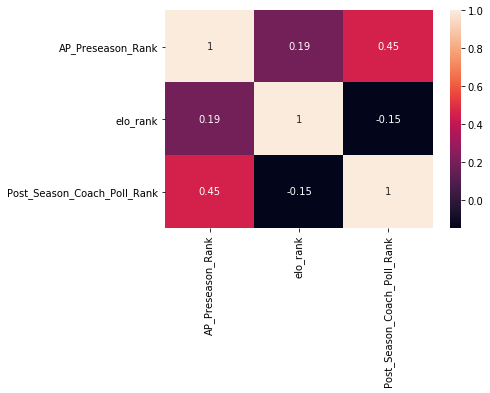

In [18]:
sn.heatmap(corr,annot=True)
plt.show()

In [19]:
# Create top 25 team indicator for rankings
all_ranks['AP_Preseason_top25'] = np.where(all_ranks['AP_Preseason_Rank']<=25,1,0)
all_ranks['elo_rank_top25'] = np.where(all_ranks['elo_rank']<=25,1,0)
all_ranks['coaches_poll_top25'] = np.where(all_ranks['Post_Season_Coach_Poll_Rank']<=25,1,0)

In [20]:
# Top 25 indicator columns only
top25 = all_ranks[['AP_Preseason_top25','elo_rank_top25','coaches_poll_top25']]

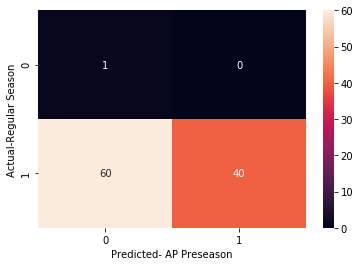

In [21]:
# Create Confusion Matrix to Understand Accuracy of Preseason compared to Actual Regular Season Elo rank
confusion_matrix = pd.crosstab(top25['AP_Preseason_top25'],top25['elo_rank_top25'],rownames=['Actual-Regular Season'],colnames=['Predicted- AP Preseason'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()


In [22]:
print("Preseason Rank Accuracy compared to the Regular Season Elo Rank is", round((confusion_matrix[0][0] + confusion_matrix[1][1])/ (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])*100,0),"%")

Preseason Rank Accuracy compared to the Regular Season Elo Rank is 41.0 %


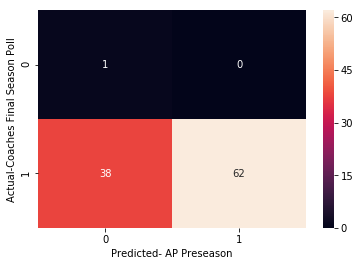

In [23]:
# Create Confusion Matrix to Understand Accuracy of Preseason compared to Actual Post Season Coaches Poll 
confusion_matrix = pd.crosstab(top25['AP_Preseason_top25'],top25['coaches_poll_top25'],rownames=['Actual-Coaches Final Season Poll'],colnames=['Predicted- AP Preseason'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()


In [24]:
print("Preseason Rank Accuracy compared to the Post Season Coaches Poll is", round((confusion_matrix[0][0] + confusion_matrix[1][1])/ (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])*100,0),"%")

Preseason Rank Accuracy compared to the Post Season Coaches Poll is 62.0 %
